### Camera Calibration

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob


%matplotlib inline

img=plt.imread('camera_cal/calibration2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:6, 0:9].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

#Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = plt.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (6,9), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (6,9), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        plt.figure(str(idx))
        plt.imshow(img,cmap='gray')
        

In [9]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

NameError: name 'objpoints' is not defined

In [10]:
import os
os.listdir("test_images/")

['challenge_video_test.jpg',
 'curvy_road1.jpg',
 'straight_lines1.jpg',
 'curvy_road.jpg',
 'test2.jpg',
 'straight_lines2.jpg',
 'test4.jpg',
 'test1.jpg',
 '.ipynb_checkpoints',
 'p2_harder.jpg',
 'test_hard.JPG',
 'test6.jpg',
 'test5.jpg',
 'test3.jpg']

### Helper Functions
Here are some help functions defined

### Build an Advanced Lane Finding Pipeline

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
Image width  1280
Right Lane Current fit  [  3.13421394e-04  -3.69800162e-01   1.19844074e+03]
Left Lane Current fit  [  2.31311323e-04  -4.03555866e-01   4.58920660e+02]
Fit Polynomial
Search from found line
dist from car center to left line:  -0.00788935639032 dist from lane car center to left line:  -0.56771750703
Width of Road  3.62554243635
found left [  2.31065081e-04  -4.03385149e-01   4.58897392e+02]
found right [  3.15543828e-04  -3.70892306e-01   1.19854554e+03]
Both Lines detected! [  8.44787470e-05   3.24928433e-02   7.39648143e+02]
Radius  17901.0 12426.0
Smooth Radius  42290 41742


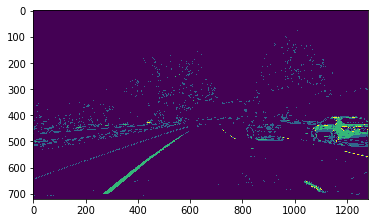

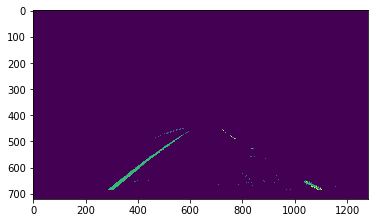

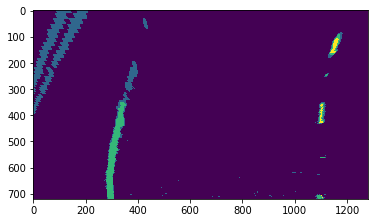

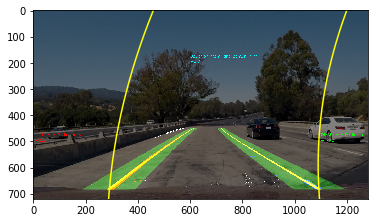

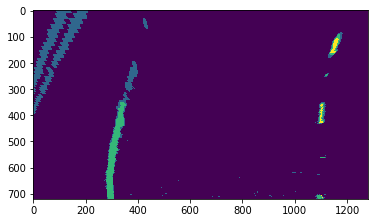

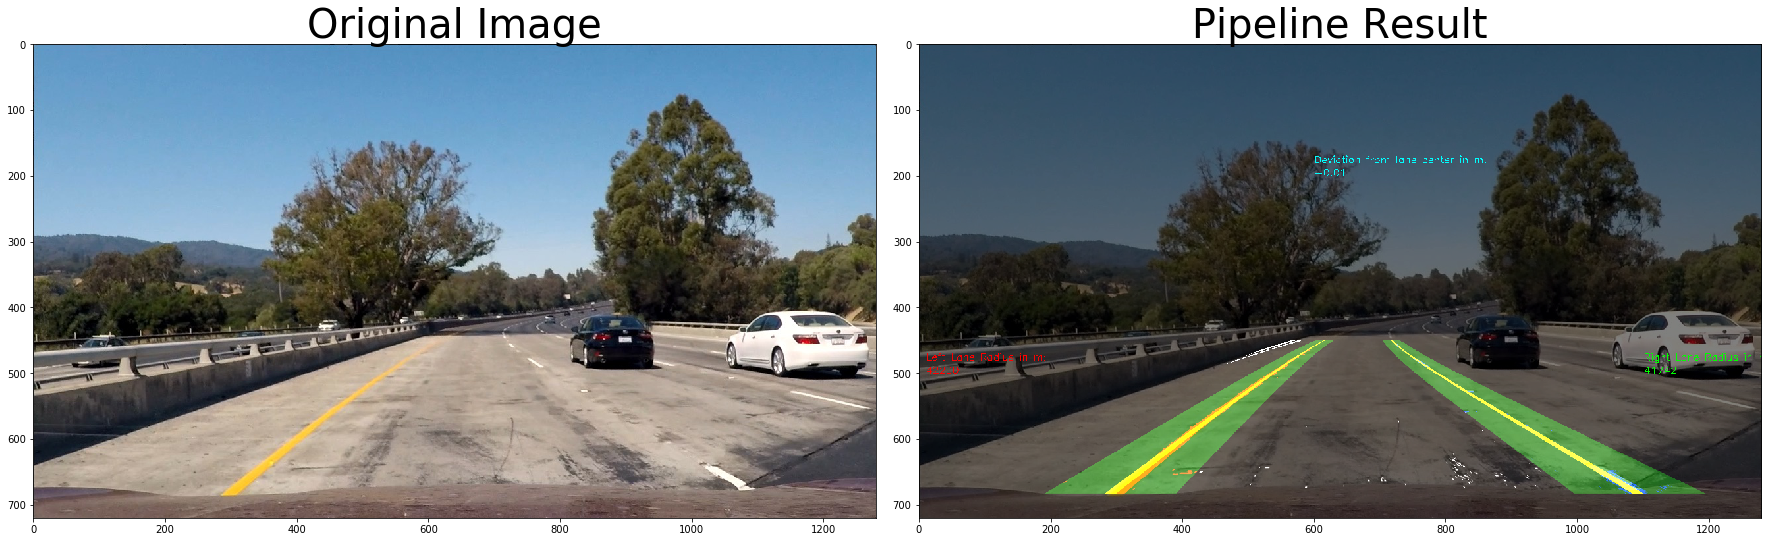

In [51]:
import numpy as np
load='test_images/solidWhiteRight.jpg'
save='test_images_output/solidWhiteRight_lines.jpg'
#reading in an image
image = mpimg.imread('test_images/test1.jpg')
#image = mpimg.imread('test_images/p2_harder.jpg')
#image = mpimg.imread('test_images/test_hard.JPG')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
right_lane = Line()
right_lane.detected = False
left_lane = Line()
right_lane.detected = False
left_lane.best_fit= np.array((np.float64(2.3131e-04), np.float64(-4.0355e-01),np.float64(4.58920e+02)))
right_lane.best_fit= np.array((np.float64(3.1342e-04), np.float64(-3.698e-01),np.float64(1.19844e+03)))

left_lane.smooth_radius_of_curvature=45000.0
right_lane.smooth_radius_of_curvature=45000.0

img_undist = undistort_image(image)
plt.imsave('output_images/undistort_image.jpg', img_undist)
#finding edges by thresholding HSV and HLS color space
sobel = imgSobel(img_undist, s_thresh=(180,255), sx_thresh=(50, 130), v_thresh=(230,255)) #200 240
#roi=setROI(sobel)
plt.figure(99)
plt.imshow(sobel)
result=np.copy(sobel)
roi = setROI(sobel)
plt.figure(97)
plt.imshow(roi)
plt.imsave('output_images/thresholded_image.jpg', roi)
# transforms image to bird eye view
warped = transformImage(roi)
plt.figure(98)
plt.imshow(warped)
plt.imsave('output_images/warped_image.jpg', warped)
"""2 steps approach to find lanes.
        1. if no lanes are detected yet, fit_polynomial funcions is used:
        finding lane pixels with maximum of histogram. Following from there with margin boxes
        2. After lanes are deteced, functions uses polynomial coefficients from last frame to search for new lane pixels
        Curvature of road and distance of car center related to both lanes is calculated"""
#try:
if (left_lane.detected == False) or (right_lane.detected == False):
    #if no right or left lane is detected, try basic search approach
    result, left_fit, right_fit, ploty = fit_polynomial(warped)
    print('Fit Polynomial')
    #left_lane.radius_of_curvature, right_lane.radius_of_curvature = measure_curvature_pixels(left_lane.ally,left_lane.current_fit,right_lane.current_fit)
    #print('Radius ', left_lane.radius_of_curvature.round(0), right_lane.radius_of_curvature.round(0)) 
    lanes_warped = transformImageBack(result)
    left_lane.detected=True
    right_lane.detected=True       
if (left_lane.detected == True) & (right_lane.detected == True):
    result = search_around_poly(warped, left_lane.current_fit, right_lane.current_fit)
    #current fit is set in fit_poly function
    print('Search from found line')
    lanes_warped = transformImageBack(result)
else:
    print('No correct lane detected')
        #lanes_warped=draw_lanes_mean(image)
        #lanes_warped = image
            
# calculate radius of lanes
left_lane.radius_of_curvature, right_lane.radius_of_curvature = measure_curvature_pixels(left_lane.ally,left_lane.best_fit,right_lane.best_fit)
#sanity check whether lane candidates are real lanes
sanity_check_lines()
        
print('Radius ', left_lane.radius_of_curvature.round(0), right_lane.radius_of_curvature.round(0))
print('Smooth Radius ', left_lane.smooth_radius_of_curvature, right_lane.smooth_radius_of_curvature)
result2 = draw_lanes_mean(result)
plt.imsave('output_images/withlanes_image1.jpg', result2)
lanes_warped = transformImageBack(result2)
plt.imsave('output_images/laneswarped_image1.jpg', lanes_warped)
    #except:
        #print('Error')
        #lanes_warped = image
    

road_with_lanes = visualize_radius(image,lanes_warped)
plt.imsave('output_images/final_image1.jpg', road_with_lanes)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(road_with_lanes)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

###Build an Advanced Lane Finding Pipeline

In [43]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import pickle
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #smoothed radius of curvature of the line in some units
        self.smooth_radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
        # yvalues for ploting
        self.ploty = None
        #distance between lane and middle of lane
        self.lane_distance = None
        #countes how the lane was detected
        self.poly_counter = None
        
def imgSobel(img, s_thresh, sx_thresh, v_thresh):
    img = np.copy(img)
    """Convert to HLS and HSV color space. Using S and V channel for finding lane pixels"""
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    hsv=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    # Sobel x
    #sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0,ksize=5) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    laplacian = cv2.Laplacian(l_channel,cv2.CV_64F,ksize=7)
    abs_sobelx = np.absolute(laplacian) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, v_binary)) * 255
    binary = (s_binary + v_binary + sxbinary)#*255
    #ret,thresh1 = cv2.threshold(binary,0,255,cv2.THRESH_BINARY)
    
    return binary

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def setROI(img):
    """Sets a Region of interest"""
    x_fac=int(img.shape[0]/20)
    y_fac=int(img.shape[1]/20)
    print('Image width ',img.shape[1])
    #setting ROI - independent of image size
    vertices = np.array([[[0,19*x_fac],[8.6*y_fac,450],[11.4*y_fac,450],[20*y_fac,19*x_fac]]],dtype=np.int32) 
    roi=region_of_interest(img, vertices)
    return roi

def transformImage(img):
        '''Transforms image of road to birds eye view'''
        x_fac=int(img.shape[0]/20)
        y_fac=int(img.shape[1]/20)
        '''Src are the source points in the original image, dst are the same points but on the road viewed from above'''
        src = np.float32([[0,19*x_fac],[8.6*y_fac,450],[11.4*y_fac,450],[20*y_fac,19*x_fac]])
        dst = np.float32([[0,20*x_fac],[0,0],[20*y_fac,0],[20*y_fac,20*x_fac]])
        
        M=cv2.getPerspectiveTransform(src,dst)
        warped = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
        return warped
    
def transformImageBack(img):
        '''Transforms image of bird eye view to road'''
        x_fac=int(img.shape[0]/20)
        y_fac=int(img.shape[1]/20)
        '''Src are the source points in the original image, dst are the same points but on the road viewed from above'''
        dst = np.float32([[0,19*x_fac],[8.6*y_fac,450],[11.4*y_fac,450],[20*y_fac,19*x_fac]])
        src = np.float32([[0,20*x_fac],[0,0],[20*y_fac,0],[20*y_fac,20*x_fac]])
        
        M=cv2.getPerspectiveTransform(src,dst)
        warped = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
        return warped
    
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 30
    # Set the width of the windows +/- margin
    margin = 150
    # Set minimum number of pixels found to recenter window
    minpix = 15

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = int(leftx_current-margin)  # Update this
        win_xleft_high = int(leftx_current+margin)  # Update this
        win_xright_low = int(rightx_current-margin)  # Update this
        win_xright_high = int(rightx_current+margin) # Update this

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current=int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current=int(np.mean(nonzerox[good_right_inds]))
       # else: 
        #if not enough pixels, change margin (in case of tight curves)
           # margin = 300
            # Set minimum number of pixels found to recenter window
            #minpix = 20
            #window=window-1
            #pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    #set parameters of Line
    left_lane.allx=left_fitx
    left_lane.ally=ploty
    right_lane.allx=right_fitx
    right_lane.ally=ploty
    print('Right Lane Current fit ',right_fit)
    print('Left Lane Current fit ',left_fit)
    right_lane.current_fit=right_fit
    left_lane.current_fit=left_fit
    ## Visualization ##
    # Colors in the left and right lane regions+plt.figure(5)
    plt.figure(4)
       
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.imshow(out_img)
    return out_img, left_fit, right_fit, ploty

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_lane.current_fit=left_fit
    right_lane.current_fit=right_fit
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_lane.allx=left_fitx
    left_lane.ally=ploty
    right_lane.allx=right_fitx
    right_lane.ally=ploty
    
    return left_fitx, right_fitx

def search_around_poly(binary_warped,left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
   
    # Fit new polynomials
    left_fitx, right_fitx = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
   
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, left_lane.ally]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              left_lane.ally])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, left_lane.ally]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              left_lane.ally])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    plt.figure(5)
    plt.imshow(binary_warped)
    plt.figure(4)
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    #draw_points = np.vstack((left_fitx,ploty)).astype(np.int32).T
    #cv2.polylines(window_img, [draw_points], False, (255,255,0),15)  
    #draw_points_right = np.vstack((right_fitx,ploty)).astype(np.int32).T
    #cv2.polylines(window_img, [draw_points_right], False, (255,255,0),15) 
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    #Plot the polynomial lines onto the image
    #plt.plot(left_fitx, left_lane.ally, color='yellow')
    #plt.plot(right_fitx, left_lane.ally, color='yellow')
    #plt.imshow(result)
    # End visualization steps ##
    return result

def measure_curvature_pixels(ploty,left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    #definition of scale: Pixel to real world mm
    # 700 pixels = width of US lane = 3.7 m
    # 1 pixel = 0.00503 m
    ym_per_pix = 150/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #polynomial function with values in meter
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_lane.allx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_lane.allx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty).astype(int)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature in m) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    left_lane_pos=np.mean(left_lane.allx[y_eval-10:y_eval])
    right_lane_pos=np.mean(right_lane.allx[y_eval-10:y_eval])
    image_mid=1280/2
    lane_mid=700/2
    left_lane.line_base_pos=(lane_mid-(image_mid-left_lane_pos))*xm_per_pix
    right_lane.line_base_pos=(lane_mid-(right_lane_pos-image_mid))*xm_per_pix
    left_lane.lane_distance=(left_lane_pos-lane_mid)*xm_per_pix
    right_lane.lane_distance=(lane_mid-right_lane_pos)*xm_per_pix
    print('dist from car center to left line: ',left_lane.line_base_pos,'dist from lane car center to left line: ',right_lane.line_base_pos)
    print('Width of Road ',left_lane.lane_distance-right_lane.lane_distance)
    #print('all left lane pixels',left_lane.allx)
    #print('all left lane pixels',left_lane.ally)
    return left_curverad, right_curverad

def undistort_image(image):
    img_undist = cv2.undistort(image, dist_pickle["mtx"], dist_pickle["dist"], None, mtx)
    return img_undist

def sanity_check_lines():
    """sanity check for lane candidates
    1. check wether polynomial coefficients of the last lanes are similar to new candidate of the actual frame.
       IF yes -> left_lane.best_fit is updated with new lane
    2. Check wether poly coefficients of both lanes are similar compared to each other
       IF yes -> both lanes are found = TRUE"""
    abs_val_left=np.absolute(left_lane.current_fit - left_lane.best_fit)
    abs_val_right=np.absolute(right_lane.current_fit - right_lane.best_fit)
    if abs_val_left[0]<np.float64(1.1):#1.1
        if abs_val_left[1]<np.float64(1.1):#1.1
            if abs_val_left[2]<np.float64(500):#500
                best_fit = np.array(left_lane.best_fit)*7
                left_lane.best_fit =np.divide(best_fit+left_lane.current_fit,8)
                best_curv=9*left_lane.smooth_radius_of_curvature
                left_lane.smooth_radius_of_curvature =int(np.divide(best_curv+left_lane.radius_of_curvature,10))
                left_lane.detected=True
                print('found left', left_lane.best_fit)
            else:
                right_lane.detected=False
        else:
            right_lane.detected=False
    else:
        right_lane.detected=False
    if abs_val_right[0]<np.float64(1.1):
        if abs_val_right[1]<np.float64(1.1):
            if abs_val_right[2]<np.float64(1000):
                best_fit = np.array(right_lane.best_fit)*7
                right_lane.best_fit =np.divide(best_fit+right_lane.current_fit,8)
                best_curv=9*right_lane.smooth_radius_of_curvature
                right_lane.smooth_radius_of_curvature =int(np.divide(best_curv+right_lane.radius_of_curvature,10))
                right_lane.detected=True
                print('found right', right_lane.best_fit)
            else:
                right_lane.detected=False
        else:
            right_lane.detected=False
    else:
        right_lane.detected=False
    abs_val_best=np.absolute(right_lane.best_fit - left_lane.best_fit)
    #print('Auswahlkriterium rechte Faktoren minus linke',abs_val_best)
    if (left_lane.detected==True) & (right_lane.detected==True):
        if abs_val_best[0]<np.float64(0.01):
            if abs_val_best[1]<np.float64(0.6):
                if abs_val_best[2]<np.float64(800):
                    #check if lane width is around 3.7 m
                    if (left_lane.lane_distance-right_lane.lane_distance)>3.3:
                        if (left_lane.lane_distance-right_lane.lane_distance)<3.99:
                            left_lane.detected=True
                            right_lane.detected=True
                            print('Both Lines detected!',abs_val_best)
                        else:
                            left_lane.detected=False
                            right_lane.detected=False
                            print('Sanity Check failed! 1')
                    else:
                        left_lane.detected=False
                        right_lane.detected=False
                        print('Sanity Check failed! 2')
                else:
                    left_lane.detected=False
                    right_lane.detected=False
                    print('Sanity Check failed! 3')
            else:
                left_lane.detected=False
                right_lane.detected=False
                print('Sanity Check failed! 4')
        else:
            left_lane.detected=False
            right_lane.detected=False
            print('Sanity Check failed! 5')
    else:
        left_lane.detected=False
        right_lane.detected=False
        print('Sanity Check failed! 6')
    
    return
def draw_lanes_mean(img):
    """Drawing the lanes with the averaged poly coefficients: .best_fit"""
    left_fitx = left_lane.best_fit[0]*left_lane.ally**2 + left_lane.best_fit[1]*left_lane.ally + left_lane.best_fit[2]
    right_fitx = right_lane.best_fit[0]*left_lane.ally**2 + right_lane.best_fit[1]*left_lane.ally + right_lane.best_fit[2]
    draw_points = np.vstack((left_fitx,left_lane.ally)).astype(np.int32).T
    cv2.polylines(img, [draw_points], False, (255,255,0),15)
    
   # draw_points_right = (np.asarray([right_fitx, ploty]).T).astype(np.int32)
    draw_points_right = np.vstack((right_fitx,right_lane.ally)).astype(np.int32).T
    cv2.polylines(img, [draw_points_right], False, (255,255,0),15)
    #font                   = cv2.FONT_HERSHEY_SIMPLEX
    #fontScale              = 0.5
    #fontColor              = (255,0,0)
    #lineType               = 1
    #bottomLeftCornerOfText = (600,180)
    #cv2.putText(img,'No correct lane detected', bottomLeftCornerOfText, font, fontScale,(0,255,255),lineType)

    return img
def visualize_radius(image,lanes_warped):
    #visualisation
    road_with_lanes = cv2.addWeighted(image, 0.5, lanes_warped, 1, 0)
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,500)
    fontScale              = 0.5
    fontColor              = (255,0,0)
    lineType               = 1
    cv2.putText(road_with_lanes,str(left_lane.smooth_radius_of_curvature), 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    bottomLeftCornerOfText = (10,480)
    cv2.putText(road_with_lanes,'Left Lane Radius in m:', 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        (255,0,0),
        lineType)
    bottomLeftCornerOfText = (1100,500)
    cv2.putText(road_with_lanes,str(right_lane.smooth_radius_of_curvature), 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        (0,255,0),
        lineType)
    bottomLeftCornerOfText = (1100,480)
    cv2.putText(road_with_lanes,'Right Lane Radius in m:', 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        (0,255,0),
        lineType)
    bottomLeftCornerOfText = (600,200)
    cv2.putText(road_with_lanes,left_lane.line_base_pos.round(2).astype(str), 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        (0,255,255),
        lineType)
    bottomLeftCornerOfText = (600,180)
    cv2.putText(road_with_lanes,'Deviation from lane center in m:', 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        (0,255,255),
        lineType)
    
    plt.imshow(road_with_lanes)
    
    return road_with_lanes

In [44]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image(image):
    
    #plt.imsave('output_images/raw_image.jpg', image)
    #undistort image with camera parameters
    img_undist = undistort_image(image)
    #plt.imsave('output_images/undistort_image.jpg', img_undist)
    #finding edges by thresholding HSV and HLS color space
    sobel = imgSobel(img_undist, s_thresh=(150,255), sx_thresh=(37, 130), v_thresh=(200,255)) #200 240
    #roi=setROI(sobel)
    plt.figure(99)
    plt.imshow(sobel)
    result=np.copy(sobel)
    #roi = setROI(sobel)
    #plt.imsave('output_images/thresholded_image.jpg', sobel)
    # transforms image to bird eye view
    warped = transformImage(sobel)
    #plt.figure(98)
    #plt.imshow(warped)
    #plt.imsave('output_images/warped_image.jpg', warped)
    """2 steps approach to find lanes.
        1. if no lanes are detected yet, fit_polynomial funcions is used:
        finding lane pixels with maximum of histogram. Following from there with margin boxes
        2. After lanes are deteced, functions uses polynomial coefficients from last frame to search for new lane pixels
        Curvature of road and distance of car center related to both lanes is calculated"""
    #try:
    if (left_lane.detected == False) or (right_lane.detected == False):
        #if no right or left lane is detected, try basic search approach
        result, left_fit, right_fit, ploty = fit_polynomial(warped)
        print('Fit Polynomial')
        #left_lane.radius_of_curvature, right_lane.radius_of_curvature = measure_curvature_pixels(left_lane.ally,left_lane.current_fit,right_lane.current_fit)
        #print('Radius ', left_lane.radius_of_curvature.round(0), right_lane.radius_of_curvature.round(0)) 
        lanes_warped = transformImageBack(result)
        right_lane.poly_counter += 1
        #left_lane.detected=True
        #right_lane.detected=True       
    if (left_lane.detected == True) & (right_lane.detected == True):
            
        result = search_around_poly(warped, left_lane.current_fit, right_lane.current_fit)
        #current fit is set in fit_poly function
        print('Search from found line')
        lanes_warped = transformImageBack(result)
    else:
        print('No correct lane detected')
        #lanes_warped=draw_lanes_mean(image)
        #lanes_warped = image
            
    # calculate radius of lanes
    left_lane.radius_of_curvature, right_lane.radius_of_curvature = measure_curvature_pixels(left_lane.ally,left_lane.best_fit,right_lane.best_fit)
    #sanity check whether lane candidates are real lanes
    sanity_check_lines()
        
    print('Radius ', left_lane.radius_of_curvature.round(0), right_lane.radius_of_curvature.round(0))
    print('Smooth Radius ', left_lane.smooth_radius_of_curvature, right_lane.smooth_radius_of_curvature)
    result2 = draw_lanes_mean(result)
    #plt.imsave('output_images/withlanes_image.jpg', result2)
    lanes_warped = transformImageBack(result2)
    #plt.imsave('output_images/laneswarped_image.jpg', lanes_warped)
    #except:
        #print('Error')
        #lanes_warped = image
    

    road_with_lanes = visualize_radius(image,lanes_warped)
    #plt.imsave('output_images/final_image.jpg', road_with_lanes)
    return road_with_lanes
# Plot the result
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()

#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=40)

#ax2.imshow(road_with_lanes)
#ax2.set_title('Pipeline Result', fontsize=40)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Right Lane Current fit  [ -2.00163564e-04   5.49262129e-01   8.52577130e+02]
Left Lane Current fit  [ -4.52359389e-04   5.33859718e-01   1.71829321e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.171502202028 dist from lane car center to left line:  -0.806464102141
Width of Road  4.04368058988
found left [  1.45851326e-04  -2.86373785e-01   4.23033665e+02]
found right [  2.49222055e-04  -2.54917234e-01   1.15520714e+03]
Sanity Check failed! 1
Radius  9076.0 20513.0
Smooth Radius  14407 15551
[MoviePy] >>>> Building video video_out/project_video_out_final2.mp4
[MoviePy] Writing video video_out/project_video_out_final2.mp4



  0%|          | 1/1261 [00:01<21:30,  1.02s/it]

Right Lane Current fit  [ -2.00163564e-04   5.49262129e-01   8.52577130e+02]
Left Lane Current fit  [ -4.52359389e-04   5.33859718e-01   1.71829321e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.171502202028 dist from lane car center to left line:  -0.806464102141
Width of Road  4.04368058988
found left [  7.10749869e-05  -1.83844597e-01   3.91633122e+02]
found right [  1.93048852e-04  -1.54394814e-01   1.11737839e+03]
Sanity Check failed! 1
Radius  9076.0 20513.0
Smooth Radius  13873 16047



  0%|          | 2/1261 [00:02<21:49,  1.04s/it]

Right Lane Current fit  [ -1.98070618e-04   5.52165525e-01   8.46231648e+02]
Left Lane Current fit  [ -4.59268416e-04   5.44023602e-01   1.69651607e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.179731514342 dist from lane car center to left line:  -0.789505365327
Width of Road  4.03495116538
found left [  4.78206158e-06  -9.28610724e-02   3.63885433e+02]
found right [  1.44158918e-04  -6.60747712e-02   1.08348505e+03]
Sanity Check failed! 1
Radius  8940.0 20730.0
Smooth Radius  13379 16515



  0%|          | 3/1261 [00:03<21:17,  1.02s/it]

Right Lane Current fit  [ -3.33682143e-04   6.69562226e-01   8.21892512e+02]
Left Lane Current fit  [ -4.59172691e-04   5.46809877e-01   1.68783993e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.185911178753 dist from lane car center to left line:  -0.738682540931
Width of Road  3.9903080054
found left [ -5.32122825e-05  -1.29022037e-02   3.39497753e+02]
found right [  8.44287857e-05   2.58798535e-02   1.05078598e+03]
Sanity Check failed! 1
Radius  8942.0 12305.0
Smooth Radius  12935 16093



  0%|          | 4/1261 [00:03<20:36,  1.02it/s]

Right Lane Current fit  [ -4.26941219e-04   7.63763149e-01   7.98576227e+02]
Left Lane Current fit  [ -4.46062959e-04   5.42674318e-01   1.68584665e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.204537986413 dist from lane car center to left line:  -0.719753152399
Width of Road  3.99000542453
found left [ -1.02318617e-04   5.65448614e-02   3.18133617e+02]
found right [  2.05075351e-05   1.18115265e-01   1.01925976e+03]
Sanity Check failed! 1
Radius  9204.0 9617.0
Smooth Radius  12561 15445



  0%|          | 5/1261 [00:04<20:11,  1.04it/s]

Right Lane Current fit  [ -5.04412312e-04   8.34787612e-01   7.84740609e+02]
Left Lane Current fit  [ -4.55458562e-04   5.53745071e-01   1.65386628e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.204103146402 dist from lane car center to left line:  -0.706013143804
Width of Road  3.97583057592
found left [ -1.46461110e-04   1.18694888e-01   2.99040243e+02]
found right [ -4.51074458e-05   2.07699309e-01   9.89944867e+02]
Both Lines detected! [  1.01353664e-04   8.90044212e-02   6.90904624e+02]
Radius  9014.0 8140.0
Smooth Radius  12206 14714



  0%|          | 6/1261 [00:05<19:44,  1.06it/s]

Search from found line
dist from car center to left line:  0.216421169349 dist from lane car center to left line:  -0.700422946557
Width of Road  3.98255840162
found left [ -1.85646273e-04   1.74366311e-01   2.81989659e+02]
found right [ -1.03377468e-04   2.88540597e-01   9.62846559e+02]
Both Lines detected! [  8.22688056e-05   1.14174286e-01   6.80856900e+02]
Radius  8927.0 8030.0
Smooth Radius  11878 14045



  1%|          | 7/1261 [00:06<19:06,  1.09it/s]

Search from found line
dist from car center to left line:  0.228312479894 dist from lane car center to left line:  -0.690815062303
Width of Road  3.98484182791
found left [ -2.15872837e-04   2.20536930e-01   2.67098102e+02]
found right [ -1.54601613e-04   3.58212751e-01   9.39788573e+02]
Both Lines detected! [  6.12712236e-05   1.37675821e-01   6.72690470e+02]
Radius  9605.0 8001.0
Smooth Radius  11650 13440



  1%|          | 8/1261 [00:07<18:40,  1.12it/s]

Search from found line
dist from car center to left line:  0.245282792836 dist from lane car center to left line:  -0.682683949578
Width of Road  3.99368102813
found left [ -2.41038186e-04   2.60851298e-01   2.53876798e+02]
found right [ -1.94667943e-04   4.16563006e-01   9.18864211e+02]
Sanity Check failed! 1
Radius  9841.0 8641.0
Smooth Radius  11469 12960



  1%|          | 9/1261 [00:08<18:29,  1.13it/s]

Right Lane Current fit  [ -4.24664786e-04   7.73008121e-01   7.87802212e+02]
Left Lane Current fit  [ -4.02808391e-04   5.36058997e-01   1.58941387e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.245011652434 dist from lane car center to left line:  -0.703796545024
Width of Road  4.01452248317
found left [ -2.61259462e-04   2.95252261e-01   2.42009872e+02]
found right [ -2.23417548e-04   4.61118645e-01   9.02481461e+02]
Sanity Check failed! 1
Radius  10193.0 9668.0
Smooth Radius  11341 12630



  1%|          | 10/1261 [00:09<18:24,  1.13it/s]

Right Lane Current fit  [ -2.77063023e-04   6.70315437e-01   8.00776190e+02]
Left Lane Current fit  [ -3.81208045e-04   5.24569004e-01   1.56382534e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.246277940575 dist from lane car center to left line:  -0.782265105315
Width of Road  4.0942573316
found left [ -2.76253035e-04   3.23916854e-01   2.31306455e+02]
found right [ -2.30123232e-04   4.87268244e-01   8.89768302e+02]
Sanity Check failed! 1
Radius  10770.0 14820.0
Smooth Radius  11283 12848



  1%|          | 11/1261 [00:10<18:22,  1.13it/s]

Right Lane Current fit  [ -1.90044195e-04   6.15123297e-01   8.01641369e+02]
Left Lane Current fit  [ -3.81393337e-04   5.27127227e-01   1.54696978e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.246517945213 dist from lane car center to left line:  -0.812848493933
Width of Road  4.12508072486
found left [ -2.89395573e-04   3.49318150e-01   2.21730270e+02]
found right [ -2.25113353e-04   5.03250126e-01   8.78752436e+02]
Sanity Check failed! 1
Radius  10765.0 21606.0
Smooth Radius  11231 13723



  1%|          | 12/1261 [00:10<18:25,  1.13it/s]

Right Lane Current fit  [ -2.50658645e-04   6.24615844e-01   8.21049333e+02]
Left Lane Current fit  [ -3.63072413e-04   5.15197069e-01   1.50331820e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.227751982771 dist from lane car center to left line:  -0.78812538382
Width of Road  4.08159165231
found left [ -2.98605178e-04   3.70053015e-01   2.12805464e+02]
found right [ -2.28306514e-04   5.18420841e-01   8.71539548e+02]
Sanity Check failed! 1
Radius  11308.0 16381.0
Smooth Radius  11238 13988



  1%|          | 13/1261 [00:11<18:21,  1.13it/s]

Right Lane Current fit  [ -1.34795378e-04   5.45874474e-01   8.25514821e+02]
Left Lane Current fit  [ -3.65170370e-04   5.17926654e-01   1.49352421e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.227223987252 dist from lane car center to left line:  -0.826544122266
Width of Road  4.11948239523
found left [ -3.06925827e-04   3.88537220e-01   2.04873834e+02]
found right [ -2.16617622e-04   5.21852545e-01   8.65786457e+02]
Sanity Check failed! 1
Radius  11243.0 30462.0
Smooth Radius  11238 15635



  1%|          | 14/1261 [00:12<18:20,  1.13it/s]

Right Lane Current fit  [ -1.44870997e-04   5.52789060e-01   8.21423039e+02]
Left Lane Current fit  [ -3.49704335e-04   5.04945280e-01   1.50858696e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.227845989063 dist from lane car center to left line:  -0.803880947942
Width of Road  4.09744122272
found left [ -3.12273140e-04   4.03088227e-01   1.98121941e+02]
found right [ -2.07649294e-04   5.25719609e-01   8.60241030e+02]
Sanity Check failed! 1
Radius  11740.0 28343.0
Smooth Radius  11288 16905



  1%|          | 15/1261 [00:13<18:33,  1.12it/s]

Right Lane Current fit  [ -3.49427849e-04   7.42384487e-01   7.73166780e+02]
Left Lane Current fit  [ -3.63425439e-04   5.18082134e-01   1.49144363e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.231406071355 dist from lane car center to left line:  -0.71340076599
Width of Road  4.01052112306
found left [ -3.18667178e-04   4.17462466e-01   1.91999744e+02]
found right [ -2.25371613e-04   5.52802719e-01   8.49356749e+02]
Sanity Check failed! 1
Radius  11297.0 11750.0
Smooth Radius  11288 16389



  1%|▏         | 16/1261 [00:14<19:24,  1.07it/s]

Right Lane Current fit  [ -5.12315027e-04   9.01963743e-01   7.31187516e+02]
Left Lane Current fit  [ -4.09899775e-04   5.52984340e-01   1.45596119e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.219221636594 dist from lane car center to left line:  -0.655026508283
Width of Road  3.93996243059
found left [ -3.30071252e-04   4.34402700e-01   1.86199291e+02]
found right [ -2.61239540e-04   5.96447847e-01   8.34585595e+02]
Both Lines detected! [  6.88317123e-05   1.62045147e-01   6.48386304e+02]
Radius  10016.0 8014.0
Smooth Radius  11160 15551



  1%|▏         | 17/1261 [00:15<19:02,  1.09it/s]

Search from found line
dist from car center to left line:  0.220559440636 dist from lane car center to left line:  -0.65788994034
Width of Road  3.94416366669
found left [ -3.38852206e-04   4.48550961e-01   1.81027055e+02]
found right [ -2.88040154e-04   6.31481068e-01   8.21646967e+02]
Both Lines detected! [  5.08120525e-05   1.82930107e-01   6.40619912e+02]
Radius  10256.0 8632.0
Smooth Radius  11069 14859



  1%|▏         | 18/1261 [00:16<18:47,  1.10it/s]

Search from found line
dist from car center to left line:  0.212511391919 dist from lane car center to left line:  -0.642378266946
Width of Road  3.92060394458
found left [ -3.48278183e-04   4.62105791e-01   1.76359750e+02]
found right [ -3.12697688e-04   6.64034654e-01   8.09218002e+02]
Both Lines detected! [  3.55804949e-05   2.01928862e-01   6.32858252e+02]
Radius  9911.0 8460.0
Smooth Radius  10953 14219



  2%|▏         | 19/1261 [00:17<18:35,  1.11it/s]

Search from found line
dist from car center to left line:  0.204491326104 dist from lane car center to left line:  -0.624433706633
Width of Road  3.89463931845
found left [ -3.54569932e-04   4.72548820e-01   1.72101773e+02]
found right [ -3.37919126e-04   6.92696436e-01   7.99647915e+02]
Both Lines detected! [  1.66508066e-05   2.20147616e-01   6.27546142e+02]
Radius  10300.0 7981.0
Smooth Radius  10887 13595



  2%|▏         | 20/1261 [00:18<18:24,  1.12it/s]

Search from found line
dist from car center to left line:  0.195468417739 dist from lane car center to left line:  -0.5545389097
Width of Road  3.81572161315
found left [ -3.59680197e-04   4.81676823e-01   1.67968447e+02]
found right [ -3.68871494e-04   7.20825679e-01   7.91967427e+02]
Both Lines detected! [  9.19129728e-06   2.39148855e-01   6.23998980e+02]
Radius  10382.0 7012.0
Smooth Radius  10836 12936



  2%|▏         | 21/1261 [00:19<18:12,  1.14it/s]

Search from found line
dist from car center to left line:  0.189035333764 dist from lane car center to left line:  -0.476243880181
Width of Road  3.73099349966
found left [ -3.61017101e-04   4.86991674e-01   1.64510450e+02]
found right [ -4.04820222e-04   7.46732238e-01   7.86985830e+02]
Both Lines detected! [  4.38031218e-05   2.59740565e-01   6.22475380e+02]
Radius  11085.0 6254.0
Smooth Radius  10860 12267



  2%|▏         | 22/1261 [00:19<18:08,  1.14it/s]

Search from found line
dist from car center to left line:  0.179267520864 dist from lane car center to left line:  -0.523572063971
Width of Road  3.76855387055
found left [ -3.59124755e-04   4.89472308e-01   1.61242998e+02]
found right [ -4.30016155e-04   7.63490009e-01   7.84776799e+02]
Both Lines detected! [  7.08914001e-05   2.74017701e-01   6.23533800e+02]
Radius  11870.0 6771.0
Smooth Radius  10961 11717



  2%|▏         | 23/1261 [00:20<17:58,  1.15it/s]

Search from found line
dist from car center to left line:  0.152176750836 dist from lane car center to left line:  -0.57028766292
Width of Road  3.78817869947
found left [ -3.59080759e-04   4.92084917e-01   1.58248467e+02]
found right [ -4.44970435e-04   7.72110838e-01   7.84649228e+02]
Both Lines detected! [  8.58896757e-05   2.80025922e-01   6.26400761e+02]
Radius  11444.0 7470.0
Smooth Radius  11009 11292



  2%|▏         | 24/1261 [00:21<17:56,  1.15it/s]

Search from found line
dist from car center to left line:  0.139891910177 dist from lane car center to left line:  -0.655808866558
Width of Road  3.86141506245
found left [ -3.62244567e-04   4.96235516e-01   1.55637627e+02]
found right [ -4.36692048e-04   7.65743422e-01   7.85609415e+02]
Both Lines detected! [  7.44474815e-05   2.69507906e-01   6.29971787e+02]
Radius  10681.0 10841.0
Smooth Radius  10976 11246



  2%|▏         | 25/1261 [00:22<18:09,  1.13it/s]

Search from found line
dist from car center to left line:  0.122603536721 dist from lane car center to left line:  -0.700907552528
Width of Road  3.88922537496
found left [ -3.69026285e-04   5.02239266e-01   1.53295068e+02]
found right [ -4.15968806e-04   7.50949177e-01   7.87234172e+02]
Both Lines detected! [  4.69425214e-05   2.48709911e-01   6.33939105e+02]
Radius  9858.0 15156.0
Smooth Radius  10864 11637



  2%|▏         | 26/1261 [00:23<18:02,  1.14it/s]

Search from found line
dist from car center to left line:  0.113035765828 dist from lane car center to left line:  -0.713357288118
Width of Road  3.89210733966
found left [ -3.71328580e-04   5.04294006e-01   1.51452354e+02]
found right [ -3.94446531e-04   7.32297770e-01   7.91296271e+02]
Both Lines detected! [  2.31179516e-05   2.28003764e-01   6.39843917e+02]
Radius  10597.0 16842.0
Smooth Radius  10837 12157



  2%|▏         | 27/1261 [00:24<17:51,  1.15it/s]

Search from found line
dist from car center to left line:  0.0962325290609 dist from lane car center to left line:  -0.723001806717
Width of Road  3.88494862149
found left [ -3.76665811e-04   5.08500117e-01   1.49415913e+02]
found right [ -3.74377126e-04   7.14822648e-01   7.95272924e+02]
Both Lines detected! [  2.28868515e-06   2.06322532e-01   6.45857011e+02]
Radius  9916.0 17555.0
Smooth Radius  10744 12696



  2%|▏         | 28/1261 [00:25<17:41,  1.16it/s]

Search from found line
dist from car center to left line:  0.0811531755834 dist from lane car center to left line:  -0.734473810631
Width of Road  3.88134127193
found left [ -3.79733133e-04   5.10526626e-01   1.47641486e+02]
found right [ -3.52721461e-04   6.92627873e-01   8.01865135e+02]
Both Lines detected! [  2.70116716e-05   1.82101247e-01   6.54223649e+02]
Radius  10233.0 20414.0
Smooth Radius  10692 13467



  2%|▏         | 29/1261 [00:26<17:46,  1.16it/s]

Search from found line
dist from car center to left line:  0.0761581341503 dist from lane car center to left line:  -0.718795983075
Width of Road  3.86066840294
found left [ -3.85705475e-04   5.14361077e-01   1.46174142e+02]
found right [ -3.37098047e-04   6.76908951e-01   8.06314411e+02]
Both Lines detected! [  4.86074288e-05   1.62547874e-01   6.60140269e+02]
Radius  9604.0 18029.0
Smooth Radius  10583 13923



  2%|▏         | 30/1261 [00:26<17:46,  1.15it/s]

Search from found line
dist from car center to left line:  0.0732585280705 dist from lane car center to left line:  -0.697552826771
Width of Road  3.83652564056
found left [ -3.96731252e-04   5.22270284e-01   1.44525034e+02]
found right [ -3.31373171e-04   6.72065215e-01   8.07392677e+02]
Both Lines detected! [  6.53580806e-05   1.49794930e-01   6.62867643e+02]
Radius  8663.0 14095.0
Smooth Radius  10391 13940



  2%|▏         | 31/1261 [00:27<18:28,  1.11it/s]

Search from found line
dist from car center to left line:  0.0758049249649 dist from lane car center to left line:  -0.654674848719
Width of Road  3.7961940594
found left [ -4.12634780e-04   5.34684853e-01   1.42407161e+02]
found right [ -3.52292856e-04   6.92786164e-01   8.02713934e+02]
Both Lines detected! [  6.03419233e-05   1.58101310e-01   6.60306773e+02]
Radius  7836.0 8232.0
Smooth Radius  10135 13369



  3%|▎         | 32/1261 [00:28<18:30,  1.11it/s]

Search from found line
dist from car center to left line:  0.0792445406174 dist from lane car center to left line:  -0.610315229792
Width of Road  3.75527405612
found left [ -4.31944578e-04   5.50017158e-01   1.40192479e+02]
found right [ -3.85748491e-04   7.26981762e-01   7.93821961e+02]
Both Lines detected! [  4.61960873e-05   1.76964604e-01   6.53629483e+02]
Radius  7240.0 6623.0
Smooth Radius  9845 12694



  3%|▎         | 33/1261 [00:29<18:09,  1.13it/s]

Search from found line
dist from car center to left line:  0.0778685818993 dist from lane car center to left line:  -0.500710280097
Width of Road  3.64429314771
found left [ -4.46519219e-04   5.61387495e-01   1.38499686e+02]
found right [ -4.26777575e-04   7.59628512e-01   7.87489324e+02]
Both Lines detected! [  1.97416443e-05   1.98241017e-01   6.48989638e+02]
Radius  7485.0 5750.0
Smooth Radius  9608 11999



  3%|▎         | 34/1261 [00:30<18:01,  1.13it/s]

Search from found line
dist from car center to left line:  0.0823859606474 dist from lane car center to left line:  -0.566653666121
Width of Road  3.71475391248
found left [ -4.64620597e-04   5.76279314e-01   1.36321558e+02]
found right [ -4.51698137e-04   7.82767323e-01   7.81790214e+02]
Both Lines detected! [  1.29224606e-05   2.06488009e-01   6.45468656e+02]
Radius  6943.0 6557.0
Smooth Radius  9341 11454



  3%|▎         | 35/1261 [00:31<17:46,  1.15it/s]

Search from found line
dist from car center to left line:  0.0936528654106 dist from lane car center to left line:  -0.696574279987
Width of Road  3.85594143111
found left [ -4.80611462e-04   5.90007971e-01   1.34261358e+02]
found right [ -4.46834947e-04   7.85447618e-01   7.78832627e+02]
Both Lines detected! [  3.37765146e-05   1.95439647e-01   6.44571270e+02]
Radius  6929.0 9947.0
Smooth Radius  9099 11303



  3%|▎         | 36/1261 [00:32<17:43,  1.15it/s]

Search from found line
dist from car center to left line:  0.107406050696 dist from lane car center to left line:  -0.737726212151
Width of Road  3.91084654856
found left [ -4.96476044e-04   6.04574045e-01   1.31915315e+02]
found right [ -4.31169585e-04   7.81381523e-01   7.75983668e+02]
Both Lines detected! [  6.53064584e-05   1.76807478e-01   6.44068352e+02]
Radius  6758.0 12771.0
Smooth Radius  8864 11449



  3%|▎         | 37/1261 [00:33<17:32,  1.16it/s]

Search from found line
dist from car center to left line:  0.118757729157 dist from lane car center to left line:  -0.731080393797
Width of Road  3.91555240867
found left [ -5.08340370e-04   6.15807026e-01   1.30183102e+02]
found right [ -4.14372631e-04   7.74938988e-01   7.73818930e+02]
Both Lines detected! [  9.39677386e-05   1.59131962e-01   6.43635828e+02]
Radius  6943.0 13835.0
Smooth Radius  8671 11687



  3%|▎         | 38/1261 [00:33<17:27,  1.17it/s]

Search from found line
dist from car center to left line:  0.127692604978 dist from lane car center to left line:  -0.7063153242
Width of Road  3.89972221489
found left [ -5.22752570e-04   6.30277480e-01   1.27619034e+02]
found right [ -4.06061962e-04   7.75603434e-01   7.70094276e+02]
Both Lines detected! [  1.16690608e-04   1.45325954e-01   6.42475243e+02]
Radius  6584.0 11803.0
Smooth Radius  8462 11698



  3%|▎         | 39/1261 [00:34<17:21,  1.17it/s]

Search from found line
dist from car center to left line:  0.133103633038 dist from lane car center to left line:  -0.625366417094
Width of Road  3.82418433585
found left [ -5.37683220e-04   6.45251328e-01   1.25034760e+02]
found right [ -4.20069173e-04   7.94255628e-01   7.62860315e+02]
Both Lines detected! [  1.17614047e-04   1.49004300e-01   6.37825554e+02]
Radius  6393.0 7924.0
Smooth Radius  8255 11320



  3%|▎         | 40/1261 [00:35<17:18,  1.18it/s]

Search from found line
dist from car center to left line:  0.13854141204 dist from lane car center to left line:  -0.578670752806
Width of Road  3.78292645056
found left [ -5.47706721e-04   6.56465715e-01   1.22700961e+02]
found right [ -4.52806870e-04   8.26684508e-01   7.54359981e+02]
Both Lines detected! [  9.48998508e-05   1.70218793e-01   6.31659019e+02]
Radius  6645.0 6020.0
Smooth Radius  8094 10790



  3%|▎         | 41/1261 [00:36<17:17,  1.18it/s]

Search from found line
dist from car center to left line:  0.143716904735 dist from lane car center to left line:  -0.598592735643
Width of Road  3.80802392609
found left [ -5.56019751e-04   6.66295275e-01   1.20536245e+02]
found right [ -4.80836312e-04   8.56200216e-01   7.46265993e+02]
Both Lines detected! [  7.51834387e-05   1.89904940e-01   6.25729748e+02]
Radius  6685.0 6064.0
Smooth Radius  7953 10317



  3%|▎         | 42/1261 [00:37<17:23,  1.17it/s]

Search from found line
dist from car center to left line:  0.154626736507 dist from lane car center to left line:  -0.624108377661
Width of Road  3.84444939988
found left [ -5.62206266e-04   6.74537404e-01   1.18602502e+02]
found right [ -5.01533295e-04   8.79451153e-01   7.39675451e+02]
Both Lines detected! [  6.06729709e-05   2.04913749e-01   6.21072948e+02]
Radius  6781.0 6352.0
Smooth Radius  7835 9920



  3%|▎         | 43/1261 [00:38<18:47,  1.08it/s]

Search from found line
dist from car center to left line:  0.170767294102 dist from lane car center to left line:  -0.633369039252
Width of Road  3.86985061907
found left [ -5.62333694e-04   6.78342858e-01   1.17031715e+02]
found right [ -5.19218472e-04   8.98899753e-01   7.34550800e+02]
Both Lines detected! [  4.31152220e-05   2.20556895e-01   6.17519085e+02]
Radius  7290.0 6385.0
Smooth Radius  7780 9566



  3%|▎         | 44/1261 [00:39<18:50,  1.08it/s]

Search from found line
dist from car center to left line:  0.175086397227 dist from lane car center to left line:  -0.63114002805
Width of Road  3.87194071099
found left [ -5.57864410e-04   6.78177328e-01   1.15921282e+02]
found right [ -5.32773430e-04   9.11292972e-01   7.32336224e+02]
Both Lines detected! [  2.50909805e-05   2.33115644e-01   6.16414943e+02]
Radius  7797.0 6541.0
Smooth Radius  7781 9263



  4%|▎         | 45/1261 [00:40<19:32,  1.04it/s]

Search from found line
dist from car center to left line:  0.186362532644 dist from lane car center to left line:  -0.620328584942
Width of Road  3.8724054033
found left [ -5.51036732e-04   6.76626216e-01   1.14734649e+02]
found right [ -5.43802718e-04   9.19566241e-01   7.31553852e+02]
Both Lines detected! [  7.23401446e-06   2.42940025e-01   6.16819202e+02]
Radius  8158.0 6611.0
Smooth Radius  7818 8997



  4%|▎         | 46/1261 [00:41<19:33,  1.04it/s]

Search from found line
dist from car center to left line:  0.186900802583 dist from lane car center to left line:  -0.548465542155
Width of Road  3.80108063045
found left [ -5.42423744e-04   6.72933901e-01   1.14031791e+02]
found right [ -5.58979765e-04   9.28087769e-01   7.31068255e+02]
Both Lines detected! [  1.65560209e-05   2.55153868e-01   6.17036464e+02]
Radius  8516.0 6172.0
Smooth Radius  7887 8714



  4%|▎         | 47/1261 [00:42<19:09,  1.06it/s]

Search from found line
dist from car center to left line:  0.185425131998 dist from lane car center to left line:  -0.601939421504
Width of Road  3.85307883922
found left [ -5.31567654e-04   6.66910560e-01   1.13684347e+02]
found right [ -5.62596865e-04   9.28304454e-01   7.32154187e+02]
Both Lines detected! [  3.10292111e-05   2.61393894e-01   6.18469840e+02]
Radius  9012.0 6983.0
Smooth Radius  7999 8540



  4%|▍         | 48/1261 [00:43<19:12,  1.05it/s]

Search from found line
dist from car center to left line:  0.19891210654 dist from lane car center to left line:  -0.690951773366
Width of Road  3.95557816562
found left [ -5.18607302e-04   6.59400635e-01   1.13535066e+02]
found right [ -5.46198842e-04   9.16348616e-01   7.33915838e+02]
Both Lines detected! [  2.75915402e-05   2.56947982e-01   6.20380773e+02]
Radius  9595.0 9517.0
Smooth Radius  8158 8637



  4%|▍         | 49/1261 [00:44<19:01,  1.06it/s]

Search from found line
dist from car center to left line:  0.193736342132 dist from lane car center to left line:  -0.696392815847
Width of Road  3.95584344369
found left [ -5.04534018e-04   6.50958786e-01   1.13225431e+02]
found right [ -5.29025915e-04   9.01078148e-01   7.37579251e+02]
Both Lines detected! [  2.44918973e-05   2.50119362e-01   6.24353820e+02]
Radius  10112.0 10043.0
Smooth Radius  8353 8777



  4%|▍         | 50/1261 [00:45<19:08,  1.05it/s]

Search from found line
dist from car center to left line:  0.199448827277 dist from lane car center to left line:  -0.753033285711
Width of Road  4.0181963987
found left [ -4.90748709e-04   6.42857355e-01   1.12850647e+02]
found right [ -4.99096005e-04   8.78081968e-01   7.41411156e+02]
Sanity Check failed! 1
Radius  10414.0 14179.0
Smooth Radius  8559 9317



  4%|▍         | 51/1261 [00:46<19:16,  1.05it/s]

Right Lane Current fit  [ -2.78158910e-04   7.03990215e-01   7.70569177e+02]
Left Lane Current fit  [ -3.83867532e-04   5.77765284e-01   1.10840136e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.199019575401 dist from lane car center to left line:  -0.746650152438
Width of Road  4.01138401355
found left [ -4.77388562e-04   6.34720846e-01   1.12599333e+02]
found right [ -4.71478868e-04   8.56320499e-01   7.45055909e+02]
Sanity Check failed! 1
Radius  10696.0 14761.0
Smooth Radius  8772 9861



  4%|▍         | 52/1261 [00:47<19:27,  1.04it/s]

Right Lane Current fit  [ -3.35687805e-04   7.60347674e-01   7.52526488e+02]
Left Lane Current fit  [ -3.84661918e-04   5.72897050e-01   1.14429100e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.197492347164 dist from lane car center to left line:  -0.709020854911
Width of Road  3.97222748779
found left [ -4.65797732e-04   6.26992872e-01   1.12828054e+02]
found right [ -4.54504985e-04   8.44323896e-01   7.45989731e+02]
Both Lines detected! [  1.12927468e-05   2.17331024e-01   6.33161677e+02]
Radius  10673.0 12232.0
Smooth Radius  8962 10098



  4%|▍         | 53/1261 [00:47<19:05,  1.05it/s]

Search from found line
dist from car center to left line:  0.19222378214 dist from lane car center to left line:  -0.655694122351
Width of Road  3.91363219021
found left [ -4.57759886e-04   6.21777493e-01   1.12871285e+02]
found right [ -4.55414470e-04   8.47034062e-01   7.44146485e+02]
Both Lines detected! [  2.34541679e-06   2.25256568e-01   6.31275201e+02]
Radius  10226.0 8891.0
Smooth Radius  9088 9977



  4%|▍         | 54/1261 [00:48<19:11,  1.05it/s]

Search from found line
dist from car center to left line:  0.192219236456 dist from lane car center to left line:  -0.646264640636
Width of Road  3.90419816281
found left [ -4.47541060e-04   6.14060377e-01   1.13537326e+02]
found right [ -4.61458168e-04   8.55652766e-01   7.40524851e+02]
Both Lines detected! [  1.39171080e-05   2.41592390e-01   6.26987525e+02]
Radius  10919.0 8150.0
Smooth Radius  9271 9794



  4%|▍         | 55/1261 [00:49<19:05,  1.05it/s]

Search from found line
dist from car center to left line:  0.191666037693 dist from lane car center to left line:  -0.648581980077
Width of Road  3.90596230348
found left [ -4.36114947e-04   6.05590625e-01   1.14067398e+02]
found right [ -4.67919123e-04   8.63859401e-01   7.37533074e+02]
Both Lines detected! [  3.18041761e-05   2.58268776e-01   6.23465676e+02]
Radius  11529.0 8001.0
Smooth Radius  9496 9614



  4%|▍         | 56/1261 [00:50<19:15,  1.04it/s]

Search from found line
dist from car center to left line:  0.180741531384 dist from lane car center to left line:  -0.646534675549
Width of Road  3.89299049265
found left [ -4.26294108e-04   5.97552895e-01   1.14810124e+02]
found right [ -4.73284623e-04   8.69217278e-01   7.36020978e+02]
Both Lines detected! [  4.69905145e-05   2.71664383e-01   6.21210854e+02]
Radius  11483.0 8037.0
Smooth Radius  9694 9456



  5%|▍         | 57/1261 [00:51<19:09,  1.05it/s]

Search from found line
dist from car center to left line:  0.180672026356 dist from lane car center to left line:  -0.650994035199
Width of Road  3.89738034727
found left [ -4.15373955e-04   5.88181103e-01   1.15942471e+02]
found right [ -4.74928152e-04   8.72082398e-01   7.34550699e+02]
Both Lines detected! [  5.95541976e-05   2.83901295e-01   6.18608228e+02]
Radius  12114.0 8441.0
Smooth Radius  9935 9354



  5%|▍         | 58/1261 [00:52<19:05,  1.05it/s]

Search from found line
dist from car center to left line:  0.168715574492 dist from lane car center to left line:  -0.624343812597
Width of Road  3.8587736728
found left [ -4.07731405e-04   5.81466975e-01   1.16563803e+02]
found right [ -4.74966936e-04   8.71324162e-01   7.34251322e+02]
Both Lines detected! [  6.72355312e-05   2.89857187e-01   6.17687519e+02]
Radius  11590.0 8639.0
Smooth Radius  10100 9282



  5%|▍         | 59/1261 [00:53<19:10,  1.04it/s]

Search from found line
dist from car center to left line:  0.166005819965 dist from lane car center to left line:  -0.735048858739
Width of Road  3.96676896442
found left [ -4.03140774e-04   5.76165947e-01   1.17701315e+02]
found right [ -4.47777637e-04   8.54418710e-01   7.34336966e+02]
Both Lines detected! [  4.46368633e-05   2.78252763e-01   6.16635651e+02]
Radius  11066.0 15949.0
Smooth Radius  10196 9948



  5%|▍         | 60/1261 [00:54<19:04,  1.05it/s]

Search from found line
dist from car center to left line:  0.161647896691 dist from lane car center to left line:  -0.713080440896
Width of Road  3.9404426233
found left [ -4.01239937e-04   5.72550895e-01   1.18940638e+02]
found right [ -4.21061086e-04   8.38621241e-01   7.33120035e+02]
Both Lines detected! [  1.98211487e-05   2.66070346e-01   6.14179396e+02]
Radius  10583.0 17545.0
Smooth Radius  10234 10707



  5%|▍         | 61/1261 [00:55<19:29,  1.03it/s]

Search from found line
dist from car center to left line:  0.14787362407 dist from lane car center to left line:  -0.62811323112
Width of Road  3.8417011409
found left [ -4.00961518e-04   5.69216639e-01   1.20526368e+02]
found right [ -4.15495685e-04   8.38003781e-01   7.29691568e+02]
Both Lines detected! [  1.45341678e-05   2.68787142e-01   6.09165200e+02]
Radius  10290.0 10905.0
Smooth Radius  10239 10726



  5%|▍         | 62/1261 [00:56<19:26,  1.03it/s]

Search from found line
dist from car center to left line:  0.141457938402 dist from lane car center to left line:  -0.544806265376
Width of Road  3.75197848949
found left [ -4.02179333e-04   5.66854569e-01   1.22109879e+02]
found right [ -4.34056805e-04   8.57530436e-01   7.22332226e+02]
Both Lines detected! [  3.18774724e-05   2.90675867e-01   6.00222346e+02]
Radius  9997.0 7280.0
Smooth Radius  10214 10381



  5%|▍         | 63/1261 [00:57<19:00,  1.05it/s]

Search from found line
dist from car center to left line:  0.130849529133 dist from lane car center to left line:  -0.524108102416
Width of Road  3.72067191726
found left [ -4.01502820e-04   5.62617523e-01   1.23906154e+02]
found right [ -4.53288454e-04   8.73951599e-01   7.17400075e+02]
Both Lines detected! [  5.17856338e-05   3.11334076e-01   5.93493921e+02]
Radius  10348.0 6984.0
Smooth Radius  10227 10041



  5%|▌         | 64/1261 [00:58<18:52,  1.06it/s]

Search from found line
dist from car center to left line:  0.116731721135 dist from lane car center to left line:  -0.534470718365
Width of Road  3.71691672521
found left [ -4.04443921e-04   5.60959836e-01   1.25480186e+02]
found right [ -4.67783447e-04   8.87938325e-01   7.12414358e+02]
Both Lines detected! [  6.33395261e-05   3.26978488e-01   5.86934172e+02]
Radius  9660.0 7213.0
Smooth Radius  10170 9758



  5%|▌         | 65/1261 [00:59<18:34,  1.07it/s]

Search from found line
dist from car center to left line:  0.0991231912948 dist from lane car center to left line:  -0.544241415342
Width of Road  3.70907889235
found left [ -4.07136672e-04   5.58673288e-01   1.27098313e+02]
found right [ -4.76297094e-04   8.94657394e-01   7.10098312e+02]
Both Lines detected! [  6.91604223e-05   3.35984106e-01   5.82999999e+02]
Radius  9638.0 7662.0
Smooth Radius  10116 9548



  5%|▌         | 66/1261 [01:00<18:29,  1.08it/s]

Search from found line
dist from car center to left line:  0.102502702338 dist from lane car center to left line:  -0.556557323156
Width of Road  3.72477431121
found left [ -4.08031805e-04   5.54571757e-01   1.29349223e+02]
found right [ -4.78496050e-04   8.97216070e-01   7.08059238e+02]
Both Lines detected! [  7.04642450e-05   3.42644313e-01   5.78710015e+02]
Radius  9910.0 8313.0
Smooth Radius  10095 9424



  5%|▌         | 67/1261 [01:01<18:27,  1.08it/s]

Search from found line
dist from car center to left line:  0.0929398384993 dist from lane car center to left line:  -0.556310970126
Width of Road  3.71496509434
found left [ -4.09160793e-04   5.51061849e-01   1.31212319e+02]
found right [ -4.78371017e-04   8.96740094e-01   7.07163058e+02]
Both Lines detected! [  6.92102238e-05   3.45678244e-01   5.75950739e+02]
Radius  9844.0 8599.0
Smooth Radius  10069 9341



  5%|▌         | 68/1261 [01:02<18:24,  1.08it/s]

Search from found line
dist from car center to left line:  0.0802613106966 dist from lane car center to left line:  -0.552381182047
Width of Road  3.69835677846
found left [ -4.10234868e-04   5.47507806e-01   1.32931117e+02]
found right [ -4.74891459e-04   8.91314900e-01   7.08143970e+02]
Both Lines detected! [  6.46565909e-05   3.43807094e-01   5.75212854e+02]
Radius  9828.0 9113.0
Smooth Radius  10044 9318



  5%|▌         | 69/1261 [01:03<18:27,  1.08it/s]

Search from found line
dist from car center to left line:  0.0845106813432 dist from lane car center to left line:  -0.552269753188
Width of Road  3.70249472025
found left [ -4.10500271e-04   5.43560923e-01   1.34789488e+02]
found right [ -4.66751958e-04   8.83608041e-01   7.08517702e+02]
Both Lines detected! [  5.62516867e-05   3.40047118e-01   5.73728215e+02]
Radius  9957.0 10020.0
Smooth Radius  10035 9388



  6%|▌         | 70/1261 [01:03<18:11,  1.09it/s]

Search from found line
dist from car center to left line:  0.0797177148338 dist from lane car center to left line:  -0.543201145709
Width of Road  3.68863314626
found left [ -4.07825148e-04   5.37723995e-01   1.36522670e+02]
found right [ -4.57487247e-04   8.71622005e-01   7.11280005e+02]
Both Lines detected! [  4.96620994e-05   3.33898009e-01   5.74757335e+02]
Radius  10552.0 10457.0
Smooth Radius  10086 9494



  6%|▌         | 71/1261 [01:05<19:27,  1.02it/s]

Search from found line
dist from car center to left line:  0.0821707355615 dist from lane car center to left line:  -0.526619315753
Width of Road  3.67450433703
found left [ -4.05716639e-04   5.32927994e-01   1.37993318e+02]
found right [ -4.51782977e-04   8.63621832e-01   7.12752987e+02]
Both Lines detected! [  4.60663386e-05   3.30693839e-01   5.74759669e+02]
Radius  10502.0 9969.0
Smooth Radius  10127 9541



  6%|▌         | 72/1261 [01:05<19:00,  1.04it/s]

Search from found line
dist from car center to left line:  0.0769457296279 dist from lane car center to left line:  -0.483247086385
Width of Road  3.62590710173
found left [ -4.02454858e-04   5.27733813e-01   1.39147117e+02]
found right [ -4.52909901e-04   8.58223580e-01   7.14987894e+02]
Both Lines detected! [  5.04550430e-05   3.30489767e-01   5.75840776e+02]
Radius  10815.0 8910.0
Smooth Radius  10195 9477



  6%|▌         | 73/1261 [01:06<18:57,  1.04it/s]

Search from found line
dist from car center to left line:  0.0768774825701 dist from lane car center to left line:  -0.513033867722
Width of Road  3.65562563601
found left [ -3.97309228e-04   5.21682312e-01   1.40063414e+02]
found right [ -4.47904888e-04   8.49097351e-01   7.17739225e+02]
Both Lines detected! [  5.05956602e-05   3.27415039e-01   5.77675811e+02]
Radius  11364.0 9945.0
Smooth Radius  10311 9523



  6%|▌         | 74/1261 [01:07<18:42,  1.06it/s]

Search from found line
dist from car center to left line:  0.0756188168397 dist from lane car center to left line:  -0.464877735499
Width of Road  3.60621083805
found left [ -3.91780127e-04   5.15338052e-01   1.41061340e+02]
found right [ -4.55352732e-04   8.50128448e-01   7.18595636e+02]
Both Lines detected! [  6.35726051e-05   3.34790396e-01   5.77534296e+02]
Radius  11628.0 8090.0
Smooth Radius  10442 9379



  6%|▌         | 75/1261 [01:08<18:38,  1.06it/s]

Search from found line
dist from car center to left line:  0.0736977552193 dist from lane car center to left line:  -0.462161212528
Width of Road  3.60157325346
found left [ -3.82836095e-04   5.06927807e-01   1.41838643e+02]
found right [ -4.62797448e-04   8.49452958e-01   7.20878804e+02]
Both Lines detected! [  7.99613534e-05   3.42525151e-01   5.79040161e+02]
Radius  12821.0 7974.0
Smooth Radius  10679 9238



  6%|▌         | 76/1261 [01:09<18:23,  1.07it/s]

Search from found line
dist from car center to left line:  0.0737340308258 dist from lane car center to left line:  -0.452864922429
Width of Road  3.59231323897
found left [ -3.75352877e-04   4.99635613e-01   1.42646522e+02]
found right [ -4.73536313e-04   8.53570201e-01   7.21448135e+02]
Both Lines detected! [  9.81834360e-05   3.53934588e-01   5.78801614e+02]
Radius  12712.0 7482.0
Smooth Radius  10882 9062



  6%|▌         | 77/1261 [01:10<18:32,  1.06it/s]

Search from found line
dist from car center to left line:  0.0634399738897 dist from lane car center to left line:  -0.523125561756
Width of Road  3.65227982136
found left [ -3.61946517e-04   4.87658453e-01   1.43611451e+02]
found right [ -4.61504918e-04   8.36280446e-01   7.27605815e+02]
Both Lines detected! [  9.95584002e-05   3.48621993e-01   5.83994364e+02]
Radius  15314.0 10882.0
Smooth Radius  11325 9244



  6%|▌         | 78/1261 [01:11<18:23,  1.07it/s]

Search from found line
dist from car center to left line:  0.0512931776726 dist from lane car center to left line:  -0.503358778045
Width of Road  3.62036624143
found left [ -3.49595344e-04   4.76486710e-01   1.44346111e+02]
found right [ -4.62651270e-04   8.29674341e-01   7.32388605e+02]
Both Lines detected! [  1.13055926e-04   3.53187631e-01   5.88042494e+02]
Radius  15603.0 8723.0
Smooth Radius  11752 9191



  6%|▋         | 79/1261 [01:12<18:32,  1.06it/s]

Search from found line
dist from car center to left line:  0.0338678101408 dist from lane car center to left line:  -0.515514173191
Width of Road  3.61509626905
found left [ -3.38073350e-04   4.65529701e-01   1.45056164e+02]
found right [ -4.60948793e-04   8.20881175e-01   7.37633292e+02]
Both Lines detected! [  1.22875443e-04   3.55351474e-01   5.92577129e+02]
Radius  15949.0 9144.0
Smooth Radius  12171 9186



  6%|▋         | 80/1261 [01:13<18:19,  1.07it/s]

Search from found line
dist from car center to left line:  0.022433697343 dist from lane car center to left line:  -0.500724363603
Width of Road  3.58887234666
found left [ -3.28991172e-04   4.56223923e-01   1.45715003e+02]
found right [ -4.66519210e-04   8.19135514e-01   7.41222703e+02]
Both Lines detected! [  1.37528039e-04   3.62911590e-01   5.95507700e+02]
Radius  15469.0 8122.0
Smooth Radius  12500 9079



  6%|▋         | 81/1261 [01:14<18:25,  1.07it/s]

Search from found line
dist from car center to left line:  0.00964534641024 dist from lane car center to left line:  -0.483693547261
Width of Road  3.55905317939
found left [ -3.22822985e-04   4.48425992e-01   1.46648700e+02]
found right [ -4.76530651e-04   8.23602514e-01   7.42299002e+02]
Both Lines detected! [  1.53707666e-04   3.75176522e-01   5.95650302e+02]
Radius  14682.0 7511.0
Smooth Radius  12718 8922



  7%|▋         | 82/1261 [01:15<18:14,  1.08it/s]

Search from found line
dist from car center to left line:  -0.00672768552769 dist from lane car center to left line:  -0.470192789339
Width of Road  3.52917938953
found left [ -3.16389282e-04   4.40396738e-01   1.47411318e+02]
found right [ -4.86030562e-04   8.27021756e-01   7.43647340e+02]
Both Lines detected! [  1.69641280e-04   3.86625018e-01   5.96236023e+02]
Radius  15130.0 7431.0
Smooth Radius  12959 8772



  7%|▋         | 83/1261 [01:16<18:36,  1.06it/s]

Search from found line
dist from car center to left line:  -0.0243042187245 dist from lane car center to left line:  -0.416961853763
Width of Road  3.45837192075
found left [ -3.14914319e-04   4.36600922e-01   1.47473530e+02]
found right [ -4.98341539e-04   8.30727284e-01   7.45094705e+02]
Both Lines detected! [  1.83427220e-04   3.94126362e-01   5.97621175e+02]
Radius  13479.0 7024.0
Smooth Radius  13011 8597



  7%|▋         | 84/1261 [01:17<18:18,  1.07it/s]

Search from found line
dist from car center to left line:  -0.0430958312102 dist from lane car center to left line:  -0.409257051124
Width of Road  3.43187550563
found left [ -3.10710365e-04   4.30755073e-01   1.47401641e+02]
found right [ -5.11229914e-04   8.31617222e-01   7.48934749e+02]
Both Lines detected! [  2.00519549e-04   4.00862148e-01   6.01533108e+02]
Radius  14596.0 6826.0
Smooth Radius  13169 8419



  7%|▋         | 85/1261 [01:18<18:19,  1.07it/s]

Search from found line
dist from car center to left line:  -0.0516853251482 dist from lane car center to left line:  -0.469014151595
Width of Road  3.48304311216
found left [ -3.08650755e-04   4.26288084e-01   1.47497311e+02]
found right [ -5.13460942e-04   8.27281637e-01   7.52751617e+02]
Both Lines detected! [  2.04810187e-04   4.00993553e-01   6.05254306e+02]
Radius  13954.0 7760.0
Smooth Radius  13247 8353



  7%|▋         | 86/1261 [01:19<18:05,  1.08it/s]

Search from found line
dist from car center to left line:  -0.0601138235114 dist from lane car center to left line:  -0.523524829173
Width of Road  3.52912529138
found left [ -3.09459086e-04   4.23645161e-01   1.47807603e+02]
found right [ -5.02826418e-04   8.14634307e-01   7.57289834e+02]
Both Lines detected! [  1.93367333e-04   3.90989146e-01   6.09482232e+02]
Radius  13029.0 9584.0
Smooth Radius  13225 8476



  7%|▋         | 87/1261 [01:19<18:12,  1.07it/s]

Search from found line
dist from car center to left line:  -0.0602007676318 dist from lane car center to left line:  -0.600061802799
Width of Road  3.60557532088
found left [ -3.16789739e-04   4.25317924e-01   1.48605418e+02]
found right [ -4.70291854e-04   7.90044254e-01   7.60894043e+02]
Both Lines detected! [  1.53502115e-04   3.64726331e-01   6.12288625e+02]
Radius  11154.0 16928.0
Smooth Radius  13017 9321



  7%|▋         | 88/1261 [01:20<18:01,  1.09it/s]

Search from found line
dist from car center to left line:  -0.0659744600816 dist from lane car center to left line:  -0.564267479898
Width of Road  3.56400730553
found left [ -3.30935139e-04   4.31788400e-01   1.49530427e+02]
found right [ -4.46601190e-04   7.73619418e-01   7.62000447e+02]
Both Lines detected! [  1.15666051e-04   3.41831019e-01   6.12470020e+02]
Radius  9549.0 14624.0
Smooth Radius  12670 9851



  7%|▋         | 89/1261 [01:21<18:06,  1.08it/s]

Search from found line
dist from car center to left line:  -0.064498282261 dist from lane car center to left line:  -0.46998365906
Width of Road  3.47119966251
found left [ -3.46824514e-04   4.40125145e-01   1.50254052e+02]
found right [ -4.52752159e-04   7.80809710e-01   7.59038867e+02]
Both Lines detected! [  1.05927645e-04   3.40684565e-01   6.08784815e+02]
Radius  8964.0 8281.0
Smooth Radius  12299 9693



  7%|▋         | 90/1261 [01:22<18:10,  1.07it/s]

Search from found line
dist from car center to left line:  -0.0514846963358 dist from lane car center to left line:  -0.450693540189
Width of Road  3.46492312957
found left [ -3.67981445e-04   4.53331677e-01   1.50669656e+02]
found right [ -4.66807375e-04   7.98306519e-01   7.52411718e+02]
Both Lines detected! [  9.88259297e-05   3.44974841e-01   6.01742062e+02]
Radius  7956.0 7264.0
Smooth Radius  11864 9450



  7%|▋         | 91/1261 [01:23<19:17,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0521205411998 dist from lane car center to left line:  -0.47029496182
Width of Road  3.48388870633
found left [ -3.84065985e-04   4.63005162e-01   1.51125286e+02]
found right [ -4.75809501e-04   8.09161202e-01   7.48577111e+02]
Both Lines detected! [  9.17435165e-05   3.46156039e-01   5.97451825e+02]
Radius  8267.0 7620.0
Smooth Radius  11504 9266



  7%|▋         | 92/1261 [01:24<19:05,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0452813240068 dist from lane car center to left line:  -0.48723878589
Width of Road  3.5076717476
found left [ -3.97428870e-04   4.71204609e-01   1.51512667e+02]
found right [ -4.78215487e-04   8.13532305e-01   7.46495291e+02]
Both Lines detected! [  8.07866164e-05   3.42327696e-01   5.94982624e+02]
Radius  8363.0 8293.0
Smooth Radius  11189 9168



  7%|▋         | 93/1261 [01:25<18:53,  1.03it/s]

Search from found line
dist from car center to left line:  -0.0388503485841 dist from lane car center to left line:  -0.481813405373
Width of Road  3.5086773425
found left [ -4.12524468e-04   4.80851703e-01   1.51971995e+02]
found right [ -4.80334937e-04   8.18629506e-01   7.43644712e+02]
Both Lines detected! [  6.78104691e-05   3.37777803e-01   5.91672717e+02]
Radius  7923.0 8292.0
Smooth Radius  10862 9080



  7%|▋         | 94/1261 [01:26<18:32,  1.05it/s]

Search from found line
dist from car center to left line:  -0.0304930706127 dist from lane car center to left line:  -0.488003667005
Width of Road  3.52322488211
found left [ -4.27538766e-04   4.91244928e-01   1.52098022e+02]
found right [ -4.76418640e-04   8.18514241e-01   7.41623468e+02]
Both Lines detected! [  4.88798739e-05   3.27269314e-01   5.89525446e+02]
Radius  7708.0 9144.0
Smooth Radius  10546 9086



  8%|▊         | 95/1261 [01:27<18:14,  1.07it/s]

Search from found line
dist from car center to left line:  -0.0264992630594 dist from lane car center to left line:  -0.469270835636
Width of Road  3.50848585829
found left [ -4.38658771e-04   4.98896251e-01   1.52305051e+02]
found right [ -4.73986514e-04   8.16697968e-01   7.41142180e+02]
Both Lines detected! [  3.53277430e-05   3.17801718e-01   5.88837129e+02]
Radius  7949.0 8985.0
Smooth Radius  10286 9075



  8%|▊         | 96/1261 [01:28<18:37,  1.04it/s]

Search from found line
dist from car center to left line:  -0.0247737278103 dist from lane car center to left line:  -0.459797907377
Width of Road  3.50073846528
found left [ -4.47848823e-04   5.05207445e-01   1.52525902e+02]
found right [ -4.68176570e-04   8.10645100e-01   7.41807445e+02]
Both Lines detected! [  2.03277476e-05   3.05437655e-01   5.89281543e+02]
Radius  8016.0 9604.0
Smooth Radius  10059 9127



  8%|▊         | 97/1261 [01:29<18:13,  1.06it/s]

Search from found line
dist from car center to left line:  -0.0165191932466 dist from lane car center to left line:  -0.482930485545
Width of Road  3.53212557801
found left [ -4.56654512e-04   5.12158873e-01   1.52283815e+02]
found right [ -4.58772805e-04   8.02509794e-01   7.42762962e+02]
Both Lines detected! [  2.11829271e-06   2.90350920e-01   5.90479147e+02]
Radius  7922.0 10449.0
Smooth Radius  9845 9259



  8%|▊         | 98/1261 [01:30<18:08,  1.07it/s]

Search from found line
dist from car center to left line:  -0.00767564551546 dist from lane car center to left line:  -0.485750276409
Width of Road  3.54378891661
found left [ -4.60295990e-04   5.15384444e-01   1.52250857e+02]
found right [ -4.48962431e-04   7.91805627e-01   7.45418752e+02]
Both Lines detected! [  1.13335592e-05   2.76421183e-01   5.93167895e+02]
Radius  8452.0 10796.0
Smooth Radius  9705 9412



  8%|▊         | 99/1261 [01:31<17:59,  1.08it/s]

Search from found line
dist from car center to left line:  -0.00299832454717 dist from lane car center to left line:  -0.495059454646
Width of Road  3.55777541581
found left [ -4.66701194e-04   5.21215212e-01   1.51824858e+02]
found right [ -4.36447598e-04   7.80526722e-01   7.47326359e+02]
Both Lines detected! [  3.02535965e-05   2.59311511e-01   5.95501501e+02]
Radius  8026.0 11770.0
Smooth Radius  9537 9647



  8%|▊         | 100/1261 [01:32<18:05,  1.07it/s]

Search from found line
dist from car center to left line:  0.00104822022644 dist from lane car center to left line:  -0.47897499884
Width of Road  3.54573750478
found left [ -4.69245972e-04   5.23713637e-01   1.51847697e+02]
found right [ -4.30275536e-04   7.72772631e-01   7.49538771e+02]
Both Lines detected! [  3.89704358e-05   2.49058994e-01   5.97691074e+02]
Radius  8430.0 10607.0
Smooth Radius  9426 9743



  8%|▊         | 101/1261 [01:33<17:57,  1.08it/s]

Search from found line
dist from car center to left line:  0.00418251191528 dist from lane car center to left line:  -0.464502038027
Width of Road  3.53439883566
found left [ -4.74880271e-04   5.29389217e-01   1.51186861e+02]
found right [ -4.29578851e-04   7.69804010e-01   7.50804195e+02]
Both Lines detected! [  4.53014198e-05   2.40414793e-01   5.99617334e+02]
Radius  7983.0 9667.0
Smooth Radius  9281 9735



  8%|▊         | 102/1261 [01:34<17:57,  1.08it/s]

Search from found line
dist from car center to left line:  0.012206050254 dist from lane car center to left line:  -0.418984255729
Width of Road  3.4969045917
found left [ -4.80737817e-04   5.35213641e-01   1.50658183e+02]
found right [ -4.44690968e-04   7.80507601e-01   7.49348424e+02]
Both Lines detected! [  3.60468490e-05   2.45293960e-01   5.98690241e+02]
Radius  7869.0 7458.0
Smooth Radius  9139 9507



  8%|▊         | 103/1261 [01:35<18:11,  1.06it/s]

Search from found line
dist from car center to left line:  0.0139601645596 dist from lane car center to left line:  -0.425125870729
Width of Road  3.504800321
found left [ -4.85650512e-04   5.40249876e-01   1.50171717e+02]
found right [ -4.63469477e-04   7.94471574e-01   7.47767161e+02]
Both Lines detected! [  2.21810351e-05   2.54221698e-01   5.97595444e+02]
Radius  7895.0 6901.0
Smooth Radius  9014 9246



  8%|▊         | 104/1261 [01:36<18:13,  1.06it/s]

Search from found line
dist from car center to left line:  0.0164758123517 dist from lane car center to left line:  -0.439159591492
Width of Road  3.52134968956
found left [ -4.91309457e-04   5.45652935e-01   1.49787188e+02]
found right [ -4.83147123e-04   8.10854112e-01   7.45397114e+02]
Both Lines detected! [  8.16233424e-06   2.65201177e-01   5.95609926e+02]
Radius  7733.0 6613.0
Smooth Radius  8885 8982



  8%|▊         | 105/1261 [01:37<18:15,  1.06it/s]

Search from found line
dist from car center to left line:  0.0205908075451 dist from lane car center to left line:  -0.475330139673
Width of Road  3.56163523293
found left [ -4.92572458e-04   5.47815622e-01   1.49500340e+02]
found right [ -4.89820003e-04   8.13253090e-01   7.47326469e+02]
Both Lines detected! [  2.75245510e-06   2.65437469e-01   5.97826129e+02]
Radius  8188.0 7652.0
Smooth Radius  8815 8849



  8%|▊         | 106/1261 [01:37<18:04,  1.06it/s]

Search from found line
dist from car center to left line:  0.0235570446261 dist from lane car center to left line:  -0.484631942609
Width of Road  3.57390327295
found left [ -4.92020026e-04   5.48411694e-01   1.49400543e+02]
found right [ -4.98146332e-04   8.16465069e-01   7.49706987e+02]
Both Lines detected! [  6.12630650e-06   2.68053376e-01   6.00306444e+02]
Radius  8411.0 7379.0
Smooth Radius  8774 8701



  8%|▊         | 107/1261 [01:38<18:09,  1.06it/s]

Search from found line
dist from car center to left line:  0.0321821435298 dist from lane car center to left line:  -0.484380147498
Width of Road  3.58227657674
found left [ -4.88566159e-04   5.46845601e-01   1.49494488e+02]
found right [ -5.08449483e-04   8.19375045e-01   7.53249235e+02]
Both Lines detected! [  1.98833243e-05   2.72529445e-01   6.03754747e+02]
Radius  8841.0 7072.0
Smooth Radius  8780 8538



  9%|▊         | 108/1261 [01:39<17:56,  1.07it/s]

Search from found line
dist from car center to left line:  0.0401331813922 dist from lane car center to left line:  -0.422409664754
Width of Road  3.52825713186
found left [ -4.91345173e-04   5.50446516e-01   1.49171046e+02]
found right [ -5.26521933e-04   8.29499608e-01   7.54086974e+02]
Both Lines detected! [  3.51767595e-05   2.79053091e-01   6.04915928e+02]
Radius  8038.0 6287.0
Smooth Radius  8705 8312



  9%|▊         | 109/1261 [01:40<18:16,  1.05it/s]

Search from found line
dist from car center to left line:  0.038924683903 dist from lane car center to left line:  -0.37155455839
Width of Road  3.47619352801
found left [ -4.94269779e-04   5.53915281e-01   1.48883553e+02]
found right [ -5.48249728e-04   8.40661889e-01   7.54984910e+02]
Both Lines detected! [  5.39799497e-05   2.86746608e-01   6.06101357e+02]
Radius  7976.0 5862.0
Smooth Radius  8632 8067



  9%|▊         | 110/1261 [01:41<18:01,  1.06it/s]

Search from found line
dist from car center to left line:  0.044227468576 dist from lane car center to left line:  -0.469598015656
Width of Road  3.57953976995
found left [ -4.95195740e-04   5.55976620e-01   1.48620848e+02]
found right [ -5.52832504e-04   8.41999591e-01   7.56757811e+02]
Both Lines detected! [  5.76367630e-05   2.86022971e-01   6.08136962e+02]
Radius  8184.0 7019.0
Smooth Radius  8587 7962



  9%|▉         | 111/1261 [01:42<18:02,  1.06it/s]

Search from found line
dist from car center to left line:  0.0466150249434 dist from lane car center to left line:  -0.558411918398
Width of Road  3.67074122906
found left [ -4.98390563e-04   5.59539907e-01   1.48405939e+02]
found right [ -5.38351427e-04   8.31091643e-01   7.59613798e+02]
Both Lines detected! [  3.99608638e-05   2.71551735e-01   6.11207858e+02]
Radius  7884.0 9396.0
Smooth Radius  8516 8105



  9%|▉         | 112/1261 [01:43<17:51,  1.07it/s]

Search from found line
dist from car center to left line:  0.0436120767679 dist from lane car center to left line:  -0.559959828497
Width of Road  3.66928619098
found left [ -4.97347013e-04   5.59641646e-01   1.48344484e+02]
found right [ -5.27658280e-04   8.19458429e-01   7.64646599e+02]
Both Lines detected! [  3.03112670e-05   2.59816783e-01   6.16302115e+02]
Radius  8378.0 9067.0
Smooth Radius  8502 8201



  9%|▉         | 113/1261 [01:44<18:01,  1.06it/s]

Search from found line
dist from car center to left line:  0.0539670406903 dist from lane car center to left line:  -0.57879420502
Width of Road  3.69847553142
found left [ -5.00846040e-04   5.63531909e-01   1.48069580e+02]
found right [ -5.13160332e-04   8.08119653e-01   7.67705702e+02]
Both Lines detected! [  1.23142921e-05   2.44587744e-01   6.19636122e+02]
Radius  7815.0 9973.0
Smooth Radius  8433 8378



  9%|▉         | 114/1261 [01:45<17:48,  1.07it/s]

Search from found line
dist from car center to left line:  0.0567199176581 dist from lane car center to left line:  -0.583903872891
Width of Road  3.70633807626
found left [ -5.04246555e-04   5.67450953e-01   1.47699157e+02]
found right [ -5.01741217e-04   7.99985736e-01   7.69872673e+02]
Both Lines detected! [  2.50533734e-06   2.32534784e-01   6.22173516e+02]
Radius  7775.0 9734.0
Smooth Radius  8367 8513



  9%|▉         | 115/1261 [01:46<17:53,  1.07it/s]

Search from found line
dist from car center to left line:  0.0662922742592 dist from lane car center to left line:  -0.560822988469
Width of Road  3.69282954844
found left [ -5.10671186e-04   5.74019418e-01   1.47117463e+02]
found right [ -5.00924685e-04   8.03021068e-01   7.68650130e+02]
Both Lines detected! [  9.74650142e-06   2.29001650e-01   6.21532667e+02]
Radius  7389.0 8291.0
Smooth Radius  8269 8490



  9%|▉         | 116/1261 [01:47<17:52,  1.07it/s]

Search from found line
dist from car center to left line:  0.0696447489107 dist from lane car center to left line:  -0.51714827273
Width of Road  3.65250730735
found left [ -5.18898182e-04   5.81795103e-01   1.46566993e+02]
found right [ -5.22073990e-04   8.25312379e-01   7.63668340e+02]
Both Lines detected! [  3.17580801e-06   2.43517275e-01   6.17101347e+02]
Radius  7122.0 6127.0
Smooth Radius  8154 8253



  9%|▉         | 117/1261 [01:48<18:00,  1.06it/s]

Search from found line
dist from car center to left line:  0.0776192385213 dist from lane car center to left line:  -0.539116625779
Width of Road  3.68245015001
found left [ -5.24402275e-04   5.87786254e-01   1.45991021e+02]
found right [ -5.37495178e-04   8.42631212e-01   7.59818285e+02]
Both Lines detected! [  1.30929026e-05   2.54844958e-01   6.13827265e+02]
Radius  7294.0 6361.0
Smooth Radius  8067 8063



  9%|▉         | 118/1261 [01:49<17:52,  1.07it/s]

Search from found line
dist from car center to left line:  0.0931192191209 dist from lane car center to left line:  -0.552371303814
Width of Road  3.71120480865
found left [ -5.27804384e-04   5.92584357e-01   1.45450662e+02]
found right [ -5.50103021e-04   8.58510959e-01   7.55794208e+02]
Both Lines detected! [  2.22986372e-05   2.65926602e-01   6.10343546e+02]
Radius  7443.0 6432.0
Smooth Radius  8004 7899



  9%|▉         | 119/1261 [01:50<18:05,  1.05it/s]

Search from found line
dist from car center to left line:  0.0959103153449 dist from lane car center to left line:  -0.558364047997
Width of Road  3.71998864906
found left [ -5.31419786e-04   5.97941665e-01   1.44542013e+02]
found right [ -5.59174466e-04   8.71095921e-01   7.52351385e+02]
Both Lines detected! [  2.77546808e-05   2.73154256e-01   6.07809372e+02]
Radius  7375.0 6594.0
Smooth Radius  7941 7768



 10%|▉         | 120/1261 [01:51<17:58,  1.06it/s]

Search from found line
dist from car center to left line:  0.112244749106 dist from lane car center to left line:  -0.57248258429
Width of Road  3.75044161911
found left [ -5.36172766e-04   6.04302061e-01   1.43748926e+02]
found right [ -5.61332864e-04   8.79789440e-01   7.48384829e+02]
Both Lines detected! [  2.51600980e-05   2.75487379e-01   6.04635903e+02]
Radius  7210.0 7123.0
Smooth Radius  7867 7703



 10%|▉         | 121/1261 [01:52<18:39,  1.02it/s]

Search from found line
dist from car center to left line:  0.11663323991 dist from lane car center to left line:  -0.58079159235
Width of Road  3.76313911797
found left [ -5.39274947e-04   6.09440196e-01   1.42925628e+02]
found right [ -5.59748290e-04   8.82993442e-01   7.46483848e+02]
Both Lines detected! [  2.04733432e-05   2.73553246e-01   6.03558220e+02]
Radius  7319.0 7483.0
Smooth Radius  7812 7681



 10%|▉         | 122/1261 [01:53<18:47,  1.01it/s]

Search from found line
dist from car center to left line:  0.132449388768 dist from lane car center to left line:  -0.664734553673
Width of Road  3.86289822816
found left [ -5.39185460e-04   6.11944168e-01   1.42573055e+02]
found right [ -5.43429994e-04   8.77293432e-01   7.45271248e+02]
Both Lines detected! [  4.24453384e-06   2.65349265e-01   6.02698193e+02]
Radius  7624.0 9566.0
Smooth Radius  7793 7869



 10%|▉         | 123/1261 [01:54<18:41,  1.01it/s]

Search from found line
dist from car center to left line:  0.138349347875 dist from lane car center to left line:  -0.579165863879
Width of Road  3.78322949747
found left [ -5.42208727e-04   6.17180666e-01   1.41810077e+02]
found right [ -5.46392144e-04   8.85952424e-01   7.41226916e+02]
Both Lines detected! [  4.18341669e-06   2.68771758e-01   5.99416839e+02]
Radius  7288.0 7240.0
Smooth Radius  7742 7806



 10%|▉         | 124/1261 [01:55<19:34,  1.03s/it]

Search from found line
dist from car center to left line:  0.149336078544 dist from lane car center to left line:  -0.55894031735
Width of Road  3.77399068161
found left [ -5.42744909e-04   6.19887547e-01   1.41666383e+02]
found right [ -5.56377249e-04   8.99942544e-01   7.36397606e+02]
Both Lines detected! [  1.36323397e-05   2.80054997e-01   5.94731223e+02]
Radius  7513.0 6556.0
Smooth Radius  7719 7680



 10%|▉         | 125/1261 [01:56<18:45,  1.01it/s]

Search from found line
dist from car center to left line:  0.152207145753 dist from lane car center to left line:  -0.545652112088
Width of Road  3.76357354356
found left [ -5.45771869e-04   6.25077830e-01   1.40897372e+02]
found right [ -5.69956667e-04   9.16670275e-01   7.31121928e+02]
Both Lines detected! [  2.41847976e-05   2.91592445e-01   5.90224556e+02]
Radius  7242.0 6174.0
Smooth Radius  7671 7529



 10%|▉         | 126/1261 [01:57<18:24,  1.03it/s]

Search from found line
dist from car center to left line:  0.158708534081 dist from lane car center to left line:  -0.579362323004
Width of Road  3.8037851428
found left [ -5.42494003e-04   6.25046245e-01   1.40624028e+02]
found right [ -5.72909865e-04   9.21032739e-01   7.30088060e+02]
Both Lines detected! [  3.04158618e-05   2.95986494e-01   5.89464032e+02]
Radius  7902.0 6917.0
Smooth Radius  7694 7467



 10%|█         | 127/1261 [01:58<17:54,  1.06it/s]

Search from found line
dist from car center to left line:  0.165847558698 dist from lane car center to left line:  -0.581161020346
Width of Road  3.81272286476
found left [ -5.38762073e-04   6.24362191e-01   1.40582284e+02]
found right [ -5.80001251e-04   9.30720030e-01   7.27332264e+02]
Both Lines detected! [  4.12391774e-05   3.06357838e-01   5.86749981e+02]
Radius  8009.0 6521.0
Smooth Radius  7725 7372



 10%|█         | 128/1261 [01:58<17:48,  1.06it/s]

Search from found line
dist from car center to left line:  0.172255349998 dist from lane car center to left line:  -0.604928312456
Width of Road  3.84289794817
found left [ -5.32410476e-04   6.21370046e-01   1.40833991e+02]
found right [ -5.78477397e-04   9.31190856e-01   7.27260303e+02]
Both Lines detected! [  4.60669210e-05   3.09820810e-01   5.86426312e+02]
Radius  8414.0 7231.0
Smooth Radius  7793 7357



 10%|█         | 129/1261 [01:59<17:36,  1.07it/s]

Search from found line
dist from car center to left line:  0.183435116362 dist from lane car center to left line:  -0.608552932448
Width of Road  3.85770233452
found left [ -5.30729175e-04   6.22480779e-01   1.40631491e+02]
found right [ -5.78475645e-04   9.37431788e-01   7.23802007e+02]
Both Lines detected! [  4.77464705e-05   3.14951009e-01   5.83170516e+02]
Radius  7911.0 7098.0
Smooth Radius  7804 7331



 10%|█         | 130/1261 [02:00<17:35,  1.07it/s]

Search from found line
dist from car center to left line:  0.187668679271 dist from lane car center to left line:  -0.61583726837
Width of Road  3.86922023335
found left [ -5.25855025e-04   6.20915691e-01   1.40632115e+02]
found right [ -5.73693629e-04   9.37679329e-01   7.22234235e+02]
Both Lines detected! [  4.78386048e-05   3.16763638e-01   5.81602120e+02]
Radius  8349.0 7600.0
Smooth Radius  7858 7357



 10%|█         | 131/1261 [02:01<17:25,  1.08it/s]

Search from found line
dist from car center to left line:  0.192320397491 dist from lane car center to left line:  -0.629186161152
Width of Road  3.88722084436
found left [ -5.20772592e-04   6.18760538e-01   1.40887058e+02]
found right [ -5.64469910e-04   9.34415705e-01   7.21095718e+02]
Both Lines detected! [  4.36973182e-05   3.15655167e-01   5.80208660e+02]
Radius  8462.0 8213.0
Smooth Radius  7918 7442



 10%|█         | 132/1261 [02:02<17:27,  1.08it/s]

Search from found line
dist from car center to left line:  0.204589323823 dist from lane car center to left line:  -0.646956757058
Width of Road  3.9172603666
found left [ -5.16741126e-04   6.17374455e-01   1.41255368e+02]
found right [ -5.47363037e-04   9.24994503e-01   7.20604070e+02]
Both Lines detected! [  3.06219108e-05   3.07620048e-01   5.79348702e+02]
Radius  8404.0 9602.0
Smooth Radius  7966 7657



 11%|█         | 133/1261 [02:03<17:39,  1.06it/s]

Search from found line
dist from car center to left line:  0.205649328261 dist from lane car center to left line:  -0.678662261353
Width of Road  3.95002587533
found left [ -5.11776564e-04   6.14737601e-01   1.41887176e+02]
found right [ -5.26409660e-04   9.11204736e-01   7.21834058e+02]
Both Lines detected! [  1.46330959e-05   2.96467135e-01   5.79946883e+02]
Radius  8607.0 10813.0
Smooth Radius  8030 7972



 11%|█         | 134/1261 [02:04<17:36,  1.07it/s]

Search from found line
dist from car center to left line:  0.216744439009 dist from lane car center to left line:  -0.664254214498
Width of Road  3.94671293922
found left [ -5.05205839e-04   6.10741690e-01   1.42773644e+02]
found right [ -5.13734485e-04   9.04027864e-01   7.21962100e+02]
Both Lines detected! [  8.52864668e-06   2.93286174e-01   5.79188456e+02]
Radius  8941.0 9661.0
Smooth Radius  8121 8140



 11%|█         | 135/1261 [02:05<17:44,  1.06it/s]

Search from found line
dist from car center to left line:  0.21763796008 dist from lane car center to left line:  -0.703564459872
Width of Road  3.98691670567
found left [ -4.99286642e-04   6.06506173e-01   1.44011328e+02]
found right [ -4.92427584e-04   8.88722427e-01   7.24242657e+02]
Both Lines detected! [  6.85905834e-06   2.82216253e-01   5.80231329e+02]
Radius  8967.0 11961.0
Smooth Radius  8205 8522



 11%|█         | 136/1261 [02:06<17:38,  1.06it/s]

Search from found line
dist from car center to left line:  0.219676386014 dist from lane car center to left line:  -0.719315962966
Width of Road  4.00470663469
found left [ -4.89076145e-04   5.98271589e-01   1.45812262e+02]
found right [ -4.70681866e-04   8.71630709e-01   7.27670922e+02]
Sanity Check failed! 1
Radius  9832.0 12893.0
Smooth Radius  8367 8959



 11%|█         | 137/1261 [02:07<18:00,  1.04it/s]

Right Lane Current fit  [ -3.15994154e-04   7.24751171e-01   7.67167756e+02]
Left Lane Current fit  [ -4.08434120e-04   5.31303621e-01   1.59494234e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.214861311704 dist from lane car center to left line:  -0.705157070708
Width of Road  3.98573266813
found left [ -4.78995892e-04   5.89900593e-01   1.47522509e+02]
found right [ -4.51345902e-04   8.53270767e-01   7.32608027e+02]
Both Lines detected! [  2.76499895e-05   2.63370174e-01   5.85085518e+02]
Radius  10052.0 12994.0
Smooth Radius  8535 9362



 11%|█         | 138/1261 [02:08<17:56,  1.04it/s]

Search from found line
dist from car center to left line:  0.206004969658 dist from lane car center to left line:  -0.725868926276
Width of Road  3.99758818165
found left [ -4.66071555e-04   5.78798798e-01   1.49415181e+02]
found right [ -4.30506788e-04   8.31891279e-01   7.39214014e+02]
Sanity Check failed! 1
Radius  10931.0 14425.0
Smooth Radius  8774 9868



 11%|█         | 139/1261 [02:09<18:10,  1.03it/s]

Right Lane Current fit  [ -4.17967759e-04   7.77311936e-01   7.74286867e+02]
Left Lane Current fit  [ -3.72002757e-04   4.93949580e-01   1.64262729e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.197224190494 dist from lane car center to left line:  -0.666610596562
Width of Road  3.92954907277
found left [ -4.54312956e-04   5.68192646e-01   1.51271125e+02]
found right [ -4.28939409e-04   8.25068862e-01   7.43598121e+02]
Both Lines detected! [  2.53735461e-05   2.56876216e-01   5.92326996e+02]
Radius  11037.0 9823.0
Smooth Radius  9000 9863



 11%|█         | 140/1261 [02:10<17:57,  1.04it/s]

Search from found line
dist from car center to left line:  0.182507133546 dist from lane car center to left line:  -0.707122904858
Width of Road  3.95534432412
found left [ -4.42372683e-04   5.57264481e-01   1.52881967e+02]
found right [ -4.15195759e-04   8.06847535e-01   7.50835305e+02]
Both Lines detected! [  2.71769234e-05   2.49583054e-01   5.97953337e+02]
Radius  11443.0 12871.0
Smooth Radius  9244 10163



 11%|█         | 141/1261 [02:11<17:56,  1.04it/s]

Search from found line
dist from car center to left line:  0.176033255579 dist from lane car center to left line:  -0.677002283364
Width of Road  3.91874982466
found left [ -4.32946175e-04   5.48066546e-01   1.54398391e+02]
found right [ -4.14119607e-04   8.00231027e-01   7.55374913e+02]
Both Lines detected! [  1.88265674e-05   2.52164480e-01   6.00976522e+02]
Radius  11188.0 10098.0
Smooth Radius  9438 10156



 11%|█▏        | 142/1261 [02:12<18:03,  1.03it/s]

Search from found line
dist from car center to left line:  0.166695750526 dist from lane car center to left line:  -0.65829848915
Width of Road  3.89070852539
found left [ -4.24889013e-04   5.39296839e-01   1.56116496e+02]
found right [ -4.23470595e-04   8.03301908e-01   7.57822784e+02]
Both Lines detected! [  1.41841849e-06   2.64005069e-01   6.01706288e+02]
Radius  11142.0 8397.0
Smooth Radius  9608 9980



 11%|█▏        | 143/1261 [02:13<18:00,  1.03it/s]

Search from found line
dist from car center to left line:  0.171679059249 dist from lane car center to left line:  -0.652811701818
Width of Road  3.89020504678
found left [ -4.21560072e-04   5.34671585e-01   1.57457131e+02]
found right [ -4.35857331e-04   8.13179493e-01   7.56844982e+02]
Both Lines detected! [  1.42972594e-05   2.78507908e-01   5.99387850e+02]
Radius  10309.0 7857.0
Smooth Radius  9678 9767



 11%|█▏        | 144/1261 [02:14<17:49,  1.04it/s]

Search from found line
dist from car center to left line:  0.164714346049 dist from lane car center to left line:  -0.639285634583
Width of Road  3.86971426635
found left [ -4.19792224e-04   5.31254846e-01   1.58598617e+02]
found right [ -4.45814758e-04   8.20867169e-01   7.55902582e+02]
Both Lines detected! [  2.60225342e-05   2.89612323e-01   5.97303966e+02]
Radius  10077.0 7964.0
Smooth Radius  9717 9586



 11%|█▏        | 145/1261 [02:15<17:49,  1.04it/s]

Search from found line
dist from car center to left line:  0.15811913116 dist from lane car center to left line:  -0.646051791596
Width of Road  3.86988520847
found left [ -4.18522001e-04   5.28246573e-01   1.59595575e+02]
found right [ -4.48869696e-04   8.22006898e-01   7.56343971e+02]
Both Lines detected! [  3.03476948e-05   2.93760324e-01   5.96748396e+02]
Radius  10023.0 8731.0
Smooth Radius  9747 9500



 12%|█▏        | 146/1261 [02:16<17:38,  1.05it/s]

Search from found line
dist from car center to left line:  0.166066236406 dist from lane car center to left line:  -0.668621054325
Width of Road  3.90040157645
found left [ -4.17463191e-04   5.25387817e-01   1.60844268e+02]
found right [ -4.40342705e-04   8.14536256e-01   7.57603924e+02]
Both Lines detected! [  2.28795139e-05   2.89148438e-01   5.96759656e+02]
Radius  10013.0 10786.0
Smooth Radius  9773 9628



 12%|█▏        | 147/1261 [02:17<17:40,  1.05it/s]

Search from found line
dist from car center to left line:  0.165991021493 dist from lane car center to left line:  -0.708784207278
Width of Road  3.94048951449
found left [ -4.14430451e-04   5.20848287e-01   1.62317006e+02]
found right [ -4.24934992e-04   8.01328179e-01   7.60370599e+02]
Both Lines detected! [  1.05045413e-05   2.80479892e-01   5.98053593e+02]
Radius  10442.0 12949.0
Smooth Radius  9839 9960



 12%|█▏        | 148/1261 [02:18<17:42,  1.05it/s]

Search from found line
dist from car center to left line:  0.174274258221 dist from lane car center to left line:  -0.676005875519
Width of Road  3.91599441945
found left [ -4.18158600e-04   5.21732802e-01   1.63585263e+02]
found right [ -4.18049326e-04   7.98963521e-01   7.58815494e+02]
Both Lines detected! [  1.09273741e-07   2.77230719e-01   5.95230231e+02]
Radius  9242.0 11102.0
Smooth Radius  9779 10074



 12%|█▏        | 149/1261 [02:18<17:34,  1.05it/s]

Search from found line
dist from car center to left line:  0.17231096418 dist from lane car center to left line:  -0.613172866617
Width of Road  3.85119811651
found left [ -4.23960034e-04   5.24731345e-01   1.64354049e+02]
found right [ -4.28239150e-04   8.08781285e-01   7.55742393e+02]
Both Lines detected! [  4.27911520e-06   2.84049940e-01   5.91388345e+02]
Radius  8838.0 8219.0
Smooth Radius  9684 9888



 12%|█▏        | 150/1261 [02:19<17:41,  1.05it/s]

Search from found line
dist from car center to left line:  0.172358455099 dist from lane car center to left line:  -0.631705729787
Width of Road  3.8697784706
found left [ -4.25878939e-04   5.24754265e-01   1.65276157e+02]
found right [ -4.31637013e-04   8.10782570e-01   7.55383864e+02]
Both Lines detected! [  5.75807420e-06   2.86028305e-01   5.90107707e+02]
Radius  9346.0 9015.0
Smooth Radius  9650 9800



 12%|█▏        | 151/1261 [02:20<18:09,  1.02it/s]

Search from found line
dist from car center to left line:  0.170393811888 dist from lane car center to left line:  -0.581374211309
Width of Road  3.81748230891
found left [ -4.25093019e-04   5.22679538e-01   1.66276278e+02]
found right [ -4.45518976e-04   8.18740862e-01   7.55004647e+02]
Both Lines detected! [  2.04259565e-05   2.96061324e-01   5.88728369e+02]
Radius  9785.0 7565.0
Smooth Radius  9663 9576



 12%|█▏        | 152/1261 [02:21<18:13,  1.01it/s]

Search from found line
dist from car center to left line:  0.159868797147 dist from lane car center to left line:  -0.599535650311
Width of Road  3.82511873317
found left [ -4.23528774e-04   5.20243356e-01   1.66899169e+02]
found right [ -4.54885810e-04   8.23105343e-01   7.55541517e+02]
Both Lines detected! [  3.13570357e-05   3.02861987e-01   5.88642348e+02]
Radius  9951.0 7889.0
Smooth Radius  9691 9407



 12%|█▏        | 153/1261 [02:22<17:49,  1.04it/s]

Search from found line
dist from car center to left line:  0.160668345863 dist from lane car center to left line:  -0.586041973498
Width of Road  3.81242460508
found left [ -4.24797536e-04   5.20517887e-01   1.67089003e+02]
found right [ -4.68656007e-04   8.33985149e-01   7.53492011e+02]
Both Lines detected! [  4.38584710e-05   3.13467261e-01   5.86403008e+02]
Radius  9467.0 7266.0
Smooth Radius  9668 9192



 12%|█▏        | 154/1261 [02:23<17:39,  1.04it/s]

Search from found line
dist from car center to left line:  0.1494204659 dist from lane car center to left line:  -0.61327491948
Width of Road  3.82840967109
found left [ -4.25231074e-04   5.20747719e-01   1.66652055e+02]
found right [ -4.78484982e-04   8.40163642e-01   7.53596606e+02]
Both Lines detected! [  5.32539082e-05   3.19415923e-01   5.86944551e+02]
Radius  9587.0 7502.0
Smooth Radius  9659 9022



 12%|█▏        | 155/1261 [02:24<17:24,  1.06it/s]

Search from found line
dist from car center to left line:  0.147611781008 dist from lane car center to left line:  -0.631128297724
Width of Road  3.84445436445
found left [ -4.22044987e-04   5.18367414e-01   1.66253658e+02]
found right [ -4.83993241e-04   8.42313044e-01   7.54859890e+02]
Both Lines detected! [  6.19482542e-05   3.23945630e-01   5.88606231e+02]
Radius  10271.0 7857.0
Smooth Radius  9720 8905



 12%|█▏        | 156/1261 [02:25<17:21,  1.06it/s]

Search from found line
dist from car center to left line:  0.141732860617 dist from lane car center to left line:  -0.62684913493
Width of Road  3.83429628126
found left [ -4.19124367e-04   5.16434697e-01   1.65591368e+02]
found right [ -4.89233824e-04   8.44995807e-01   7.55506069e+02]
Both Lines detected! [  7.01094569e-05   3.28561110e-01   5.89914700e+02]
Radius  10298.0 7807.0
Smooth Radius  9777 8795



 12%|█▏        | 157/1261 [02:26<17:10,  1.07it/s]

Search from found line
dist from car center to left line:  0.131435104878 dist from lane car center to left line:  -0.621150661838
Width of Road  3.81830005243
found left [ -4.17921152e-04   5.16091896e-01   1.64494763e+02]
found right [ -4.93920227e-04   8.48162164e-01   7.55403764e+02]
Both Lines detected! [  7.59990744e-05   3.32070269e-01   5.90909001e+02]
Radius  10026.0 7795.0
Smooth Radius  9801 8694



 13%|█▎        | 158/1261 [02:27<17:19,  1.06it/s]

Search from found line
dist from car center to left line:  0.126196070639 dist from lane car center to left line:  -0.661015919764
Width of Road  3.85292627612
found left [ -4.21308889e-04   5.19254906e-01   1.63201156e+02]
found right [ -4.77094291e-04   8.36736823e-01   7.55732283e+02]
Both Lines detected! [  5.57854018e-05   3.17481917e-01   5.92531126e+02]
Radius  9226.0 11427.0
Smooth Radius  9743 8967



 13%|█▎        | 159/1261 [02:28<17:03,  1.08it/s]

Search from found line
dist from car center to left line:  0.114736939706 dist from lane car center to left line:  -0.702669510192
Width of Road  3.88312073561
found left [ -4.22961138e-04   5.21053349e-01   1.61821837e+02]
found right [ -4.55918182e-04   8.22219948e-01   7.56944222e+02]
Both Lines detected! [  3.29570439e-05   3.01166599e-01   5.95122385e+02]
Radius  9449.0 13345.0
Smooth Radius  9713 9404



 13%|█▎        | 160/1261 [02:29<17:06,  1.07it/s]

Search from found line
dist from car center to left line:  0.109565138276 dist from lane car center to left line:  -0.687946527073
Width of Road  3.86322595106
found left [ -4.27470694e-04   5.25805477e-01   1.59784546e+02]
found right [ -4.37255391e-04   8.10613776e-01   7.56806365e+02]
Both Lines detected! [  9.78469702e-06   2.84808299e-01   5.97021819e+02]
Radius  8944.0 13391.0
Smooth Radius  9636 9802



 13%|█▎        | 161/1261 [02:30<16:53,  1.09it/s]

Search from found line
dist from car center to left line:  0.103845972743 dist from lane car center to left line:  -0.687127416658
Width of Road  3.85668767512
found left [ -4.27929161e-04   5.27387106e-01   1.57929586e+02]
found right [ -4.20976058e-04   7.98042614e-01   7.58415779e+02]
Both Lines detected! [  6.95310308e-06   2.70655508e-01   6.00486193e+02]
Radius  9523.0 13374.0
Smooth Radius  9624 10159



 13%|█▎        | 162/1261 [02:31<16:56,  1.08it/s]

Search from found line
dist from car center to left line:  0.0964334834039 dist from lane car center to left line:  -0.671801521044
Width of Road  3.83394929016
found left [ -4.29237757e-04   5.29948414e-01   1.55753106e+02]
found right [ -4.09402177e-04   7.88436204e-01   7.59826964e+02]
Both Lines detected! [  1.98355799e-05   2.58487790e-01   6.04073858e+02]
Radius  9365.0 12503.0
Smooth Radius  9598 10393



 13%|█▎        | 163/1261 [02:32<17:01,  1.07it/s]

Search from found line
dist from car center to left line:  0.089128080623 dist from lane car center to left line:  -0.66869839429
Width of Road  3.82354076063
found left [ -4.28667453e-04   5.31090855e-01   1.53586593e+02]
found right [ -3.98268793e-04   7.77004184e-01   7.62635444e+02]
Both Lines detected! [  3.03986597e-05   2.45913329e-01   6.09048851e+02]
Radius  9668.0 12817.0
Smooth Radius  9604 10635



 13%|█▎        | 164/1261 [02:33<17:03,  1.07it/s]

Search from found line
dist from car center to left line:  0.0858796136385 dist from lane car center to left line:  -0.644358411056
Width of Road  3.79595231041
found left [ -4.31703515e-04   5.35320636e-01   1.51109038e+02]
found right [ -3.94405417e-04   7.73875299e-01   7.62605167e+02]
Both Lines detected! [  3.72980984e-05   2.38554663e-01   6.11496130e+02]
Radius  9064.0 11177.0
Smooth Radius  9550 10689



 13%|█▎        | 165/1261 [02:34<17:07,  1.07it/s]

Search from found line
dist from car center to left line:  0.0899801186881 dist from lane car center to left line:  -0.559281690089
Width of Road  3.71497609449
found left [ -4.37794766e-04   5.42090908e-01   1.48596835e+02]
found right [ -4.19333407e-04   7.97277419e-01   7.56327470e+02]
Both Lines detected! [  1.84613592e-05   2.55186511e-01   6.07730635e+02]
Radius  8546.0 6914.0
Smooth Radius  9449 10311



 13%|█▎        | 166/1261 [02:34<17:00,  1.07it/s]

Search from found line
dist from car center to left line:  0.08057007728 dist from lane car center to left line:  -0.544967530111
Width of Road  3.69125189311
found left [ -4.43078325e-04   5.48118486e-01   1.46078649e+02]
found right [ -4.53242900e-04   8.28637255e-01   7.48889692e+02]
Both Lines detected! [  1.01645752e-05   2.80518769e-01   6.02811044e+02]
Radius  8552.0 5945.0
Smooth Radius  9359 9874



 13%|█▎        | 167/1261 [02:35<17:10,  1.06it/s]

Search from found line
dist from car center to left line:  0.0869064636679 dist from lane car center to left line:  -0.57418466267
Width of Road  3.72680541205
found left [ -4.49866231e-04   5.55577871e-01   1.43567978e+02]
found right [ -4.76126462e-04   8.54244184e-01   7.40925054e+02]
Both Lines detected! [  2.62602308e-05   2.98666313e-01   5.97357075e+02]
Radius  8255.0 6452.0
Smooth Radius  9248 9531



 13%|█▎        | 168/1261 [02:36<17:04,  1.07it/s]

Search from found line
dist from car center to left line:  0.0846449843256 dist from lane car center to left line:  -0.574719857447
Width of Road  3.72507912749
found left [ -4.50625631e-04   5.58403232e-01   1.41321656e+02]
found right [ -4.99269758e-04   8.75857354e-01   7.36122835e+02]
Both Lines detected! [  4.86441269e-05   3.17454122e-01   5.94801179e+02]
Radius  9005.0 6209.0
Smooth Radius  9223 9198



 13%|█▎        | 169/1261 [02:37<17:12,  1.06it/s]

Search from found line
dist from car center to left line:  0.079278710787 dist from lane car center to left line:  -0.572952424247
Width of Road  3.71794542075
found left [ -4.49439521e-04   5.59703501e-01   1.39123269e+02]
found right [ -5.17127399e-04   8.91306272e-01   7.33131542e+02]
Both Lines detected! [  6.76878783e-05   3.31602771e-01   5.94008273e+02]
Radius  9307.0 6394.0
Smooth Radius  9231 8917



 13%|█▎        | 170/1261 [02:38<17:01,  1.07it/s]

Search from found line
dist from car center to left line:  0.069855502584 dist from lane car center to left line:  -0.544697909655
Width of Road  3.68026769795
found left [ -4.44883462e-04   5.58347551e-01   1.36964990e+02]
found right [ -5.34916915e-04   9.03009727e-01   7.32242230e+02]
Both Lines detected! [  9.00334537e-05   3.44662176e-01   5.95277240e+02]
Radius  9941.0 6226.0
Smooth Radius  9302 8647



 14%|█▎        | 171/1261 [02:39<17:03,  1.07it/s]

Search from found line
dist from car center to left line:  0.0630548897657 dist from lane car center to left line:  -0.380372130483
Width of Road  3.50914130596
found left [ -4.41009639e-04   5.57422204e-01   1.34786759e+02]
found right [ -5.67489658e-04   9.20236972e-01   7.31251032e+02]
Both Lines detected! [  1.26480019e-04   3.62814768e-01   5.96464274e+02]
Radius  9920.0 5161.0
Smooth Radius  9363 8298



 14%|█▎        | 172/1261 [02:40<16:53,  1.07it/s]

Search from found line
dist from car center to left line:  0.0508817215927 dist from lane car center to left line:  -0.510768204084
Width of Road  3.62736421139
found left [ -4.38188250e-04   5.56607267e-01   1.32885948e+02]
found right [ -5.74327651e-04   9.23337630e-01   7.30981783e+02]
Both Lines detected! [  1.36139401e-04   3.66730363e-01   5.98095835e+02]
Radius  9812.0 6599.0
Smooth Radius  9407 8128



 14%|█▎        | 173/1261 [02:41<16:59,  1.07it/s]

Search from found line
dist from car center to left line:  0.0380001088085 dist from lane car center to left line:  -0.556383152113
Width of Road  3.66009754664
found left [ -4.39228224e-04   5.58347093e-01   1.30954204e+02]
found right [ -5.70222779e-04   9.21374102e-01   7.30025915e+02]
Both Lines detected! [  1.30994555e-04   3.63027009e-01   5.99071711e+02]
Radius  9195.0 7582.0
Smooth Radius  9385 8073



 14%|█▍        | 174/1261 [02:42<16:50,  1.08it/s]

Search from found line
dist from car center to left line:  0.0268332152856 dist from lane car center to left line:  -0.488596229323
Width of Road  3.58114373032
found left [ -4.49729945e-04   5.68194651e-01   1.27942875e+02]
found right [ -5.85740413e-04   9.38131137e-01   7.24132874e+02]
Both Lines detected! [  1.36010467e-04   3.69936486e-01   5.96189999e+02]
Radius  7847.0 5913.0
Smooth Radius  9231 7856



 14%|█▍        | 175/1261 [02:43<16:55,  1.07it/s]

Search from found line
dist from car center to left line:  0.028616815861 dist from lane car center to left line:  -0.442915798713
Width of Road  3.53724690029
found left [ -4.59664239e-04   5.77780456e-01   1.25038042e+02]
found right [ -6.17299601e-04   9.69796782e-01   7.14918460e+02]
Both Lines detected! [  1.57635363e-04   3.92016326e-01   5.89880417e+02]
Radius  7758.0 4898.0
Smooth Radius  9083 7560



 14%|█▍        | 176/1261 [02:44<17:51,  1.01it/s]

Search from found line
dist from car center to left line:  0.0161552573548 dist from lane car center to left line:  -0.424816311238
Width of Road  3.50668585431
found left [ -4.71038792e-04   5.88166832e-01   1.22140877e+02]
found right [ -6.56238815e-04   1.00903938e+00   7.03962895e+02]
Both Lines detected! [  1.85200024e-04   4.20872545e-01   5.81822018e+02]
Radius  7456.0 4420.0
Smooth Radius  8920 7246



 14%|█▍        | 177/1261 [02:45<18:31,  1.03s/it]

Search from found line
dist from car center to left line:  0.00275397215275 dist from lane car center to left line:  -0.441442041972
Width of Road  3.50991029984
found left [ -4.76403878e-04   5.93006251e-01   1.19984827e+02]
found right [ -6.89411771e-04   1.03941088e+00   6.97141930e+02]
Both Lines detected! [  2.13007892e-04   4.46404627e-01   5.77157104e+02]
Radius  7988.0 4455.0
Smooth Radius  8826 6966



 14%|█▍        | 178/1261 [02:46<17:57,  1.00it/s]

Search from found line
dist from car center to left line:  -0.00264742915459 dist from lane car center to left line:  -0.488135134683
Width of Road  3.55120199124
found left [ -4.81060739e-04   5.97170897e-01   1.18001245e+02]
found right [ -7.11701544e-04   1.06042288e+00   6.92817537e+02]
Both Lines detected! [  2.30640805e-04   4.63251986e-01   5.74816292e+02]
Radius  7993.0 4732.0
Smooth Radius  8742 6742



 14%|█▍        | 179/1261 [02:47<17:46,  1.01it/s]

Search from found line
dist from car center to left line:  -0.00717408855163 dist from lane car center to left line:  -0.537405240246
Width of Road  3.59594543741
found left [ -4.87027243e-04   6.02245589e-01   1.16100882e+02]
found right [ -7.23322783e-04   1.07355355e+00   6.89935378e+02]
Both Lines detected! [  2.36295540e-04   4.71307964e-01   5.73834496e+02]
Radius  7764.0 5102.0
Smooth Radius  8644 6578



 14%|█▍        | 180/1261 [02:48<17:35,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0128141434854 dist from lane car center to left line:  -0.570080537975
Width of Road  3.6229806802
found left [ -4.90854823e-04   6.04994293e-01   1.14802458e+02]
found right [ -7.29077073e-04   1.08039721e+00   6.89253630e+02]
Both Lines detected! [  2.38222250e-04   4.75402920e-01   5.74451172e+02]
Radius  7932.0 5336.0
Smooth Radius  8572 6453



 14%|█▍        | 181/1261 [02:49<18:07,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0138911498578 dist from lane car center to left line:  -0.59366169848
Width of Road  3.64548483434
found left [ -4.97756043e-04   6.09710578e-01   1.13800182e+02]
found right [ -7.29113770e-04   1.08588876e+00   6.87024540e+02]
Both Lines detected! [  2.31357728e-04   4.76178178e-01   5.73224357e+02]
Radius  7519.0 5629.0
Smooth Radius  8466 6370



 14%|█▍        | 182/1261 [02:50<17:54,  1.00it/s]

Search from found line
dist from car center to left line:  -0.0266611445273 dist from lane car center to left line:  -0.614485654234
Width of Road  3.65353879542
found left [ -5.03366924e-04   6.12901196e-01   1.13071396e+02]
found right [ -7.23478443e-04   1.08383123e+00   6.87577792e+02]
Both Lines detected! [  2.20111520e-04   4.70930030e-01   5.74506395e+02]
Radius  7566.0 6002.0
Smooth Radius  8376 6333



 15%|█▍        | 183/1261 [02:51<18:01,  1.00s/it]

Search from found line
dist from car center to left line:  -0.031072014776 dist from lane car center to left line:  -0.720103053332
Width of Road  3.75474532427
found left [ -5.14046723e-04   6.19787211e-01   1.12345763e+02]
found right [ -6.92630150e-04   1.06586246e+00   6.88901476e+02]
Both Lines detected! [  1.78583427e-04   4.46075251e-01   5.76555712e+02]
Radius  6973.0 8613.0
Smooth Radius  8235 6561



 15%|█▍        | 184/1261 [02:52<17:29,  1.03it/s]

Search from found line
dist from car center to left line:  -0.0281070990183 dist from lane car center to left line:  -0.745902450037
Width of Road  3.78350963673
found left [ -5.26898040e-04   6.28667342e-01   1.11529124e+02]
found right [ -6.62575136e-04   1.05158173e+00   6.88081777e+02]
Both Lines detected! [  1.35677096e-04   4.22914387e-01   5.76552653e+02]
Radius  6656.0 9080.0
Smooth Radius  8077 6812



 15%|█▍        | 185/1261 [02:53<17:12,  1.04it/s]

Search from found line
dist from car center to left line:  -0.0252598705281 dist from lane car center to left line:  -0.63175305234
Width of Road  3.67220746753
found left [ -5.41173544e-04   6.38763956e-01   1.10764791e+02]
found right [ -6.60278911e-04   1.05758910e+00   6.83682306e+02]
Both Lines detected! [  1.19105366e-04   4.18825147e-01   5.72917515e+02]
Radius  6404.0 6373.0
Smooth Radius  7909 6768



 15%|█▍        | 186/1261 [02:54<16:57,  1.06it/s]

Search from found line
dist from car center to left line:  -0.0181690370846 dist from lane car center to left line:  -0.575416586249
Width of Road  3.62296183488
found left [ -5.64284774e-04   6.56577416e-01   1.09263851e+02]
found right [ -6.72020503e-04   1.07906888e+00   6.73925543e+02]
Both Lines detected! [  1.07735729e-04   4.22491462e-01   5.64661692e+02]
Radius  5655.0 5444.0
Smooth Radius  7683 6635



 15%|█▍        | 187/1261 [02:55<16:41,  1.07it/s]

Search from found line
dist from car center to left line:  -0.0144113261741 dist from lane car center to left line:  -0.58341186791
Width of Road  3.63471482745
found left [ -5.85936973e-04   6.73683701e-01   1.07683160e+02]
found right [ -6.80323200e-04   1.09640930e+00   6.65611636e+02]
Both Lines detected! [  9.43862273e-05   4.22725600e-01   5.57928476e+02]
Radius  5567.0 5560.0
Smooth Radius  7471 6527



 15%|█▍        | 188/1261 [02:56<16:43,  1.07it/s]

Search from found line
dist from car center to left line:  0.00131189443061 dist from lane car center to left line:  -0.602714897698
Width of Road  3.66974107784
found left [ -6.06054428e-04   6.90087233e-01   1.06244177e+02]
found right [ -6.84029613e-04   1.11214565e+00   6.56579847e+02]
Both Lines detected! [  7.79751847e-05   4.22058413e-01   5.50335670e+02]
Radius  5498.0 5783.0
Smooth Radius  7273 6452



 15%|█▍        | 189/1261 [02:57<16:36,  1.08it/s]

Search from found line
dist from car center to left line:  0.0183633087772 dist from lane car center to left line:  -0.59845130537
Width of Road  3.68252889986
found left [ -6.21277138e-04   7.02847376e-01   1.05313212e+02]
found right [ -6.85883112e-04   1.12346374e+00   6.49617703e+02]
Both Lines detected! [  6.46059742e-05   4.20616363e-01   5.44304491e+02]
Radius  5641.0 5875.0
Smooth Radius  7109 6394



 15%|█▌        | 190/1261 [02:57<16:42,  1.07it/s]

Search from found line
dist from car center to left line:  0.0374410535799 dist from lane car center to left line:  -0.607972904226
Width of Road  3.71112824352
found left [ -6.32918822e-04   7.13350063e-01   1.04568080e+02]
found right [ -6.82138297e-04   1.12843717e+00   6.44536387e+02]
Both Lines detected! [  4.92194756e-05   4.15087104e-01   5.39968307e+02]
Radius  5747.0 6260.0
Smooth Radius  6972 6380



 15%|█▌        | 191/1261 [02:58<16:35,  1.08it/s]

Search from found line
dist from car center to left line:  0.0579043965261 dist from lane car center to left line:  -0.593459025855
Width of Road  3.7170777081
found left [ -6.44003458e-04   7.24070623e-01   1.03765105e+02]
found right [ -6.82828056e-04   1.13722011e+00   6.38604637e+02]
Both Lines detected! [  3.88245977e-05   4.13149489e-01   5.34839532e+02]
Radius  5690.0 5971.0
Smooth Radius  6843 6339



 15%|█▌        | 192/1261 [02:59<16:38,  1.07it/s]

Search from found line
dist from car center to left line:  0.0792932348188 dist from lane car center to left line:  -0.60625202488
Width of Road  3.75125954541
found left [ -6.48024615e-04   7.29575428e-01   1.03443056e+02]
found right [ -6.80013648e-04   1.14032420e+00   6.35245384e+02]
Both Lines detected! [  3.19890328e-05   4.10748772e-01   5.31802328e+02]
Radius  6072.0 6218.0
Smooth Radius  6765 6326



 15%|█▌        | 193/1261 [03:00<16:53,  1.05it/s]

Search from found line
dist from car center to left line:  0.0954581422599 dist from lane car center to left line:  -0.597264804706
Width of Road  3.75843723268
found left [ -6.53998862e-04   7.37272449e-01   1.02738626e+02]
found right [ -6.81084371e-04   1.14718287e+00   6.30936546e+02]
Both Lines detected! [  2.70855091e-05   4.09910422e-01   5.28197920e+02]
Radius  5901.0 5963.0
Smooth Radius  6678 6289



 15%|█▌        | 194/1261 [03:01<16:57,  1.05it/s]

Search from found line
dist from car center to left line:  0.107522271904 dist from lane car center to left line:  -0.594221624278
Width of Road  3.7674581819
found left [ -6.56694386e-04   7.42103226e-01   1.02477150e+02]
found right [ -6.76189520e-04   1.14618706e+00   6.29117934e+02]
Both Lines detected! [  1.94951332e-05   4.04083829e-01   5.26640784e+02]
Radius  6078.0 6396.0
Smooth Radius  6617 6299



 15%|█▌        | 195/1261 [03:02<16:56,  1.05it/s]

Search from found line
dist from car center to left line:  0.108072362847 dist from lane car center to left line:  -0.54357862048
Width of Road  3.71736526904
found left [ -6.59282409e-04   7.46479699e-01   1.02271474e+02]
found right [ -6.81112356e-04   1.15037170e+00   6.27408170e+02]
Both Lines detected! [  2.18299471e-05   4.03891996e-01   5.25136696e+02]
Radius  6061.0 5738.0
Smooth Radius  6561 6242



 16%|█▌        | 196/1261 [03:03<16:47,  1.06it/s]

Search from found line
dist from car center to left line:  0.107654222339 dist from lane car center to left line:  -0.502751658605
Width of Road  3.67612016666
found left [ -6.49860425e-04   7.40809228e-01   1.02910298e+02]
found right [ -6.86187862e-04   1.14451787e+00   6.32126847e+02]
Both Lines detected! [  3.63274371e-05   4.03708640e-01   5.29216549e+02]
Radius  7032.0 5689.0
Smooth Radius  6608 6186



 16%|█▌        | 197/1261 [03:04<16:49,  1.05it/s]

Search from found line
dist from car center to left line:  0.0911597625808 dist from lane car center to left line:  -0.571163335288
Width of Road  3.72803738358
found left [ -6.33319534e-04   7.28553479e-01   1.04059780e+02]
found right [ -6.74016326e-04   1.12014722e+00   6.43150058e+02]
Both Lines detected! [  4.06967928e-05   3.91593736e-01   5.39090278e+02]
Radius  7933.0 6973.0
Smooth Radius  6740 6264



 16%|█▌        | 198/1261 [03:05<16:39,  1.06it/s]

Search from found line
dist from car center to left line:  0.0813392357891 dist from lane car center to left line:  -0.578110598031
Width of Road  3.72516411953
found left [ -6.08259646e-04   7.09279348e-01   1.05544469e+02]
found right [ -6.62728483e-04   1.09274063e+00   6.56974685e+02]
Both Lines detected! [  5.44688367e-05   3.83461280e-01   5.51430216e+02]
Radius  9485.0 7034.0
Smooth Radius  7014 6340



 16%|█▌        | 199/1261 [03:06<16:46,  1.06it/s]

Search from found line
dist from car center to left line:  0.0679879358812 dist from lane car center to left line:  -0.564697377495
Width of Road  3.69839959909
found left [ -5.80382727e-04   6.88056215e-01   1.06608613e+02]
found right [ -6.60122708e-04   1.07029412e+00   6.71360980e+02]
Both Lines detected! [  7.97399811e-05   3.82237904e-01   5.64752367e+02]
Radius  10657.0 6396.0
Smooth Radius  7378 6345



 16%|█▌        | 200/1261 [03:07<16:36,  1.06it/s]

Search from found line
dist from car center to left line:  0.0601022160334 dist from lane car center to left line:  -0.663706111077
Width of Road  3.78952261282
found left [ -5.58110419e-04   6.71161508e-01   1.07237028e+02]
found right [ -6.31493773e-04   1.03258304e+00   6.85769668e+02]
Both Lines detected! [  7.33833544e-05   3.61421527e-01   5.78532640e+02]
Radius  10208.0 9524.0
Smooth Radius  7660 6662



 16%|█▌        | 201/1261 [03:08<16:40,  1.06it/s]

Search from found line
dist from car center to left line:  0.0408069323878 dist from lane car center to left line:  -0.683341931409
Width of Road  3.78986314951
found left [ -5.38874454e-04   6.55894305e-01   1.07804604e+02]
found right [ -5.98076159e-04   9.91627006e-01   7.00260545e+02]
Both Lines detected! [  5.92017044e-05   3.35732701e-01   5.92455942e+02]
Radius  10157.0 11275.0
Smooth Radius  7909 7123



 16%|█▌        | 202/1261 [03:09<16:31,  1.07it/s]

Search from found line
dist from car center to left line:  0.0261208057817 dist from lane car center to left line:  -0.707958863942
Width of Road  3.79979395544
found left [ -5.28917190e-04   6.48013104e-01   1.07545247e+02]
found right [ -5.55753032e-04   9.48544695e-01   7.12031802e+02]
Both Lines detected! [  2.68358420e-05   3.00531591e-01   6.04486555e+02]
Radius  8941.0 15823.0
Smooth Radius  8012 7993



 16%|█▌        | 203/1261 [03:10<16:41,  1.06it/s]

Search from found line
dist from car center to left line:  0.0174713028659 dist from lane car center to left line:  -0.670764294857
Width of Road  3.75394988344
found left [ -5.23244210e-04   6.42842140e-01   1.07430358e+02]
found right [ -5.26613256e-04   9.18901765e-01   7.19723688e+02]
Both Lines detected! [  3.36904650e-06   2.76059625e-01   6.12293330e+02]
Radius  8491.0 12726.0
Smooth Radius  8059 8466



 16%|█▌        | 204/1261 [03:11<16:34,  1.06it/s]

Search from found line
dist from car center to left line:  0.0141610559046 dist from lane car center to left line:  -0.641706945754
Width of Road  3.72158228737
found left [ -5.18171956e-04   6.38461974e-01   1.07093314e+02]
found right [ -5.14937706e-04   9.04649877e-01   7.24465713e+02]
Both Lines detected! [  3.23424992e-06   2.66187903e-01   6.17372400e+02]
Radius  8506.0 9478.0
Smooth Radius  8103 8567



 16%|█▋        | 205/1261 [03:12<16:42,  1.05it/s]

Search from found line
dist from car center to left line:  0.0161600025903 dist from lane car center to left line:  -0.598001716152
Width of Road  3.67987600446
found left [ -5.16811459e-04   6.37008386e-01   1.06715056e+02]
found right [ -5.26239886e-04   9.14244388e-01   7.22792856e+02]
Both Lines detected! [  9.42842670e-06   2.77236002e-01   6.16077800e+02]
Radius  8093.0 6782.0
Smooth Radius  8102 8388



 16%|█▋        | 206/1261 [03:13<16:35,  1.06it/s]

Search from found line
dist from car center to left line:  0.0206106831219 dist from lane car center to left line:  -0.592503074684
Width of Road  3.67882804352
found left [ -5.16868304e-04   6.36764118e-01   1.06391103e+02]
found right [ -5.36520986e-04   9.24277050e-01   7.20230147e+02]
Both Lines detected! [  1.96526822e-05   2.87512932e-01   6.13839044e+02]
Radius  7937.0 6747.0
Smooth Radius  8085 8223



 16%|█▋        | 207/1261 [03:14<16:46,  1.05it/s]

Search from found line
dist from car center to left line:  0.0308291319966 dist from lane car center to left line:  -0.636689148783
Width of Road  3.73323256649
found left [ -5.24546981e-04   6.42896549e-01   1.05705128e+02]
found right [ -5.28102521e-04   9.24354942e-01   7.16375138e+02]
Both Lines detected! [  3.55553958e-06   2.81458393e-01   6.10670010e+02]
Radius  7100.0 8751.0
Smooth Radius  7986 8275



 16%|█▋        | 208/1261 [03:15<16:35,  1.06it/s]

Search from found line
dist from car center to left line:  0.0389421535523 dist from lane car center to left line:  -0.677054154695
Width of Road  3.78171059396
found left [ -5.33987848e-04   6.50598390e-01   1.05015808e+02]
found right [ -5.09875864e-04   9.18141321e-01   7.12909653e+02]
Both Lines detected! [  2.41119839e-05   2.67542931e-01   6.07893845e+02]
Radius  6842.0 10741.0
Smooth Radius  7871 8521



 17%|█▋        | 209/1261 [03:15<16:48,  1.04it/s]

Search from found line
dist from car center to left line:  0.0408931488996 dist from lane car center to left line:  -0.696343779548
Width of Road  3.80295121416
found left [ -5.38684845e-04   6.54936276e-01   1.04357788e+02]
found right [ -4.89342447e-04   9.06851709e-01   7.12175197e+02]
Both Lines detected! [  4.93423978e-05   2.51915433e-01   6.07817409e+02]
Radius  7183.0 11881.0
Smooth Radius  7802 8856



 17%|█▋        | 210/1261 [03:16<16:37,  1.05it/s]

Search from found line
dist from car center to left line:  0.0354982175223 dist from lane car center to left line:  -0.729351178467
Width of Road  3.8305636817
found left [ -5.41243155e-04   6.57340477e-01   1.03857352e+02]
found right [ -4.59297924e-04   8.84770188e-01   7.14871363e+02]
Both Lines detected! [  8.19452316e-05   2.27429711e-01   6.11014011e+02]
Radius  7343.0 16492.0
Smooth Radius  7756 9619



 17%|█▋        | 211/1261 [03:18<17:17,  1.01it/s]

Search from found line
dist from car center to left line:  0.033392187994 dist from lane car center to left line:  -0.704947506771
Width of Road  3.80405398048
found left [ -5.38135343e-04   6.55305562e-01   1.03600782e+02]
found right [ -4.38532788e-04   8.64939730e-01   7.19828782e+02]
Both Lines detected! [  9.96025547e-05   2.09634169e-01   6.16228000e+02]
Radius  7951.0 14005.0
Smooth Radius  7775 10057



 17%|█▋        | 212/1261 [03:18<17:02,  1.03it/s]

Search from found line
dist from car center to left line:  0.0353740814794 dist from lane car center to left line:  -0.705239144621
Width of Road  3.80632751182
found left [ -5.37148162e-04   6.55185985e-01   1.03119871e+02]
found right [ -4.16069284e-04   8.44732841e-01   7.24024593e+02]
Both Lines detected! [  1.21078878e-04   1.89546856e-01   6.20904722e+02]
Radius  7743.0 15864.0
Smooth Radius  7771 10637



 17%|█▋        | 213/1261 [03:19<16:53,  1.03it/s]

Search from found line
dist from car center to left line:  0.0323383642039 dist from lane car center to left line:  -0.700244259129
Width of Road  3.79829690905
found left [ -5.35951129e-04   6.54876354e-01   1.02603898e+02]
found right [ -3.94928425e-04   8.25086695e-01   7.28223768e+02]
Both Lines detected! [  1.41022705e-04   1.70210342e-01   6.25619871e+02]
Radius  7782.0 16628.0
Smooth Radius  7772 11236



 17%|█▋        | 214/1261 [03:20<16:41,  1.05it/s]

Search from found line
dist from car center to left line:  0.0323675821658 dist from lane car center to left line:  -0.65462571571
Width of Road  3.75270758359
found left [ -5.36151094e-04   6.55733517e-01   1.01983243e+02]
found right [ -3.85327493e-04   8.15605386e-01   7.29848351e+02]
Both Lines detected! [  1.50823601e-04   1.59871869e-01   6.27865108e+02]
Radius  7638.0 12907.0
Smooth Radius  7758 11403



 17%|█▋        | 215/1261 [03:21<16:35,  1.05it/s]

Search from found line
dist from car center to left line:  0.0312539260746 dist from lane car center to left line:  -0.580719061878
Width of Road  3.67768727367
found left [ -5.36207593e-04   6.56759555e-01   1.01156582e+02]
found right [ -3.99671827e-04   8.26250267e-01   7.27586985e+02]
Both Lines detected! [  1.36535766e-04   1.69490712e-01   6.26430404e+02]
Radius  7651.0 8210.0
Smooth Radius  7747 11083



 17%|█▋        | 216/1261 [03:22<16:24,  1.06it/s]

Search from found line
dist from car center to left line:  0.0358065064078 dist from lane car center to left line:  -0.566487736318
Width of Road  3.66800852844
found left [ -5.33367898e-04   6.55746415e-01   1.00433529e+02]
found right [ -4.17358813e-04   8.40559791e-01   7.24322158e+02]
Both Lines detected! [  1.16009084e-04   1.84813376e-01   6.23888629e+02]
Radius  7996.0 7587.0
Smooth Radius  7771 10733



 17%|█▋        | 217/1261 [03:23<16:27,  1.06it/s]

Search from found line
dist from car center to left line:  0.0360363590287 dist from lane car center to left line:  -0.566609956102
Width of Road  3.66836060085
found left [ -5.30903804e-04   6.55229672e-01   9.95529811e+01]
found right [ -4.28168695e-04   8.50296614e-01   7.21079183e+02]
Both Lines detected! [  1.02735109e-04   1.95066942e-01   6.21526202e+02]
Radius  7993.0 8149.0
Smooth Radius  7793 10474



 17%|█▋        | 218/1261 [03:24<16:21,  1.06it/s]

Search from found line
dist from car center to left line:  0.0358398671245 dist from lane car center to left line:  -0.553174356363
Width of Road  3.6547285092
found left [ -5.23621255e-04   6.51173672e-01   9.87393669e+01]
found right [ -4.37170053e-04   8.55115390e-01   7.20331668e+02]
Both Lines detected! [  8.64512018e-05   2.03941719e-01   6.21592301e+02]
Radius  8687.0 8209.0
Smooth Radius  7882 10247



 17%|█▋        | 219/1261 [03:25<16:25,  1.06it/s]

Search from found line
dist from car center to left line:  0.0382540573658 dist from lane car center to left line:  -0.545056216
Width of Road  3.64902455908
found left [ -5.20362488e-04   6.50229488e-01   9.78110439e+01]
found right [ -4.42248054e-04   8.60330778e-01   7.17348321e+02]
Both Lines detected! [  7.81144341e-05   2.10101289e-01   6.19537277e+02]
Radius  8252.0 8593.0
Smooth Radius  7918 10081



 17%|█▋        | 220/1261 [03:26<16:21,  1.06it/s]

Search from found line
dist from car center to left line:  0.0352112545246 dist from lane car center to left line:  -0.46167226717
Width of Road  3.56259780741
found left [ -5.12941691e-04   6.46081976e-01   9.69703623e+01]
found right [ -4.57180096e-04   8.67147238e-01   7.16498207e+02]
Both Lines detected! [  5.57615951e-05   2.21065262e-01   6.19527845e+02]
Radius  8906.0 7309.0
Smooth Radius  8016 9803



 18%|█▊        | 221/1261 [03:27<16:24,  1.06it/s]

Search from found line
dist from car center to left line:  0.042345748179 dist from lane car center to left line:  -0.53446106514
Width of Road  3.64252109903
found left [ -5.03289237e-04   6.40361005e-01   9.62877089e+01]
found right [ -4.52916284e-04   8.60899422e-01   7.17366925e+02]
Both Lines detected! [  5.03729536e-05   2.20538417e-01   6.21079216e+02]
Radius  9423.0 9705.0
Smooth Radius  8156 9793



 18%|█▊        | 222/1261 [03:28<16:13,  1.07it/s]

Search from found line
dist from car center to left line:  0.0418846490736 dist from lane car center to left line:  -0.560682046532
Width of Road  3.66828098132
found left [ -4.93098365e-04   6.33727784e-01   9.59522610e+01]
found right [ -4.40630965e-04   8.48199197e-01   7.19553158e+02]
Both Lines detected! [  5.24674004e-05   2.14471413e-01   6.23600897e+02]
Radius  9735.0 11578.0
Smooth Radius  8313 9971



 18%|█▊        | 223/1261 [03:29<16:17,  1.06it/s]

Search from found line
dist from car center to left line:  0.0402430042373 dist from lane car center to left line:  -0.617791489979
Width of Road  3.72374877993
found left [ -4.81548590e-04   6.25735745e-01   9.58407254e+01]
found right [ -4.15772708e-04   8.26863838e-01   7.22927987e+02]
Both Lines detected! [  6.57758815e-05   2.01128093e-01   6.27087262e+02]
Radius  10246.0 16984.0
Smooth Radius  8506 10672



 18%|█▊        | 224/1261 [03:30<16:47,  1.03it/s]

Search from found line
dist from car center to left line:  0.0424629968593 dist from lane car center to left line:  -0.571099898419
Width of Road  3.67927718099
found left [ -4.74397018e-04   6.20701325e-01   9.59022585e+01]
found right [ -4.01154245e-04   8.15822462e-01   7.22965954e+02]
Both Lines detected! [  7.32427728e-05   1.95121138e-01   6.27063696e+02]
Radius  9676.0 13741.0
Smooth Radius  8622 10978



 18%|█▊        | 225/1261 [03:31<16:40,  1.04it/s]

Search from found line
dist from car center to left line:  0.0348913067374 dist from lane car center to left line:  -0.477388880254
Width of Road  3.57799447271
found left [ -4.67199331e-04   6.15521859e-01   9.58509609e+01]
found right [ -4.14443575e-04   8.24499590e-01   7.20975964e+02]
Both Lines detected! [  5.27557565e-05   2.08977731e-01   6.25125003e+02]
Radius  9850.0 8091.0
Smooth Radius  8744 10689



 18%|█▊        | 226/1261 [03:32<16:41,  1.03it/s]

Search from found line
dist from car center to left line:  0.0277673702995 dist from lane car center to left line:  -0.433292063452
Width of Road  3.52677371947
found left [ -4.63890535e-04   6.12552358e-01   9.60445003e+01]
found right [ -4.43182480e-04   8.49233387e-01   7.14672483e+02]
Both Lines detected! [  2.07080551e-05   2.36681028e-01   6.18627983e+02]
Radius  9316.0 6372.0
Smooth Radius  8801 10257



 18%|█▊        | 227/1261 [03:33<16:24,  1.05it/s]

Search from found line
dist from car center to left line:  0.0209758755038 dist from lane car center to left line:  -0.44319677371
Width of Road  3.52988693493
found left [ -4.59298114e-04   6.08507270e-01   9.62214710e+01]
found right [ -4.64263557e-04   8.66079026e-01   7.10743736e+02]
Both Lines detected! [  4.96544309e-06   2.57571756e-01   6.14522265e+02]
Radius  9612.0 6711.0
Smooth Radius  8882 9902



 18%|█▊        | 228/1261 [03:34<16:26,  1.05it/s]

Search from found line
dist from car center to left line:  0.0151004859203 dist from lane car center to left line:  -0.461206295993
Width of Road  3.54202106763
found left [ -4.52666273e-04   6.03111938e-01   9.62310515e+01]
found right [ -4.78484794e-04   8.77041971e-01   7.08276108e+02]
Both Lines detected! [  2.58185209e-05   2.73930033e-01   6.12045056e+02]
Radius  10106.0 7103.0
Smooth Radius  9004 9622



 18%|█▊        | 229/1261 [03:35<18:28,  1.07s/it]

Search from found line
dist from car center to left line:  0.00765360336177 dist from lane car center to left line:  -0.451809838587
Width of Road  3.52517772766
found left [ -4.45896116e-04   5.97136282e-01   9.64661418e+01]
found right [ -4.93396616e-04   8.88373514e-01   7.05910524e+02]
Both Lines detected! [  4.75004996e-05   2.91237232e-01   6.09444383e+02]
Radius  10303.0 6868.0
Smooth Radius  9133 9346



 18%|█▊        | 230/1261 [03:36<17:53,  1.04s/it]

Search from found line
dist from car center to left line:  -0.00647557142081 dist from lane car center to left line:  -0.437517543551
Width of Road  3.49675625784
found left [ -4.37611377e-04   5.90423542e-01   9.61946861e+01]
found right [ -5.07849776e-04   8.96565120e-01   7.05447792e+02]
Both Lines detected! [  7.02383992e-05   3.06141578e-01   6.09253106e+02]
Radius  10815.0 6741.0
Smooth Radius  9301 9085



 18%|█▊        | 231/1261 [03:37<17:17,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0169121573956 dist from lane car center to left line:  -0.416999158852
Width of Road  3.46580128717
found left [ -4.33138555e-04   5.86459324e-01   9.57613740e+01]
found right [ -5.21644992e-04   9.05904376e-01   7.03593025e+02]
Both Lines detected! [  8.85064369e-05   3.19445052e-01   6.07831651e+02]
Radius  10217.0 6641.0
Smooth Radius  9392 8840



 18%|█▊        | 232/1261 [03:38<17:03,  1.01it/s]

Search from found line
dist from car center to left line:  -0.031441870955 dist from lane car center to left line:  -0.353296163368
Width of Road  3.38756857813
found left [ -4.25974858e-04   5.80085232e-01   9.54570881e+01]
found right [ -5.37447316e-04   9.12164876e-01   7.03727036e+02]
Both Lines detected! [  1.11472458e-04   3.32079644e-01   6.08269948e+02]
Radius  10924.0 6335.0
Smooth Radius  9545 8589



 18%|█▊        | 233/1261 [03:39<16:46,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0397381204577 dist from lane car center to left line:  -0.334453057299
Width of Road  3.36042922256
found left [ -4.19659635e-04   5.74557103e-01   9.49356172e+01]
found right [ -5.49808709e-04   9.15989806e-01   7.03831960e+02]
Both Lines detected! [  1.30149074e-04   3.41432703e-01   6.08896343e+02]
Radius  10935.0 6452.0
Smooth Radius  9684 8375



 19%|█▊        | 234/1261 [03:40<16:42,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0516117390737 dist from lane car center to left line:  -0.446391506189
Width of Road  3.46049405283
found left [ -4.15313797e-04   5.70494555e-01   9.42466006e+01]
found right [ -5.38179466e-04   9.05157027e-01   7.05261330e+02]
Both Lines detected! [  1.22865668e-04   3.34662472e-01   6.11014729e+02]
Radius  10667.0 8989.0
Smooth Radius  9782 8436



 19%|█▊        | 235/1261 [03:41<16:24,  1.04it/s]

Search from found line
dist from car center to left line:  -0.0700799438216 dist from lane car center to left line:  -0.441152125069
Width of Road  3.43678646696
found left [ -4.12569045e-04   5.67171668e-01   9.35800874e+01]
found right [ -5.27516932e-04   8.95525145e-01   7.06249533e+02]
Both Lines detected! [  1.14947888e-04   3.28353477e-01   6.12669446e+02]
Radius  10438.0 9066.0
Smooth Radius  9847 8498



 19%|█▊        | 236/1261 [03:42<16:19,  1.05it/s]

Search from found line
dist from car center to left line:  -0.0814637725223 dist from lane car center to left line:  -0.406148591283
Width of Road  3.39039910448
found left [ -4.16464017e-04   5.68437200e-01   9.29557538e+01]
found right [ -5.26757950e-04   8.97491822e-01   7.03233175e+02]
Both Lines detected! [  1.10293933e-04   3.29054622e-01   6.10277421e+02]
Radius  9253.0 7874.0
Smooth Radius  9787 8435



 19%|█▉        | 237/1261 [03:43<16:06,  1.06it/s]

Search from found line
dist from car center to left line:  -0.0873930752425 dist from lane car center to left line:  -0.316973025609
Width of Road  3.29529423608
found left [ -4.18878039e-04   5.68764002e-01   9.23200807e+01]
found right [ -5.53291782e-04   9.20461323e-01   6.97170276e+02]
Sanity Check failed! 2
Radius  9422.0 5555.0
Smooth Radius  9750 8147



 19%|█▉        | 238/1261 [03:44<16:27,  1.04it/s]

Right Lane Current fit  [ -7.63449452e-04   1.12347722e+00   6.38481787e+02]
Left Lane Current fit  [ -4.66685150e-04   5.94950797e-01   8.47111920e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.0971323504882 dist from lane car center to left line:  -0.324637580935
Width of Road  3.29321951616
found left [ -4.24853928e-04   5.72037351e-01   9.13689696e+01]
found right [ -5.79561491e-04   9.45838310e-01   6.89834215e+02]
Sanity Check failed! 2
Radius  8798.0 5378.0
Smooth Radius  9654 7870



 19%|█▉        | 239/1261 [03:45<16:48,  1.01it/s]

Right Lane Current fit  [ -7.26374773e-04   1.11159570e+00   6.32901819e+02]
Left Lane Current fit  [ -4.84873865e-04   6.03569603e-01   8.56205595e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.108765236703 dist from lane car center to left line:  -0.350098508904
Width of Road  3.30704755792
found left [ -4.32356420e-04   5.75978883e-01   9.06504183e+01]
found right [ -5.97913151e-04   9.66557984e-01   6.82717666e+02]
Both Lines detected! [  1.65556731e-04   3.90579101e-01   5.92067247e+02]
Radius  8468.0 5652.0
Smooth Radius  9535 7648



 19%|█▉        | 240/1261 [03:46<16:30,  1.03it/s]

Search from found line
dist from car center to left line:  -0.109646810902 dist from lane car center to left line:  -0.38164623112
Width of Road  3.33771370593
found left [ -4.38187485e-04   5.79149702e-01   8.98257293e+01]
found right [ -6.09273787e-04   9.81371847e-01   6.77211373e+02]
Both Lines detected! [  1.71086302e-04   4.02222145e-01   5.87385644e+02]
Radius  8571.0 5961.0
Smooth Radius  9438 7479



 19%|█▉        | 241/1261 [03:47<17:11,  1.01s/it]

Search from found line
dist from car center to left line:  -0.107318209418 dist from lane car center to left line:  -0.395824538804
Width of Road  3.3542206151
found left [ -4.40191047e-04   5.79107931e-01   8.95911018e+01]
found right [ -6.12398359e-04   9.88492353e-01   6.73426712e+02]
Both Lines detected! [  1.72207312e-04   4.09384421e-01   5.83835610e+02]
Radius  9039.0 6473.0
Smooth Radius  9398 7378



 19%|█▉        | 242/1261 [03:48<16:56,  1.00it/s]

Search from found line
dist from car center to left line:  -0.122463049236 dist from lane car center to left line:  -0.412344207509
Width of Road  3.35559544399
found left [ -4.40967848e-04   5.78481362e-01   8.89515943e+01]
found right [ -6.10897408e-04   9.88451536e-01   6.72824370e+02]
Both Lines detected! [  1.69929560e-04   4.09970174e-01   5.83872776e+02]
Radius  9197.0 6838.0
Smooth Radius  9377 7324



 19%|█▉        | 243/1261 [03:49<16:45,  1.01it/s]

Search from found line
dist from car center to left line:  -0.121602465087 dist from lane car center to left line:  -0.43050915188
Width of Road  3.37462097251
found left [ -4.44599094e-04   5.79760735e-01   8.86109723e+01]
found right [ -6.00952637e-04   9.84486980e-01   6.71135943e+02]
Both Lines detected! [  1.56353542e-04   4.04726245e-01   5.82524971e+02]
Radius  8735.0 7727.0
Smooth Radius  9312 7364



 19%|█▉        | 244/1261 [03:49<16:24,  1.03it/s]

Search from found line
dist from car center to left line:  -0.1247860028 dist from lane car center to left line:  -0.415597073646
Width of Road  3.35652535656
found left [ -4.45759698e-04   5.79141358e-01   8.84515945e+01]
found right [ -5.92405049e-04   9.78899333e-01   6.70896027e+02]
Both Lines detected! [  1.46645351e-04   3.99757975e-01   5.82444432e+02]
Radius  9046.0 7709.0
Smooth Radius  9285 7398



 19%|█▉        | 245/1261 [03:50<16:17,  1.04it/s]

Search from found line
dist from car center to left line:  -0.129238809068 dist from lane car center to left line:  -0.346625392497
Width of Road  3.28310086914
found left [ -4.48493494e-04   5.79260959e-01   8.86095701e+01]
found right [ -5.99302438e-04   9.86869432e-01   6.67198864e+02]
Sanity Check failed! 2
Radius  8780.0 6340.0
Smooth Radius  9234 7292



 20%|█▉        | 246/1261 [03:51<16:08,  1.05it/s]

Right Lane Current fit  [ -8.85397011e-04   1.19875358e+00   6.17333554e+02]
Left Lane Current fit  [ -4.84970854e-04   5.87299741e-01   9.12986524e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.140372910307 dist from lane car center to left line:  -0.168598583413
Width of Road  3.09393995882
found left [ -4.53053164e-04   5.80265807e-01   8.89457054e+01]
found right [ -6.35064259e-04   1.01335495e+00   6.60965700e+02]
Sanity Check failed! 2
Radius  8466.0 4637.0
Smooth Radius  9157 7026



 20%|█▉        | 247/1261 [03:52<16:11,  1.04it/s]

Right Lane Current fit  [ -8.54363492e-04   1.16557041e+00   6.27478739e+02]
Left Lane Current fit  [ -4.63329329e-04   5.68800837e-01   9.29389361e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.143233481063 dist from lane car center to left line:  -0.180585858312
Width of Road  3.10306666296
found left [ -4.54337685e-04   5.78832685e-01   8.94448593e+01]
found right [ -6.62476663e-04   1.03238188e+00   6.56779830e+02]
Sanity Check failed! 2
Radius  8861.0 4806.0
Smooth Radius  9127 6803



 20%|█▉        | 248/1261 [03:53<16:04,  1.05it/s]

Right Lane Current fit  [ -7.41440652e-04   1.13124811e+00   6.14736543e+02]
Left Lane Current fit  [ -5.04131808e-04   6.02929386e-01   8.99920836e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.139894427645 dist from lane car center to left line:  -0.287657448505
Width of Road  3.21347730657
found left [ -4.60561950e-04   5.81844773e-01   8.95132623e+01]
found right [ -6.72347162e-04   1.04474016e+00   6.51524419e+02]
Sanity Check failed! 2
Radius  8144.0 5537.0
Smooth Radius  9028 6676



 20%|█▉        | 249/1261 [03:54<16:12,  1.04it/s]

Right Lane Current fit  [ -7.28548519e-04   1.09911964e+00   6.32428846e+02]
Left Lane Current fit  [ -4.64327346e-04   5.69902094e-01   9.33053599e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.139829007405 dist from lane car center to left line:  -0.294697480786
Width of Road  3.2205827591
found left [ -4.61032624e-04   5.80351938e-01   8.99872745e+01]
found right [ -6.79372332e-04   1.05153760e+00   6.49137473e+02]
Sanity Check failed! 2
Radius  8842.0 5635.0
Smooth Radius  9009 6571



 20%|█▉        | 250/1261 [03:55<16:07,  1.04it/s]

Right Lane Current fit  [ -6.58165642e-04   1.05510216e+00   6.35440161e+02]
Left Lane Current fit  [ -4.64603801e-04   5.71314340e-01   9.39702290e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.131732532818 dist from lane car center to left line:  -0.334002578382
Width of Road  3.26798433128
found left [ -4.61479022e-04   5.79222238e-01   9.04851438e+01]
found right [ -6.76721495e-04   1.05198317e+00   6.47425309e+02]
Sanity Check failed! 2
Radius  8837.0 6238.0
Smooth Radius  8991 6537



 20%|█▉        | 251/1261 [03:56<16:11,  1.04it/s]

Right Lane Current fit  [ -6.24711220e-04   1.01528977e+00   6.50344585e+02]
Left Lane Current fit  [ -4.52046427e-04   5.52078922e-01   9.79869089e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.149254417721 dist from lane car center to left line:  -0.352659107799
Width of Road  3.26911897579
found left [ -4.60299947e-04   5.75829324e-01   9.14228644e+01]
found right [ -6.70220211e-04   1.04739649e+00   6.47790218e+02]
Sanity Check failed! 2
Radius  9082.0 6572.0
Smooth Radius  9000 6540



 20%|█▉        | 252/1261 [03:57<16:12,  1.04it/s]

Right Lane Current fit  [ -6.09863856e-04   9.92084404e-01   6.61497774e+02]
Left Lane Current fit  [ -4.45181252e-04   5.46482333e-01   9.88479458e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.147336409259 dist from lane car center to left line:  -0.364048816347
Width of Road  3.2824266928
found left [ -4.58410110e-04   5.72160950e-01   9.23509996e+01]
found right [ -6.62675667e-04   1.04048248e+00   6.49503663e+02]
Sanity Check failed! 2
Radius  9223.0 6732.0
Smooth Radius  9022 6559



 20%|██        | 253/1261 [03:58<16:19,  1.03it/s]

Right Lane Current fit  [ -5.71592655e-04   9.66380612e-01   6.63661213e+02]
Left Lane Current fit  [ -4.37060196e-04   5.37751080e-01   1.01705996e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.143305239092 dist from lane car center to left line:  -0.381530198611
Width of Road  3.30393924523
found left [ -4.55741371e-04   5.67859716e-01   9.35203742e+01]
found right [ -6.51290290e-04   1.03121975e+00   6.51273356e+02]
Both Lines detected! [  1.95548919e-04   4.63360032e-01   5.57752982e+02]
Radius  9394.0 7183.0
Smooth Radius  9059 6621



 20%|██        | 254/1261 [03:59<16:12,  1.04it/s]

Search from found line
dist from car center to left line:  -0.141310859211 dist from lane car center to left line:  -0.389030930891
Width of Road  3.31343435739
found left [ -4.48287858e-04   5.59482257e-01   9.52770329e+01]
found right [ -6.40465579e-04   1.01976230e+00   6.54952179e+02]
Both Lines detected! [  1.92177722e-04   4.60280039e-01   5.59675146e+02]
Radius  10365.0 7271.0
Smooth Radius  9189 6685



 20%|██        | 255/1261 [04:00<15:54,  1.05it/s]

Search from found line
dist from car center to left line:  -0.140448770488 dist from lane car center to left line:  -0.398198747116
Width of Road  3.32346426234
found left [ -4.44986141e-04   5.53836991e-01   9.72715669e+01]
found right [ -6.25209714e-04   1.00654848e+00   6.57718281e+02]
Both Lines detected! [  1.80223573e-04   4.52711484e-01   5.60446714e+02]
Radius  9732.0 7920.0
Smooth Radius  9243 6808



 20%|██        | 256/1261 [04:01<15:52,  1.06it/s]

Search from found line
dist from car center to left line:  -0.134984424655 dist from lane car center to left line:  -0.398243826293
Width of Road  3.32897368735
found left [ -4.39897468e-04   5.46747324e-01   9.95602445e+01]
found right [ -6.08268142e-04   9.90580716e-01   6.61454126e+02]
Both Lines detected! [  1.68370674e-04   4.43833392e-01   5.61893881e+02]
Radius  10156.0 8385.0
Smooth Radius  9334 6965



 20%|██        | 257/1261 [04:02<15:46,  1.06it/s]

Search from found line
dist from car center to left line:  -0.134833214801 dist from lane car center to left line:  -0.303690169205
Width of Road  3.23457124012
found left [ -4.38792918e-04   5.42745649e-01   1.01699896e+02]
found right [ -6.11455050e-04   9.89057521e-01   6.62773970e+02]
Sanity Check failed! 2
Radius  9525.0 6478.0
Smooth Radius  9353 6916



 20%|██        | 258/1261 [04:03<16:00,  1.04it/s]

Right Lane Current fit  [ -7.00390092e-04   1.01769437e+00   6.66470049e+02]
Left Lane Current fit  [ -4.34797995e-04   5.07938402e-01   1.23393487e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.135018240368 dist from lane car center to left line:  -0.24331750165
Width of Road  3.174013547
found left [ -4.38293553e-04   5.38394743e-01   1.04411595e+02]
found right [ -6.22571930e-04   9.92637127e-01   6.63235980e+02]
Sanity Check failed! 2
Radius  9443.0 5862.0
Smooth Radius  9361 6810



 21%|██        | 259/1261 [04:04<16:08,  1.03it/s]

Right Lane Current fit  [ -6.60565564e-04   9.82823960e-01   6.79346582e+02]
Left Lane Current fit  [ -4.32751085e-04   5.01834090e-01   1.26010369e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.138699647976 dist from lane car center to left line:  -0.287034496114
Width of Road  3.21404913385
found left [ -4.37600744e-04   5.33824661e-01   1.07111442e+02]
found right [ -6.27321134e-04   9.91410481e-01   6.65249805e+02]
Sanity Check failed! 2
Radius  9487.0 6215.0
Smooth Radius  9373 6750



 21%|██        | 260/1261 [04:05<16:29,  1.01it/s]

Right Lane Current fit  [ -6.80326382e-04   1.01463406e+00   6.69463732e+02]
Left Lane Current fit  [ -4.46144439e-04   5.07895287e-01   1.31307543e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.123881632486 dist from lane car center to left line:  -0.301589295065
Width of Road  3.24342194829
found left [ -4.38668706e-04   5.30583490e-01   1.10135954e+02]
found right [ -6.33946790e-04   9.94313428e-01   6.65776546e+02]
Sanity Check failed! 2
Radius  9203.0 6035.0
Smooth Radius  9355 6678



 21%|██        | 261/1261 [04:06<16:22,  1.02it/s]

Right Lane Current fit  [ -6.53635574e-04   9.55597633e-01   6.98918088e+02]
Left Lane Current fit  [ -4.16273004e-04   4.85281334e-01   1.31760164e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.126393244982 dist from lane car center to left line:  -0.306451642173
Width of Road  3.24577268291
found left [ -4.35869243e-04   5.24920720e-01   1.12838980e+02]
found right [ -6.36407888e-04   9.89473954e-01   6.69919239e+02]
Sanity Check failed! 2
Radius  9863.0 6281.0
Smooth Radius  9405 6638



 21%|██        | 262/1261 [04:07<16:29,  1.01it/s]

Right Lane Current fit  [ -6.55777250e-04   9.65668091e-01   6.96478259e+02]
Left Lane Current fit  [ -4.22333221e-04   4.81050519e-01   1.38098482e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.125154104729 dist from lane car center to left line:  -0.325771651218
Width of Road  3.2663318322
found left [ -4.34177240e-04   5.19436945e-01   1.15996418e+02]
found right [ -6.38829058e-04   9.86498221e-01   6.73239117e+02]
Sanity Check failed! 2
Radius  9722.0 6261.0
Smooth Radius  9436 6600



 21%|██        | 263/1261 [04:08<16:26,  1.01it/s]

Right Lane Current fit  [ -6.40060408e-04   9.49248409e-01   7.04247096e+02]
Left Lane Current fit  [ -4.16900423e-04   4.75190467e-01   1.40183612e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.121613895719 dist from lane car center to left line:  -0.347203575048
Width of Road  3.29130396504
found left [ -4.32017638e-04   5.13906135e-01   1.19019817e+02]
found right [ -6.38982977e-04   9.81841994e-01   6.77115114e+02]
Sanity Check failed! 2
Radius  9848.0 6415.0
Smooth Radius  9477 6581



 21%|██        | 264/1261 [04:09<16:30,  1.01it/s]

Right Lane Current fit  [ -5.97021483e-04   9.11557695e-01   7.15567947e+02]
Left Lane Current fit  [ -4.19403346e-04   4.69933191e-01   1.43649040e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.129858834333 dist from lane car center to left line:  -0.380710957062
Width of Road  3.31656640844
found left [ -4.30440852e-04   5.08409517e-01   1.22098470e+02]
found right [ -6.33737790e-04   9.73056457e-01   6.81921718e+02]
Both Lines detected! [  2.03296939e-04   4.64646940e-01   5.59823248e+02]
Radius  9789.0 6877.0
Smooth Radius  9508 6610



 21%|██        | 265/1261 [04:10<16:14,  1.02it/s]

Search from found line
dist from car center to left line:  -0.118464492344 dist from lane car center to left line:  -0.397330483283
Width of Road  3.34458027665
found left [ -4.26202811e-04   5.01688312e-01   1.24970564e+02]
found right [ -6.26559855e-04   9.63129401e-01   6.86800831e+02]
Both Lines detected! [  2.00357044e-04   4.61441089e-01   5.61830267e+02]
Radius  10354.0 7124.0
Smooth Radius  9592 6661



 21%|██        | 266/1261 [04:11<16:12,  1.02it/s]

Search from found line
dist from car center to left line:  -0.127188709568 dist from lane car center to left line:  -0.427314318947
Width of Road  3.36583989509
found left [ -4.20310958e-04   4.94039486e-01   1.27427003e+02]
found right [ -6.15179184e-04   9.48097014e-01   6.93710806e+02]
Both Lines detected! [  1.94868226e-04   4.54057528e-01   5.66283803e+02]
Radius  10831.0 7667.0
Smooth Radius  9715 6761



 21%|██        | 267/1261 [04:12<16:04,  1.03it/s]

Search from found line
dist from car center to left line:  -0.123790714931 dist from lane car center to left line:  -0.440346996692
Width of Road  3.38227056748
found left [ -4.15541859e-04   4.86594981e-01   1.30389789e+02]
found right [ -5.99597175e-04   9.31517469e-01   6.99646752e+02]
Both Lines detected! [  1.84055316e-04   4.44922488e-01   5.69256963e+02]
Radius  10744.0 8370.0
Smooth Radius  9817 6921



 21%|██▏       | 268/1261 [04:13<16:04,  1.03it/s]

Search from found line
dist from car center to left line:  -0.122974501475 dist from lane car center to left line:  -0.446943304461
Width of Road  3.3896830887
found left [ -4.09740830e-04   4.78533744e-01   1.33276690e+02]
found right [ -5.82740775e-04   9.12687586e-01   7.06440640e+02]
Both Lines detected! [  1.72999945e-04   4.34153842e-01   5.73163950e+02]
Radius  11123.0 8834.0
Smooth Radius  9947 7112



 21%|██▏       | 269/1261 [04:14<15:54,  1.04it/s]

Search from found line
dist from car center to left line:  -0.135741115749 dist from lane car center to left line:  -0.454067652555
Width of Road  3.38404082252
found left [ -4.05710281e-04   4.72573001e-01   1.35253253e+02]
found right [ -5.65915485e-04   8.91681459e-01   7.14729073e+02]
Both Lines detected! [  1.60205204e-04   4.19108458e-01   5.79475820e+02]
Radius  10876.0 9162.0
Smooth Radius  10039 7316



 21%|██▏       | 270/1261 [04:15<16:00,  1.03it/s]

Search from found line
dist from car center to left line:  -0.132055767074 dist from lane car center to left line:  -0.532132306505
Width of Road  3.46579082514
found left [ -3.99293621e-04   4.64046248e-01   1.37961135e+02]
found right [ -5.34073586e-04   8.62229147e-01   7.23011900e+02]
Both Lines detected! [  1.34779964e-04   3.98182899e-01   5.85050764e+02]
Radius  11586.0 13194.0
Smooth Radius  10193 7903



 21%|██▏       | 271/1261 [04:16<16:26,  1.00it/s]

Search from found line
dist from car center to left line:  -0.126415982809 dist from lane car center to left line:  -0.528172307471
Width of Road  3.46747061038
found left [ -3.93118438e-04   4.55096072e-01   1.41241099e+02]
found right [ -5.03008543e-04   8.34032973e-01   7.30265437e+02]
Both Lines detected! [  1.09890104e-04   3.78936901e-01   5.89024338e+02]
Radius  11734.0 14379.0
Smooth Radius  10347 8550



 22%|██▏       | 272/1261 [04:17<16:21,  1.01it/s]

Search from found line
dist from car center to left line:  -0.100598435386 dist from lane car center to left line:  -0.472716774625
Width of Road  3.43783262495
found left [ -3.89303505e-04   4.47751712e-01   1.45182726e+02]
found right [ -4.89566490e-04   8.22716040e-01   7.32767073e+02]
Both Lines detected! [  1.00262985e-04   3.74964328e-01   5.87584347e+02]
Radius  11323.0 10382.0
Smooth Radius  10444 8733



 22%|██▏       | 273/1261 [04:18<15:57,  1.03it/s]

Search from found line
dist from car center to left line:  -0.104023517786 dist from lane car center to left line:  -0.416242838087
Width of Road  3.37793360601
found left [ -3.87028208e-04   4.42284481e-01   1.48407390e+02]
found right [ -4.93119175e-04   8.24163128e-01   7.33319130e+02]
Both Lines detected! [  1.06090968e-04   3.81878647e-01   5.84911740e+02]
Radius  11064.0 7926.0
Smooth Radius  10505 8652



 22%|██▏       | 274/1261 [04:19<15:50,  1.04it/s]

Search from found line
dist from car center to left line:  -0.0897358283195 dist from lane car center to left line:  -0.436197915104
Width of Road  3.4121763725
found left [ -3.84082806e-04   4.35358350e-01   1.52609455e+02]
found right [ -4.93801535e-04   8.27143838e-01   7.31815613e+02]
Both Lines detected! [  1.09718729e-04   3.91785488e-01   5.79206159e+02]
Radius  11296.0 8235.0
Smooth Radius  10584 8610



 22%|██▏       | 275/1261 [04:19<15:33,  1.06it/s]

Search from found line
dist from car center to left line:  -0.0856655150889 dist from lane car center to left line:  -0.439289005359
Width of Road  3.41933777598
found left [ -3.79547966e-04   4.27612660e-01   1.56588396e+02]
found right [ -4.94439762e-04   8.27835088e-01   7.31961779e+02]
Both Lines detected! [  1.14891797e-04   4.00222429e-01   5.75373384e+02]
Radius  11805.0 8229.0
Smooth Radius  10706 8571



 22%|██▏       | 276/1261 [04:20<15:30,  1.06it/s]

Search from found line
dist from car center to left line:  -0.0854405733318 dist from lane car center to left line:  -0.463293306697
Width of Road  3.44356701908
found left [ -3.74089025e-04   4.19938009e-01   1.59956389e+02]
found right [ -4.93613328e-04   8.25590313e-01   7.33985516e+02]
Both Lines detected! [  1.19524302e-04   4.05652303e-01   5.74029127e+02]
Radius  12224.0 8416.0
Smooth Radius  10857 8555



 22%|██▏       | 277/1261 [04:21<15:24,  1.06it/s]

Search from found line
dist from car center to left line:  -0.0762056474326 dist from lane car center to left line:  -0.477759016561
Width of Road  3.46726765484
found left [ -3.68363711e-04   4.12956740e-01   1.62828537e+02]
found right [ -4.88723559e-04   8.19485654e-01   7.36931417e+02]
Both Lines detected! [  1.20359848e-04   4.06528914e-01   5.74102880e+02]
Radius  12506.0 9034.0
Smooth Radius  11021 8602



 22%|██▏       | 278/1261 [04:22<15:24,  1.06it/s]

Search from found line
dist from car center to left line:  -0.0757701601157 dist from lane car center to left line:  -0.486027518619
Width of Road  3.47597164422
found left [ -3.60677344e-04   4.04294585e-01   1.65811229e+02]
found right [ -4.81962302e-04   8.09721672e-01   7.41596082e+02]
Both Lines detected! [  1.21284958e-04   4.05427087e-01   5.75784853e+02]
Radius  13379.0 9446.0
Smooth Radius  11256 8686



 22%|██▏       | 279/1261 [04:23<15:19,  1.07it/s]

Search from found line
dist from car center to left line:  -0.0581231442583 dist from lane car center to left line:  -0.485221314217
Width of Road  3.49281245567
found left [ -3.52931183e-04   3.95282407e-01   1.69341136e+02]
found right [ -4.73463558e-04   8.00333845e-01   7.44946236e+02]
Both Lines detected! [  1.20532375e-04   4.05051438e-01   5.75605100e+02]
Radius  13745.0 9918.0
Smooth Radius  11504 8809



 22%|██▏       | 280/1261 [04:25<17:18,  1.06s/it]

Search from found line
dist from car center to left line:  -0.0485688475858 dist from lane car center to left line:  -0.514734217524
Width of Road  3.53187965565
found left [ -3.43491947e-04   3.84654823e-01   1.73257251e+02]
found right [ -4.52663981e-04   7.80288219e-01   7.50214113e+02]
Both Lines detected! [  1.09172034e-04   3.95633396e-01   5.76956861e+02]
Radius  14800.0 13371.0
Smooth Radius  11833 9265



 22%|██▏       | 281/1261 [04:26<17:02,  1.04s/it]

Search from found line
dist from car center to left line:  -0.0423680261247 dist from lane car center to left line:  -0.56632376103
Width of Road  3.58967002062
found left [ -3.34226771e-04   3.74108080e-01   1.77208596e+02]
found right [ -4.28056843e-04   7.58855396e-01   7.55559110e+02]
Both Lines detected! [  9.38300722e-05   3.84747316e-01   5.78350515e+02]
Radius  15242.0 16051.0
Smooth Radius  12173 9943



 22%|██▏       | 282/1261 [04:26<16:29,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0328535141436 dist from lane car center to left line:  -0.506478898313
Width of Road  3.53933966988
found left [ -3.28721234e-04   3.66572996e-01   1.81007240e+02]
found right [ -4.16921280e-04   7.47349694e-01   7.58941615e+02]
Both Lines detected! [  8.82000462e-05   3.80776698e-01   5.77934375e+02]
Radius  14149.0 12112.0
Smooth Radius  12370 10159



 22%|██▏       | 283/1261 [04:27<16:10,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0240157320042 dist from lane car center to left line:  -0.531720045426
Width of Road  3.57341859914
found left [ -3.19653269e-04   3.56362025e-01   1.84957387e+02]
found right [ -4.03117681e-04   7.32136317e-01   7.64102920e+02]
Both Lines detected! [  8.34644126e-05   3.75774293e-01   5.79145533e+02]
Radius  16027.0 13396.0
Smooth Radius  12735 10482



 23%|██▎       | 284/1261 [04:28<15:52,  1.03it/s]

Search from found line
dist from car center to left line:  -0.0157867685951 dist from lane car center to left line:  -0.507467857259
Width of Road  3.55739537438
found left [ -3.13131586e-04   3.48092823e-01   1.88852844e+02]
found right [ -3.96565163e-04   7.22026452e-01   7.68574063e+02]
Both Lines detected! [  8.34335775e-05   3.73933629e-01   5.79721219e+02]
Radius  15350.0 11707.0
Smooth Radius  12996 10604



 23%|██▎       | 285/1261 [04:29<15:40,  1.04it/s]

Search from found line
dist from car center to left line:  -0.00690707312879 dist from lane car center to left line:  -0.546986961245
Width of Road  3.60579417383
found left [ -3.01700036e-04   3.35647678e-01   1.93273824e+02]
found right [ -3.80981624e-04   7.03403815e-01   7.75381838e+02]
Both Lines detected! [  7.92815877e-05   3.67756136e-01   5.82108014e+02]
Radius  18521.0 15101.0
Smooth Radius  13548 11053



 23%|██▎       | 286/1261 [04:30<15:30,  1.05it/s]

Search from found line
dist from car center to left line:  -0.0115091430653 dist from lane car center to left line:  -0.544688105694
Width of Road  3.59889324834
found left [ -2.92136454e-04   3.25028526e-01   1.97063957e+02]
found right [ -3.72340747e-04   6.88853398e-01   7.82582418e+02]
Both Lines detected! [  8.02042932e-05   3.63824872e-01   5.85518461e+02]
Radius  18232.0 13166.0
Smooth Radius  14016 11264



 23%|██▎       | 287/1261 [04:31<15:15,  1.06it/s]

Search from found line
dist from car center to left line:  -0.00565402715807 dist from lane car center to left line:  -0.521257222348
Width of Road  3.5813174809
found left [ -2.82186178e-04   3.13434621e-01   2.01355917e+02]
found right [ -3.75211852e-04   6.84226708e-01   7.87856720e+02]
Both Lines detected! [  9.30256741e-05   3.70792087e-01   5.86500802e+02]
Radius  19318.0 10386.0
Smooth Radius  14546 11176



 23%|██▎       | 288/1261 [04:32<15:21,  1.06it/s]

Search from found line
dist from car center to left line:  -0.00929464342796 dist from lane car center to left line:  -0.54739426666
Width of Road  3.60381390895
found left [ -2.74101385e-04   3.03806979e-01   2.04972890e+02]
found right [ -3.71824651e-04   6.73147133e-01   7.95103278e+02]
Both Lines detected! [  9.77232664e-05   3.69340154e-01   5.90130388e+02]
Radius  18876.0 11794.0
Smooth Radius  14979 11237



 23%|██▎       | 289/1261 [04:33<15:23,  1.05it/s]

Search from found line
dist from car center to left line:  0.00483392608815 dist from lane car center to left line:  -0.547149930121
Width of Road  3.61769814192
found left [ -2.70061970e-04   2.96146799e-01   2.09471722e+02]
found right [ -3.71385219e-04   6.68441703e-01   7.99163579e+02]
Both Lines detected! [  1.01323249e-04   3.72294904e-01   5.89691857e+02]
Radius  16981.0 11147.0
Smooth Radius  15179 11228



 23%|██▎       | 290/1261 [04:34<15:16,  1.06it/s]

Search from found line
dist from car center to left line:  0.00691291106452 dist from lane car center to left line:  -0.558139975411
Width of Road  3.63076717219
found left [ -2.64735521e-04   2.87896357e-01   2.13649439e+02]
found right [ -3.70652590e-04   6.63231115e-01   8.03579109e+02]
Both Lines detected! [  1.05917069e-04   3.75334757e-01   5.89929670e+02]
Radius  18051.0 11232.0
Smooth Radius  15466 11228



 23%|██▎       | 291/1261 [04:35<15:21,  1.05it/s]

Search from found line
dist from car center to left line:  0.0184636111224 dist from lane car center to left line:  -0.567338532551
Width of Road  3.65151642939
found left [ -2.59468636e-04   2.78719981e-01   2.18665958e+02]
found right [ -3.62715552e-04   6.54443098e-01   8.06963129e+02]
Both Lines detected! [  1.03246917e-04   3.75723117e-01   5.88297171e+02]
Radius  18444.0 13367.0
Smooth Radius  15763 11441



 23%|██▎       | 292/1261 [04:36<15:16,  1.06it/s]

Search from found line
dist from car center to left line:  0.0321969680041 dist from lane car center to left line:  -0.585501258574
Width of Road  3.68341251229
found left [ -2.52075625e-04   2.67860360e-01   2.23982044e+02]
found right [ -3.48284993e-04   6.41206131e-01   8.10500903e+02]
Both Lines detected! [  9.62093683e-05   3.73345770e-01   5.86518859e+02]
Radius  20495.0 16605.0
Smooth Radius  16236 11957



 23%|██▎       | 293/1261 [04:37<15:21,  1.05it/s]

Search from found line
dist from car center to left line:  0.0356357093866 dist from lane car center to left line:  -0.61877434229
Width of Road  3.72012433739
found left [ -2.44436000e-04   2.57604981e-01   2.28656346e+02]
found right [ -3.30762202e-04   6.25867194e-01   8.14571113e+02]
Both Lines detected! [  8.63262020e-05   3.68262213e-01   5.85914768e+02]
Radius  21500.0 19730.0
Smooth Radius  16762 12734



 23%|██▎       | 294/1261 [04:38<15:19,  1.05it/s]

Search from found line
dist from car center to left line:  0.046899106448 dist from lane car center to left line:  -0.62157491968
Width of Road  3.73418831184
found left [ -2.37396525e-04   2.48075277e-01   2.33228978e+02]
found right [ -3.12541740e-04   6.10547143e-01   8.18083079e+02]
Both Lines detected! [  7.51452152e-05   3.62471867e-01   5.84854101e+02]
Radius  21825.0 22194.0
Smooth Radius  17268 13680



 23%|██▎       | 295/1261 [04:39<15:12,  1.06it/s]

Search from found line
dist from car center to left line:  0.0455575442628 dist from lane car center to left line:  -0.606205026365
Width of Road  3.71747685634
found left [ -2.31050394e-04   2.39935237e-01   2.36961719e+02]
found right [ -3.00547129e-04   5.98896203e-01   8.21551058e+02]
Both Lines detected! [  6.94967359e-05   3.58960966e-01   5.84589339e+02]
Radius  21999.0 18957.0
Smooth Radius  17741 14207



 23%|██▎       | 296/1261 [04:40<15:19,  1.05it/s]

Search from found line
dist from car center to left line:  0.0484245291911 dist from lane car center to left line:  -0.569706732576
Width of Road  3.68384554748
found left [ -2.26760263e-04   2.33086053e-01   2.40743478e+02]
found right [ -2.98798145e-04   5.95786072e-01   8.23120313e+02]
Both Lines detected! [  7.20378823e-05   3.62700019e-01   5.82376835e+02]
Radius  20870.0 14328.0
Smooth Radius  18053 14219



 24%|██▎       | 297/1261 [04:41<15:13,  1.06it/s]

Search from found line
dist from car center to left line:  0.0462337451474 dist from lane car center to left line:  -0.563764520398
Width of Road  3.67571255126
found left [ -2.20930894e-04   2.25656144e-01   2.43969297e+02]
found right [ -2.98010883e-04   5.92366220e-01   8.25229562e+02]
Both Lines detected! [  7.70799893e-05   3.66710076e-01   5.81260265e+02]
Radius  22794.0 14037.0
Smooth Radius  18527 14200



 24%|██▎       | 298/1261 [04:42<15:20,  1.05it/s]

Search from found line
dist from car center to left line:  0.0392085574107 dist from lane car center to left line:  -0.5752620803
Width of Road  3.68018492342
found left [ -2.16481455e-04   2.19957700e-01   2.46384557e+02]
found right [ -2.95899967e-04   5.88218138e-01   8.27447698e+02]
Both Lines detected! [  7.94185121e-05   3.68260437e-01   5.81063141e+02]
Radius  22153.0 14605.0
Smooth Radius  18889 14240



 24%|██▎       | 299/1261 [04:43<15:30,  1.03it/s]

Search from found line
dist from car center to left line:  0.0387363024654 dist from lane car center to left line:  -0.566920233038
Width of Road  3.67137082122
found left [ -2.10342826e-04   2.12983767e-01   2.48761937e+02]
found right [ -2.97087367e-04   5.86569286e-01   8.29322861e+02]
Both Lines detected! [  8.67445410e-05   3.73585519e-01   5.80560924e+02]
Radius  24530.0 13444.0
Smooth Radius  19453 14160



 24%|██▍       | 300/1261 [04:44<15:35,  1.03it/s]

Search from found line
dist from car center to left line:  0.0299791930672 dist from lane car center to left line:  -0.582171890992
Width of Road  3.67786536977
found left [ -2.05839032e-04   2.08221452e-01   2.50120687e+02]
found right [ -2.94231053e-04   5.80215522e-01   8.32845266e+02]
Both Lines detected! [  8.83920211e-05   3.71994070e-01   5.82724579e+02]
Radius  23554.0 14972.0
Smooth Radius  19863 14241



 24%|██▍       | 301/1261 [04:45<15:55,  1.00it/s]

Search from found line
dist from car center to left line:  0.0374013486925 dist from lane car center to left line:  -0.589157476335
Width of Road  3.69227311074
found left [ -1.99611096e-04   2.02240125e-01   2.51615273e+02]
found right [ -2.87328632e-04   5.72022211e-01   8.35730164e+02]
Both Lines detected! [  8.77175363e-05   3.69782086e-01   5.84114892e+02]
Radius  26316.0 17178.0
Smooth Radius  20508 14534



 24%|██▍       | 302/1261 [04:46<15:58,  1.00it/s]

Search from found line
dist from car center to left line:  0.0278785376263 dist from lane car center to left line:  -0.588828008702
Width of Road  3.68242083204
found left [ -1.93386369e-04   1.97315596e-01   2.52082578e+02]
found right [ -2.86368050e-04   5.66805917e-01   8.39438986e+02]
Both Lines detected! [  9.29816806e-05   3.69490322e-01   5.87356408e+02]
Radius  27405.0 14682.0
Smooth Radius  21197 14548



 24%|██▍       | 303/1261 [04:47<15:37,  1.02it/s]

Search from found line
dist from car center to left line:  0.0213908766971 dist from lane car center to left line:  -0.599643389919
Width of Road  3.68674855233
found left [ -1.88813127e-04   1.93352636e-01   2.52535810e+02]
found right [ -2.80400680e-04   5.59164039e-01   8.42525822e+02]
Both Lines detected! [  9.15875525e-05   3.65811402e-01   5.89990012e+02]
Radius  26184.0 17206.0
Smooth Radius  21695 14813



 24%|██▍       | 304/1261 [04:48<15:29,  1.03it/s]

Search from found line
dist from car center to left line:  0.0236114499844 dist from lane car center to left line:  -0.605782546795
Width of Road  3.69510828249
found left [ -1.82702990e-04   1.87502324e-01   2.53611530e+02]
found right [ -2.71343718e-04   5.49432386e-01   8.45591976e+02]
Both Lines detected! [  8.86407281e-05   3.61930062e-01   5.91980446e+02]
Radius  29341.0 19745.0
Smooth Radius  22459 15306



 24%|██▍       | 305/1261 [04:48<15:11,  1.05it/s]

Search from found line
dist from car center to left line:  0.0253075287114 dist from lane car center to left line:  -0.656564166244
Width of Road  3.74758598067
found left [ -1.74379817e-04   1.80504173e-01   2.54418191e+02]
found right [ -2.53659573e-04   5.32521487e-01   8.50497744e+02]
Both Lines detected! [  7.92797563e-05   3.52017314e-01   5.96079552e+02]
Radius  35358.0 31615.0
Smooth Radius  23748 16936



 24%|██▍       | 306/1261 [04:49<15:08,  1.05it/s]

Search from found line
dist from car center to left line:  0.0364364374071 dist from lane car center to left line:  -0.674483046038
Width of Road  3.77663376916
found left [ -1.65225692e-04   1.70870297e-01   2.56939255e+02]
found right [ -2.28265816e-04   5.12176172e-01   8.54122500e+02]
Both Lines detected! [  6.30401240e-05   3.41305874e-01   5.97183245e+02]
Radius  40591.0 81292.0
Smooth Radius  25432 23371



 24%|██▍       | 307/1261 [04:50<14:55,  1.07it/s]

Search from found line
dist from car center to left line:  0.0325283695006 dist from lane car center to left line:  -0.686369233588
Width of Road  3.7846118888
found left [ -1.58568653e-04   1.64810373e-01   2.58050680e+02]
found right [ -2.03155318e-04   4.89270326e-01   8.59744980e+02]
Both Lines detected! [  4.45866645e-05   3.24459953e-01   6.01694300e+02]
Radius  36668.0 149953.0
Smooth Radius  26555 36029



 24%|██▍       | 308/1261 [04:51<14:54,  1.06it/s]

Search from found line
dist from car center to left line:  0.0540956230229 dist from lane car center to left line:  -0.627556259403
Width of Road  3.74736616814
found left [ -1.49930953e-04   1.54190816e-01   2.61895015e+02]
found right [ -1.92808293e-04   4.80524516e-01   8.61131536e+02]
Both Lines detected! [  4.28773394e-05   3.26333700e-01   5.99236521e+02]
Radius  45890.0 34108.0
Smooth Radius  28488 35836



 25%|██▍       | 309/1261 [04:52<14:47,  1.07it/s]

Search from found line
dist from car center to left line:  0.0586624581891 dist from lane car center to left line:  -0.60743057667
Width of Road  3.73180732057
found left [ -1.40266530e-04   1.42558192e-01   2.65964397e+02]
found right [ -1.87393782e-04   4.73567940e-01   8.63224875e+02]
Both Lines detected! [  4.71272514e-05   3.31009748e-01   5.97260478e+02]
Radius  56540.0 27465.0
Smooth Radius  31293 34998



 25%|██▍       | 310/1261 [04:53<14:48,  1.07it/s]

Search from found line
dist from car center to left line:  0.0640597165423 dist from lane car center to left line:  -0.604079012326
Width of Road  3.73385301458
found left [ -1.31037683e-04   1.30743486e-01   2.70426884e+02]
found right [ -1.83843485e-04   4.68908218e-01   8.64563416e+02]
Both Lines detected! [  5.28058013e-05   3.38164732e-01   5.94136532e+02]
Radius  61799.0 25824.0
Smooth Radius  34343 34080



 25%|██▍       | 311/1261 [04:54<14:40,  1.08it/s]

Search from found line
dist from car center to left line:  0.0735507372904 dist from lane car center to left line:  -0.595068122445
Width of Road  3.73433314545
found left [ -1.21676614e-04   1.17545782e-01   2.75941900e+02]
found right [ -1.74972365e-04   4.59504883e-01   8.66386992e+02]
Both Lines detected! [  5.32957517e-05   3.41959102e-01   5.90445093e+02]
Radius  73121.0 36376.0
Smooth Radius  38220 34309



 25%|██▍       | 312/1261 [04:55<15:17,  1.03it/s]

Search from found line
dist from car center to left line:  0.0757313735731 dist from lane car center to left line:  -0.586372745555
Width of Road  3.72781840484
found left [ -1.12009129e-04   1.04087091e-01   2.81430695e+02]
found right [ -1.72883218e-04   4.55977024e-01   8.67311608e+02]
Both Lines detected! [  6.08740884e-05   3.51889933e-01   5.85880914e+02]
Radius  92602.0 25944.0
Smooth Radius  43658 33472



 25%|██▍       | 313/1261 [04:56<14:59,  1.05it/s]

Search from found line
dist from car center to left line:  0.0930437979445 dist from lane car center to left line:  -0.584250458922
Width of Road  3.74300854258
found left [ -1.04574898e-04   9.11261298e-02   2.88009747e+02]
found right [ -1.63043520e-04   4.47808700e-01   8.67617393e+02]
Both Lines detected! [  5.84686226e-05   3.56682571e-01   5.79607646e+02]
Radius  78151.0 43603.0
Smooth Radius  47107 34485



 25%|██▍       | 314/1261 [04:57<15:06,  1.04it/s]

Search from found line
dist from car center to left line:  0.0951232361581 dist from lane car center to left line:  -0.578831624113
Width of Road  3.73966914599
found left [ -9.58780595e-05   7.80034048e-02   2.93971101e+02]
found right [ -1.55866515e-04   4.39221132e-01   8.69513839e+02]
Both Lines detected! [  5.99884555e-05   3.61217727e-01   5.75542738e+02]
Radius  117305.0 38871.0
Smooth Radius  54126 34923



 25%|██▍       | 315/1261 [04:58<15:26,  1.02it/s]

Search from found line
dist from car center to left line:  0.0980957374734 dist from lane car center to left line:  -0.570530970891
Width of Road  3.73434099408
found left [ -8.51123517e-05   6.28880723e-02   3.00243013e+02]
found right [ -1.54337352e-04   4.35182988e-01   8.70915365e+02]
Both Lines detected! [  6.92250006e-05   3.72294916e-01   5.70672353e+02]
Radius  420992.0 28586.0
Smooth Radius  90812 34289



 25%|██▌       | 316/1261 [04:59<15:05,  1.04it/s]

Search from found line
dist from car center to left line:  0.0923883644785 dist from lane car center to left line:  -0.5731050226
Width of Road  3.73120767279
found left [ -7.68052182e-05   5.06113993e-02   3.05485226e+02]
found right [ -1.50095745e-04   4.26801756e-01   8.74183328e+02]
Both Lines detected! [  7.32905267e-05   3.76190357e-01   5.68698102e+02]
Radius  220082.0 34100.0
Smooth Radius  103738 34270



 25%|██▌       | 317/1261 [05:00<15:03,  1.04it/s]

Search from found line
dist from car center to left line:  0.0909053057149 dist from lane car center to left line:  -0.535037305548
Width of Road  3.69165689698
found left [ -7.14160472e-05   4.20129807e-02   3.09464453e+02]
found right [ -1.50587630e-04   4.18904158e-01   8.78684829e+02]
Both Lines detected! [  7.91715828e-05   3.76891178e-01   5.69220377e+02]
Radius  121860.0 26655.0
Smooth Radius  105550 33508



 25%|██▌       | 318/1261 [05:01<14:52,  1.06it/s]

Search from found line
dist from car center to left line:  0.0980387313177 dist from lane car center to left line:  -0.483995242742
Width of Road  3.64774825977
found left [ -6.69792192e-05   3.22745125e-02   3.14837151e+02]
found right [ -1.61918933e-04   4.22263196e-01   8.79638871e+02]
Both Lines detected! [  9.49397139e-05   3.89988684e-01   5.64801720e+02]
Radius  114297.0 17019.0
Smooth Radius  106424 31859



 25%|██▌       | 319/1261 [05:02<14:57,  1.05it/s]

Search from found line
dist from car center to left line:  0.0972012935826 dist from lane car center to left line:  -0.498471390306
Width of Road  3.6613869696
found left [ -6.25223584e-05   2.32667756e-02   3.19573088e+02]
found right [ -1.69246985e-04   4.21503749e-01   8.82138019e+02]
Both Lines detected! [  1.06724627e-04   3.98236974e-01   5.62564931e+02]
Radius  131071.0 18616.0
Smooth Radius  108888 30534



 25%|██▌       | 320/1261 [05:03<14:48,  1.06it/s]

Search from found line
dist from car center to left line:  0.106398721843 dist from lane car center to left line:  -0.506167610649
Width of Road  3.67828061821
found left [ -5.80284501e-05   1.36424472e-02   3.24875377e+02]
found right [ -1.77617322e-04   4.25040962e-01   8.82505793e+02]
Both Lines detected! [  1.19588872e-04   4.11398515e-01   5.57630415e+02]
Radius  154518.0 17382.0
Smooth Radius  113450 29218



 25%|██▌       | 321/1261 [05:04<14:55,  1.05it/s]

Search from found line
dist from car center to left line:  0.102528047504 dist from lane car center to left line:  -0.520797341221
Width of Road  3.68903967444
found left [ -5.46468017e-05   5.79299373e-03   3.29295606e+02]
found right [ -1.84222058e-04   4.25988716e-01   8.84339479e+02]
Both Lines detected! [  1.29575256e-04   4.20195722e-01   5.55043873e+02]
Radius  132548.0 17816.0
Smooth Radius  115359 28077



 26%|██▌       | 322/1261 [05:05<14:44,  1.06it/s]

Search from found line
dist from car center to left line:  0.106907084304 dist from lane car center to left line:  -0.520506979727
Width of Road  3.69312834975
found left [ -5.01841336e-05  -2.14604668e-03   3.33265325e+02]
found right [ -1.90332918e-04   4.26479965e-01   8.86347149e+02]
Both Lines detected! [  1.40148785e-04   4.28626012e-01   5.53081824e+02]
Radius  216711.0 17613.0
Smooth Radius  125494 27030



 26%|██▌       | 323/1261 [05:05<14:50,  1.05it/s]

Search from found line
dist from car center to left line:  0.106060867316 dist from lane car center to left line:  -0.535105485814
Width of Road  3.70688063884
found left [ -4.60245389e-05  -1.00666443e-02   3.37284025e+02]
found right [ -1.91185901e-04   4.23407734e-01   8.88659963e+02]
Both Lines detected! [  1.45161362e-04   4.33474378e-01   5.51375937e+02]
Radius  242835.0 20825.0
Smooth Radius  137228 26409



 26%|██▌       | 324/1261 [05:06<14:42,  1.06it/s]

Search from found line
dist from car center to left line:  0.0985020169005 dist from lane car center to left line:  -0.545042098896
Width of Road  3.70925840151
found left [ -4.29495640e-05  -1.52154572e-02   3.39637850e+02]
found right [ -1.95699388e-04   4.21239240e-01   8.92465659e+02]
Both Lines detected! [  1.52749824e-04   4.36454697e-01   5.52827809e+02]
Radius  191633.0 18063.0
Smooth Radius  142668 25574



 26%|██▌       | 325/1261 [05:07<15:05,  1.03it/s]

Search from found line
dist from car center to left line:  0.107316706405 dist from lane car center to left line:  -0.567036548846
Width of Road  3.74006754097
found left [ -3.97839362e-05  -2.03798918e-02   3.42134427e+02]
found right [ -1.90377879e-04   4.12765722e-01   8.96288137e+02]
Both Lines detected! [  1.50593943e-04   4.33145614e-01   5.54153710e+02]
Radius  232953.0 26813.0
Smooth Radius  151696 25697



 26%|██▌       | 326/1261 [05:08<14:55,  1.04it/s]

Search from found line
dist from car center to left line:  0.101111090744 dist from lane car center to left line:  -0.573168758335
Width of Road  3.73999413479
found left [ -3.62028693e-05  -2.62820272e-02   3.44746186e+02]
found right [ -1.84036725e-04   4.03720344e-01   9.00083846e+02]
Both Lines detected! [  1.47833856e-04   4.30002371e-01   5.55337660e+02]
Radius  368707.0 29401.0
Smooth Radius  173397 26067



 26%|██▌       | 327/1261 [05:09<14:57,  1.04it/s]

Search from found line
dist from car center to left line:  0.0899015483304 dist from lane car center to left line:  -0.59216704205
Width of Road  3.74778287609
found left [ -3.52159049e-05  -2.90537837e-02   3.46152002e+02]
found right [ -1.75713199e-04   3.92336254e-01   9.04917047e+02]
Both Lines detected! [  1.40497294e-04   4.21390037e-01   5.58765044e+02]
Radius  145041.0 34958.0
Smooth Radius  170561 26956



 26%|██▌       | 328/1261 [05:10<14:46,  1.05it/s]

Search from found line
dist from car center to left line:  0.0823017792529 dist from lane car center to left line:  -0.609457999501
Width of Road  3.75747406447
found left [ -3.42640424e-05  -3.17980896e-02   3.47385050e+02]
found right [ -1.63914861e-04   3.78719384e-01   9.09864739e+02]
Both Lines detected! [  1.29650819e-04   4.10517473e-01   5.62479688e+02]
Radius  148752.0 50485.0
Smooth Radius  168380 29308



 26%|██▌       | 329/1261 [05:11<14:48,  1.05it/s]

Search from found line
dist from car center to left line:  0.0704534759965 dist from lane car center to left line:  -0.654692868457
Width of Road  3.79086063017
found left [ -3.27602202e-05  -3.33105271e-02   3.47208021e+02]
found right [ -1.52244106e-04   3.64448585e-01   9.16258895e+02]
Both Lines detected! [  1.19483886e-04   3.97759113e-01   5.69050874e+02]
Radius  184663.0 58198.0
Smooth Radius  170008 32196



 26%|██▌       | 330/1261 [05:12<14:43,  1.05it/s]

Search from found line
dist from car center to left line:  0.0768423837098 dist from lane car center to left line:  -0.712378607811
Width of Road  3.85493527724
found left [ -3.23140355e-05  -3.52009109e-02   3.48051499e+02]
found right [ -1.26498424e-04   3.42220611e-01   9.22260097e+02]
Both Lines detected! [  9.41843882e-05   3.77421522e-01   5.74208597e+02]
Radius  140651.0 76430.0
Smooth Radius  167072 36619



 26%|██▌       | 331/1261 [05:13<15:20,  1.01it/s]

Search from found line
dist from car center to left line:  0.0768546892217 dist from lane car center to left line:  -0.683787861807
Width of Road  3.82635683674
found left [ -3.16716192e-05  -3.83509096e-02   3.49728875e+02]
found right [ -1.05797338e-04   3.24157845e-01   9.26775394e+02]
Both Lines detected! [  7.41257187e-05   3.62508754e-01   5.77046519e+02]
Radius  151086.0 104983.0
Smooth Radius  165473 43455



 26%|██▋       | 332/1261 [05:15<17:08,  1.11s/it]

Search from found line
dist from car center to left line:  0.091084368723 dist from lane car center to left line:  -0.620885337717
Width of Road  3.77768399215
found left [ -3.01985244e-05  -4.37873603e-02   3.52981643e+02]
found right [ -9.65991345e-05   3.17313329e-01   9.27384137e+02]
Both Lines detected! [  6.64006102e-05   3.61100689e-01   5.74402494e+02]
Radius  206454.0 127465.0
Smooth Radius  169571 51855



 26%|██▋       | 333/1261 [05:16<17:15,  1.12s/it]

Search from found line
dist from car center to left line:  0.0887996161019 dist from lane car center to left line:  -0.58383990831
Width of Road  3.73835381013
found left [ -2.94761414e-05  -4.91128862e-02   3.56467941e+02]
found right [ -9.64164361e-05   3.18119135e-01   9.26197023e+02]
Both Lines detected! [  6.69402947e-05   3.67232021e-01   5.69729082e+02]
Radius  168133.0 43157.0
Smooth Radius  169427 50985



 26%|██▋       | 334/1261 [05:17<16:24,  1.06s/it]

Search from found line
dist from car center to left line:  0.0926352200067 dist from lane car center to left line:  -0.591658102013
Width of Road  3.75000760773
found left [ -2.74999880e-05  -5.44513183e-02   3.59409085e+02]
found right [ -9.17364647e-05   3.14045811e-01   9.26451433e+02]
Both Lines detected! [  6.42364768e-05   3.68497129e-01   5.67042348e+02]
Radius  300413.0 69618.0
Smooth Radius  182525 52848



 27%|██▋       | 335/1261 [05:18<15:55,  1.03s/it]

Search from found line
dist from car center to left line:  0.0882019228094 dist from lane car center to left line:  -0.596541287428
Width of Road  3.75045749595
found left [ -2.91213820e-05  -5.62791381e-02   3.61554766e+02]
found right [ -8.95477677e-05   3.12641277e-01   9.26219099e+02]
Both Lines detected! [  6.04263857e-05   3.68920415e-01   5.64664333e+02]
Radius  101448.0 55314.0
Smooth Radius  174417 53094



 27%|██▋       | 336/1261 [05:19<15:29,  1.00s/it]

Search from found line
dist from car center to left line:  0.0821198049686 dist from lane car center to left line:  -0.602937364562
Width of Road  3.75077145524
found left [ -3.00881106e-05  -5.61136096e-02   3.61799064e+02]
found right [ -9.09458069e-05   3.09993648e-01   9.28865973e+02]
Both Lines detected! [  6.08576963e-05   3.66107258e-01   5.67066909e+02]
Radius  111401.0 40759.0
Smooth Radius  168115 51860



 27%|██▋       | 337/1261 [05:20<15:21,  1.00it/s]

Search from found line
dist from car center to left line:  0.0909893254886 dist from lane car center to left line:  -0.607868355357
Width of Road  3.76457196656
found left [ -2.96427920e-05  -5.65896113e-02   3.62008204e+02]
found right [ -9.22456849e-05   3.07295080e-01   9.31610073e+02]
Both Lines detected! [  6.26028929e-05   3.63884692e-01   5.69601869e+02]
Radius  154783.0 40513.0
Smooth Radius  166781 50725



 27%|██▋       | 338/1261 [05:21<15:03,  1.02it/s]

Search from found line
dist from car center to left line:  0.101290595418 dist from lane car center to left line:  -0.61132931453
Width of Road  3.77833419566
found left [ -2.28972243e-05  -6.25288811e-02   3.63139573e+02]
found right [ -9.18956210e-05   3.02859569e-01   9.34815744e+02]
Both Lines detected! [  6.89983967e-05   3.65388450e-01   5.71676171e+02]
Radius  168807.0 45902.0
Smooth Radius  166983 50242



 27%|██▋       | 339/1261 [05:22<15:01,  1.02it/s]

Search from found line
dist from car center to left line:  0.098112221081 dist from lane car center to left line:  -0.622245184993
Width of Road  3.78607169179
found left [ -1.96791512e-05  -6.55464869e-02   3.63866008e+02]
found right [ -8.51907853e-05   2.93771758e-01   9.38336430e+02]
Both Lines detected! [  6.55116341e-05   3.59318244e-01   5.74470421e+02]
Radius  1441930.0 107321.0
Smooth Radius  294477 55949



 27%|██▋       | 340/1261 [05:22<14:49,  1.04it/s]

Search from found line
dist from car center to left line:  0.10150057112 dist from lane car center to left line:  -0.631037209095
Width of Road  3.79825206593
found left [ -1.91131840e-05  -6.78362597e-02   3.65476969e+02]
found right [ -7.32077118e-05   2.82322949e-01   9.41006268e+02]
Both Lines detected! [  5.40945278e-05   3.50159208e-01   5.75529299e+02]
Radius  270979.0 384667.0
Smooth Radius  292127 88820



 27%|██▋       | 341/1261 [05:23<15:02,  1.02it/s]

Search from found line
dist from car center to left line:  0.104026178488 dist from lane car center to left line:  -0.64423239217
Width of Road  3.81397285637
found left [ -1.96513579e-05  -6.87119560e-02   3.66667654e+02]
found right [ -6.44532514e-05   2.74344768e-01   9.43080321e+02]
Both Lines detected! [  4.48018935e-05   3.43056724e-01   5.76412667e+02]
Radius  175319.0 1294392.0
Smooth Radius  280446 209377



 27%|██▋       | 342/1261 [05:24<14:48,  1.03it/s]

Search from found line
dist from car center to left line:  0.112572019789 dist from lane car center to left line:  -0.617753537734
Width of Road  3.79603984324
found left [ -2.15016746e-05  -6.98667896e-02   3.68891113e+02]
found right [ -5.71530799e-05   2.69232541e-01   9.43118886e+02]
Both Lines detected! [  3.56514053e-05   3.39099330e-01   5.74227773e+02]
Radius  119166.0 678445.0
Smooth Radius  264318 256283



 27%|██▋       | 343/1261 [05:25<14:53,  1.03it/s]

Search from found line
dist from car center to left line:  0.113119498085 dist from lane car center to left line:  -0.592073958532
Width of Road  3.77090774233
found left [ -2.12731640e-05  -7.12582572e-02   3.70180859e+02]
found right [ -5.80175525e-05   2.68590240e-01   9.43503985e+02]
Both Lines detected! [  3.67443885e-05   3.39848497e-01   5.73323127e+02]
Radius  208692.0 64084.0
Smooth Radius  258755 237063



 27%|██▋       | 344/1261 [05:26<14:47,  1.03it/s]

Search from found line
dist from car center to left line:  0.112024154137 dist from lane car center to left line:  -0.606370391506
Width of Road  3.78410883136
found left [ -2.01523749e-05  -7.22201817e-02   3.70632313e+02]
found right [ -5.43024774e-05   2.62980655e-01   9.45504088e+02]
Both Lines detected! [  3.41501025e-05   3.35200837e-01   5.74871775e+02]
Radius  333611.0 145097.0
Smooth Radius  266240 227866



 27%|██▋       | 345/1261 [05:27<14:54,  1.02it/s]

Search from found line
dist from car center to left line:  0.119227480891 dist from lane car center to left line:  -0.590448006352
Width of Road  3.77538977296
found left [ -1.79571256e-05  -7.25473144e-02   3.70212231e+02]
found right [ -5.57617709e-05   2.60345017e-01   9.47653837e+02]
Both Lines detected! [  3.78046453e-05   3.32892331e-01   5.77441605e+02]
Radius  1584977.0 62230.0
Smooth Radius  398113 211302



 27%|██▋       | 346/1261 [05:28<14:44,  1.03it/s]

Search from found line
dist from car center to left line:  0.109675399372 dist from lane car center to left line:  -0.607464913055
Width of Road  3.78285459814
found left [ -1.62244398e-05  -7.24649597e-02   3.69451562e+02]
found right [ -5.33358566e-05   2.53941382e-01   9.50975767e+02]
Both Lines detected! [  3.71114168e-05   3.26406341e-01   5.81524205e+02]
Radius  1002455.0 112937.0
Smooth Radius  458547 201465



 28%|██▊       | 347/1261 [05:29<14:48,  1.03it/s]

Search from found line
dist from car center to left line:  0.111807565362 dist from lane car center to left line:  -0.583306568273
Width of Road  3.76082841935
found left [ -1.77407506e-05  -7.03662670e-02   3.68934169e+02]
found right [ -5.92113321e-05   2.56270385e-01   9.51723314e+02]
Both Lines detected! [  4.14705814e-05   3.26636652e-01   5.82789145e+02]
Radius  144797.0 40918.0
Smooth Radius  427171 185410



 28%|██▊       | 348/1261 [05:30<14:46,  1.03it/s]

Search from found line
dist from car center to left line:  0.100066833095 dist from lane car center to left line:  -0.592198880639
Width of Road  3.75797999945
found left [ -2.05754463e-05  -6.64798394e-02   3.67508741e+02]
found right [ -6.48410799e-05   2.56796793e-01   9.53914938e+02]
Both Lines detected! [  4.42656336e-05   3.23276632e-01   5.86406197e+02]
Radius  101580.0 39384.0
Smooth Radius  394611 170807



 28%|██▊       | 349/1261 [05:31<14:53,  1.02it/s]

Search from found line
dist from car center to left line:  0.099852309881 dist from lane car center to left line:  -0.591445901563
Width of Road  3.75701249716
found left [ -2.52217930e-05  -6.21781625e-02   3.66716202e+02]
found right [ -7.08204509e-05   2.59964972e-01   9.54419196e+02]
Both Lines detected! [  4.55986579e-05   3.22143134e-01   5.87702994e+02]
Radius  71099.0 36438.0
Smooth Radius  362259 157370



 28%|██▊       | 350/1261 [05:32<14:52,  1.02it/s]

Search from found line
dist from car center to left line:  0.0882143636539 dist from lane car center to left line:  -0.597329350627
Width of Road  3.75125799999
found left [ -3.05282760e-05  -5.65597753e-02   3.65056124e+02]
found right [ -7.76239775e-05   2.62485242e-01   9.55979352e+02]
Both Lines detected! [  4.70957016e-05   3.19045017e-01   5.90923228e+02]
Radius  60669.0 32780.0
Smooth Radius  332100 144911



 28%|██▊       | 351/1261 [05:33<14:53,  1.02it/s]

Search from found line
dist from car center to left line:  0.0881725995536 dist from lane car center to left line:  -0.596956480622
Width of Road  3.75084336589
found left [ -3.51773479e-05  -5.19229195e-02   3.63804805e+02]
found right [ -8.25897446e-05   2.64083837e-01   9.57265876e+02]
Both Lines detected! [  4.74123967e-05   3.16006757e-01   5.93461070e+02]
Radius  60627.0 34987.0
Smooth Radius  304952 133918



 28%|██▊       | 352/1261 [05:34<14:42,  1.03it/s]

Search from found line
dist from car center to left line:  0.0894159596721 dist from lane car center to left line:  -0.60245183753
Width of Road  3.75758208292
found left [ -3.80436585e-05  -4.87581918e-02   3.62764382e+02]
found right [ -8.09099343e-05   2.59919409e-01   9.59423687e+02]
Both Lines detected! [  4.28662759e-05   3.08677601e-01   5.96659305e+02]
Radius  70657.0 59373.0
Smooth Radius  281522 126463



 28%|██▊       | 353/1261 [05:35<14:43,  1.03it/s]

Search from found line
dist from car center to left line:  0.0873905820025 dist from lane car center to left line:  -0.599788757516
Width of Road  3.75289362523
found left [ -3.96851032e-05  -4.54759728e-02   3.60998863e+02]
found right [ -8.17715090e-05   2.55759521e-01   9.62803867e+02]
Both Lines detected! [  4.20864059e-05   3.01235494e-01   6.01805004e+02]
Radius  80228.0 46761.0
Smooth Radius  261392 118492



 28%|██▊       | 354/1261 [05:36<14:36,  1.04it/s]

Search from found line
dist from car center to left line:  0.0998302840264 dist from lane car center to left line:  -0.659753559536
Width of Road  3.82529812928
found left [ -3.70277573e-05  -4.62212377e-02   3.60245075e+02]
found right [ -6.78712148e-05   2.42643341e-01   9.66480635e+02]
Both Lines detected! [  3.08434575e-05   2.88864578e-01   6.06235560e+02]
Radius  222817.0 139507.0
Smooth Radius  257534 120593



 28%|██▊       | 355/1261 [05:37<14:40,  1.03it/s]

Search from found line
dist from car center to left line:  0.0853508350683 dist from lane car center to left line:  -0.661230439888
Width of Road  3.81229556067
found left [ -3.81962331e-05  -4.40735675e-02   3.59024037e+02]
found right [ -5.40404773e-05   2.28731242e-01   9.70621269e+02]
Both Lines detected! [  1.58442441e-05   2.72804809e-01   6.11597232e+02]
Radius  88532.0 95987.0
Smooth Radius  240633 118132



 28%|██▊       | 356/1261 [05:38<14:40,  1.03it/s]

Search from found line
dist from car center to left line:  0.0923171102226 dist from lane car center to left line:  -0.635355253884
Width of Road  3.79338664982
found left [ -3.65505854e-05  -4.44947908e-02   3.58403445e+02]
found right [ -4.74439897e-05   2.20546466e-01   9.73589501e+02]
Both Lines detected! [  1.08934043e-05   2.65041257e-01   6.15186056e+02]
Radius  164024.0 3236517.0
Smooth Radius  232972 429970



 28%|██▊       | 357/1261 [05:39<14:45,  1.02it/s]

Search from found line
dist from car center to left line:  0.116662851682 dist from lane car center to left line:  -0.596514397418
Width of Road  3.77889153481
found left [ -2.82500941e-05  -5.20536803e-02   3.60073823e+02]
found right [ -4.96705151e-05   2.21119657e-01   9.73821276e+02]
Both Lines detected! [  2.14204210e-05   2.73173337e-01   6.13747453e+02]
Radius  137528.0 62917.0
Smooth Radius  223427 393264



 28%|██▊       | 358/1261 [05:40<14:36,  1.03it/s]

Search from found line
dist from car center to left line:  0.11873462364 dist from lane car center to left line:  -0.582064819294
Width of Road  3.76651372865
found left [ -2.12501601e-05  -5.73994654e-02   3.60813396e+02]
found right [ -5.78621570e-05   2.25787479e-01   9.73888198e+02]
Both Lines detected! [  3.66119969e-05   2.83186944e-01   6.13074802e+02]
Radius  147956.0 35639.0
Smooth Radius  215879 357501



 28%|██▊       | 359/1261 [05:41<14:38,  1.03it/s]

Search from found line
dist from car center to left line:  0.13969043024 dist from lane car center to left line:  -0.575145739949
Width of Road  3.7805504559
found left [ -9.17409430e-06  -6.86746138e-02   3.63633816e+02]
found right [ -6.84398847e-05   2.34757509e-01   9.72033211e+02]
Both Lines detected! [  5.92657904e-05   3.03432123e-01   6.08399395e+02]
Radius  54482.0 28815.0
Smooth Radius  199739 324632



 29%|██▊       | 360/1261 [05:42<14:32,  1.03it/s]

Search from found line
dist from car center to left line:  0.145223305568 dist from lane car center to left line:  -0.589545565388
Width of Road  3.80048315667
found left [  3.60468516e-06  -7.93529606e-02   3.65686092e+02]
found right [ -7.50562819e-05   2.39563526e-01   9.71578094e+02]
Both Lines detected! [  7.86609670e-05   3.18916486e-01   6.05892002e+02]
Radius  44120.0 33828.0
Smooth Radius  184177 295551



 29%|██▊       | 361/1261 [05:43<14:55,  1.01it/s]

Search from found line
dist from car center to left line:  0.151765576395 dist from lane car center to left line:  -0.596324694267
Width of Road  3.81380455638
found left [  1.61006088e-05  -9.02416153e-02   3.68069783e+02]
found right [ -7.95356917e-05   2.42680386e-01   9.71449883e+02]
Both Lines detected! [  9.56363005e-05   3.32922002e-01   6.03380100e+02]
Radius  39641.0 37025.0
Smooth Radius  169723 269698



 29%|██▊       | 362/1261 [05:44<14:50,  1.01it/s]

Search from found line
dist from car center to left line:  0.164460088975 dist from lane car center to left line:  -0.596869645001
Width of Road  3.82704401969
found left [  3.09934945e-05  -1.03864687e-01   3.71362395e+02]
found right [ -7.80612327e-05   2.41918166e-01   9.71094321e+02]
Both Lines detected! [  1.09054727e-04   3.45782854e-01   5.99731925e+02]
Radius  30358.0 60610.0
Smooth Radius  155786 248789



 29%|██▉       | 363/1261 [05:45<14:48,  1.01it/s]

Search from found line
dist from car center to left line:  0.177367339723 dist from lane car center to left line:  -0.610060568479
Width of Road  3.85314219392
found left [  4.79727842e-05  -1.18642108e-01   3.74577409e+02]
found right [ -7.30482074e-05   2.37368072e-01   9.71970500e+02]
Both Lines detected! [  1.21020992e-04   3.56010180e-01   5.97393091e+02]
Radius  24610.0 108169.0
Smooth Radius  142668 234726



 29%|██▉       | 364/1261 [05:46<14:34,  1.03it/s]

Search from found line
dist from car center to left line:  0.182946277086 dist from lane car center to left line:  -0.616541925161
Width of Road  3.86520248796
found left [  6.19530904e-05  -1.32964178e-01   3.78961802e+02]
found right [ -6.29316603e-05   2.31418181e-01   9.71377834e+02]
Both Lines detected! [  1.24884751e-04   3.64382358e-01   5.92416031e+02]
Radius  25690.0 520769.0
Smooth Radius  130970 263330



 29%|██▉       | 365/1261 [05:47<14:33,  1.03it/s]

Search from found line
dist from car center to left line:  0.191793139261 dist from lane car center to left line:  -0.673917333111
Width of Road  3.93142475809
found left [  7.89847639e-05  -1.48609700e-01   3.82785919e+02]
found right [ -4.83278102e-05   2.22695015e-01   9.71797266e+02]
Both Lines detected! [  1.27312574e-04   3.71304716e-01   5.89011347e+02]
Radius  20714.0 76177.0
Smooth Radius  119944 244614



 29%|██▉       | 366/1261 [05:48<14:25,  1.03it/s]

Search from found line
dist from car center to left line:  0.182230135764 dist from lane car center to left line:  -0.633507268419
Width of Road  3.8814516899
found left [  9.09488962e-05  -1.60791212e-01   3.86325687e+02]
found right [ -4.27794063e-05   2.19757985e-01   9.71538922e+02]
Both Lines detected! [  1.33728303e-04   3.80549197e-01   5.85213235e+02]
Radius  23502.0 1041932.0
Smooth Radius  110299 324345



 29%|██▉       | 367/1261 [05:49<14:26,  1.03it/s]

Search from found line
dist from car center to left line:  0.174488857088 dist from lane car center to left line:  -0.620407264247
Width of Road  3.86061040705
found left [  1.03374013e-04  -1.72908802e-01   3.89284707e+02]
found right [ -3.93500931e-05   2.16318725e-01   9.72349090e+02]
Both Lines detected! [  1.42724106e-04   3.89227527e-01   5.83064383e+02]
Radius  21569.0 267567.0
Smooth Radius  101426 318667



 29%|██▉       | 368/1261 [05:50<14:17,  1.04it/s]

Search from found line
dist from car center to left line:  0.163787771924 dist from lane car center to left line:  -0.639305875483
Width of Road  3.86880793312
found left [  1.13867752e-04  -1.82701230e-01   3.91235075e+02]
found right [ -3.33538921e-05   2.10439834e-01   9.74027322e+02]
Both Lines detected! [  1.47221644e-04   3.93141063e-01   5.82792247e+02]
Radius  21917.0 476338.0
Smooth Radius  93475 334434



 29%|██▉       | 369/1261 [05:51<14:22,  1.03it/s]

Search from found line
dist from car center to left line:  0.155044265377 dist from lane car center to left line:  -0.598242159824
Width of Road  3.81900071092
found left [  1.18788887e-04  -1.89607476e-01   3.93718124e+02]
found right [ -3.63031657e-05   2.13322993e-01   9.72969754e+02]
Both Lines detected! [  1.55092053e-04   4.02930469e-01   5.79251631e+02]
Radius  26793.0 72097.0
Smooth Radius  86806 308200



 29%|██▉       | 370/1261 [05:52<14:15,  1.04it/s]

Search from found line
dist from car center to left line:  0.13380501716 dist from lane car center to left line:  -0.601956647775
Width of Road  3.80147595065
found left [  1.21458755e-04  -1.94176676e-01   3.95169917e+02]
found right [ -3.88577188e-05   2.14503122e-01   9.73076928e+02]
Both Lines detected! [  1.60316473e-04   4.08679798e-01   5.77907012e+02]
Radius  29295.0 72361.0
Smooth Radius  81054 284616



 29%|██▉       | 371/1261 [05:53<14:23,  1.03it/s]

Search from found line
dist from car center to left line:  0.107921238447 dist from lane car center to left line:  -0.595098909304
Width of Road  3.76873443347
found left [  1.19093134e-04  -1.95895882e-01   3.96595781e+02]
found right [ -4.46352862e-05   2.19050350e-01   9.72304219e+02]
Both Lines detected! [  1.63728420e-04   4.14946232e-01   5.75708438e+02]
Radius  40042.0 48258.0
Smooth Radius  76952 260980



 30%|██▉       | 372/1261 [05:54<14:24,  1.03it/s]

Search from found line
dist from car center to left line:  0.084083532794 dist from lane car center to left line:  -0.592297180019
Width of Road  3.74209499853
found left [  1.14369210e-04  -1.95007515e-01   3.96923642e+02]
found right [ -5.02302755e-05   2.21525214e-01   9.72909632e+02]
Both Lines detected! [  1.64599486e-04   4.16532729e-01   5.75985990e+02]
Radius  50499.0 45928.0
Smooth Radius  74306 239474



 30%|██▉       | 373/1261 [05:55<14:32,  1.02it/s]

Search from found line
dist from car center to left line:  0.0681205264873 dist from lane car center to left line:  -0.598600668454
Width of Road  3.73243548066
found left [  1.07261778e-04  -1.91526400e-01   3.96417894e+02]
found right [ -5.50526865e-05   2.23435359e-01   9.73733370e+02]
Both Lines detected! [  1.62314464e-04   4.14961759e-01   5.77315476e+02]
Radius  71391.0 46231.0
Smooth Radius  74014 220149



 30%|██▉       | 374/1261 [05:56<14:26,  1.02it/s]

Search from found line
dist from car center to left line:  0.0549282385134 dist from lane car center to left line:  -0.59598595795
Width of Road  3.71662848218
found left [  9.72895473e-05  -1.86610493e-01   3.96239920e+02]
found right [ -5.39835152e-05   2.21969571e-01   9.73938205e+02]
Both Lines detected! [  1.51273062e-04   4.08580064e-01   5.77698284e+02]
Radius  149386.0 88297.0
Smooth Radius  81551 206963



 30%|██▉       | 375/1261 [05:57<14:31,  1.02it/s]

Search from found line
dist from car center to left line:  0.0437921842345 dist from lane car center to left line:  -0.602183740065
Width of Road  3.71169021001
found left [  8.46263175e-05  -1.79520751e-01   3.95835930e+02]
found right [ -4.64308888e-05   2.15701577e-01   9.74452405e+02]
Both Lines detected! [  1.31057206e-04   3.95222328e-01   5.78616474e+02]
Radius  1022272.0 637794.0
Smooth Radius  175623 250046



 30%|██▉       | 376/1261 [05:58<14:24,  1.02it/s]

Search from found line
dist from car center to left line:  0.0420706082266 dist from lane car center to left line:  -0.594336545
Width of Road  3.70212143894
found left [  7.11185086e-05  -1.73638276e-01   3.96906604e+02]
found right [ -3.65558429e-05   2.09645059e-01   9.73461950e+02]
Both Lines detected! [  1.07674351e-04   3.83283336e-01   5.76555346e+02]
Radius  175190.0 126064.0
Smooth Radius  175579 237647



 30%|██▉       | 377/1261 [05:59<14:26,  1.02it/s]

Search from found line
dist from car center to left line:  0.0359016981609 dist from lane car center to left line:  -0.624527825509
Width of Road  3.72614380938
found left [  5.72048545e-05  -1.66433588e-01   3.97295713e+02]
found right [ -2.39570436e-05   2.01866996e-01   9.73062724e+02]
Both Lines detected! [  8.11618981e-05   3.68300584e-01   5.75767011e+02]
Radius  102158.0 63920.0
Smooth Radius  168236 220274



 30%|██▉       | 378/1261 [05:59<14:15,  1.03it/s]

Search from found line
dist from car center to left line:  0.0328876778163 dist from lane car center to left line:  -0.590703777454
Width of Road  3.68930574098
found left [  4.07615510e-05  -1.56548011e-01   3.97182759e+02]
found right [ -1.98095805e-05   2.00205853e-01   9.71743547e+02]
Both Lines detected! [  6.05711315e-05   3.56753864e-01   5.74560788e+02]
Radius  55229.0 445189.0
Smooth Radius  156935 242765



 30%|███       | 379/1261 [06:00<14:18,  1.03it/s]

Search from found line
dist from car center to left line:  0.0319885860918 dist from lane car center to left line:  -0.623510891046
Width of Road  3.72121376285
found left [  2.76885732e-05  -1.48380852e-01   3.96737673e+02]
found right [ -7.41323542e-06   1.90271964e-01   9.72952511e+02]
Both Lines detected! [  3.51018086e-05   3.38652817e-01   5.76214838e+02]
Radius  64332.0 51737.0
Smooth Radius  147674 223662



 30%|███       | 380/1261 [06:01<14:14,  1.03it/s]

Search from found line
dist from car center to left line:  0.03402512378 dist from lane car center to left line:  -0.623211709259
Width of Road  3.72295111875
found left [  1.63508001e-05  -1.40492485e-01   3.95815433e+02]
found right [  2.24622953e-06   1.81035198e-01   9.74996323e+02]
Both Lines detected! [  1.41045705e-05   3.21527683e-01   5.79180890e+02]
Radius  65157.0 58771.0
Smooth Radius  139422 207172



 30%|███       | 381/1261 [06:02<14:17,  1.03it/s]

Search from found line
dist from car center to left line:  0.0369624353075 dist from lane car center to left line:  -0.621415818992
Width of Road  3.72409254001
found left [  6.57168452e-06  -1.32771805e-01   3.94422034e+02]
found right [  8.89694916e-06   1.73364173e-01   9.77365867e+02]
Both Lines detected! [  2.32526464e-06   3.06135978e-01   5.82943833e+02]
Radius  66348.0 74043.0
Smooth Radius  132114 193859



 30%|███       | 382/1261 [06:03<14:08,  1.04it/s]

Search from found line
dist from car center to left line:  0.041286655738 dist from lane car center to left line:  -0.598932103628
Width of Road  3.70593304508
found left [ -1.83756238e-06  -1.25540917e-01   3.92890870e+02]
found right [  1.13102424e-05   1.68054766e-01   9.79640659e+02]
Both Lines detected! [  1.31478048e-05   2.93595683e-01   5.86749789e+02]
Radius  67638.0 145578.0
Smooth Radius  125666 189030



 30%|███       | 383/1261 [06:05<16:10,  1.11s/it]

Search from found line
dist from car center to left line:  0.0447450311724 dist from lane car center to left line:  -0.575094522794
Width of Road  3.68555383968
found left [ -1.22837397e-05  -1.16709324e-01   3.91417995e+02]
found right [  5.71777129e-06   1.70846465e-01   9.79682855e+02]
Both Lines detected! [  1.80015110e-05   2.87555789e-01   5.88264860e+02]
Radius  48073.0 122818.0
Smooth Radius  117906 182408



 30%|███       | 384/1261 [06:06<16:20,  1.12s/it]

Search from found line
dist from car center to left line:  0.0503150018356 dist from lane car center to left line:  -0.567724743657
Width of Road  3.68375403121
found left [ -2.08369314e-05  -1.09159310e-01   3.90088746e+02]
found right [ -2.27400857e-06   1.75856032e-01   9.79291407e+02]
Both Lines detected! [  1.85629228e-05   2.85015343e-01   5.89202661e+02]
Radius  50871.0 70525.0
Smooth Radius  111202 171219



 31%|███       | 385/1261 [06:07<15:45,  1.08s/it]

Search from found line
dist from car center to left line:  0.0566575807388 dist from lane car center to left line:  -0.574022087192
Width of Road  3.69639395364
found left [ -3.01227459e-05  -9.97221095e-02   3.87973037e+02]
found right [ -1.13538857e-05   1.82036481e-01   9.78878106e+02]
Both Lines detected! [  1.87688603e-05   2.81758591e-01   5.90905070e+02]
Radius  43163.0 54807.0
Smooth Radius  104398 159577



 31%|███       | 386/1261 [06:08<15:08,  1.04s/it]

Search from found line
dist from car center to left line:  0.0584419728326 dist from lane car center to left line:  -0.574794163775
Width of Road  3.69895042232
found left [ -3.68077124e-05  -9.18141445e-02   3.85680267e+02]
found right [ -2.10944715e-05   1.88410692e-01   9.78759429e+02]
Both Lines detected! [  1.57132409e-05   2.80224837e-01   5.93079162e+02]
Radius  49111.0 45988.0
Smooth Radius  98869 148218



 31%|███       | 387/1261 [06:09<14:53,  1.02s/it]

Search from found line
dist from car center to left line:  0.061274647287 dist from lane car center to left line:  -0.580936344895
Width of Road  3.7079252779
found left [ -3.99974764e-05  -8.54150284e-02   3.82758386e+02]
found right [ -2.99090630e-05   1.92917980e-01   9.79712831e+02]
Both Lines detected! [  1.00884134e-05   2.78333008e-01   5.96954445e+02]
Radius  65875.0 44817.0
Smooth Radius  95569 137877



 31%|███       | 388/1261 [06:10<14:31,  1.00it/s]

Search from found line
dist from car center to left line:  0.0642964902119 dist from lane car center to left line:  -0.571773131434
Width of Road  3.70178390736
found left [ -4.51558771e-05  -7.78085963e-02   3.80046261e+02]
found right [ -3.79497041e-05   1.98126121e-01   9.79595224e+02]
Both Lines detected! [  7.20617291e-06   2.75934717e-01   5.99548963e+02]
Radius  50523.0 43569.0
Smooth Radius  91064 128446



 31%|███       | 389/1261 [06:11<14:27,  1.01it/s]

Search from found line
dist from car center to left line:  0.0641544753294 dist from lane car center to left line:  -0.556327386162
Width of Road  3.68619614721
found left [ -4.90352356e-05  -7.02922302e-02   3.76732770e+02]
found right [ -4.39652973e-05   1.99766177e-01   9.80689120e+02]
Both Lines detected! [  5.06993835e-06   2.70058407e-01   6.03956349e+02]
Radius  53888.0 47699.0
Smooth Radius  87346 120371



 31%|███       | 390/1261 [06:12<14:14,  1.02it/s]

Search from found line
dist from car center to left line:  0.064879237348 dist from lane car center to left line:  -0.549442189601
Width of Road  3.68003571266
found left [ -5.08726462e-05  -6.37621122e-02   3.73091259e+02]
found right [ -5.10810257e-05   2.01968976e-01   9.81878541e+02]
Both Lines detected! [  2.08379454e-07   2.65731088e-01   6.08787282e+02]
Radius  64419.0 40694.0
Smooth Radius  85053 112403



 31%|███       | 391/1261 [06:13<14:37,  1.01s/it]

Search from found line
dist from car center to left line:  0.0702324178631 dist from lane car center to left line:  -0.591599571857
Width of Road  3.72754627543
found left [ -4.95300414e-05  -5.99619175e-02   3.69894938e+02]
found right [ -4.67614730e-05   1.96748293e-01   9.83647668e+02]
Both Lines detected! [  2.76856841e-06   2.56710211e-01   6.13752729e+02]
Radius  102305.0 248462.0
Smooth Radius  86778 126008



 31%|███       | 392/1261 [06:14<14:29,  1.00s/it]

Search from found line
dist from car center to left line:  0.0675941305292 dist from lane car center to left line:  -0.605086837139
Width of Road  3.73839525338
found left [ -4.71212290e-05  -5.66598622e-02   3.66424024e+02]
found right [ -3.87262375e-05   1.88422949e-01   9.86028906e+02]
Both Lines detected! [  8.39499159e-06   2.45082811e-01   6.19604882e+02]
Radius  135683.0 234342.0
Smooth Radius  91668 136841



 31%|███       | 393/1261 [06:15<14:24,  1.00it/s]

Search from found line
dist from car center to left line:  0.0746611360055 dist from lane car center to left line:  -0.639131022323
Width of Road  3.77950644404
found left [ -4.57580343e-05  -5.36917482e-02   3.63876890e+02]
found right [ -1.62484872e-05   1.70771406e-01   9.88450467e+02]
Both Lines detected! [  2.95095471e-05   2.24463154e-01   6.24573578e+02]
Radius  113368.0 29100.0
Smooth Radius  93837 126066



 31%|███       | 394/1261 [06:16<14:08,  1.02it/s]

Search from found line
dist from car center to left line:  0.0645066288918 dist from lane car center to left line:  -0.647671404853
Width of Road  3.77789231946
found left [ -4.52840210e-05  -4.95082684e-02   3.60642050e+02]
found right [  5.50298840e-06   1.53392185e-01   9.91090636e+02]
Both Lines detected! [  5.07870094e-05   2.02900453e-01   6.30448586e+02]
Radius  97834.0 26026.0
Smooth Radius  94236 116061



 31%|███▏      | 395/1261 [06:17<14:08,  1.02it/s]

Search from found line
dist from car center to left line:  0.0627614324511 dist from lane car center to left line:  -0.627339378162
Width of Road  3.75581509633
found left [ -4.36807529e-05  -4.70292248e-02   3.58008237e+02]
found right [  2.48128966e-05   1.37481841e-01   9.93280720e+02]
Both Lines detected! [  6.84936495e-05   1.84511066e-01   6.35272482e+02]
Radius  126493.0 25665.0
Smooth Radius  97461 107021



 31%|███▏      | 396/1261 [06:18<13:56,  1.03it/s]

Search from found line
dist from car center to left line:  0.0589670574892 dist from lane car center to left line:  -0.584168868608
Width of Road  3.70885021181
found left [ -4.13802860e-05  -4.53000744e-02   3.55470905e+02]
found right [  3.06594343e-05   1.31879831e-01   9.93865388e+02]
Both Lines detected! [  7.20397203e-05   1.77179906e-01   6.38394483e+02]
Radius  162428.0 57356.0
Smooth Radius  103957 102054



 31%|███▏      | 397/1261 [06:19<13:58,  1.03it/s]

Search from found line
dist from car center to left line:  0.0496784659951 dist from lane car center to left line:  -0.584750991762
Width of Road  3.70014374347
found left [ -4.07067301e-05  -4.18893082e-02   3.52358877e+02]
found right [  3.59237526e-05   1.25680783e-01   9.95240706e+02]
Both Lines detected! [  7.66304827e-05   1.67570091e-01   6.42881829e+02]
Radius  114073.0 56419.0
Smooth Radius  104968 97490



 32%|███▏      | 398/1261 [06:20<13:50,  1.04it/s]

Search from found line
dist from car center to left line:  0.0472297470593 dist from lane car center to left line:  -0.569566523063
Width of Road  3.68251055584
found left [ -3.92533880e-05  -3.96933139e-02   3.49700642e+02]
found right [  3.40635814e-05   1.25863915e-01   9.95376217e+02]
Both Lines detected! [  7.33169694e-05   1.65557229e-01   6.45675575e+02]
Radius  141186.0 195119.0
Smooth Radius  108589 107252



 32%|███▏      | 399/1261 [06:21<13:52,  1.04it/s]

Search from found line
dist from car center to left line:  0.0339563928744 dist from lane car center to left line:  -0.561891152181
Width of Road  3.66156183077
found left [ -4.10959563e-05  -3.46696146e-02   3.46432797e+02]
found right [  3.03574623e-05   1.26498107e-01   9.96033242e+02]
Both Lines detected! [  7.14534186e-05   1.61167722e-01   6.49600445e+02]
Radius  76040.0 930031.0
Smooth Radius  105334 189529



 32%|███▏      | 400/1261 [06:21<13:43,  1.05it/s]

Search from found line
dist from car center to left line:  0.0283065389378 dist from lane car center to left line:  -0.546180503393
Width of Road  3.64020132805
found left [ -4.50324318e-05  -2.85573478e-02   3.43398320e+02]
found right [  2.19670407e-05   1.32039216e-01   9.95299533e+02]
Both Lines detected! [  6.69994725e-05   1.60596564e-01   6.51901213e+02]
Radius  56562.0 111672.0
Smooth Radius  100456 181743



 32%|███▏      | 401/1261 [06:22<13:44,  1.04it/s]

Search from found line
dist from car center to left line:  0.0311108655189 dist from lane car center to left line:  -0.470198098004
Width of Road  3.56702324924
found left [ -4.55974074e-05  -2.52420275e-02   3.40794059e+02]
found right [  1.42129862e-06   1.44392802e-01   9.94227851e+02]
Both Lines detected! [  4.70187060e-05   1.69634829e-01   6.53433792e+02]
Radius  82856.0 28832.0
Smooth Radius  98695 166451



 32%|███▏      | 402/1261 [06:23<13:36,  1.05it/s]

Search from found line
dist from car center to left line:  0.0205771869538 dist from lane car center to left line:  -0.459631938288
Width of Road  3.54592341096
found left [ -4.87158726e-05  -2.00531779e-02   3.37969685e+02]
found right [ -1.76305790e-05   1.55512460e-01   9.93365818e+02]
Both Lines detected! [  3.10852936e-05   1.75565638e-01   6.55396133e+02]
Radius  58200.0 27191.0
Smooth Radius  94645 152524



 32%|███▏      | 403/1261 [06:24<13:43,  1.04it/s]

Search from found line
dist from car center to left line:  0.030811338158 dist from lane car center to left line:  -0.494474247565
Width of Road  3.59099987144
found left [ -4.97529359e-05  -1.71237045e-02   3.36028492e+02]
found right [ -2.74182516e-05   1.62543690e-01   9.91856945e+02]
Both Lines detected! [  2.23346843e-05   1.79667394e-01   6.55828452e+02]
Radius  72014.0 42798.0
Smooth Radius  92381 141551



 32%|███▏      | 404/1261 [06:25<13:37,  1.05it/s]

Search from found line
dist from car center to left line:  0.02892333521 dist from lane car center to left line:  -0.512375524031
Width of Road  3.60701314496
found left [ -4.78466686e-05  -1.61621966e-02   3.33995744e+02]
found right [ -3.19793220e-05   1.64537411e-01   9.91889224e+02]
Both Lines detected! [  1.58673467e-05   1.80699608e-01   6.57893480e+02]
Radius  118996.0 64245.0
Smooth Radius  95042 133820



 32%|███▏      | 405/1261 [06:26<13:44,  1.04it/s]

Search from found line
dist from car center to left line:  0.0227382813585 dist from lane car center to left line:  -0.555518727977
Width of Road  3.64397129505
found left [ -4.89506145e-05  -1.37701837e-02   3.32375564e+02]
found right [ -2.29426560e-05   1.58301768e-01   9.91999355e+02]
Both Lines detected! [  2.60079585e-05   1.72071951e-01   6.59623791e+02]
Radius  72439.0 101845.0
Smooth Radius  92781 130622



 32%|███▏      | 406/1261 [06:27<13:39,  1.04it/s]

Search from found line
dist from car center to left line:  0.0166350937749 dist from lane car center to left line:  -0.558881788597
Width of Road  3.64123116809
found left [ -4.88089724e-05  -1.16519856e-02   3.30231738e+02]
found right [ -1.26436129e-05   1.49497886e-01   9.93346106e+02]
Both Lines detected! [  3.61653595e-05   1.61149871e-01   6.63114368e+02]
Radius  85862.0 69063.0
Smooth Radius  92089 124466



 32%|███▏      | 407/1261 [06:28<13:42,  1.04it/s]

Search from found line
dist from car center to left line:  0.00749492152187 dist from lane car center to left line:  -0.573309714958
Width of Road  3.64651892219
found left [ -4.86242459e-05  -9.79197228e-03   3.28104088e+02]
found right [  2.91697285e-06   1.36406190e-01   9.95376272e+02]
Both Lines detected! [  5.15412188e-05   1.46198162e-01   6.67272184e+02]
Radius  86744.0 36711.0
Smooth Radius  91554 115690



 32%|███▏      | 408/1261 [06:29<13:34,  1.05it/s]

Search from found line
dist from car center to left line:  0.00847526466643 dist from lane car center to left line:  -0.562012326806
Width of Road  3.63620187719
found left [ -4.52445118e-05  -1.11714877e-02   3.26772789e+02]
found right [  1.90695222e-05   1.22036502e-01   9.97673380e+02]
Both Lines detected! [  6.43140340e-05   1.33207990e-01   6.70900592e+02]
Radius  190198.0 31073.0
Smooth Radius  101418 107228



 32%|███▏      | 409/1261 [06:30<13:41,  1.04it/s]

Search from found line
dist from car center to left line:  0.00451375749841 dist from lane car center to left line:  -0.549317792337
Width of Road  3.61954583555
found left [ -4.24998044e-05  -1.18328225e-02   3.25233043e+02]
found right [  3.23997878e-05   1.09703691e-01   9.99620336e+02]
Both Lines detected! [  7.48995923e-05   1.21536513e-01   6.74387293e+02]
Radius  176309.0 32661.0
Smooth Radius  108907 99771



 33%|███▎      | 410/1261 [06:31<13:35,  1.04it/s]

Search from found line
dist from car center to left line:  0.00210764677692 dist from lane car center to left line:  -0.520609121465
Width of Road  3.58843105396
found left [ -4.02205060e-05  -1.32547383e-02   3.24492794e+02]
found right [  3.50042205e-05   1.07291085e-01   9.99278998e+02]
Both Lines detected! [  7.52247265e-05   1.20545823e-01   6.74786204e+02]
Radius  169199.0 77125.0
Smooth Radius  114936 97506



 33%|███▎      | 411/1261 [06:32<13:33,  1.04it/s]

Search from found line
dist from car center to left line:  -0.00760498899615 dist from lane car center to left line:  -0.502518483898
Width of Road  3.56062778062
found left [ -3.79036260e-05  -1.47342774e-02   3.23619138e+02]
found right [  2.95833514e-05   1.11311209e-01   9.98097798e+02]
Both Lines detected! [  6.74869775e-05   1.26045486e-01   6.74478659e+02]
Radius  189329.0 490956.0
Smooth Radius  122375 136850



 33%|███▎      | 412/1261 [06:33<13:38,  1.04it/s]

Search from found line
dist from car center to left line:  -0.0144461193579 dist from lane car center to left line:  -0.478910763995
Width of Road  3.53017893035
found left [ -3.79927092e-05  -1.43555792e-02   3.22576425e+02]
found right [  1.71950907e-05   1.21491755e-01   9.95643947e+02]
Both Lines detected! [  5.51877999e-05   1.35847334e-01   6.73067522e+02]
Radius  106320.0 59056.0
Smooth Radius  120769 129070



 33%|███▎      | 413/1261 [06:34<13:29,  1.05it/s]

Search from found line
dist from car center to left line:  -0.0253654469286 dist from lane car center to left line:  -0.346231259608
Width of Road  3.38658009839
found left [ -3.99758445e-05  -1.26003420e-02   3.21359801e+02]
found right [ -1.42162699e-05   1.42699302e-01   9.92056217e+02]
Both Lines detected! [  2.57595746e-05   1.55299644e-01   6.70696416e+02]
Radius  76232.0 17538.0
Smooth Radius  116315 117916



 33%|███▎      | 414/1261 [06:35<13:34,  1.04it/s]

Search from found line
dist from car center to left line:  -0.035834747205 dist from lane car center to left line:  -0.408151256995
Width of Road  3.4380307955
found left [ -4.44973983e-05  -9.18852904e-03   3.20127643e+02]
found right [ -3.20637880e-05   1.55904698e-01   9.89293045e+02]
Both Lines detected! [  1.24336103e-05   1.65093227e-01   6.69165402e+02]
Radius  53917.0 26151.0
Smooth Radius  110075 108739



 33%|███▎      | 415/1261 [06:36<13:32,  1.04it/s]

Search from found line
dist from car center to left line:  -0.0384200507295 dist from lane car center to left line:  -0.475548825373
Width of Road  3.50284306036
found left [ -5.09515063e-05  -5.41877867e-03   3.19700266e+02]
found right [ -3.14436435e-05   1.58399827e-01   9.86667188e+02]
Both Lines detected! [  1.95078628e-05   1.63818606e-01   6.66966923e+02]
Radius  42710.0 151489.0
Smooth Radius  103338 113013



 33%|███▎      | 416/1261 [06:37<13:38,  1.03it/s]

Search from found line
dist from car center to left line:  -0.0489864301176 dist from lane car center to left line:  -0.490301794708
Width of Road  3.50702965031
found left [ -5.59981227e-05  -1.30700522e-03   3.18190357e+02]
found right [ -2.79531520e-05   1.56424886e-01   9.86184582e+02]
Both Lines detected! [  2.80449706e-05   1.57731892e-01   6.67994225e+02]
Radius  44957.0 1166500.0
Smooth Radius  97499 218361



 33%|███▎      | 417/1261 [06:38<13:40,  1.03it/s]

Search from found line
dist from car center to left line:  -0.0597840408275 dist from lane car center to left line:  -0.522964073201
Width of Road  3.52889431809
found left [ -6.38162297e-05   3.97529436e-03   3.17144036e+02]
found right [ -1.44938510e-05   1.48309226e-01   9.85795115e+02]
Both Lines detected! [  4.93223787e-05   1.44333931e-01   6.68651079e+02]
Radius  34635.0 51502.0
Smooth Radius  91212 201675



 33%|███▎      | 418/1261 [06:39<13:43,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0621225587681 dist from lane car center to left line:  -0.53473453444
Width of Road  3.53832626139
found left [ -6.87565142e-05   7.39720087e-03   3.16061922e+02]
found right [  3.14920918e-06   1.35380936e-01   9.86903902e+02]
Both Lines detected! [  7.19057233e-05   1.27983735e-01   6.70841980e+02]
Radius  39731.0 32419.0
Smooth Radius  86063 184749



 33%|███▎      | 419/1261 [06:40<13:38,  1.03it/s]

Search from found line
dist from car center to left line:  -0.0647184681398 dist from lane car center to left line:  -0.537591825477
Width of Road  3.53858764305
found left [ -7.40869561e-05   1.20487514e-02   3.14384147e+02]
found right [  2.11599586e-05   1.21446437e-01   9.88502706e+02]
Both Lines detected! [  9.52469148e-05   1.09397686e-01   6.74118559e+02]
Radius  36856.0 27887.0
Smooth Radius  81142 169062



 33%|███▎      | 420/1261 [06:41<13:44,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0531239281414 dist from lane car center to left line:  -0.485913171025
Width of Road  3.4985035286
found left [ -7.79729969e-05   1.50266279e-02   3.13573473e+02]
found right [  2.42564160e-05   1.19877471e-01   9.87546092e+02]
Both Lines detected! [  1.02229413e-04   1.04850843e-01   6.73972619e+02]
Radius  39037.0 89389.0
Smooth Radius  76931 161094



 33%|███▎      | 421/1261 [06:42<14:00,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0445475535266 dist from lane car center to left line:  -0.48030711348
Width of Road  3.50147384567
found left [ -7.89323284e-05   1.61987917e-02   3.12847074e+02]
found right [  2.70859234e-05   1.17760310e-01   9.87046403e+02]
Both Lines detected! [  1.06018252e-04   1.01561518e-01   6.74199329e+02]
Radius  47937.0 87557.0
Smooth Radius  74031 153740



 33%|███▎      | 422/1261 [06:43<14:19,  1.02s/it]

Search from found line
dist from car center to left line:  -0.0414703033969 dist from lane car center to left line:  -0.449466238061
Width of Road  3.47371022038
found left [ -8.02740751e-05   1.62667017e-02   3.13223322e+02]
found right [  1.66226808e-05   1.29436927e-01   9.82813947e+02]
Both Lines detected! [  9.68967559e-05   1.13170225e-01   6.69590625e+02]
Radius  45789.0 72514.0
Smooth Radius  71206 145617



 34%|███▎      | 423/1261 [06:44<14:05,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0522584116604 dist from lane car center to left line:  -0.435786627292
Width of Road  3.44924250135
found left [ -8.05860630e-05   1.62630572e-02   3.12903556e+02]
found right [  4.60764230e-06   1.40038390e-01   9.79968605e+02]
Both Lines detected! [  8.51937053e-05   1.23775333e-01   6.67065048e+02]
Radius  49604.0 51646.0
Smooth Radius  69045 136219



 34%|███▎      | 424/1261 [06:45<14:04,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0558050506366 dist from lane car center to left line:  -0.418167873642
Width of Road  3.42807710872
found left [ -8.11474789e-05   1.73319004e-02   3.11921828e+02]
found right [ -8.92001966e-06   1.51379702e-01   9.77123525e+02]
Both Lines detected! [  7.22274592e-05   1.34047801e-01   6.65201697e+02]
Radius  48258.0 39625.0
Smooth Radius  66966 126559



 34%|███▎      | 425/1261 [06:46<13:49,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0503981978627 dist from lane car center to left line:  -0.336465905181
Width of Road  3.35178199303
found left [ -7.89790351e-05   1.64022218e-02   3.11167279e+02]
found right [ -2.98354275e-05   1.65815756e-01   9.74104219e+02]
Both Lines detected! [  4.91436076e-05   1.49413534e-01   6.62936940e+02]
Radius  64353.0 23295.0
Smooth Radius  66704 116232



 34%|███▍      | 426/1261 [06:47<13:49,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0646987998249 dist from lane car center to left line:  -0.336257665441
Width of Road  3.33727315133
found left [ -7.74400387e-05   1.76698729e-02   3.08866434e+02]
found right [ -5.03740394e-05   1.78086672e-01   9.72853869e+02]
Both Lines detected! [  2.70659993e-05   1.60416799e-01   6.63987435e+02]
Radius  61585.0 21148.0
Smooth Radius  66192 106723



 34%|███▍      | 427/1261 [06:48<13:42,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0549005743539 dist from lane car center to left line:  -0.389695665382
Width of Road  3.40050937674
found left [ -7.29616438e-05   1.60595010e-02   3.07430964e+02]
found right [ -5.68855975e-05   1.82220740e-01   9.71900739e+02]
Both Lines detected! [  1.60760463e-05   1.66161239e-01   6.64469774e+02]
Radius  98664.0 40069.0
Smooth Radius  69439 100057



 34%|███▍      | 428/1261 [06:49<13:49,  1.00it/s]

Search from found line
dist from car center to left line:  -0.0605447149593 dist from lane car center to left line:  -0.418032170945
Width of Road  3.4232017417
found left [ -6.81384221e-05   1.34428048e-02   3.06442553e+02]
found right [ -5.43126540e-05   1.79848550e-01   9.71799917e+02]
Both Lines detected! [  1.38257681e-05   1.66405745e-01   6.65357364e+02]
Radius  119435.0 113099.0
Smooth Radius  74438 101361



 34%|███▍      | 429/1261 [06:50<13:36,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0626232108787 dist from lane car center to left line:  -0.449649025006
Width of Road  3.45274009984
found left [ -6.33236778e-05   1.00731134e-02   3.05996561e+02]
found right [ -4.09895600e-05   1.70484592e-01   9.72023057e+02]
Both Lines detected! [  2.23341178e-05   1.60411478e-01   6.66026495e+02]
Radius  138610.0 78547.0
Smooth Radius  80855 99079



 34%|███▍      | 430/1261 [06:51<13:46,  1.01it/s]

Search from found line
dist from car center to left line:  -0.066106526492 dist from lane car center to left line:  -0.451854214916
Width of Road  3.45146197414
found left [ -5.69468006e-05   5.04649215e-03   3.05905037e+02]
found right [ -2.43660954e-05   1.57589735e-01   9.73096879e+02]
Both Lines detected! [  3.25807052e-05   1.52543242e-01   6.67191842e+02]
Radius  333560.0 44629.0
Smooth Radius  106125 93634



 34%|███▍      | 431/1261 [06:52<13:47,  1.00it/s]

Search from found line
dist from car center to left line:  -0.0725433029057 dist from lane car center to left line:  -0.452880789726
Width of Road  3.44605177254
found left [ -4.83039255e-05  -6.35626945e-04   3.05029343e+02]
found right [ -1.02504069e-05   1.44875493e-01   9.75300770e+02]
Both Lines detected! [  3.80535186e-05   1.45511119e-01   6.70271427e+02]
Radius  336635.0 46362.0
Smooth Radius  129176 88906



 34%|███▍      | 432/1261 [06:53<13:56,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0834635627072 dist from lane car center to left line:  -0.429489234125
Width of Road  3.41173995713
found left [ -4.26428390e-05  -4.74312012e-03   3.04356140e+02]
found right [ -4.41614068e-06   1.39283142e-01   9.76046202e+02]
Both Lines detected! [  3.82266983e-05   1.44026262e-01   6.71690063e+02]
Radius  1361644.0 112722.0
Smooth Radius  252422 91287



 34%|███▍      | 433/1261 [06:54<13:45,  1.00it/s]

Search from found line
dist from car center to left line:  -0.093256375777 dist from lane car center to left line:  -0.441380671085
Width of Road  3.41383858102
found left [ -3.57920680e-05  -8.55804898e-03   3.02727184e+02]
found right [  4.31230552e-06   1.28998725e-01   9.78981557e+02]
Both Lines detected! [  4.01043735e-05   1.37556774e-01   6.76254373e+02]
Radius  337545.0 62768.0
Smooth Radius  260934 88435



 34%|███▍      | 434/1261 [06:55<16:37,  1.21s/it]

Search from found line
dist from car center to left line:  -0.0834277628242 dist from lane car center to left line:  -0.410297066029
Width of Road  3.39258358892
found left [ -2.37184773e-05  -1.82181394e-02   3.02950203e+02]
found right [ -3.91054287e-06   1.34647266e-01   9.78438281e+02]
Both Lines detected! [  1.98079344e-05   1.52865405e-01   6.75488078e+02]
Radius  67531.0 66791.0
Smooth Radius  241593 86270



 34%|███▍      | 435/1261 [06:56<15:35,  1.13s/it]

Search from found line
dist from car center to left line:  -0.0943028962257 dist from lane car center to left line:  -0.396045663324
Width of Road  3.36745705281
found left [ -1.57073570e-05  -2.47193593e-02   3.02795713e+02]
found right [ -1.68643711e-05   1.44342034e-01   9.77166894e+02]
Both Lines detected! [  1.15701412e-06   1.69061393e-01   6.74371181e+02]
Radius  101700.0 38178.0
Smooth Radius  227603 81460



 35%|███▍      | 436/1261 [06:57<15:00,  1.09s/it]

Search from found line
dist from car center to left line:  -0.0865457106892 dist from lane car center to left line:  -0.366568851903
Width of Road  3.34573742693
found left [ -4.47718727e-06  -3.48382881e-02   3.03856459e+02]
found right [ -3.67344284e-05   1.60556000e-01   9.74186564e+02]
Both Lines detected! [  3.22572411e-05   1.95394288e-01   6.70330105e+02]
Radius  55382.0 23351.0
Smooth Radius  210380 75649



 35%|███▍      | 437/1261 [06:58<14:25,  1.05s/it]

Search from found line
dist from car center to left line:  -0.0821824267101 dist from lane car center to left line:  -0.349297571421
Width of Road  3.33282943042
found left [  5.69696548e-06  -4.63168756e-02   3.06583358e+02]
found right [ -4.97112671e-05   1.72641690e-01   9.70424959e+02]
Both Lines detected! [  5.54082326e-05   2.18958566e-01   6.63841602e+02]
Radius  53379.0 29212.0
Smooth Radius  194679 71005



 35%|███▍      | 438/1261 [06:59<14:09,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0955354091034 dist from lane car center to left line:  -0.325971910177
Width of Road  3.29615078679
found left [  1.52747926e-05  -5.64016252e-02   3.08338995e+02]
found right [ -6.71940286e-05   1.85605758e-01   9.67997041e+02]
Sanity Check failed! 2
Radius  49875.0 21657.0
Smooth Radius  180198 66070



 35%|███▍      | 439/1261 [07:00<14:01,  1.02s/it]

Right Lane Current fit  [ -1.76414030e-05   1.69246852e-01   9.54335808e+02]
Left Lane Current fit  [  8.59655522e-05  -1.45861155e-01   3.33227873e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.0902790225376 dist from lane car center to left line:  -0.402308221809
Width of Road  3.37774348499
found left [  2.41111376e-05  -6.75840664e-02   3.11450105e+02]
found right [ -6.09999504e-05   1.83560895e-01   9.66289387e+02]
Both Lines detected! [  8.51110880e-05   2.51144961e-01   6.54839282e+02]
Radius  47759.0 232734.0
Smooth Radius  166954 82736



 35%|███▍      | 440/1261 [07:01<13:52,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0843613333602 dist from lane car center to left line:  -0.384836790636
Width of Road  3.36618974299
found left [  3.26732629e-05  -7.98830238e-02   3.15683530e+02]
found right [ -6.08569109e-05   1.88329403e-01   9.62389408e+02]
Both Lines detected! [  9.35301739e-05   2.68212427e-01   6.46705878e+02]
Radius  44334.0 68594.0
Smooth Radius  154691 81321



 35%|███▍      | 441/1261 [07:02<13:36,  1.00it/s]

Search from found line
dist from car center to left line:  -0.0970732550274 dist from lane car center to left line:  -0.399573204881
Width of Road  3.36821423557
found left [  4.05600419e-05  -9.15937181e-02   3.19563294e+02]
found right [ -5.79977127e-05   1.89224936e-01   9.60271625e+02]
Both Lines detected! [  9.85577546e-05   2.80818654e-01   6.40708331e+02]
Radius  42871.0 108093.0
Smooth Radius  143509 83998



 35%|███▌      | 442/1261 [07:03<13:38,  1.00it/s]

Search from found line
dist from car center to left line:  -0.104601842691 dist from lane car center to left line:  -0.372584066651
Width of Road  3.33369650967
found left [  4.58596311e-05  -1.00208747e-01   3.22430967e+02]
found right [ -6.38075119e-05   1.96462860e-01   9.57406498e+02]
Both Lines detected! [  1.09667143e-04   2.96671608e-01   6.34975531e+02]
Radius  49492.0 39298.0
Smooth Radius  134107 79528



 35%|███▌      | 443/1261 [07:04<13:26,  1.01it/s]

Search from found line
dist from car center to left line:  -0.124932443693 dist from lane car center to left line:  -0.417408187627
Width of Road  3.35819002965
found left [  5.13481970e-05  -1.06045613e-01   3.22812069e+02]
found right [ -5.73436839e-05   1.89962878e-01   9.59237333e+02]
Both Lines detected! [  1.08691881e-04   2.96008491e-01   6.36425264e+02]
Radius  45736.0 339404.0
Smooth Radius  125269 105515



 35%|███▌      | 444/1261 [07:05<13:33,  1.00it/s]

Search from found line
dist from car center to left line:  -0.143586379053 dist from lane car center to left line:  -0.389372049193
Width of Road  3.31149995586
found left [  5.35362410e-05  -1.10323986e-01   3.23443976e+02]
found right [ -6.09039479e-05   1.92069333e-01   9.59307156e+02]
Both Lines detected! [  1.14440189e-04   3.02393319e-01   6.35863180e+02]
Radius  59630.0 47838.0
Smooth Radius  118705 99747



 35%|███▌      | 445/1261 [07:06<13:21,  1.02it/s]

Search from found line
dist from car center to left line:  -0.148382984671 dist from lane car center to left line:  -0.399014263566
Width of Road  3.31634556461
found left [  5.76535542e-05  -1.15039395e-01   3.23455453e+02]
found right [ -6.18813335e-05   1.91634119e-01   9.60133532e+02]
Both Lines detected! [  1.19534888e-04   3.06673513e-01   6.36678079e+02]
Radius  47478.0 59743.0
Smooth Radius  111582 95746



 35%|███▌      | 446/1261 [07:07<13:31,  1.00it/s]

Search from found line
dist from car center to left line:  -0.164948570037 dist from lane car center to left line:  -0.382157615002
Width of Road  3.28292333068
found left [  5.71587489e-05  -1.17308093e-01   3.23834544e+02]
found right [ -7.36603942e-05   2.02125416e-01   9.58261951e+02]
Sanity Check failed! 2
Radius  76463.0 26299.0
Smooth Radius  108070 88801



 35%|███▌      | 447/1261 [07:08<13:33,  1.00it/s]

Right Lane Current fit  [ -1.44775579e-04   2.80464111e-01   9.33982129e+02]
Left Lane Current fit  [  5.57960774e-05  -1.54194485e-01   3.40707659e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.163354222194 dist from lane car center to left line:  -0.372058262623
Width of Road  3.27441832614
found left [  5.69884150e-05  -1.21918892e-01   3.25943683e+02]
found right [ -8.25497923e-05   2.11917753e-01   9.55226973e+02]
Sanity Check failed! 2
Radius  73584.0 28359.0
Smooth Radius  104621 82756



 36%|███▌      | 448/1261 [07:09<13:31,  1.00it/s]

Right Lane Current fit  [ -1.41795692e-04   2.70942252e-01   9.38161357e+02]
Left Lane Current fit  [  6.45741289e-05  -1.53942779e-01   3.36050461e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.163400645872 dist from lane car center to left line:  -0.366256732042
Width of Road  3.26857037188
found left [  5.79366292e-05  -1.25921878e-01   3.27207031e+02]
found right [ -8.99555297e-05   2.19295815e-01   9.53093771e+02]
Sanity Check failed! 2
Radius  63581.0 28955.0
Smooth Radius  100516 77375



 36%|███▌      | 449/1261 [07:10<13:36,  1.01s/it]

Right Lane Current fit  [ -3.29410076e-05   1.93843994e-01   9.44593303e+02]
Left Lane Current fit  [  5.50744655e-05  -1.60443197e-01   3.44330844e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.169711017887 dist from lane car center to left line:  -0.402406920881
Width of Road  3.29841018871
found left [  5.75788587e-05  -1.30237043e-01   3.29347507e+02]
found right [ -8.28287144e-05   2.16114338e-01   9.52031213e+02]
Sanity Check failed! 2
Radius  74548.0 124640.0
Smooth Radius  97919 82101



 36%|███▌      | 450/1261 [07:11<13:30,  1.00it/s]

Right Lane Current fit  [  1.58857646e-05   1.57237612e-01   9.52072050e+02]
Left Lane Current fit  [  4.79382046e-05  -1.55250425e-01   3.42741710e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.177729942401 dist from lane car center to left line:  -0.435270001274
Width of Road  3.32325434459
found left [  5.63737770e-05  -1.33363716e-01   3.31021783e+02]
found right [ -7.04894045e-05   2.08754747e-01   9.52036317e+02]
Both Lines detected! [  1.26863182e-04   3.42118463e-01   6.21014535e+02]
Radius  85646.0 258458.0
Smooth Radius  96691 99736



 36%|███▌      | 451/1261 [07:12<13:44,  1.02s/it]

Search from found line
dist from car center to left line:  -0.187367298763 dist from lane car center to left line:  -0.46023936442
Width of Road  3.33858635137
found left [  5.08626776e-05  -1.32918194e-01   3.32257802e+02]
found right [ -5.27240009e-05   1.97207664e-01   9.52727834e+02]
Both Lines detected! [  1.03586678e-04   3.30125858e-01   6.20470032e+02]
Radius  334206.0 57317.0
Smooth Radius  120442 95494



 36%|███▌      | 452/1261 [07:13<13:35,  1.01s/it]

Search from found line
dist from car center to left line:  -0.199499939677 dist from lane car center to left line:  -0.456755905079
Width of Road  3.32297025112
found left [  4.41368244e-05  -1.31789309e-01   3.33494210e+02]
found right [ -3.63494114e-05   1.85850870e-01   9.53722142e+02]
Both Lines detected! [  8.04862357e-05   3.17640179e-01   6.20227932e+02]
Radius  1394540.0 52456.0
Smooth Radius  247851 91190



 36%|███▌      | 453/1261 [07:14<13:29,  1.00s/it]

Search from found line
dist from car center to left line:  -0.213856131278 dist from lane car center to left line:  -0.453540922756
Width of Road  3.30539907719
found left [  3.56292020e-05  -1.28438804e-01   3.33885844e+02]
found right [ -2.32481970e-05   1.75357942e-01   9.55537072e+02]
Both Lines detected! [  5.88773990e-05   3.03796746e-01   6.21651228e+02]
Radius  171615.0 59974.0
Smooth Radius  240227 88068



 36%|███▌      | 454/1261 [07:15<13:13,  1.02it/s]

Search from found line
dist from car center to left line:  -0.191948132278 dist from lane car center to left line:  -0.419327160555
Width of Road  3.29309331399
found left [  2.91016344e-05  -1.27162759e-01   3.35461289e+02]
found right [ -1.87637078e-05   1.72195210e-01   9.55574750e+02]
Sanity Check failed! 2
Radius  247463.0 325140.0
Smooth Radius  240950 111775



 36%|███▌      | 455/1261 [07:16<13:18,  1.01it/s]

Right Lane Current fit  [ -5.34505782e-06   1.58769978e-01   9.56873282e+02]
Left Lane Current fit  [ -1.34828906e-05  -1.21838511e-01   3.48756144e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.185209557185 dist from lane car center to left line:  -0.409296870648
Width of Road  3.28980159918
found left [  2.37785687e-05  -1.26497228e-01   3.37123146e+02]
found right [ -1.70863765e-05   1.70517056e-01   9.55737067e+02]
Sanity Check failed! 2
Radius  304515.0 768141.0
Smooth Radius  247306 177411



 36%|███▌      | 456/1261 [07:17<13:12,  1.02it/s]

Right Lane Current fit  [ -3.94601004e-05   1.82430448e-01   9.56004517e+02]
Left Lane Current fit  [ -2.89314461e-05  -1.11654791e-01   3.48677172e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.188791154625 dist from lane car center to left line:  -0.402136505647
Width of Road  3.27905963674
found left [  1.71898169e-05  -1.24641924e-01   3.38567399e+02]
found right [ -1.98830920e-05   1.72006230e-01   9.55770498e+02]
Sanity Check failed! 2
Radius  141913.0 104048.0
Smooth Radius  236766 170074



 36%|███▌      | 457/1261 [07:18<13:21,  1.00it/s]

Right Lane Current fit  [ -5.83603066e-05   1.97775795e-01   9.53648973e+02]
Left Lane Current fit  [ -3.14993341e-05  -1.11105802e-01   3.51394399e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.179268184633 dist from lane car center to left line:  -0.396699859665
Width of Road  3.28314596075
found left [  1.11036730e-05  -1.22949908e-01   3.40170774e+02]
found right [ -2.46927439e-05   1.75227426e-01   9.55505307e+02]
Sanity Check failed! 2
Radius  130345.0 70351.0
Smooth Radius  226123 160101



 36%|███▋      | 458/1261 [07:19<13:17,  1.01it/s]

Right Lane Current fit  [ -4.26114268e-05   1.80721011e-01   9.59653073e+02]
Left Lane Current fit  [ -4.86189437e-05  -9.43103721e-02   3.48545869e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.177050413115 dist from lane car center to left line:  -0.40649490496
Width of Road  3.29515877756
found left [  3.63834593e-06  -1.19369966e-01   3.41217661e+02]
found right [ -2.69325792e-05   1.75914124e-01   9.56023778e+02]
Sanity Check failed! 2
Radius  84448.0 96353.0
Smooth Radius  211955 153726



 36%|███▋      | 459/1261 [07:20<13:23,  1.00s/it]

Right Lane Current fit  [ -3.09486351e-05   1.78550369e-01   9.53236448e+02]
Left Lane Current fit  [ -5.71995473e-05  -9.94515047e-02   3.59490755e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.161677524701 dist from lane car center to left line:  -0.395775679968
Width of Road  3.29981244098
found left [ -3.96639072e-06  -1.16880159e-01   3.43501798e+02]
found right [ -2.74345862e-05   1.76243654e-01   9.55675362e+02]
Sanity Check failed! 2
Radius  71780.0 132663.0
Smooth Radius  197937 151619



 36%|███▋      | 460/1261 [07:21<13:18,  1.00it/s]

Right Lane Current fit  [ -1.25380696e-06   1.44877418e-01   9.63366232e+02]
Left Lane Current fit  [ -4.54834231e-05  -1.09472037e-01   3.60134480e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.164538982389 dist from lane car center to left line:  -0.402232120816
Width of Road  3.30340742414
found left [ -9.15601977e-06  -1.15954143e-01   3.45580883e+02]
found right [ -2.41619888e-05   1.72322875e-01   9.56636721e+02]
Both Lines detected! [  1.50059690e-05   2.88277018e-01   6.11055838e+02]
Radius  90270.0 3274626.0
Smooth Radius  187170 463919



 37%|███▋      | 461/1261 [07:22<13:15,  1.01it/s]

Search from found line
dist from car center to left line:  -0.166885142391 dist from lane car center to left line:  -0.47247642914
Width of Road  3.37130557246
found left [ -1.65668347e-05  -1.12511459e-01   3.46927400e+02]
found right [ -9.61641931e-06   1.61165361e-01   9.58704968e+02]
Both Lines detected! [  6.95041539e-06   2.73676820e-01   6.11777568e+02]
Radius  59989.0 44531.0
Smooth Radius  174451 421980



 37%|███▋      | 462/1261 [07:23<13:02,  1.02it/s]

Search from found line
dist from car center to left line:  -0.174843745366 dist from lane car center to left line:  -0.461598595048
Width of Road  3.3524691354
found left [ -2.49408518e-05  -1.06550192e-01   3.46775294e+02]
found right [  2.02183837e-07   1.51708836e-01   9.61519721e+02]
Both Lines detected! [  2.51430357e-05   2.58259028e-01   6.14744427e+02]
Radius  49137.0 59563.0
Smooth Radius  161919 385738



 37%|███▋      | 463/1261 [07:24<13:04,  1.02it/s]

Search from found line
dist from car center to left line:  -0.171980764077 dist from lane car center to left line:  -0.455822534987
Width of Road  3.34955605662
found left [ -2.90496551e-05  -1.02629333e-01   3.45995578e+02]
found right [  6.85193184e-06   1.42759550e-01   9.65315936e+02]
Both Lines detected! [  3.59015869e-05   2.45388884e-01   6.19320358e+02]
Radius  71020.0 76887.0
Smooth Radius  152829 354852



 37%|███▋      | 464/1261 [07:25<12:54,  1.03it/s]

Search from found line
dist from car center to left line:  -0.15153323884 dist from lane car center to left line:  -0.485532955606
Width of Road  3.39971400248
found left [ -3.53072767e-05  -9.76853345e-02   3.46072594e+02]
found right [  2.80459498e-05   1.23743821e-01   9.69493294e+02]
Both Lines detected! [  6.33532265e-05   2.21429155e-01   6.23420700e+02]
Radius  51899.0 23276.0
Smooth Radius  142736 321694



 37%|███▋      | 465/1261 [07:26<13:00,  1.02it/s]

Search from found line
dist from car center to left line:  -0.151533281309 dist from lane car center to left line:  -0.483447439496
Width of Road  3.3976284439
found left [ -3.90903511e-05  -9.48551647e-02   3.46345699e+02]
found right [  4.76951375e-05   1.05374568e-01   9.73771615e+02]
Both Lines detected! [  8.67854886e-05   2.00229733e-01   6.27425916e+02]
Radius  62615.0 22165.0
Smooth Radius  134723 291741



 37%|███▋      | 466/1261 [07:27<12:51,  1.03it/s]

Search from found line
dist from car center to left line:  -0.142014693932 dist from lane car center to left line:  -0.440043488724
Width of Road  3.36374308051
found left [ -4.14978600e-05  -9.41847425e-02   3.47638785e+02]
found right [  5.62511290e-05   9.66062855e-02   9.75673755e+02]
Both Lines detected! [  9.77489890e-05   1.90791028e-01   6.28034970e+02]
Radius  70364.0 35351.0
Smooth Radius  128287 266102



 37%|███▋      | 467/1261 [07:28<12:56,  1.02it/s]

Search from found line
dist from car center to left line:  -0.129780698082 dist from lane car center to left line:  -0.424440705299
Width of Road  3.36037429293
found left [ -4.00756609e-05  -9.57465768e-02   3.48796012e+02]
found right [  6.17678900e-05   8.91386405e-02   9.77825931e+02]
Both Lines detected! [  1.01843551e-04   1.84885217e-01   6.29029919e+02]
Radius  136312.0 40900.0
Smooth Radius  129089 243581



 37%|███▋      | 468/1261 [07:29<12:53,  1.03it/s]

Search from found line
dist from car center to left line:  -0.12888804707 dist from lane car center to left line:  -0.415712729533
Width of Road  3.35253896818
found left [ -4.00213258e-05  -9.58831882e-02   3.49557959e+02]
found right [  6.57809388e-05   8.26099523e-02   9.79913215e+02]
Both Lines detected! [  1.05802265e-04   1.78493141e-01   6.30355257e+02]
Radius  103574.0 43738.0
Smooth Radius  126537 223596



 37%|███▋      | 469/1261 [07:30<13:09,  1.00it/s]

Search from found line
dist from car center to left line:  -0.115721274078 dist from lane car center to left line:  -0.396719356891
Width of Road  3.34671236853
found left [ -4.07089198e-05  -9.42377154e-02   3.49650956e+02]
found right [  6.01168291e-05   8.52183575e-02   9.80024556e+02]
Both Lines detected! [  1.00825749e-04   1.79456073e-01   6.30373600e+02]
Radius  90193.0 200592.0
Smooth Radius  122902 221295



 37%|███▋      | 470/1261 [07:31<13:02,  1.01it/s]

Search from found line
dist from car center to left line:  -0.116920215023 dist from lane car center to left line:  -0.403524513364
Width of Road  3.35231858405
found left [ -3.87219055e-05  -9.30187052e-02   3.48543639e+02]
found right [  6.00504582e-05   7.99000589e-02   9.83216665e+02]
Both Lines detected! [  9.87723637e-05   1.72918764e-01   6.34673026e+02]
Radius  165468.0 68904.0
Smooth Radius  127158 206055



 37%|███▋      | 471/1261 [07:32<13:03,  1.01it/s]

Search from found line
dist from car center to left line:  -0.112017714814 dist from lane car center to left line:  -0.370655971139
Width of Road  3.32435254204
found left [ -3.81987420e-05  -9.21507085e-02   3.48451189e+02]
found right [  4.72964920e-05   8.78382284e-02   9.82711658e+02]
Both Lines detected! [  8.54952339e-05   1.79988937e-01   6.34260469e+02]
Radius  118881.0 97798.0
Smooth Radius  126330 195229



 37%|███▋      | 472/1261 [07:33<12:54,  1.02it/s]

Search from found line
dist from car center to left line:  -0.113285299524 dist from lane car center to left line:  -0.343316976133
Width of Road  3.29574596232
found left [ -3.90773844e-05  -8.93001872e-02   3.47528726e+02]
found right [  3.32952288e-05   9.49975787e-02   9.82917550e+02]
Sanity Check failed! 2
Radius  90779.0 63444.0
Smooth Radius  122774 182050



 38%|███▊      | 473/1261 [07:34<13:11,  1.00s/it]

Right Lane Current fit  [ -1.09958799e-04   1.56917128e-01   9.86995737e+02]
Left Lane Current fit  [ -3.10736351e-05  -7.74186970e-02   3.41293638e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.104466302687 dist from lane car center to left line:  -0.280021962597
Width of Road  3.24126994562
found left [ -3.80769158e-05  -8.78150010e-02   3.46749340e+02]
found right [  1.53884754e-05   1.02737522e-01   9.83427324e+02]
Sanity Check failed! 2
Radius  132129.0 37338.0
Smooth Radius  123709 167578



 38%|███▊      | 474/1261 [07:35<13:11,  1.01s/it]

Right Lane Current fit  [ -4.30695739e-05   1.26632895e-01   9.84487346e+02]
Left Lane Current fit  [ -1.08781144e-05  -9.64293089e-02   3.47097162e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.0911420700622 dist from lane car center to left line:  -0.332543346301
Width of Road  3.30711556195
found left [ -3.46770656e-05  -8.88917895e-02   3.46792818e+02]
found right [  8.08121920e-06   1.05724444e-01   9.83559826e+02]
Both Lines detected! [  4.27582848e-05   1.94616233e-01   6.36767009e+02]
Radius  377429.0 95327.0
Smooth Radius  149081 160352



 38%|███▊      | 475/1261 [07:36<13:08,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0982886495594 dist from lane car center to left line:  -0.353409531271
Width of Road  3.32083516743
found left [ -3.17613066e-05  -8.77546656e-02   3.45208356e+02]
found right [  2.67580017e-06   1.05425130e-01   9.85744356e+02]
Both Lines detected! [  3.44371067e-05   1.93179795e-01   6.40536001e+02]
Radius  361704.0 116764.0
Smooth Radius  170343 155993



 38%|███▊      | 476/1261 [07:37<13:00,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0929244618844 dist from lane car center to left line:  -0.388183930375
Width of Road  3.3609737542
found left [ -2.85462997e-05  -8.75917345e-02   3.44204584e+02]
found right [  6.76599256e-06   9.90267659e-02   9.88366410e+02]
Both Lines detected! [  3.53122923e-05   1.86618500e-01   6.44161826e+02]
Radius  679611.0 115989.0
Smooth Radius  221269 151992



 38%|███▊      | 477/1261 [07:38<13:01,  1.00it/s]

Search from found line
dist from car center to left line:  -0.0995516420313 dist from lane car center to left line:  -0.402758551152
Width of Road  3.36892119483
found left [ -2.54600781e-05  -8.65365357e-02   3.42379368e+02]
found right [  1.13743778e-05   9.10070188e-02   9.92208796e+02]
Both Lines detected! [  3.68344558e-05   1.77543555e-01   6.49829428e+02]
Radius  1064610.0 94096.0
Smooth Radius  305603 146202



 38%|███▊      | 478/1261 [07:39<12:59,  1.00it/s]

Search from found line
dist from car center to left line:  -0.0985699323161 dist from lane car center to left line:  -0.423636700967
Width of Road  3.39078105437
found left [ -2.26542172e-05  -8.49637379e-02   3.40288436e+02]
found right [  1.80060454e-05   8.17493245e-02   9.96339866e+02]
Both Lines detected! [  4.06602625e-05   1.66713062e-01   6.56051430e+02]
Radius  1362573.0 63726.0
Smooth Radius  411299 137954



 38%|███▊      | 479/1261 [07:40<13:07,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0957886314775 dist from lane car center to left line:  -0.433523436865
Width of Road  3.4034490911
found left [ -1.84365950e-05  -8.46419869e-02   3.38379723e+02]
found right [  2.73068388e-05   7.00215476e-02   1.00099559e+03]
Both Lines detected! [  4.57434338e-05   1.54663535e-01   6.62615870e+02]
Radius  370323.0 44428.0
Smooth Radius  407201 128601



 38%|███▊      | 480/1261 [07:41<13:01,  1.00s/it]

Search from found line
dist from car center to left line:  -0.106360639804 dist from lane car center to left line:  -0.441948245888
Width of Road  3.4013018918
found left [ -1.42774952e-05  -8.42087163e-02   3.36112720e+02]
found right [  3.47275023e-05   5.88180005e-02   1.00630581e+03]
Both Lines detected! [  4.90049974e-05   1.43026717e-01   6.70193092e+02]
Radius  276734.0 47371.0
Smooth Radius  394154 120477



 38%|███▊      | 481/1261 [07:42<13:25,  1.03s/it]

Search from found line
dist from car center to left line:  -0.10044932693 dist from lane car center to left line:  -0.430076637328
Width of Road  3.39534159611
found left [ -1.00599218e-05  -8.54233135e-02   3.35111559e+02]
found right [  3.79899742e-05   5.20751561e-02   1.01013268e+03]
Both Lines detected! [  4.80498960e-05   1.37498470e-01   6.75021122e+02]
Radius  210947.0 67498.0
Smooth Radius  375833 115179



 38%|███▊      | 482/1261 [07:43<13:26,  1.04s/it]

Search from found line
dist from car center to left line:  -0.115129711587 dist from lane car center to left line:  -0.442165220364
Width of Road  3.39274979449
found left [ -5.90265326e-06  -8.59674979e-02   3.33280670e+02]
found right [  4.26105744e-05   4.31137668e-02   1.01505236e+03]
Both Lines detected! [  4.85132276e-05   1.29081265e-01   6.81771689e+02]
Radius  176983.0 54776.0
Smooth Radius  355947 109138



 38%|███▊      | 483/1261 [07:44<13:08,  1.01s/it]

Search from found line
dist from car center to left line:  -0.124761058018 dist from lane car center to left line:  -0.445229206895
Width of Road  3.38618243459
found left [ -2.31615952e-06  -8.63934073e-02   3.31441042e+02]
found right [  4.12122015e-05   4.01559112e-02   1.01871542e+03]
Both Lines detected! [  4.35283610e-05   1.26549319e-01   6.87274381e+02]
Radius  180158.0 130656.0
Smooth Radius  338368 111289



 38%|███▊      | 484/1261 [07:45<13:09,  1.02s/it]

Search from found line
dist from car center to left line:  -0.122985577856 dist from lane car center to left line:  -0.384452199396
Width of Road  3.32718090725
found left [  5.14591911e-07  -8.77391209e-02   3.30724131e+02]
found right [  2.13386241e-05   5.34625779e-02   1.01863691e+03]
Both Lines detected! [  2.08240321e-05   1.41201699e-01   6.87912784e+02]
Radius  201954.0 34860.0
Smooth Radius  324726 103646



 38%|███▊      | 485/1261 [07:46<12:52,  1.00it/s]

Search from found line
dist from car center to left line:  -0.133064284 dist from lane car center to left line:  -0.304845952401
Width of Road  3.23749595411
found left [  8.52446766e-07  -8.75699935e-02   3.29986639e+02]
found right [ -1.18355431e-05   7.59818854e-02   1.01696152e+03]
Sanity Check failed! 2
Radius  1276079.0 16823.0
Smooth Radius  419861 94963



 39%|███▊      | 486/1261 [07:47<12:59,  1.01s/it]

Right Lane Current fit  [ -2.14041117e-04   2.37498900e-01   9.92996587e+02]
Left Lane Current fit  [ -3.50172114e-06  -9.46471730e-02   3.35088167e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.128047929883 dist from lane car center to left line:  -0.335567552027
Width of Road  3.27323390786
found left [  3.08175778e-07  -8.84546409e-02   3.30624330e+02]
found right [ -3.71112399e-05   9.61715123e-02   1.01396590e+03]
Sanity Check failed! 2
Radius  1172483.0 19182.0
Smooth Radius  495123 87384



 39%|███▊      | 487/1261 [07:48<12:53,  1.00it/s]

Right Lane Current fit  [ -1.25867275e-04   1.88174316e-01   9.96344101e+02]
Left Lane Current fit  [ -1.52403519e-05  -8.85104570e-02   3.36912935e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.126846543464 dist from lane car center to left line:  -0.404508534951
Width of Road  3.3433762772
found left [ -1.63539018e-06  -8.84616180e-02   3.31410405e+02]
found right [ -4.82057443e-05   1.07671863e-01   1.01176318e+03]
Both Lines detected! [  4.65703541e-05   1.96133481e-01   6.80352771e+02]
Radius  269398.0 32619.0
Smooth Radius  472550 81907



 39%|███▊      | 488/1261 [07:49<12:53,  1.00s/it]

Search from found line
dist from car center to left line:  -0.120429487702 dist from lane car center to left line:  -0.466254165951
Width of Road  3.41153896396
found left [ -2.53632497e-06  -9.11513175e-02   3.33757609e+02]
found right [ -4.10648202e-05   1.07159323e-01   1.01026403e+03]
Both Lines detected! [  3.85284953e-05   1.98310640e-01   6.76506424e+02]
Radius  464298.0 460198.0
Smooth Radius  471724 119736



 39%|███▉      | 489/1261 [07:50<12:39,  1.02it/s]

Search from found line
dist from car center to left line:  -0.11308941426 dist from lane car center to left line:  -0.477962033232
Width of Road  3.43058690469
found left [ -3.89824705e-06  -9.39903730e-02   3.36623464e+02]
found right [ -2.88405914e-05   1.02944128e-01   1.00887443e+03]
Both Lines detected! [  2.49423444e-05   1.96934501e-01   6.72250965e+02]
Radius  305675.0 72375.0
Smooth Radius  455119 114999



 39%|███▉      | 490/1261 [07:51<12:41,  1.01it/s]

Search from found line
dist from car center to left line:  -0.115709453042 dist from lane car center to left line:  -0.463032535028
Width of Road  3.4130373677
found left [ -6.08588480e-06  -9.56179620e-02   3.38964986e+02]
found right [ -2.10167028e-05   1.00582467e-01   1.00782118e+03]
Both Lines detected! [  1.49308180e-05   1.96200429e-01   6.68856191e+02]
Radius  191863.0 121650.0
Smooth Radius  428793 115664



 39%|███▉      | 491/1261 [07:52<12:36,  1.02it/s]

Search from found line
dist from car center to left line:  -0.111514791556 dist from lane car center to left line:  -0.4473253007
Width of Road  3.40152479486
found left [ -1.03228855e-05  -9.49412883e-02   3.40796609e+02]
found right [ -1.95470465e-05   1.03671059e-01   1.00558700e+03]
Both Lines detected! [  9.22416105e-06   1.98612348e-01   6.64790387e+02]
Radius  102690.0 443408.0
Smooth Radius  396182 148438



 39%|███▉      | 492/1261 [07:53<12:32,  1.02it/s]

Search from found line
dist from car center to left line:  -0.108632429538 dist from lane car center to left line:  -0.448884437611
Width of Road  3.40596629379
found left [ -1.16259250e-05  -9.49238630e-02   3.41653441e+02]
found right [ -1.94220770e-05   1.05497155e-01   1.00488533e+03]
Both Lines detected! [  7.79615207e-06   2.00421018e-01   6.63231890e+02]
Radius  197893.0 221364.0
Smooth Radius  376353 155730



 39%|███▉      | 493/1261 [07:54<12:43,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0971607351042 dist from lane car center to left line:  -0.44478249783
Width of Road  3.41333604844
found left [ -9.26514289e-06  -9.77518954e-02   3.42920843e+02]
found right [ -2.36921028e-05   1.11470396e-01   1.00328201e+03]
Both Lines detected! [  1.44269599e-05   2.09222291e-01   6.60361171e+02]
Radius  565499.0 76624.0
Smooth Radius  395267 147819



 39%|███▉      | 494/1261 [07:55<12:37,  1.01it/s]

Search from found line
dist from car center to left line:  -0.102627220175 dist from lane car center to left line:  -0.448159208471
Width of Road  3.41124627401
found left [ -8.37318836e-06  -9.74892989e-02   3.42545141e+02]
found right [ -2.79149523e-05   1.15395787e-01   1.00313508e+03]
Both Lines detected! [  1.95417639e-05   2.12885085e-01   6.60589939e+02]
Radius  1928008.0 71434.0
Smooth Radius  548541 140180



 39%|███▉      | 495/1261 [07:56<12:43,  1.00it/s]

Search from found line
dist from car center to left line:  -0.110273457607 dist from lane car center to left line:  -0.440759835032
Width of Road  3.39620066314
found left [ -7.43541292e-06  -9.70975598e-02   3.41839928e+02]
found right [ -3.59074585e-05   1.21767234e-01   1.00292399e+03]
Both Lines detected! [  2.84720456e-05   2.18864794e-01   6.61084066e+02]
Radius  4713864.0 44697.0
Smooth Radius  965073 130631



 39%|███▉      | 496/1261 [07:57<12:35,  1.01it/s]

Search from found line
dist from car center to left line:  -0.11640876329 dist from lane car center to left line:  -0.399929953121
Width of Road  3.34923547555
found left [ -1.06302971e-05  -9.34042079e-02   3.40731356e+02]
found right [ -4.97686507e-05   1.32462267e-01   1.00161690e+03]
Both Lines detected! [  3.91383536e-05   2.25866474e-01   6.60885540e+02]
Radius  124437.0 27968.0
Smooth Radius  881009 120364



 39%|███▉      | 497/1261 [07:58<12:38,  1.01it/s]

Search from found line
dist from car center to left line:  -0.11950430423 dist from lane car center to left line:  -0.371607316758
Width of Road  3.31781729824
found left [ -1.42990166e-05  -8.95719501e-02   3.39704176e+02]
found right [ -6.59728900e-05   1.44563622e-01   9.99921018e+02]
Both Lines detected! [  5.16738734e-05   2.34135572e-01   6.60216841e+02]
Radius  102694.0 22885.0
Smooth Radius  803177 110616



 39%|███▉      | 498/1261 [07:59<12:43,  1.00s/it]

Search from found line
dist from car center to left line:  -0.114897466597 dist from lane car center to left line:  -0.434227724012
Width of Road  3.38504454313
found left [ -1.77837126e-05  -8.66510797e-02   3.39362604e+02]
found right [ -6.88126190e-05   1.49978970e-01   9.97836621e+02]
Both Lines detected! [  5.10289065e-05   2.36630049e-01   6.58474017e+02]
Radius  97346.0 46292.0
Smooth Radius  732593 104183



 40%|███▉      | 499/1261 [08:01<15:44,  1.24s/it]

Search from found line
dist from car center to left line:  -0.116997793698 dist from lane car center to left line:  -0.451231508138
Width of Road  3.39994800015
found left [ -1.95869229e-05  -8.40521635e-02   3.38348992e+02]
found right [ -7.03422512e-05   1.53397551e-01   9.96870354e+02]
Both Lines detected! [  5.07553284e-05   2.37449715e-01   6.58521361e+02]
Radius  127470.0 50656.0
Smooth Radius  672080 98830



 40%|███▉      | 500/1261 [08:02<14:51,  1.17s/it]

Search from found line
dist from car center to left line:  -0.135430882127 dist from lane car center to left line:  -0.467084111985
Width of Road  3.39736751557
found left [ -2.32837697e-05  -7.87055577e-02   3.35912679e+02]
found right [ -7.08650684e-05   1.54595562e-01   9.97264025e+02]
Both Lines detected! [  4.75812987e-05   2.33301120e-01   6.61351346e+02]
Radius  83515.0 55091.0
Smooth Radius  613223 94456



 40%|███▉      | 501/1261 [08:03<14:03,  1.11s/it]

Search from found line
dist from car center to left line:  -0.14022354441 dist from lane car center to left line:  -0.486839771579
Width of Road  3.41233051288
found left [ -2.67689986e-05  -7.24889241e-02   3.32697471e+02]
found right [ -6.93971029e-05   1.52899238e-01   9.99053725e+02]
Both Lines detected! [  4.26281043e-05   2.25388163e-01   6.66356254e+02]
Radius  80244.0 69445.0
Smooth Radius  559925 91954



 40%|███▉      | 502/1261 [08:04<13:49,  1.09s/it]

Search from found line
dist from car center to left line:  -0.146083028926 dist from lane car center to left line:  -0.500861322022
Width of Road  3.42049257881
found left [ -3.06976352e-05  -6.46219652e-02   3.28461164e+02]
found right [ -6.92323552e-05   1.50441974e-01   1.00221556e+03]
Both Lines detected! [  3.85347200e-05   2.15063939e-01   6.73754401e+02]
Radius  70547.0 60307.0
Smooth Radius  510987 88789



 40%|███▉      | 503/1261 [08:05<13:24,  1.06s/it]

Search from found line
dist from car center to left line:  -0.127105166647 dist from lane car center to left line:  -0.542827073523
Width of Road  3.48143619259
found left [ -3.15852775e-05  -6.13549409e-02   3.26485477e+02]
found right [ -5.20236492e-05   1.36719391e-01   1.00554417e+03]
Both Lines detected! [  2.04383718e-05   1.98074332e-01   6.79058691e+02]
Radius  108620.0 59993.0
Smooth Radius  470750 85909



 40%|███▉      | 504/1261 [08:06<13:17,  1.05s/it]

Search from found line
dist from car center to left line:  -0.131288824489 dist from lane car center to left line:  -0.544361035912
Width of Road  3.47878649714
found left [ -3.37769094e-05  -5.72857111e-02   3.24514397e+02]
found right [ -3.31146946e-05   1.20338898e-01   1.00965260e+03]
Both Lines detected! [  6.62214740e-07   1.77624609e-01   6.85138198e+02]
Radius  83588.0 41369.0
Smooth Radius  432033 81454



 40%|████      | 505/1261 [08:07<13:08,  1.04s/it]

Search from found line
dist from car center to left line:  -0.12695801625 dist from lane car center to left line:  -0.54328969305
Width of Road  3.48204596251
found left [ -3.55768595e-05  -5.35063068e-02   3.22676052e+02]
found right [ -1.66375005e-05   1.06032519e-01   1.01323788e+03]
Both Lines detected! [  1.89393589e-05   1.59538826e-01   6.90561826e+02]
Radius  85222.0 41597.0
Smooth Radius  397351 77468



 40%|████      | 506/1261 [08:08<13:17,  1.06s/it]

Search from found line
dist from car center to left line:  -0.121993382231 dist from lane car center to left line:  -0.535125299311
Width of Road  3.47884620279
found left [ -3.59947633e-05  -5.13280012e-02   3.21401170e+02]
found right [ -3.56244423e-06   9.46362421e-02   1.01606496e+03]
Both Lines detected! [  3.24323191e-05   1.45964243e-01   6.94663793e+02]
Radius  105491.0 46676.0
Smooth Radius  368164 74388



 40%|████      | 507/1261 [08:09<13:13,  1.05s/it]

Search from found line
dist from car center to left line:  -0.129284064385 dist from lane car center to left line:  -0.539125188883
Width of Road  3.47555541021
found left [ -3.72710253e-05  -4.76305602e-02   3.19298629e+02]
found right [  5.73659261e-06   8.61419228e-02   1.01866940e+03]
Both Lines detected! [  4.30076179e-05   1.33772483e-01   6.99370772e+02]
Radius  88859.0 57966.0
Smooth Radius  340233 72745



 40%|████      | 508/1261 [08:10<13:16,  1.06s/it]

Search from found line
dist from car center to left line:  -0.135359016721 dist from lane car center to left line:  -0.506812298516
Width of Road  3.43716756751
found left [ -4.19444363e-05  -4.16251038e-02   3.17149380e+02]
found right [  5.48090111e-06   8.57932124e-02   1.01940229e+03]
Both Lines detected! [  4.74253374e-05   1.27418316e-01   7.02252909e+02]
Radius  54993.0 1112336.0
Smooth Radius  311709 176704



 40%|████      | 509/1261 [08:11<13:06,  1.05s/it]

Search from found line
dist from car center to left line:  -0.137019751581 dist from lane car center to left line:  -0.433095710257
Width of Road  3.36179024439
found left [ -4.36029064e-05  -3.75789957e-02   3.14854417e+02]
found right [ -9.27236418e-06   9.49780766e-02   1.01892601e+03]
Both Lines detected! [  3.43305422e-05   1.32557072e-01   7.04071594e+02]
Radius  74362.0 36480.0
Smooth Radius  287974 162681



 40%|████      | 510/1261 [08:12<13:10,  1.05s/it]

Search from found line
dist from car center to left line:  -0.130940797002 dist from lane car center to left line:  -0.351057756765
Width of Road  3.28583124548
found left [ -4.35322707e-05  -3.55144088e-02   3.13268304e+02]
found right [ -4.32076118e-05   1.19997521e-01   1.01515624e+03]
Sanity Check failed! 2
Radius  95397.0 14624.0
Smooth Radius  268716 147875



 41%|████      | 511/1261 [08:13<13:32,  1.08s/it]

Right Lane Current fit  [ -2.41487894e-04   2.77583070e-01   9.87124178e+02]
Left Lane Current fit  [ -7.00534904e-06  -5.40079538e-02   3.08435391e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.125089814212 dist from lane car center to left line:  -0.381842676097
Width of Road  3.3224671476
found left [ -3.89664055e-05  -3.78261019e-02   3.12664190e+02]
found right [ -6.79926471e-05   1.39695714e-01   1.01165223e+03]
Both Lines detected! [  2.90262416e-05   1.77521816e-01   6.98988044e+02]
Radius  586078.0 17002.0
Smooth Radius  300452 134787



 41%|████      | 512/1261 [08:14<13:37,  1.09s/it]

Search from found line
dist from car center to left line:  -0.110911926134 dist from lane car center to left line:  -0.428118680696
Width of Road  3.38292104028
found left [ -2.98222124e-05  -4.47615931e-02   3.13354794e+02]
found right [ -7.95687730e-05   1.51367475e-01   1.00850332e+03]
Both Lines detected! [  4.97465606e-05   1.96129068e-01   6.95148523e+02]
Radius  120094.0 25564.0
Smooth Radius  282416 123864



 41%|████      | 513/1261 [08:16<13:28,  1.08s/it]

Search from found line
dist from car center to left line:  -0.114028566915 dist from lane car center to left line:  -0.456541600057
Width of Road  3.40822731886
found left [ -2.60716645e-05  -4.90751327e-02   3.14797116e+02]
found right [ -7.73472233e-05   1.54752566e-01   1.00500414e+03]
Both Lines detected! [  5.12755588e-05   2.03827699e-01   6.90207023e+02]
Radius  22537573.0 66439.0
Smooth Radius  2507931 118121



 41%|████      | 514/1261 [08:17<13:34,  1.09s/it]

Search from found line
dist from car center to left line:  -0.131798186564 dist from lane car center to left line:  -0.470838192227
Width of Road  3.40475429138
found left [ -2.81749576e-05  -4.76619939e-02   3.14679112e+02]
found right [ -7.15568505e-05   1.54256633e-01   1.00278943e+03]
Both Lines detected! [  4.33818929e-05   2.01918627e-01   6.88110318e+02]
Radius  95709.0 132339.0
Smooth Radius  2266708 119542



 41%|████      | 515/1261 [08:18<13:20,  1.07s/it]

Search from found line
dist from car center to left line:  -0.121022131912 dist from lane car center to left line:  -0.467175083556
Width of Road  3.41186723736
found left [ -2.46523661e-05  -5.20420690e-02   3.16107884e+02]
found right [ -6.84228151e-05   1.56373719e-01   9.99928613e+02]
Both Lines detected! [  4.37704489e-05   2.08415788e-01   6.83820730e+02]
Radius  711048023.0 88324.0
Smooth Radius  73144839 116420



 41%|████      | 516/1261 [08:19<13:21,  1.08s/it]

Search from found line
dist from car center to left line:  -0.12208001362 dist from lane car center to left line:  -0.465939165452
Width of Road  3.40957343755
found left [ -1.82948651e-05  -5.77194833e-02   3.16981950e+02]
found right [ -6.65322468e-05   1.57315295e-01   9.98479678e+02]
Both Lines detected! [  4.82373817e-05   2.15034778e-01   6.81497728e+02]
Radius  156660.0 77032.0
Smooth Radius  65846021 112481



 41%|████      | 517/1261 [08:20<13:14,  1.07s/it]

Search from found line
dist from car center to left line:  -0.11826972973 dist from lane car center to left line:  -0.474255395614
Width of Road  3.4216999516
found left [ -1.02337232e-05  -6.41757729e-02   3.17627073e+02]
found right [ -6.24244694e-05   1.54926459e-01   9.98451730e+02]
Both Lines detected! [  5.21907462e-05   2.19102232e-01   6.80824657e+02]
Radius  88878.0 121939.0
Smooth Radius  59270306 113426



 41%|████      | 518/1261 [08:21<13:24,  1.08s/it]

Search from found line
dist from car center to left line:  -0.172610602754 dist from lane car center to left line:  -0.448448118161
Width of Road  3.34155180112
found left [ -2.41838218e-05  -5.41563152e-02   3.16419574e+02]
found right [ -6.94663114e-05   1.61736974e-01   9.96881048e+02]
Both Lines detected! [  4.52824895e-05   2.15893289e-01   6.80461474e+02]
Radius  33700.0 34571.0
Smooth Radius  53346645 105540



 41%|████      | 519/1261 [08:22<13:22,  1.08s/it]

Search from found line
dist from car center to left line:  -0.183459551635 dist from lane car center to left line:  -0.439866238295
Width of Road  3.32212097237
found left [ -3.87369626e-05  -4.33237562e-02   3.14827427e+02]
found right [ -8.13863554e-05   1.70536791e-01   9.96208535e+02]
Both Lines detected! [  4.26493928e-05   2.13860547e-01   6.81381107e+02]
Radius  29200.0 24909.0
Smooth Radius  48014900 97476



 41%|████      | 520/1261 [08:23<13:17,  1.08s/it]

Search from found line
dist from car center to left line:  -0.142807057758 dist from lane car center to left line:  -0.39056898658
Width of Road  3.31347621454
found left [ -4.71466606e-05  -3.58618449e-02   3.13633044e+02]
found right [ -1.03460324e-04   1.88276005e-01   9.93218992e+02]
Both Lines detected! [  5.63136629e-05   2.24137850e-01   6.79585949e+02]
Radius  38728.0 15915.0
Smooth Radius  43217282 89319



 41%|████▏     | 521/1261 [08:24<13:06,  1.06s/it]

Search from found line
dist from car center to left line:  -0.141670200516 dist from lane car center to left line:  -0.266020723111
Width of Road  3.19006480831
found left [ -5.50261095e-05  -2.93738953e-02   3.12909473e+02]
found right [ -1.42130030e-04   2.15154695e-01   9.89408051e+02]
Sanity Check failed! 2
Radius  37263.0 9946.0
Smooth Radius  38899280 81381



 41%|████▏     | 522/1261 [08:25<13:19,  1.08s/it]

Right Lane Current fit  [ -3.87182910e-04   4.00042761e-01   9.61436112e+02]
Left Lane Current fit  [ -1.54441410e-04   7.51534665e-02   2.90661307e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.128661418483 dist from lane car center to left line:  -0.315850398057
Width of Road  3.25290326529
found left [ -6.74530221e-05  -1.63079751e-02   3.10128452e+02]
found right [ -1.72761640e-04   2.38265703e-01   9.85911559e+02]
Sanity Check failed! 2
Radius  26585.0 10604.0
Smooth Radius  35012010 74303



 41%|████▏     | 523/1261 [08:26<13:20,  1.09s/it]

Right Lane Current fit  [ -3.61414546e-04   3.94572015e-01   9.58671691e+02]
Left Lane Current fit  [ -4.51105692e-05  -4.19460896e-02   3.21934850e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.110783533231 dist from lane car center to left line:  -0.349946591863
Width of Road  3.30487734435
found left [ -6.46602155e-05  -1.95127394e-02   3.11604252e+02]
found right [ -1.96343253e-04   2.57803992e-01   9.82506575e+02]
Both Lines detected! [  1.31683038e-04   2.77316732e-01   6.70902323e+02]
Radius  91014.0 11360.0
Smooth Radius  31519910 68008



 42%|████▏     | 524/1261 [08:27<13:19,  1.08s/it]

Search from found line
dist from car center to left line:  -0.107115138495 dist from lane car center to left line:  -0.388838453818
Width of Road  3.34743760104
found left [ -6.12326237e-05  -2.43519211e-02   3.13933424e+02]
found right [ -2.11010755e-04   2.72787418e-01   9.78916836e+02]
Both Lines detected! [  1.49778131e-04   2.97139340e-01   6.64983412e+02]
Radius  110252.0 13089.0
Smooth Radius  28378944 62516



 42%|████▏     | 525/1261 [08:28<13:05,  1.07s/it]

Search from found line
dist from car center to left line:  -0.103125736507 dist from lane car center to left line:  -0.400428834812
Width of Road  3.36301738402
found left [ -5.75636121e-05  -3.00914007e-02   3.16798727e+02]
found right [ -2.22582972e-04   2.87731996e-01   9.74098900e+02]
Both Lines detected! [  1.65019359e-04   3.17823397e-01   6.57300173e+02]
Radius  128785.0 13524.0
Smooth Radius  25553928 57616



 42%|████▏     | 526/1261 [08:30<13:06,  1.07s/it]

Search from found line
dist from car center to left line:  -0.105713128176 dist from lane car center to left line:  -0.428136312697
Width of Road  3.38813747023
found left [ -4.97347071e-05  -3.66272721e-02   3.17973549e+02]
found right [ -2.28938103e-04   2.95119103e-01   9.72678281e+02]
Both Lines detected! [  1.79203396e-04   3.31746375e-01   6.54704732e+02]
Radius  810180.0 15016.0
Smooth Radius  23079553 53355



 42%|████▏     | 527/1261 [08:31<12:57,  1.06s/it]

Search from found line
dist from car center to left line:  -0.110061791128 dist from lane car center to left line:  -0.479560986999
Width of Road  3.43521348159
found left [ -3.66031991e-05  -4.78070473e-02   3.19597315e+02]
found right [ -2.16923319e-04   2.86451470e-01   9.74500050e+02]
Both Lines detected! [  1.80320120e-04   3.34258517e-01   6.54902736e+02]
Radius  74220.0 30912.0
Smooth Radius  20779019 51110



 42%|████▏     | 528/1261 [08:32<13:06,  1.07s/it]

Search from found line
dist from car center to left line:  -0.116323520725 dist from lane car center to left line:  -0.484378664433
Width of Road  3.43376942942
found left [ -2.30442069e-05  -5.76547255e-02   3.19863404e+02]
found right [ -2.08626392e-04   2.78790981e-01   9.77390627e+02]
Both Lines detected! [  1.85582185e-04   3.36445706e-01   6.57527223e+02]
Radius  57127.0 27272.0
Smooth Radius  18706829 48726



 42%|████▏     | 529/1261 [08:33<12:56,  1.06s/it]

Search from found line
dist from car center to left line:  -0.119541482909 dist from lane car center to left line:  -0.494659992196
Width of Road  3.440832795
found left [ -1.55455282e-05  -6.32682007e-02   3.20099722e+02]
found right [ -1.93973299e-04   2.66887670e-01   9.80109645e+02]
Both Lines detected! [  1.78427771e-04   3.30155870e-01   6.60009923e+02]
Radius  111129.0 44919.0
Smooth Radius  16847258 48345



 42%|████▏     | 530/1261 [08:34<13:00,  1.07s/it]

Search from found line
dist from car center to left line:  -0.165699080428 dist from lane car center to left line:  -0.494315492598
Width of Road  3.39433069788
found left [ -3.46170163e-05  -4.98022069e-02   3.19151817e+02]
found right [ -1.68381617e-04   2.46982326e-01   9.82750515e+02]
Both Lines detected! [  1.33764601e-04   2.96784533e-01   6.63598698e+02]
Radius  24422.0 381568.0
Smooth Radius  15164974 81667



 42%|████▏     | 531/1261 [08:35<12:55,  1.06s/it]

Search from found line
dist from car center to left line:  -0.167322526971 dist from lane car center to left line:  -0.496873027531
Width of Road  3.39526478627
found left [ -5.42310056e-05  -3.57789446e-02   3.18175220e+02]
found right [ -1.40544560e-04   2.25960348e-01   9.84922125e+02]
Both Lines detected! [  8.63135540e-05   2.61739293e-01   6.66746905e+02]
Radius  21437.0 75592.0
Smooth Radius  13650620 81059



 42%|████▏     | 532/1261 [08:36<13:06,  1.08s/it]

Search from found line
dist from car center to left line:  -0.100512483467 dist from lane car center to left line:  -0.479008791534
Width of Road  3.44421059378
found left [ -6.32439028e-05  -2.96481552e-02   3.19132491e+02]
found right [ -1.17328672e-04   2.10629084e-01   9.84795537e+02]
Both Lines detected! [  5.40847688e-05   2.40277239e-01   6.65663047e+02]
Radius  32499.0 90871.0
Smooth Radius  12288807 82040



 42%|████▏     | 533/1261 [08:37<13:00,  1.07s/it]

Search from found line
dist from car center to left line:  -0.078688253314 dist from lane car center to left line:  -0.551504540257
Width of Road  3.53853057266
found left [ -6.56938645e-05  -2.84189772e-02   3.20669146e+02]
found right [ -8.47135035e-05   1.89753872e-01   9.85459706e+02]
Both Lines detected! [  1.90196390e-05   2.18172849e-01   6.64790560e+02]
Radius  49560.0 28594.0
Smooth Radius  11064882 76695



 42%|████▏     | 534/1261 [08:38<13:02,  1.08s/it]

Search from found line
dist from car center to left line:  -0.0627187429703 dist from lane car center to left line:  -0.534534448534
Width of Road  3.53752999128
found left [ -6.49161013e-05  -2.89982596e-02   3.22084788e+02]
found right [ -5.91563622e-05   1.72796566e-01   9.86223582e+02]
Both Lines detected! [  5.75973906e-06   2.01794825e-01   6.64138794e+02]
Radius  69037.0 34289.0
Smooth Radius  9965297 72454



 42%|████▏     | 535/1261 [08:39<12:55,  1.07s/it]

Search from found line
dist from car center to left line:  -0.0577240882927 dist from lane car center to left line:  -0.572007522155
Width of Road  3.57999771958
found left [ -6.28957167e-05  -2.92969861e-02   3.22610979e+02]
found right [ -2.96928950e-05   1.51519217e-01   9.88757856e+02]
Both Lines detected! [  3.32028217e-05   1.80816203e-01   6.66146876e+02]
Radius  84214.0 23256.0
Smooth Radius  8977188 67534



 43%|████▎     | 536/1261 [08:40<12:58,  1.07s/it]

Search from found line
dist from car center to left line:  -0.073561098619 dist from lane car center to left line:  -0.585132646908
Width of Road  3.577285834
found left [ -6.07457910e-05  -2.90901121e-02   3.22168251e+02]
found right [ -9.03029862e-07   1.27715692e-01   9.93453814e+02]
Both Lines detected! [  5.98427611e-05   1.56805805e-01   6.71285563e+02]
Radius  89848.0 20466.0
Smooth Radius  8088453 62827



 43%|████▎     | 537/1261 [08:41<12:50,  1.06s/it]

Search from found line
dist from car center to left line:  -0.0401142534312 dist from lane car center to left line:  -0.565496822123
Width of Road  3.59109685441
found left [ -5.42231620e-05  -3.02802158e-02   3.21187215e+02]
found right [  2.26284206e-05   1.06437579e-01   9.98264441e+02]
Both Lines detected! [  7.68515826e-05   1.36717795e-01   6.77077226e+02]
Radius  479369.0 21916.0
Smooth Radius  7327544 58735



 43%|████▎     | 538/1261 [08:42<13:01,  1.08s/it]

Search from found line
dist from car center to left line:  -0.061277541373 dist from lane car center to left line:  -0.582728964089
Width of Road  3.58716570843
found left [ -5.21276357e-05  -2.79072836e-02   3.19230961e+02]
found right [  4.92537860e-05   8.07121061e-02   1.00487965e+03]
Both Lines detected! [  1.01381422e-04   1.08619390e-01   6.85648691e+02]
Radius  109605.0 17425.0
Smooth Radius  6605750 54604



 43%|████▎     | 539/1261 [08:43<12:51,  1.07s/it]

Search from found line
dist from car center to left line:  -0.0480704600327 dist from lane car center to left line:  -0.540978951311
Width of Road  3.55862277699
found left [ -4.73545952e-05  -2.77095212e-02   3.17675468e+02]
found right [  6.55695588e-05   6.34978746e-02   1.00945643e+03]
Both Lines detected! [  1.12924154e-04   9.12073959e-02   6.91780958e+02]
Radius  294455.0 22838.0
Smooth Radius  5974620 51427



 43%|████▎     | 540/1261 [08:44<12:49,  1.07s/it]

Search from found line
dist from car center to left line:  -0.0320416805839 dist from lane car center to left line:  -0.51777937289
Width of Road  3.55145197802
found left [ -3.93633198e-05  -3.08534030e-02   3.17117984e+02]
found right [  7.54642003e-05   5.05914857e-02   1.01360477e+03]
Both Lines detected! [  1.14827520e-04   8.14448887e-02   6.96486790e+02]
Radius  247694.0 28369.0
Smooth Radius  5401927 49121



 43%|████▎     | 541/1261 [08:45<12:33,  1.05s/it]

Search from found line
dist from car center to left line:  -0.0157033783056 dist from lane car center to left line:  -0.483396645581
Width of Road  3.53340755299
found left [ -3.37247120e-05  -3.17332212e-02   3.16370735e+02]
found right [  7.24911810e-05   4.87452981e-02   1.01560225e+03]
Both Lines detected! [  1.06215893e-04   8.04785193e-02   6.99231518e+02]
Radius  714584.0 79445.0
Smooth Radius  4933192 52153



 43%|████▎     | 542/1261 [08:47<12:29,  1.04s/it]

Search from found line
dist from car center to left line:  0.00386095662734 dist from lane car center to left line:  -0.463127074204
Width of Road  3.53270231655
found left [ -2.91653891e-05  -3.12789295e-02   3.15496778e+02]
found right [  6.98975511e-05   4.68923671e-02   1.01703622e+03]
Both Lines detected! [  9.90629402e-05   7.81712966e-02   7.01539440e+02]
Radius  1493041.0 79350.0
Smooth Radius  4589176 54872



 43%|████▎     | 543/1261 [08:48<12:21,  1.03s/it]

Search from found line
dist from car center to left line:  0.0261681766458 dist from lane car center to left line:  -0.45694692831
Width of Road  3.54882939067
found left [ -1.97148604e-05  -3.45096041e-02   3.15068102e+02]
found right [  6.59786515e-05   4.60312625e-02   1.01844210e+03]
Both Lines detected! [  8.56935119e-05   8.05408666e-02   7.03374003e+02]
Radius  88410.0 106513.0
Smooth Radius  4139099 60036



 43%|████▎     | 544/1261 [08:49<12:14,  1.02s/it]

Search from found line
dist from car center to left line:  0.0427661394338 dist from lane car center to left line:  -0.427911238105
Width of Road  3.53639166325
found left [ -4.56715717e-06  -4.33598121e-02   3.15881429e+02]
found right [  6.42400341e-05   4.28258812e-02   1.01987447e+03]
Both Lines detected! [  6.88071912e-05   8.61856934e-02   7.03993038e+02]
Radius  40463.0 78850.0
Smooth Radius  3729235 61917



 43%|████▎     | 545/1261 [08:50<12:07,  1.02s/it]

Search from found line
dist from car center to left line:  0.0322477027806 dist from lane car center to left line:  -0.353918946391
Width of Road  3.45188093489
found left [  1.20538457e-05  -5.43728012e-02   3.16962828e+02]
found right [  5.38072005e-05   4.31715242e-02   1.02166697e+03]
Both Lines detected! [  4.17533549e-05   9.75443254e-02   7.04704143e+02]
Radius  31975.0 213585.0
Smooth Radius  3359509 77083



 43%|████▎     | 546/1261 [08:51<12:13,  1.03s/it]

Search from found line
dist from car center to left line:  0.0411634275823 dist from lane car center to left line:  -0.33946878058
Width of Road  3.44634649388
found left [  2.79572907e-05  -6.53018083e-02   3.18349800e+02]
found right [  4.84382591e-05   3.98170920e-02   1.02358879e+03]
Both Lines detected! [  2.04809684e-05   1.05118900e-01   7.05238990e+02]
Radius  29478.0 378205.0
Smooth Radius  3026505 107195



 43%|████▎     | 547/1261 [08:52<12:13,  1.03s/it]

Search from found line
dist from car center to left line:  0.0488482093102 dist from lane car center to left line:  -0.341063306543
Width of Road  3.45562580157
found left [  4.69496554e-05  -7.80847655e-02   3.19458082e+02]
found right [  4.36070712e-05   3.47853765e-02   1.02687190e+03]
Both Lines detected! [  3.34258421e-06   1.12870142e-01   7.07413817e+02]
Radius  22823.0 419427.0
Smooth Radius  2726136 138418



 43%|████▎     | 548/1261 [08:53<12:17,  1.03s/it]

Search from found line
dist from car center to left line:  0.0578527662519 dist from lane car center to left line:  -0.356762440678
Width of Road  3.48032949264
found left [  6.76821630e-05  -9.26299433e-02   3.20943706e+02]
found right [  3.71584854e-05   3.27514520e-02   1.02955657e+03]
Both Lines detected! [  3.05236776e-05   1.25381395e-01   7.08612860e+02]
Radius  19293.0 514391.0
Smooth Radius  2455451 176015



 44%|████▎     | 549/1261 [08:54<12:11,  1.03s/it]

Search from found line
dist from car center to left line:  0.0567032028697 dist from lane car center to left line:  -0.357618163294
Width of Road  3.48003565188
found left [  8.58153236e-05  -1.05007318e-01   3.21970924e+02]
found right [  2.61846253e-05   3.53323663e-02   1.03152874e+03]
Both Lines detected! [  5.96306983e-05   1.40339684e-01   7.09557815e+02]
Radius  19299.0 81088.0
Smooth Radius  2211835 166522



 44%|████▎     | 550/1261 [08:55<12:21,  1.04s/it]

Search from found line
dist from car center to left line:  -0.0578336288753 dist from lane car center to left line:  -0.388764913064
Width of Road  3.3966455699
found left [  8.68011873e-05  -1.06128586e-01   3.20809371e+02]
found right [  1.55309727e-05   3.53807161e-02   1.03610309e+03]
Both Lines detected! [  7.12702146e-05   1.41509302e-01   7.15293717e+02]
Radius  43816.0 69535.0
Smooth Radius  1995033 156823



 44%|████▎     | 551/1261 [08:56<12:20,  1.04s/it]

Search from found line
dist from car center to left line:  -0.052329976725 dist from lane car center to left line:  -0.41249461173
Width of Road  3.42587892072
found left [  8.86531089e-05  -1.07555963e-01   3.19737940e+02]
found right [  4.65009506e-06   3.73111168e-02   1.04011330e+03]
Both Lines detected! [  8.40030138e-05   1.44867080e-01   7.20375361e+02]
Radius  40404.0 57409.0
Smooth Radius  1799570 146881



 44%|████▍     | 552/1261 [08:57<12:22,  1.05s/it]

Search from found line
dist from car center to left line:  -0.0827950457351 dist from lane car center to left line:  -0.438788790474
Width of Road  3.42170803045
found left [  8.70283791e-05  -1.06753622e-01   3.18268461e+02]
found right [ -3.53720207e-06   3.71379368e-02   1.04489394e+03]
Both Lines detected! [  9.05655811e-05   1.43891559e-01   7.26625478e+02]
Radius  54268.0 67474.0
Smooth Radius  1625039 138940



 44%|████▍     | 553/1261 [08:58<12:26,  1.05s/it]

Search from found line
dist from car center to left line:  -0.0900418314139 dist from lane car center to left line:  -0.430991188052
Width of Road  3.40666364235
found left [  8.53200865e-05  -1.06175946e-01   3.17045963e+02]
found right [ -1.35754112e-05   3.88514574e-02   1.04902517e+03]
Both Lines detected! [  9.88954977e-05   1.45027403e-01   7.31979208e+02]
Radius  55964.0 48969.0
Smooth Radius  1468131 129942



 44%|████▍     | 554/1261 [08:59<12:30,  1.06s/it]

Search from found line
dist from car center to left line:  -0.074664319191 dist from lane car center to left line:  -0.432410537215
Width of Road  3.42346050374
found left [  9.03008003e-05  -1.09612487e-01   3.15855957e+02]
found right [ -2.63921501e-05   4.38560613e-02   1.05222587e+03]
Both Lines detected! [  1.16692950e-04   1.53468549e-01   7.36369912e+02]
Radius  32802.0 35361.0
Smooth Radius  1324598 120483



 44%|████▍     | 555/1261 [09:01<15:46,  1.34s/it]

Search from found line
dist from car center to left line:  -0.0750999937393 dist from lane car center to left line:  -0.453744945075
Width of Road  3.44435923705
found left [  9.22658536e-05  -1.11043479e-01   3.14898226e+02]
found right [ -3.44869647e-05   4.80355717e-02   1.05408509e+03]
Both Lines detected! [  1.26752818e-04   1.59079051e-01   7.39186864e+02]
Radius  38725.0 45043.0
Smooth Radius  1196010 112938



 44%|████▍     | 556/1261 [09:02<14:52,  1.27s/it]

Search from found line
dist from car center to left line:  -0.0960561492355 dist from lane car center to left line:  -0.512705401364
Width of Road  3.48236353784
found left [  8.77942505e-05  -1.09291537e-01   3.14573021e+02]
found right [ -3.14193651e-05   4.78840507e-02   1.05465612e+03]
Both Lines detected! [  1.19213616e-04   1.57175587e-01   7.40083098e+02]
Radius  72676.0 412789.0
Smooth Radius  1083676 142923



 44%|████▍     | 557/1261 [09:03<14:17,  1.22s/it]

Search from found line
dist from car center to left line:  -0.108410555392 dist from lane car center to left line:  -0.530793247718
Width of Road  3.48809697804
found left [  7.51453019e-05  -1.02044229e-01   3.14366672e+02]
found right [ -2.32352576e-05   4.52612573e-02   1.05456031e+03]
Both Lines detected! [  9.83805595e-05   1.47305486e-01   7.40193640e+02]
Radius  306455.0 120566.0
Smooth Radius  1005953 140687



 44%|████▍     | 558/1261 [09:04<13:39,  1.17s/it]

Search from found line
dist from car center to left line:  -0.140591413513 dist from lane car center to left line:  -0.529170354226
Width of Road  3.45429322643
found left [  5.67809155e-05  -8.97115933e-02   3.12864940e+02]
found right [ -1.81380626e-05   4.27854867e-02   1.05561783e+03]
Both Lines detected! [  7.49189782e-05   1.32497080e-01   7.42752894e+02]
Radius  57207.0 234044.0
Smooth Radius  911078 150022



 44%|████▍     | 559/1261 [09:05<13:22,  1.14s/it]

Search from found line
dist from car center to left line:  -0.162873727623 dist from lane car center to left line:  -0.567964646538
Width of Road  3.47080520463
found left [  5.12100809e-05  -8.44177860e-02   3.09601831e+02]
found right [ -1.64461662e-05   3.73663781e-02   1.06119071e+03]
Both Lines detected! [  6.76562471e-05   1.21784164e-01   7.51588884e+02]
Radius  336138.0 891976.0
Smooth Radius  853584 224217



 44%|████▍     | 560/1261 [09:06<13:07,  1.12s/it]

Search from found line
dist from car center to left line:  -0.185271631445 dist from lane car center to left line:  -0.68621671418
Width of Road  3.56665936845
found left [  5.57629948e-05  -8.01477493e-02   3.01675853e+02]
found right [  1.35403278e-06   1.00267826e-02   1.07667882e+03]
Both Lines detected! [  5.44089620e-05   9.01745319e-02   7.75002970e+02]
Radius  46851.0 32596.0
Smooth Radius  772910 205054



 44%|████▍     | 561/1261 [09:08<13:02,  1.12s/it]

Search from found line
dist from car center to left line:  -0.210824051491 dist from lane car center to left line:  -0.67653940166
Width of Road  3.53142963588
found left [  5.82889865e-05  -7.19120586e-02   2.91668169e+02]
found right [  1.80758366e-05  -1.90625913e-02   1.09310514e+03]
Sanity Check failed! 3
Radius  54043.0 30383.0
Smooth Radius  701023 187586



 45%|████▍     | 562/1261 [09:09<13:03,  1.12s/it]

Right Lane Current fit  [  1.34068642e-04  -2.46341579e-01   1.23027639e+03]
Left Lane Current fit  [  1.03151466e-04  -2.10106333e-02   2.06728535e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.241816779907 dist from lane car center to left line:  -0.701756502048
Width of Road  3.52565400786
found left [  6.38967964e-05  -6.55493805e-02   2.81050715e+02]
found right [  3.25749373e-05  -4.74724647e-02   1.11025155e+03]
Sanity Check failed! 3
Radius  39803.0 30624.0
Smooth Radius  634900 171889



 45%|████▍     | 563/1261 [09:10<13:10,  1.13s/it]

Right Lane Current fit  [  1.45230807e-05  -5.62311095e-02   1.14351982e+03]
Left Lane Current fit  [ -1.33076788e-04   1.02732076e-01   2.29579564e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.290023064094 dist from lane car center to left line:  -0.638474558979
Width of Road  3.4141657806
found left [  3.92750983e-05  -4.45141984e-02   2.74616821e+02]
found right [  3.03184552e-05  -4.85672953e-02   1.11441008e+03]
Sanity Check failed! 3
Radius  30852.0 282700.0
Smooth Radius  574495 182970



 45%|████▍     | 564/1261 [09:11<13:03,  1.12s/it]

Right Lane Current fit  [  3.35819428e-05  -1.61106529e-02   1.09361717e+03]
Left Lane Current fit  [ -7.38183971e-05   2.31658102e-02   2.69064144e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.221932845297 dist from lane car center to left line:  -0.577297615316
Width of Road  3.42107905573
found left [  2.51384114e-05  -3.60541973e-02   2.73922737e+02]
found right [  3.07263911e-05  -4.45102150e-02   1.11181097e+03]
Sanity Check failed! 3
Radius  55619.0 122258.0
Smooth Radius  522607 176898



 45%|████▍     | 565/1261 [09:12<13:02,  1.12s/it]

Right Lane Current fit  [ -1.34989713e-04   1.65586968e-01   1.03607682e+03]
Left Lane Current fit  [  5.78909836e-05  -9.97112934e-02   3.06729814e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.131838630749 dist from lane car center to left line:  -0.504791764573
Width of Road  3.43866741954
found left [  2.92324829e-05  -4.40113343e-02   2.78023621e+02]
found right [  1.00118781e-05  -1.82480672e-02   1.10234420e+03]
Sanity Check failed! 3
Radius  70921.0 30415.0
Smooth Radius  477438 162249



 45%|████▍     | 566/1261 [09:13<12:56,  1.12s/it]

Right Lane Current fit  [ -1.43020863e-04   2.17122536e-01   9.98103303e+02]
Left Lane Current fit  [  8.13588087e-05  -1.59641764e-01   3.42241979e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.107000946985 dist from lane car center to left line:  -0.476822540605
Width of Road  3.43553587933
found left [  3.57482736e-05  -5.84651380e-02   2.86050916e+02]
found right [ -9.11721455e-06   1.11732583e-02   1.08931409e+03]
Sanity Check failed! 3
Radius  50464.0 28707.0
Smooth Radius  434740 148894



 45%|████▍     | 567/1261 [09:14<12:58,  1.12s/it]

Right Lane Current fit  [ -2.08992504e-04   2.92065195e-01   9.72804635e+02]
Left Lane Current fit  [  7.59306760e-05  -1.75760825e-01   3.57082083e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.103957738355 dist from lane car center to left line:  -0.448212996092
Width of Road  3.40996954345
found left [  4.07710739e-05  -7.31270989e-02   2.94929812e+02]
found right [ -3.41016257e-05   4.62847503e-02   1.07475040e+03]
Both Lines detected! [  7.48726996e-05   1.19411849e-01   7.79820593e+02]
Radius  54072.0 19645.0
Smooth Radius  396673 135969



 45%|████▌     | 568/1261 [09:15<12:38,  1.09s/it]

Search from found line
dist from car center to left line:  -0.0805808002995 dist from lane car center to left line:  -0.46624824096
Width of Road  3.45138172637
found left [  4.71460656e-05  -8.73023641e-02   3.03204065e+02]
found right [ -5.10583504e-05   7.37159629e-02   1.06228516e+03]
Both Lines detected! [  9.82044161e-05   1.61018327e-01   7.59081098e+02]
Radius  44738.0 24186.0
Smooth Radius  361479 124790



 45%|████▌     | 569/1261 [09:16<12:36,  1.09s/it]

Search from found line
dist from car center to left line:  -0.0804010800269 dist from lane car center to left line:  -0.48414776993
Width of Road  3.46946097562
found left [  5.31451611e-05  -9.67908542e-02   3.08154213e+02]
found right [ -7.03057873e-05   9.89483121e-02   1.05316899e+03]
Both Lines detected! [  1.23450948e-04   1.95739166e-01   7.45014774e+02]
Radius  43155.0 20024.0
Smooth Radius  329646 114313



 45%|████▌     | 570/1261 [09:17<12:23,  1.08s/it]

Search from found line
dist from car center to left line:  -0.0853730399579 dist from lane car center to left line:  -0.508454257203
Width of Road  3.48879550296
found left [  5.44994652e-05  -1.00482439e-01   3.11061034e+02]
found right [ -8.62841134e-05   1.18726164e-01   1.04696908e+03]
Both Lines detected! [  1.40783579e-04   2.19208603e-01   7.35908051e+02]
Radius  64172.0 20722.0
Smooth Radius  303098 104953



 45%|████▌     | 571/1261 [09:18<12:14,  1.06s/it]

Search from found line
dist from car center to left line:  -0.115483819289 dist from lane car center to left line:  -0.541151502987
Width of Road  3.49138196941
found left [  5.25065232e-05  -1.00848110e-01   3.12466495e+02]
found right [ -9.37048566e-05   1.26605965e-01   1.04570296e+03]
Both Lines detected! [  1.46211380e-04   2.27454075e-01   7.33236461e+02]
Radius  106486.0 28189.0
Smooth Radius  283436 97276



 45%|████▌     | 572/1261 [09:19<12:04,  1.05s/it]

Search from found line
dist from car center to left line:  -0.123307174158 dist from lane car center to left line:  -0.558626928949
Width of Road  3.50103404051
found left [  4.85852960e-05  -1.00629867e-01   3.14235747e+02]
found right [ -9.74872533e-05   1.32260457e-01   1.04451332e+03]
Both Lines detected! [  1.46072549e-04   2.32890324e-01   7.30277575e+02]
Radius  194244.0 33120.0
Smooth Radius  274516 90860



 45%|████▌     | 573/1261 [09:21<12:24,  1.08s/it]

Search from found line
dist from car center to left line:  -0.126177453011 dist from lane car center to left line:  -0.57079237886
Width of Road  3.51032921156
found left [  4.77515902e-05  -1.00881446e-01   3.14709423e+02]
found right [ -1.05159807e-04   1.40321715e-01   1.04375969e+03]
Both Lines detected! [  1.52911397e-04   2.41203160e-01   7.29050269e+02]
Radius  97951.0 25843.0
Smooth Radius  256859 84358



 46%|████▌     | 574/1261 [09:22<12:07,  1.06s/it]

Search from found line
dist from car center to left line:  -0.109268572793 dist from lane car center to left line:  -0.594169989575
Width of Road  3.5506157025
found left [  4.72579201e-05  -1.01452883e-01   3.15654363e+02]
found right [ -1.12357653e-04   1.50028424e-01   1.04200671e+03]
Both Lines detected! [  1.59615573e-04   2.51481307e-01   7.26352342e+02]
Radius  93732.0 25228.0
Smooth Radius  240546 78444



 46%|████▌     | 575/1261 [09:23<12:01,  1.05s/it]

Search from found line
dist from car center to left line:  -0.114118812122 dist from lane car center to left line:  -0.615163692536
Width of Road  3.56675916613
found left [  4.61032585e-05  -1.02958475e-01   3.17451888e+02]
found right [ -1.19834510e-04   1.61669254e-01   1.03932369e+03]
Both Lines detected! [  1.65937768e-04   2.64627729e-01   7.21871800e+02]
Radius  107986.0 23846.0
Smooth Radius  227289 72984



 46%|████▌     | 576/1261 [09:24<11:48,  1.03s/it]

Search from found line
dist from car center to left line:  -0.111767114341 dist from lane car center to left line:  -0.636630234144
Width of Road  3.59057740552
found left [  4.30381863e-05  -1.03980291e-01   3.19915494e+02]
found right [ -1.19929322e-04   1.69217447e-01   1.03608325e+03]
Both Lines detected! [  1.62967508e-04   2.73197738e-01   7.16167760e+02]
Radius  190231.0 34046.0
Smooth Radius  223583 69090



 46%|████▌     | 577/1261 [09:25<11:43,  1.03s/it]

Search from found line
dist from car center to left line:  -0.102701935302 dist from lane car center to left line:  -0.732390389322
Width of Road  3.69540273973
found left [  3.95369273e-05  -1.04505404e-01   3.22439371e+02]
found right [ -9.52539750e-05   1.59896526e-01   1.03427116e+03]
Both Lines detected! [  1.34790902e-04   2.64401930e-01   7.11831790e+02]
Radius  273201.0 52997.0
Smooth Radius  228544 67480



 46%|████▌     | 578/1261 [09:26<11:37,  1.02s/it]

Search from found line
dist from car center to left line:  -0.102196727231 dist from lane car center to left line:  -0.753039802583
Width of Road  3.71655736107
found left [  3.52028412e-05  -1.05257499e-01   3.25515289e+02]
found right [ -6.22755203e-05   1.44615330e-01   1.03246060e+03]
Both Lines detected! [  9.74783615e-05   2.49872828e-01   7.06945307e+02]
Radius  844060.0 24357.0
Smooth Radius  290095 63167



 46%|████▌     | 579/1261 [09:27<11:46,  1.04s/it]

Search from found line
dist from car center to left line:  -0.0947263860228 dist from lane car center to left line:  -0.707689608001
Width of Road  3.67867750769
found left [  2.94061073e-05  -1.04515747e-01   3.28405023e+02]
found right [ -2.50281075e-05   1.22067378e-01   1.03207969e+03]
Both Lines detected! [  5.44342148e-05   2.26583125e-01   7.03674666e+02]
Radius  367533.0 17420.0
Smooth Radius  297838 58592



 46%|████▌     | 580/1261 [09:28<11:38,  1.03s/it]

Search from found line
dist from car center to left line:  -0.090461643425 dist from lane car center to left line:  -0.678720064677
Width of Road  3.65397270697
found left [  2.36449716e-05  -1.02474314e-01   3.30391679e+02]
found right [ -3.49010004e-06   1.10363209e-01   1.03096248e+03]
Both Lines detected! [  2.71350717e-05   2.12837523e-01   7.00570803e+02]
Radius  246102.0 27879.0
Smooth Radius  292664 55520



 46%|████▌     | 581/1261 [09:29<11:37,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0880722017185 dist from lane car center to left line:  -0.723322973735
Width of Road  3.70096505773
found left [  1.75145720e-05  -9.89549843e-02   3.31504566e+02]
found right [  2.32551914e-05   9.39132104e-02   1.03144816e+03]
Both Lines detected! [  5.74061935e-06   1.92868195e-01   6.99943595e+02]
Radius  161654.0 19508.0
Smooth Radius  279562 51918



 46%|████▌     | 582/1261 [09:30<11:33,  1.02s/it]

Search from found line
dist from car center to left line:  -0.0939613773344 dist from lane car center to left line:  -0.686640742323
Width of Road  3.6583936507
found left [  1.12853827e-05  -9.45854759e-02   3.31858997e+02]
found right [  4.13232266e-05   8.25423945e-02   1.03156432e+03]
Both Lines detected! [  3.00378439e-05   1.77127870e-01   6.99705322e+02]
Radius  127037.0 24469.0
Smooth Radius  264309 49173



 46%|████▌     | 583/1261 [09:31<11:47,  1.04s/it]

Search from found line
dist from car center to left line:  -0.0806128158014 dist from lane car center to left line:  -0.63102271854
Width of Road  3.61612418845
found left [  1.73204324e-05  -1.02222695e-01   3.34814690e+02]
found right [  4.67281161e-05   8.10323918e-02   1.02962602e+03]
Both Lines detected! [  2.94076836e-05   1.83255087e-01   6.94811326e+02]
Radius  68927.0 48554.0
Smooth Radius  244770 49111



 46%|████▋     | 584/1261 [09:32<12:10,  1.08s/it]

Search from found line
dist from car center to left line:  -0.047816916545 dist from lane car center to left line:  -0.611684260802
Width of Road  3.62958162997
found left [  3.71798536e-05  -1.23771726e-01   3.41361817e+02]
found right [  5.67239501e-05   7.61648988e-02   1.02732176e+03]
Both Lines detected! [  1.95440964e-05   1.99936625e-01   6.85959943e+02]
Radius  23302.0 32408.0
Smooth Radius  222623 47440



 46%|████▋     | 585/1261 [09:33<11:52,  1.05s/it]

Search from found line
dist from car center to left line:  -0.0602768756009 dist from lane car center to left line:  -0.605863538442
Width of Road  3.61130094855
found left [  5.43301666e-05  -1.39406695e-01   3.44613514e+02]
found right [  5.73498690e-05   7.73318756e-02   1.02543045e+03]
Both Lines detected! [  3.01970242e-06   2.16738570e-01   6.80816933e+02]
Radius  23544.0 66511.0
Smooth Radius  202715 49347



 46%|████▋     | 586/1261 [09:34<11:48,  1.05s/it]

Search from found line
dist from car center to left line:  -0.0444946264421 dist from lane car center to left line:  -0.609360131676
Width of Road  3.63057979095
found left [  7.00425717e-05  -1.55810748e-01   3.49415806e+02]
found right [  5.88893766e-05   7.99234313e-02   1.02223279e+03]
Both Lines detected! [  1.11531951e-05   2.35734179e-01   6.72816984e+02]
Radius  22806.0 58936.0
Smooth Radius  184724 50305



 47%|████▋     | 587/1261 [09:35<11:44,  1.05s/it]

Search from found line
dist from car center to left line:  -0.0504322013183 dist from lane car center to left line:  -0.610407108098
Width of Road  3.62568919249
found left [  8.58978464e-05  -1.70814309e-01   3.52868568e+02]
found right [  6.10507620e-05   8.13786678e-02   1.01962467e+03]
Both Lines detected! [  2.48470844e-05   2.52192977e-01   6.66756101e+02]
Radius  20853.0 53896.0
Smooth Radius  168336 50664



 47%|████▋     | 588/1261 [09:36<11:40,  1.04s/it]

Search from found line
dist from car center to left line:  -0.0388765371685 dist from lane car center to left line:  -0.64701046556
Width of Road  3.67384821411
found left [  9.84385787e-05  -1.82551333e-01   3.55848897e+02]
found right [  6.93741838e-05   7.96674623e-02   1.01706307e+03]
Both Lines detected! [  2.90643949e-05   2.62218795e-01   6.61214176e+02]
Radius  22047.0 32168.0
Smooth Radius  153707 48814



 47%|████▋     | 589/1261 [09:37<11:28,  1.02s/it]

Search from found line
dist from car center to left line:  -0.051487975145 dist from lane car center to left line:  -0.656401375964
Width of Road  3.67062768653
found left [  1.02588801e-04  -1.85237078e-01   3.56220634e+02]
found right [  8.05974143e-05   7.29733189e-02   1.01674577e+03]
Both Lines detected! [  2.19913869e-05   2.58210397e-01   6.60525133e+02]
Radius  31189.0 25797.0
Smooth Radius  141455 46512



 47%|████▋     | 590/1261 [09:38<11:33,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0643538461581 dist from lane car center to left line:  -0.610537075878
Width of Road  3.61189751543
found left [  1.08174360e-04  -1.86967688e-01   3.54804867e+02]
found right [  8.90713684e-05   6.06252824e-02   1.02070001e+03]
Both Lines detected! [  1.91029911e-05   2.47592970e-01   6.65895140e+02]
Radius  27878.0 27669.0
Smooth Radius  130097 44627



 47%|████▋     | 591/1261 [09:39<11:27,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0827695026791 dist from lane car center to left line:  -0.61441369151
Width of Road  3.59735847455
found left [  1.15573779e-04  -1.89151663e-01   3.52329527e+02]
found right [  9.63408352e-05   4.85652912e-02   1.02522136e+03]
Both Lines detected! [  1.92329442e-05   2.37716954e-01   6.72891830e+02]
Radius  24531.0 27887.0
Smooth Radius  119540 42953



 47%|████▋     | 592/1261 [09:40<11:31,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0945917769074 dist from lane car center to left line:  -0.564185543566
Width of Road  3.53530805237
found left [  1.19560357e-04  -1.90084204e-01   3.50452483e+02]
found right [  9.76251106e-05   3.96043358e-02   1.02943855e+03]
Both Lines detected! [  2.19352459e-05   2.29688540e-01   6.78986067e+02]
Radius  27841.0 38510.0
Smooth Radius  110370 42508



 47%|████▋     | 593/1261 [09:41<11:27,  1.03s/it]

Search from found line
dist from car center to left line:  -0.128920761824 dist from lane car center to left line:  -0.525927139007
Width of Road  3.4627206629
found left [  1.16437866e-04  -1.85223641e-01   3.47313494e+02]
found right [  9.23725933e-05   3.52326336e-02   1.03299470e+03]
Both Lines detected! [  2.40652726e-05   2.20456275e-01   6.85681205e+02]
Radius  43409.0 73837.0
Smooth Radius  103673 45640



 47%|████▋     | 594/1261 [09:42<11:30,  1.04s/it]

Search from found line
dist from car center to left line:  -0.133037552983 dist from lane car center to left line:  -0.522861025972
Width of Road  3.4555377587
found left [  1.12228951e-04  -1.77693731e-01   3.42883234e+02]
found right [  8.46897978e-05   3.39800588e-02   1.03576971e+03]
Both Lines detected! [  2.75391528e-05   2.11673790e-01   6.92886473e+02]
Radius  49605.0 132826.0
Smooth Radius  98266 54358



 47%|████▋     | 595/1261 [09:43<11:26,  1.03s/it]

Search from found line
dist from car center to left line:  -0.127164091905 dist from lane car center to left line:  -0.503695509934
Width of Road  3.44224570374
found left [  1.11910245e-04  -1.74963947e-01   3.40186343e+02]
found right [  7.42232430e-05   3.70943690e-02   1.03664663e+03]
Both Lines detected! [  3.76870017e-05   2.12058316e-01   6.96460290e+02]
Radius  37433.0 4288548.0
Smooth Radius  92182 477776



 47%|████▋     | 596/1261 [09:44<11:36,  1.05s/it]

Search from found line
dist from car center to left line:  -0.17704206032 dist from lane car center to left line:  -0.533151058813
Width of Road  3.42182328421
found left [  1.05157371e-04  -1.69314601e-01   3.37616302e+02]
found right [  7.02513742e-05   3.43350734e-02   1.03938326e+03]
Both Lines detected! [  3.49059972e-05   2.03649675e-01   7.01766954e+02]
Radius  70925.0 96722.0
Smooth Radius  90056 439670



 47%|████▋     | 597/1261 [09:45<11:32,  1.04s/it]

Search from found line
dist from car center to left line:  -0.169556230278 dist from lane car center to left line:  -0.525234108038
Width of Road  3.42139216347
found left [  1.04618174e-04  -1.67292634e-01   3.34895234e+02]
found right [  6.40349976e-05   3.16729327e-02   1.04316276e+03]
Both Lines detected! [  4.05831768e-05   1.98965567e-01   7.08267530e+02]
Radius  40713.0 200078.0
Smooth Radius  85121 415710



 47%|████▋     | 598/1261 [09:47<11:33,  1.05s/it]

Search from found line
dist from car center to left line:  -0.172801372048 dist from lane car center to left line:  -0.518876535564
Width of Road  3.41178944923
found left [  1.02060199e-04  -1.61905883e-01   3.30918501e+02]
found right [  5.93175470e-05   2.70569666e-02   1.04758347e+03]
Both Lines detected! [  4.27426521e-05   1.88962850e-01   7.16664966e+02]
Radius  48787.0 156137.0
Smooth Radius  81487 389752



 48%|████▊     | 599/1261 [09:48<11:27,  1.04s/it]

Search from found line
dist from car center to left line:  -0.182445704014 dist from lane car center to left line:  -0.544005360079
Width of Road  3.42727394178
found left [  9.92395109e-05  -1.56847361e-01   3.27261071e+02]
found right [  6.77604576e-05   1.30601219e-02   1.05275118e+03]
Both Lines detected! [  3.14790533e-05   1.69907483e-01   7.25490105e+02]
Radius  51647.0 32364.0
Smooth Radius  78503 354013



 48%|████▊     | 600/1261 [09:49<11:33,  1.05s/it]

Search from found line
dist from car center to left line:  -0.157699685877 dist from lane car center to left line:  -0.645024641958
Width of Road  3.5530392418
found left [  1.08348985e-04  -1.61641172e-01   3.25330478e+02]
found right [  9.58703919e-05  -1.30665769e-02   1.05901531e+03]
Both Lines detected! [  1.24785929e-05   1.48574595e-01   7.33684836e+02]
Radius  23854.0 14030.0
Smooth Radius  73038 320014



 48%|████▊     | 601/1261 [09:50<11:38,  1.06s/it]

Search from found line
dist from car center to left line:  -0.163034686859 dist from lane car center to left line:  -0.635849388709
Width of Road  3.53852898756
found left [  1.21731129e-04  -1.67924740e-01   3.22250663e+02]
found right [  1.09384743e-04  -3.00491874e-02   1.06572698e+03]
Both Lines detected! [  1.23463861e-05   1.37875553e-01   7.43476317e+02]
Radius  19060.0 20128.0
Smooth Radius  67640 290025



 48%|████▊     | 602/1261 [09:51<11:27,  1.04s/it]

Search from found line
dist from car center to left line:  -0.150856790599 dist from lane car center to left line:  -0.660562338819
Width of Road  3.57541983393
found left [  1.42603879e-04  -1.79672425e-01   3.19637893e+02]
found right [  1.24918627e-04  -4.94830927e-02   1.07355962e+03]
Both Lines detected! [  1.76852523e-05   1.30189332e-01   7.53921730e+02]
Radius  14221.0 17572.0
Smooth Radius  62298 262779



 48%|████▊     | 603/1261 [09:52<11:24,  1.04s/it]

Search from found line
dist from car center to left line:  -0.167273040052 dist from lane car center to left line:  -0.717302003748
Width of Road  3.61574324941
found left [  1.60795009e-04  -1.91453113e-01   3.18071714e+02]
found right [  1.57466462e-04  -8.09765824e-02   1.08244262e+03]
Both Lines detected! [  3.32854715e-06   1.10476530e-01   7.64370903e+02]
Radius  14249.0 10656.0
Smooth Radius  57493 237566



 48%|████▊     | 604/1261 [09:53<11:13,  1.02s/it]

Search from found line
dist from car center to left line:  -0.175839523706 dist from lane car center to left line:  -0.732639651712
Width of Road  3.62251441372
found left [  1.79256166e-04  -2.05828288e-01   3.18105493e+02]
found right [  1.98658941e-04  -1.18929663e-01   1.09152357e+03]
Both Lines detected! [  1.94027753e-05   8.68986246e-02   7.73418072e+02]
Radius  13309.0 8431.0
Smooth Radius  53074 214652



 48%|████▊     | 605/1261 [09:54<11:14,  1.03s/it]

Search from found line
dist from car center to left line:  -0.176993361022 dist from lane car center to left line:  -0.688176043515
Width of Road  3.57689696821
found left [  2.02738241e-04  -2.30660700e-01   3.23120186e+02]
found right [  2.33377077e-04  -1.50314436e-01   1.09779103e+03]
Both Lines detected! [  3.06388354e-05   8.03462636e-02   7.74670846e+02]
Radius  11184.0 8619.0
Smooth Radius  48884 194048



 48%|████▊     | 606/1261 [09:55<11:17,  1.03s/it]

Search from found line
dist from car center to left line:  -0.161199936129 dist from lane car center to left line:  -0.603424375344
Width of Road  3.50793872493
found left [  2.38665277e-04  -2.71924611e-01   3.33990228e+02]
found right [  2.55502566e-04  -1.71053672e-01   1.10067580e+03]
Both Lines detected! [  1.68372897e-05   1.00870939e-01   7.66685577e+02]
Radius  8376.0 10005.0
Smooth Radius  44833 175643



 48%|████▊     | 607/1261 [09:56<11:10,  1.02s/it]

Search from found line
dist from car center to left line:  -0.155648696728 dist from lane car center to left line:  -0.582597614276
Width of Road  3.49266320326
found left [  2.79961758e-04  -3.21008781e-01   3.47872975e+02]
found right [  2.84092687e-04  -1.96947557e-01   1.10353591e+03]
Both Lines detected! [  4.13092939e-06   1.24061224e-01   7.55662937e+02]
Radius  7215.0 8480.0
Smooth Radius  41071 158926



 48%|████▊     | 608/1261 [09:57<11:14,  1.03s/it]

Search from found line
dist from car center to left line:  -0.177184613785 dist from lane car center to left line:  -0.555784617846
Width of Road  3.44431428978
found left [  3.20017475e-04  -3.66905233e-01   3.59618047e+02]
found right [  3.07596803e-04  -2.20924485e-01   1.10711594e+03]
Both Lines detected! [  1.24206723e-05   1.45980748e-01   7.47497896e+02]
Radius  6838.0 8697.0
Smooth Radius  37647 143903



 48%|████▊     | 609/1261 [09:58<11:07,  1.02s/it]

Search from found line
dist from car center to left line:  -0.215913007124 dist from lane car center to left line:  -0.531831197477
Width of Road  3.38163247607
found left [  3.46168748e-04  -3.99152458e-01   3.67863399e+02]
found right [  3.27930401e-04  -2.43597470e-01   1.11100845e+03]
Both Lines detected! [  1.82383471e-05   1.55554988e-01   7.43145050e+02]
Radius  7758.0 8731.0
Smooth Radius  34658 130385



 48%|████▊     | 610/1261 [09:59<11:09,  1.03s/it]

Search from found line
dist from car center to left line:  -0.224673486525 dist from lane car center to left line:  -0.507637682103
Width of Road  3.34867848129
found left [  3.73588264e-04  -4.31574241e-01   3.75561684e+02]
found right [  3.46124090e-04  -2.65585238e-01   1.11517094e+03]
Both Lines detected! [  2.74641744e-05   1.65989002e-01   7.39609261e+02]
Radius  7260.0 8672.0
Smooth Radius  31918 118213



 48%|████▊     | 611/1261 [10:01<13:08,  1.21s/it]

Search from found line
dist from car center to left line:  -0.245134560598 dist from lane car center to left line:  -0.475783833517
Width of Road  3.29636355863
found left [  3.98509420e-04  -4.61265057e-01   3.82283894e+02]
found right [  3.62170588e-04  -2.86961028e-01   1.11951955e+03]
Sanity Check failed! 2
Radius  7166.0 8653.0
Smooth Radius  29442 107257



 49%|████▊     | 612/1261 [10:02<14:01,  1.30s/it]

Right Lane Current fit  [  6.38209033e-04  -5.08330357e-01   1.15266322e+03]
Left Lane Current fit  [  6.01533513e-04  -7.18898377e-01   4.50030935e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.246674027385 dist from lane car center to left line:  -0.66005710984
Width of Road  3.47909736817
found left [  4.23887432e-04  -4.93469222e-01   3.90752274e+02]
found right [  3.96675394e-04  -3.14632194e-01   1.12366251e+03]
Both Lines detected! [  2.72120380e-05   1.78837028e-01   7.32910235e+02]
Radius  6825.0 6434.0
Smooth Radius  27180 97174



 49%|████▊     | 613/1261 [10:03<13:11,  1.22s/it]

Search from found line
dist from car center to left line:  -0.262259667034 dist from lane car center to left line:  -0.552792159135
Width of Road  3.35624677781
found left [  4.45637306e-04  -5.24569388e-01   4.00110120e+02]
found right [  4.14440161e-04  -3.32711837e-01   1.12670173e+03]
Both Lines detected! [  3.11971450e-05   1.91857551e-01   7.26591613e+02]
Radius  6867.0 7621.0
Smooth Radius  25148 88218



 49%|████▊     | 614/1261 [10:04<12:36,  1.17s/it]

Search from found line
dist from car center to left line:  -0.280458419207 dist from lane car center to left line:  -0.427982038612
Width of Road  3.21323790512
found left [  4.62665493e-04  -5.53028131e-01   4.09776635e+02]
found right [  4.15340144e-04  -3.41061369e-01   1.12853472e+03]
Sanity Check failed! 2
Radius  7056.0 9738.0
Smooth Radius  23338 80369



 49%|████▉     | 615/1261 [10:05<12:15,  1.14s/it]

Right Lane Current fit  [  3.68874102e-04  -3.85953213e-01   1.14675898e+03]
Left Lane Current fit  [  5.99808585e-04  -7.79301532e-01   4.79248454e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.324682064213 dist from lane car center to left line:  -0.365621648366
Width of Road  3.10665386987
found left [  4.79808380e-04  -5.81312306e-01   4.18460612e+02]
found right [  4.09531889e-04  -3.46672849e-01   1.13081276e+03]
Sanity Check failed! 2
Radius  6845.0 11130.0
Smooth Radius  21688 73445



 49%|████▉     | 616/1261 [10:06<12:07,  1.13s/it]

Right Lane Current fit  [  1.48938797e-04  -2.80032788e-01   1.13702152e+03]
Left Lane Current fit  [  5.82245426e-04  -8.07119219e-01   5.02418095e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.354385221918 dist from lane car center to left line:  -0.121790527564
Width of Road  2.83311959136
found left [  4.92613011e-04  -6.09538170e-01   4.28955298e+02]
found right [  3.76957752e-04  -3.38342841e-01   1.13158885e+03]
Sanity Check failed! 2
Radius  7051.0 27566.0
Smooth Radius  20224 68857



 49%|████▉     | 617/1261 [10:07<11:53,  1.11s/it]

Right Lane Current fit  [  1.12516588e-04  -2.66315836e-01   1.13578931e+03]
Left Lane Current fit  [  5.76529838e-04  -8.48357115e-01   5.29140080e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.384043394538 dist from lane car center to left line:  -0.0690001552668
Width of Road  2.75067104644
found left [  5.03102614e-04  -6.39390539e-01   4.41478396e+02]
found right [  3.43902607e-04  -3.29339466e-01   1.13211391e+03]
Sanity Check failed! 2
Radius  7121.0 36490.0
Smooth Radius  18913 65620



 49%|████▉     | 618/1261 [10:08<11:55,  1.11s/it]

Right Lane Current fit  [  3.28824387e-04  -3.78536449e-01   1.14812216e+03]
Left Lane Current fit  [  5.50829063e-04  -8.28450490e-01   5.27936931e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.384486296104 dist from lane car center to left line:  -0.293028249517
Width of Road  2.97425623913
found left [  5.09068420e-04  -6.63023032e-01   4.52285712e+02]
found right [  3.42017829e-04  -3.35489089e-01   1.13411494e+03]
Sanity Check failed! 2
Radius  7454.0 12486.0
Smooth Radius  17767 60306



 49%|████▉     | 619/1261 [10:10<11:52,  1.11s/it]

Right Lane Current fit  [  3.63074431e-04  -4.06635279e-01   1.14824939e+03]
Left Lane Current fit  [  5.24141669e-04  -8.71819400e-01   5.68109034e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.407520975632 dist from lane car center to left line:  -0.279893718528
Width of Road  2.93808702861
found left [  5.10952576e-04  -6.89122578e-01   4.66763628e+02]
found right [  3.44649904e-04  -3.44382362e-01   1.13588175e+03]
Sanity Check failed! 2
Radius  7833.0 11308.0
Smooth Radius  16773 55406



 49%|████▉     | 620/1261 [10:11<11:50,  1.11s/it]

Right Lane Current fit  [  3.26313852e-04  -3.88638499e-01   1.15373643e+03]
Left Lane Current fit  [  4.69895949e-04  -8.30452935e-01   5.61133130e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.434356084428 dist from lane car center to left line:  -0.277849590527
Width of Road  2.90920779181
found left [  5.05820498e-04  -7.06788873e-01   4.78559815e+02]
found right [  3.42357898e-04  -3.49914380e-01   1.13811358e+03]
Sanity Check failed! 2
Radius  8738.0 12582.0
Smooth Radius  15969 51123



 49%|████▉     | 621/1261 [10:12<11:48,  1.11s/it]

Right Lane Current fit  [  3.65444669e-04  -4.27118934e-01   1.16173288e+03]
Left Lane Current fit  [  4.72354189e-04  -8.39382813e-01   5.75502391e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.385467141954 dist from lane car center to left line:  -0.280290501582
Width of Road  2.96053764534
found left [  5.01637209e-04  -7.23363116e-01   4.90677637e+02]
found right [  3.45243744e-04  -3.59564949e-01   1.14106599e+03]
Sanity Check failed! 2
Radius  8692.0 11235.0
Smooth Radius  15241 47134



 49%|████▉     | 622/1261 [10:13<11:36,  1.09s/it]

Right Lane Current fit  [  3.15503634e-04  -3.98750664e-01   1.17003982e+03]
Left Lane Current fit  [  5.09928958e-04  -8.38921637e-01   5.66247249e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.331537711785 dist from lane car center to left line:  -0.296798811022
Width of Road  3.03097538495
found left [  5.02673678e-04  -7.37807931e-01   5.00123839e+02]
found right [  3.41526231e-04  -3.64463163e-01   1.14468772e+03]
Sanity Check failed! 2
Radius  8052.0 13013.0
Smooth Radius  14522 43721



 49%|████▉     | 623/1261 [10:14<11:34,  1.09s/it]

Right Lane Current fit  [  2.88261833e-04  -3.83884732e-01   1.17639439e+03]
Left Lane Current fit  [  4.66228731e-04  -8.08427555e-01   5.68223010e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.323683574058 dist from lane car center to left line:  -0.31314684944
Width of Road  3.0551775611
found left [  4.98118059e-04  -7.46635384e-01   5.08636235e+02]
found right [  3.34868181e-04  -3.66890859e-01   1.14865106e+03]
Sanity Check failed! 2
Radius  8806.0 14243.0
Smooth Radius  13950 40773



 49%|████▉     | 624/1261 [10:15<11:31,  1.09s/it]

Right Lane Current fit  [  2.93072235e-04  -4.02436449e-01   1.18841751e+03]
Left Lane Current fit  [  4.63602108e-04  -8.17813372e-01   5.77953651e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.314715449955 dist from lane car center to left line:  -0.319676772768
Width of Road  3.07067560853
found left [  4.93803566e-04  -7.55532632e-01   5.17300912e+02]
found right [  3.29643687e-04  -3.71334058e-01   1.15362186e+03]
Sanity Check failed! 2
Radius  8856.0 14009.0
Smooth Radius  13440 38096



 50%|████▉     | 625/1261 [10:16<11:31,  1.09s/it]

Right Lane Current fit  [  4.00697906e-04  -4.75418612e-01   1.18634217e+03]
Left Lane Current fit  [  5.22292161e-04  -9.49162993e-01   6.50265563e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.269932207502 dist from lane car center to left line:  -0.323076026773
Width of Road  3.11885810499
found left [  4.97364640e-04  -7.79736427e-01   5.33921493e+02]
found right [  3.38525465e-04  -3.84344627e-01   1.15771190e+03]
Sanity Check failed! 2
Radius  7861.0 10246.0
Smooth Radius  12882 35311



 50%|████▉     | 626/1261 [10:17<11:32,  1.09s/it]

Right Lane Current fit  [  4.18334909e-04  -5.04024521e-01   1.19994711e+03]
Left Lane Current fit  [  5.01757583e-04  -9.38707902e-01   6.58189922e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.24387306321 dist from lane car center to left line:  -0.33456427642
Width of Road  3.15640549892
found left [  4.97913758e-04  -7.99607862e-01   5.49455047e+02]
found right [  3.48501645e-04  -3.99304614e-01   1.16299130e+03]
Sanity Check failed! 2
Radius  8183.0 9814.0
Smooth Radius  12412 32761



 50%|████▉     | 627/1261 [10:18<11:25,  1.08s/it]

Right Lane Current fit  [  4.18632509e-04  -5.08049582e-01   1.20609125e+03]
Left Lane Current fit  [  5.05624057e-04  -9.42371647e-01   6.61260054e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.231058192257 dist from lane car center to left line:  -0.352661330874
Width of Road  3.18731742433
found left [  4.98877545e-04  -8.17453335e-01   5.63430673e+02]
found right [  3.57268003e-04  -4.12897735e-01   1.16837880e+03]
Sanity Check failed! 2
Radius  8120.0 9807.0
Smooth Radius  11982 30465



 50%|████▉     | 628/1261 [10:19<11:24,  1.08s/it]

Right Lane Current fit  [  4.71113542e-04  -5.40000445e-01   1.20624993e+03]
Left Lane Current fit  [  4.78543271e-04  -9.55466922e-01   6.88593042e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.208842662609 dist from lane car center to left line:  -0.374223481765
Width of Road  3.23109510487
found left [  4.96335761e-04  -8.34705033e-01   5.79075969e+02]
found right [  3.71498696e-04  -4.28785574e-01   1.17311269e+03]
Sanity Check failed! 2
Radius  8580.0 8715.0
Smooth Radius  11641 28289



 50%|████▉     | 629/1261 [10:20<11:14,  1.07s/it]

Right Lane Current fit  [  5.82099783e-04  -6.01908632e-01   1.22107338e+03]
Left Lane Current fit  [  4.53029816e-04  -9.18987727e-01   6.74129453e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.216371320832 dist from lane car center to left line:  -0.517751787163
Width of Road  3.36709475205
found left [  4.90922518e-04  -8.45240370e-01   5.90957655e+02]
found right [  3.97823832e-04  -4.50425956e-01   1.17910777e+03]
Both Lines detected! [  9.30986863e-05   3.94814414e-01   5.88150120e+02]
Radius  9063.0 7054.0
Smooth Radius  11383 26165



 50%|████▉     | 630/1261 [10:21<11:07,  1.06s/it]

Search from found line
dist from car center to left line:  -0.237732808806 dist from lane car center to left line:  -0.500070467023
Width of Road  3.32805194393
found left [  4.79574610e-04  -8.40118781e-01   5.93983123e+02]
found right [  3.99920045e-04  -4.56106519e-01   1.18513754e+03]
Both Lines detected! [  7.96545645e-05   3.84012262e-01   5.91154413e+02]
Radius  10261.0 9903.0
Smooth Radius  11270 24538



 50%|█████     | 631/1261 [10:22<11:01,  1.05s/it]

Search from found line
dist from car center to left line:  -0.278818538057 dist from lane car center to left line:  -0.466392333322
Width of Road  3.25328808098
found left [  4.58116759e-04  -8.19483824e-01   5.90002232e+02]
found right [  3.84965351e-04  -4.51526451e-01   1.19134987e+03]
Sanity Check failed! 2
Radius  13335.0 14648.0
Smooth Radius  11476 23549



 50%|█████     | 632/1261 [10:24<11:12,  1.07s/it]

Right Lane Current fit  [  1.89135122e-04  -3.63205012e-01   1.23653028e+03]
Left Lane Current fit  [  3.84824145e-04  -6.90020141e-01   5.36827003e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.262129417635 dist from lane car center to left line:  -0.44225781258
Width of Road  3.24584268066
found left [  4.48955182e-04  -8.03300864e-01   5.83355328e+02]
found right [  3.60486573e-04  -4.40486271e-01   1.19699742e+03]
Sanity Check failed! 2
Radius  10669.0 21708.0
Smooth Radius  11395 23364



 50%|█████     | 633/1261 [10:25<11:14,  1.07s/it]

Right Lane Current fit  [  2.47193198e-04  -4.01612541e-01   1.23949322e+03]
Left Lane Current fit  [  3.34461386e-04  -6.51514986e-01   5.30393887e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.286437832077 dist from lane car center to left line:  -0.469299440398
Width of Road  3.24857589404
found left [  4.34643457e-04  -7.84327629e-01   5.76735148e+02]
found right [  3.46324901e-04  -4.35627055e-01   1.20230940e+03]
Sanity Check failed! 2
Radius  12276.0 16609.0
Smooth Radius  11483 22688



 50%|█████     | 634/1261 [10:26<11:22,  1.09s/it]

Right Lane Current fit  [  3.81471667e-04  -4.86058177e-01   1.23767954e+03]
Left Lane Current fit  [  3.63014540e-04  -7.06218657e-01   5.57578750e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.272219612488 dist from lane car center to left line:  -0.502569084036
Width of Road  3.29606375726
found left [  4.25689843e-04  -7.74564007e-01   5.74340598e+02]
found right [  3.50718247e-04  -4.41930945e-01   1.20673066e+03]
Sanity Check failed! 2
Radius  11310.0 10763.0
Smooth Radius  11465 21495



 50%|█████     | 635/1261 [10:27<11:13,  1.08s/it]

Right Lane Current fit  [  4.11566444e-04  -4.92714016e-01   1.21958713e+03]
Left Lane Current fit  [  3.36139707e-04  -7.36816508e-01   5.95115989e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.261521593418 dist from lane car center to left line:  -0.462818464433
Width of Road  3.26701115673
found left [  4.14496076e-04  -7.69845570e-01   5.76937522e+02]
found right [  3.58324271e-04  -4.48278829e-01   1.20833772e+03]
Sanity Check failed! 2
Radius  12215.0 9976.0
Smooth Radius  11539 20343



 50%|█████     | 636/1261 [10:28<11:13,  1.08s/it]

Right Lane Current fit  [  4.67419198e-04  -5.26956970e-01   1.21071153e+03]
Left Lane Current fit  [  3.43738497e-04  -7.96570690e-01   6.38789634e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.23558190603 dist from lane car center to left line:  -0.43705673294
Width of Road  3.26718911262
found left [  4.05651378e-04  -7.73186210e-01   5.84669036e+02]
found right [  3.71961137e-04  -4.58113596e-01   1.20863445e+03]
Sanity Check failed! 2
Radius  11945.0 8784.0
Smooth Radius  11579 19187



 51%|█████     | 637/1261 [10:29<11:06,  1.07s/it]

Right Lane Current fit  [  5.80092867e-04  -6.11844457e-01   1.21148241e+03]
Left Lane Current fit  [  4.22755067e-04  -9.17080755e-01   6.95539341e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.177479428043 dist from lane car center to left line:  -0.424184685411
Width of Road  3.31241954308
found left [  4.07789340e-04  -7.91173028e-01   5.98527824e+02]
found right [  3.97977603e-04  -4.77329954e-01   1.20899044e+03]
Both Lines detected! [  9.81173625e-06   3.13843074e-01   6.10462620e+02]
Radius  9713.0 7078.0
Smooth Radius  11392 17976



 51%|█████     | 638/1261 [10:30<11:00,  1.06s/it]

Search from found line
dist from car center to left line:  -0.137522048485 dist from lane car center to left line:  -0.419829253008
Width of Road  3.34802149024
found left [  4.04373222e-04  -8.01148163e-01   6.10178542e+02]
found right [  4.18258256e-04  -4.92878085e-01   1.20955998e+03]
Both Lines detected! [  1.38850341e-05   3.08270079e-01   5.99381433e+02]
Radius  10792.0 7329.0
Smooth Radius  11332 16911



 51%|█████     | 639/1261 [10:31<10:47,  1.04s/it]

Search from found line
dist from car center to left line:  -0.13456702256 dist from lane car center to left line:  -0.444194443423
Width of Road  3.37534170658
found left [  3.94388223e-04  -7.99525091e-01   6.16618684e+02]
found right [  4.31460418e-04  -5.03153239e-01   1.21057195e+03]
Both Lines detected! [  3.70721950e-05   2.96371853e-01   5.93953271e+02]
Radius  12654.0 7837.0
Smooth Radius  11464 16003



 51%|█████     | 640/1261 [10:32<10:44,  1.04s/it]

Search from found line
dist from car center to left line:  -0.141926809481 dist from lane car center to left line:  -0.469169643426
Width of Road  3.39295711966
found left [  3.80733202e-04  -7.86811991e-01   6.16526047e+02]
found right [  4.30518554e-04  -5.03732814e-01   1.21240714e+03]
Both Lines detected! [  4.97853525e-05   2.83079178e-01   5.95881091e+02]
Radius  14400.0 9685.0
Smooth Radius  11757 15371



 51%|█████     | 641/1261 [10:33<10:31,  1.02s/it]

Search from found line
dist from car center to left line:  -0.138599113473 dist from lane car center to left line:  -0.489048433166
Width of Road  3.41616360541
found left [  3.67640135e-04  -7.66627776e-01   6.10642065e+02]
found right [  4.18451103e-04  -4.97531570e-01   1.21542048e+03]
Both Lines detected! [  5.08109672e-05   2.69096206e-01   6.04778410e+02]
Radius  14877.0 12293.0
Smooth Radius  12068 15063



 51%|█████     | 642/1261 [10:34<10:32,  1.02s/it]

Search from found line
dist from car center to left line:  -0.138709483528 dist from lane car center to left line:  -0.49115779621
Width of Road  3.4181625984
found left [  3.52034324e-04  -7.43166271e-01   6.03464854e+02]
found right [  4.03319617e-04  -4.88986320e-01   1.21820931e+03]
Both Lines detected! [  5.12852936e-05   2.54179951e-01   6.14744451e+02]
Radius  16911.0 13805.0
Smooth Radius  12552 14937



 51%|█████     | 643/1261 [10:35<10:21,  1.01s/it]

Search from found line
dist from car center to left line:  -0.12627990559 dist from lane car center to left line:  -0.48528696926
Width of Road  3.42472134938
found left [  3.36838853e-04  -7.22731709e-01   5.98330183e+02]
found right [  3.90636845e-04  -4.81728871e-01   1.22038371e+03]
Both Lines detected! [  5.37979917e-05   2.41002837e-01   6.22053524e+02]
Radius  17815.0 13601.0
Smooth Radius  13078 14803



 51%|█████     | 644/1261 [10:36<10:19,  1.00s/it]

Search from found line
dist from car center to left line:  -0.100545766171 dist from lane car center to left line:  -0.544539593208
Width of Road  3.50970811275
found left [  3.26052609e-04  -7.09401046e-01   5.96414337e+02]
found right [  3.94716979e-04  -4.84353943e-01   1.22236471e+03]
Both Lines detected! [  6.86643693e-05   2.25047103e-01   6.25950369e+02]
Radius  16388.0 9700.0
Smooth Radius  13408 14292



 51%|█████     | 645/1261 [10:37<10:18,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0713352314091 dist from lane car center to left line:  -0.543434011244
Width of Road  3.53781306555
found left [  3.20580804e-04  -7.01277320e-01   5.95935849e+02]
found right [  4.02402065e-04  -4.90130266e-01   1.22445958e+03]
Both Lines detected! [  8.18212614e-05   2.11147054e-01   6.28523735e+02]
Radius  14546.0 9000.0
Smooth Radius  13521 13762



 51%|█████     | 646/1261 [10:38<10:15,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0506541163825 dist from lane car center to left line:  -0.512433375935
Width of Road  3.52749354527
found left [  3.16569154e-04  -6.96748372e-01   5.97451446e+02]
found right [  4.04899274e-04  -4.90959564e-01   1.22469700e+03]
Both Lines detected! [  8.83301203e-05   2.05788808e-01   6.27245555e+02]
Radius  14233.0 9720.0
Smooth Radius  13592 13357



 51%|█████▏    | 647/1261 [10:39<10:01,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0234395603423 dist from lane car center to left line:  -0.502794841803
Width of Road  3.54506956717
found left [  3.21299929e-04  -6.99005691e-01   5.99663857e+02]
found right [  4.03311576e-04  -4.88973852e-01   1.22466293e+03]
Both Lines detected! [  8.20116463e-05   2.10031839e-01   6.24999073e+02]
Radius  11585.0 10468.0
Smooth Radius  13391 13068



 51%|█████▏    | 648/1261 [10:40<09:59,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0164369735643 dist from lane car center to left line:  -0.498161037864
Width of Road  3.54743835001
found left [  3.23960626e-04  -6.98361746e-01   6.00649400e+02]
found right [  3.99439764e-04  -4.85001218e-01   1.22419262e+03]
Both Lines detected! [  7.54791375e-05   2.13360528e-01   6.23543222e+02]
Radius  11985.0 11027.0
Smooth Radius  13250 12863



 51%|█████▏    | 649/1261 [10:41<09:48,  1.04it/s]

Search from found line
dist from car center to left line:  -0.0061015329752 dist from lane car center to left line:  -0.490638684174
Width of Road  3.55025143691
found left [  3.26367281e-04  -6.97337874e-01   6.01387673e+02]
found right [  3.95600873e-04  -4.80967829e-01   1.22343518e+03]
Both Lines detected! [  6.92335925e-05   2.16370044e-01   6.22047506e+02]
Radius  11963.0 11135.0
Smooth Radius  13121 12690



 52%|█████▏    | 650/1261 [10:42<09:51,  1.03it/s]

Search from found line
dist from car center to left line:  -0.00179652129198 dist from lane car center to left line:  -0.495604967586
Width of Road  3.55952273201
found left [  3.26615889e-04  -6.91642415e-01   5.99656466e+02]
found right [  3.90729125e-04  -4.76694004e-01   1.22312869e+03]
Both Lines detected! [  6.41132361e-05   2.14948411e-01   6.23472227e+02]
Radius  12504.0 11513.0
Smooth Radius  13059 12572



 52%|█████▏    | 651/1261 [10:43<09:45,  1.04it/s]

Search from found line
dist from car center to left line:  0.00526796817882 dist from lane car center to left line:  -0.491500772518
Width of Road  3.56248302641
found left [  3.26648796e-04  -6.86532006e-01   5.98312186e+02]
found right [  3.84322150e-04  -4.70423451e-01   1.22204921e+03]
Both Lines detected! [  5.76733548e-05   2.16108555e-01   6.23737025e+02]
Radius  12561.0 12094.0
Smooth Radius  13009 12524



 52%|█████▏    | 652/1261 [10:44<09:47,  1.04it/s]

Search from found line
dist from car center to left line:  0.0200893396839 dist from lane car center to left line:  -0.486347411211
Width of Road  3.57215103661
found left [  3.31835005e-04  -6.85928050e-01   5.97620424e+02]
found right [  3.75213256e-04  -4.61644543e-01   1.22041707e+03]
Both Lines detected! [  4.33782514e-05   2.24283506e-01   6.22796643e+02]
Radius  11153.0 13182.0
Smooth Radius  12823 12589



 52%|█████▏    | 653/1261 [10:45<09:42,  1.04it/s]

Search from found line
dist from car center to left line:  0.0392177824432 dist from lane car center to left line:  -0.489817772775
Width of Road  3.59474984093
found left [  3.39811648e-04  -6.88803965e-01   5.98145903e+02]
found right [  3.69512510e-04  -4.55000332e-01   1.21865575e+03]
Both Lines detected! [  2.97008625e-05   2.33803632e-01   6.20509845e+02]
Radius  10377.0 12456.0
Smooth Radius  12578 12575



 52%|█████▏    | 654/1261 [10:46<09:43,  1.04it/s]

Search from found line
dist from car center to left line:  0.0503306509349 dist from lane car center to left line:  -0.495556036983
Width of Road  3.61160097363
found left [  3.46269660e-04  -6.90058735e-01   5.98233826e+02]
found right [  3.65477406e-04  -4.49859330e-01   1.21724507e+03]
Both Lines detected! [  1.92077463e-05   2.40199405e-01   6.19011240e+02]
Radius  10488.0 12175.0
Smooth Radius  12368 12534



 52%|█████▏    | 655/1261 [10:47<09:44,  1.04it/s]

Search from found line
dist from car center to left line:  0.0705538994987 dist from lane car center to left line:  -0.502982410563
Width of Road  3.63925059578
found left [  3.56558059e-04  -6.95273251e-01   5.99365222e+02]
found right [  3.64754070e-04  -4.47549779e-01   1.21631886e+03]
Both Lines detected! [  8.19601055e-06   2.47723472e-01   6.16953639e+02]
Radius  9580.0 11415.0
Smooth Radius  12089 12422



 52%|█████▏    | 656/1261 [10:48<09:44,  1.03it/s]

Search from found line
dist from car center to left line:  0.0767997565309 dist from lane car center to left line:  -0.537129327535
Width of Road  3.67964336978
found left [  3.65638156e-04  -6.99310529e-01   6.00088429e+02]
found right [  3.70076259e-04  -4.49439197e-01   1.21607425e+03]
Both Lines detected! [  4.43810243e-06   2.49871332e-01   6.15985822e+02]
Radius  9566.0 10080.0
Smooth Radius  11836 12187



 52%|█████▏    | 657/1261 [10:49<09:40,  1.04it/s]

Search from found line
dist from car center to left line:  0.0901630737085 dist from lane car center to left line:  -0.534583120875
Width of Road  3.6904604803
found left [  3.77758979e-04  -7.06470443e-01   6.01499508e+02]
found right [  3.73406848e-04  -4.50148832e-01   1.21580196e+03]
Both Lines detected! [  4.35213073e-06   2.56321611e-01   6.14302455e+02]
Radius  8875.0 10349.0
Smooth Radius  11539 12003



 52%|█████▏    | 658/1261 [10:49<09:43,  1.03it/s]

Search from found line
dist from car center to left line:  0.0864088134782 dist from lane car center to left line:  -0.504880514319
Width of Road  3.65700361351
found left [  3.84712237e-04  -7.10689936e-01   6.03045435e+02]
found right [  3.70328004e-04  -4.45506076e-01   1.21415668e+03]
Both Lines detected! [  1.43842333e-05   2.65183860e-01   6.11111241e+02]
Radius  9474.0 11772.0
Smooth Radius  11332 11979



 52%|█████▏    | 659/1261 [10:50<09:37,  1.04it/s]

Search from found line
dist from car center to left line:  0.0774516825806 dist from lane car center to left line:  -0.495884799133
Width of Road  3.63905076743
found left [  3.91064240e-04  -7.13867605e-01   6.03682897e+02]
found right [  3.63325692e-04  -4.38877081e-01   1.21286638e+03]
Both Lines detected! [  2.77385473e-05   2.74990523e-01   6.09183488e+02]
Radius  9427.0 13063.0
Smooth Radius  11141 12087



 52%|█████▏    | 660/1261 [10:51<09:42,  1.03it/s]

Search from found line
dist from car center to left line:  0.0731380348183 dist from lane car center to left line:  -0.487570480039
Width of Road  3.62642280057
found left [  3.93764750e-04  -7.14442006e-01   6.04019362e+02]
found right [  3.56177015e-04  -4.31748502e-01   1.21111319e+03]
Both Lines detected! [  3.75877359e-05   2.82693504e-01   6.07093832e+02]
Radius  9949.0 13411.0
Smooth Radius  11021 12219



 52%|█████▏    | 661/1261 [10:52<09:44,  1.03it/s]

Search from found line
dist from car center to left line:  0.0525565127582 dist from lane car center to left line:  -0.489612523633
Width of Road  3.60788332211
found left [  3.87241421e-04  -7.05561785e-01   6.01656319e+02]
found right [  3.45875619e-04  -4.22516973e-01   1.20955114e+03]
Both Lines detected! [  4.13658016e-05   2.83044812e-01   6.07894824e+02]
Radius  12020.0 14997.0
Smooth Radius  11120 12496



 52%|█████▏    | 662/1261 [10:53<09:36,  1.04it/s]

Search from found line
dist from car center to left line:  0.0419424603664 dist from lane car center to left line:  -0.499477273939
Width of Road  3.60713402002
found left [  3.80477376e-04  -6.96109181e-01   5.98674916e+02]
found right [  3.35917048e-04  -4.13556746e-01   1.20826889e+03]
Both Lines detected! [  4.45603275e-05   2.82552434e-01   6.09593974e+02]
Radius  12325.0 15423.0
Smooth Radius  11240 12788



 53%|█████▎    | 663/1261 [10:54<09:38,  1.03it/s]

Search from found line
dist from car center to left line:  0.035627539921 dist from lane car center to left line:  -0.506157722457
Width of Road  3.60749954809
found left [  3.73327889e-04  -6.86905741e-01   5.95878236e+02]
found right [  3.28500718e-04  -4.06534673e-01   1.20722813e+03]
Both Lines detected! [  4.48271714e-05   2.80371067e-01   6.11349893e+02]
Radius  12700.0 14844.0
Smooth Radius  11386 12993



 53%|█████▎    | 664/1261 [10:55<09:37,  1.03it/s]

Search from found line
dist from car center to left line:  0.0303353848444 dist from lane car center to left line:  -0.51645646744
Width of Road  3.612506138
found left [  3.66149984e-04  -6.78153236e-01   5.93276334e+02]
found right [  3.21217118e-04  -3.98784256e-01   1.20581944e+03]
Both Lines detected! [  4.49328653e-05   2.79368980e-01   6.12543101e+02]
Radius  12997.0 15193.0
Smooth Radius  11547 13213



 53%|█████▎    | 665/1261 [10:56<09:40,  1.03it/s]

Search from found line
dist from car center to left line:  0.0345275435362 dist from lane car center to left line:  -0.518908586178
Width of Road  3.61915041543
found left [  3.59538301e-04  -6.70738899e-01   5.91441494e+02]
found right [  3.14458845e-04  -3.90667724e-01   1.20388842e+03]
Both Lines detected! [  4.50794560e-05   2.80071175e-01   6.12446923e+02]
Radius  13107.0 15368.0
Smooth Radius  11702 13428



 53%|█████▎    | 666/1261 [10:57<09:30,  1.04it/s]

Search from found line
dist from car center to left line:  0.0451831423542 dist from lane car center to left line:  -0.567960180942
Width of Road  3.67885760901
found left [  3.56995423e-04  -6.68161427e-01   5.91227190e+02]
found right [  3.19739942e-04  -3.90295531e-01   1.20246142e+03]
Both Lines detected! [  3.72554816e-05   2.77865896e-01   6.11234227e+02]
Radius  12104.0 11510.0
Smooth Radius  11742 13236



 53%|█████▎    | 667/1261 [10:58<09:30,  1.04it/s]

Search from found line
dist from car center to left line:  0.0468711878668 dist from lane car center to left line:  -0.614711767109
Width of Road  3.72729724069
found left [  3.53852526e-04  -6.65462587e-01   5.91230404e+02]
found right [  3.30457122e-04  -3.92464337e-01   1.20099468e+03]
Both Lines detected! [  2.33954032e-05   2.72998250e-01   6.09764278e+02]
Radius  12372.0 10126.0
Smooth Radius  11805 12924



 53%|█████▎    | 668/1261 [10:59<09:29,  1.04it/s]

Search from found line
dist from car center to left line:  0.0347070780628 dist from lane car center to left line:  -0.612557300467
Width of Road  3.71297866424
found left [  3.46386207e-04  -6.58025537e-01   5.89725150e+02]
found right [  3.36804347e-04  -3.92977366e-01   1.20021507e+03]
Both Lines detected! [  9.58186015e-06   2.65048171e-01   6.10489924e+02]
Radius  13960.0 10770.0
Smooth Radius  12020 12708



 53%|█████▎    | 669/1261 [11:00<09:31,  1.04it/s]

Search from found line
dist from car center to left line:  0.0380478799807 dist from lane car center to left line:  -0.641824820907
Width of Road  3.7455869866
found left [  3.40538342e-04  -6.50972236e-01   5.87748761e+02]
found right [  3.46457688e-04  -3.96132012e-01   1.20006858e+03]
Both Lines detected! [  5.91934552e-06   2.54840224e-01   6.12319816e+02]
Radius  13704.0 9917.0
Smooth Radius  12188 12428



 53%|█████▎    | 670/1261 [11:01<09:23,  1.05it/s]

Search from found line
dist from car center to left line:  0.037622827187 dist from lane car center to left line:  -0.598482049696
Width of Road  3.7018191626
found left [  3.34596118e-04  -6.43921734e-01   5.85802473e+02]
found right [  3.48381829e-04  -3.95786773e-01   1.20002014e+03]
Both Lines detected! [  1.37857105e-05   2.48134960e-01   6.14217668e+02]
Radius  14013.0 11346.0
Smooth Radius  12370 12319



 53%|█████▎    | 671/1261 [11:02<09:25,  1.04it/s]

Search from found line
dist from car center to left line:  0.0305214851167 dist from lane car center to left line:  -0.615442307265
Width of Road  3.7116780781
found left [  3.25467508e-04  -6.33704786e-01   5.83043759e+02]
found right [  3.53688145e-04  -3.98576869e-01   1.20074084e+03]
Both Lines detected! [  2.82206368e-05   2.35127917e-01   6.17697080e+02]
Radius  15697.0 10505.0
Smooth Radius  12702 12137



 53%|█████▎    | 672/1261 [11:03<09:25,  1.04it/s]

Search from found line
dist from car center to left line:  0.0392168997667 dist from lane car center to left line:  -0.578782879557
Width of Road  3.68371406504
found left [  3.19746436e-04  -6.28444355e-01   5.82306935e+02]
found right [  3.51607849e-04  -3.95395270e-01   1.19991532e+03]
Both Lines detected! [  3.18614122e-05   2.33049085e-01   6.17608385e+02]
Radius  14679.0 12181.0
Smooth Radius  12899 12141



 53%|█████▎    | 673/1261 [11:04<09:25,  1.04it/s]

Search from found line
dist from car center to left line:  0.0388142508666 dist from lane car center to left line:  -0.575657551804
Width of Road  3.68018608838
found left [  3.13813139e-04  -6.22525698e-01   5.81185993e+02]
found right [  3.49124088e-04  -3.92394324e-01   1.19930200e+03]
Both Lines detected! [  3.53109493e-05   2.30131373e-01   6.18116008e+02]
Radius  15079.0 12376.0
Smooth Radius  13117 12164



 53%|█████▎    | 674/1261 [11:05<09:24,  1.04it/s]

Search from found line
dist from car center to left line:  0.0450574287558 dist from lane car center to left line:  -0.565755743327
Width of Road  3.6765274578
found left [  3.08827443e-04  -6.17744134e-01   5.80531416e+02]
found right [  3.43897334e-04  -3.86834255e-01   1.19799209e+03]
Both Lines detected! [  3.50698912e-05   2.30909880e-01   6.17460674e+02]
Radius  14989.0 13360.0
Smooth Radius  13304 12283



 54%|█████▎    | 675/1261 [11:06<09:22,  1.04it/s]

Search from found line
dist from car center to left line:  0.0483972529151 dist from lane car center to left line:  -0.5646733297
Width of Road  3.67878486833
found left [  3.04913541e-04  -6.14201777e-01   5.80266992e+02]
found right [  3.40859411e-04  -3.83141059e-01   1.19687475e+03]
Both Lines detected! [  3.59458700e-05   2.31060718e-01   6.16607753e+02]
Radius  14795.0 12847.0
Smooth Radius  13453 12339



 54%|█████▎    | 676/1261 [11:07<09:22,  1.04it/s]

Search from found line
dist from car center to left line:  0.0589615932336 dist from lane car center to left line:  -0.565043280669
Width of Road  3.68971915962
found left [  3.03183045e-04  -6.13271207e-01   5.80970546e+02]
found right [  3.40065636e-04  -3.81035649e-01   1.19576016e+03]
Both Lines detected! [  3.68825911e-05   2.32235559e-01   6.14789617e+02]
Radius  14106.0 12274.0
Smooth Radius  13518 12332



 54%|█████▎    | 677/1261 [11:08<09:25,  1.03it/s]

Search from found line
dist from car center to left line:  0.0631781796625 dist from lane car center to left line:  -0.567428621244
Width of Road  3.69632108662
found left [  3.00379657e-04  -6.11208134e-01   5.81451156e+02]
found right [  3.38823084e-04  -3.78270244e-01   1.19446161e+03]
Both Lines detected! [  3.84434270e-05   2.32937890e-01   6.13010455e+02]
Radius  14624.0 12437.0
Smooth Radius  13628 12342



 54%|█████▍    | 678/1261 [11:09<09:23,  1.03it/s]

Search from found line
dist from car center to left line:  0.0582196734239 dist from lane car center to left line:  -0.576588559745
Width of Road  3.70052251888
found left [  2.91517380e-04  -6.02372865e-01   5.80001386e+02]
found right [  3.36367580e-04  -3.74707817e-01   1.19342326e+03]
Both Lines detected! [  4.48501999e-05   2.27665048e-01   6.13421871e+02]
Radius  17892.0 12863.0
Smooth Radius  14054 12394



 54%|█████▍    | 679/1261 [11:10<09:31,  1.02it/s]

Search from found line
dist from car center to left line:  0.0734373531559 dist from lane car center to left line:  -0.609037170797
Width of Road  3.74818880967
found left [  2.87678651e-04  -5.97971264e-01   5.79474664e+02]
found right [  3.42564128e-04  -3.76900823e-01   1.19282242e+03]
Both Lines detected! [  5.48854773e-05   2.21070440e-01   6.13347760e+02]
Radius  15743.0 10638.0
Smooth Radius  14222 12218



 54%|█████▍    | 680/1261 [11:11<09:24,  1.03it/s]

Search from found line
dist from car center to left line:  0.0766967729253 dist from lane car center to left line:  -0.606234410951
Width of Road  3.74864546959
found left [  2.83999839e-04  -5.93359699e-01   5.78711357e+02]
found right [  3.48282490e-04  -3.79538227e-01   1.19259219e+03]
Both Lines detected! [  6.42826518e-05   2.13821473e-01   6.13880836e+02]
Radius  15899.0 10573.0
Smooth Radius  14389 12053



 54%|█████▍    | 681/1261 [11:12<09:25,  1.03it/s]

Search from found line
dist from car center to left line:  0.0862432967552 dist from lane car center to left line:  -0.608359713399
Width of Road  3.76031729587
found left [  2.82749545e-04  -5.90953810e-01   5.78429451e+02]
found right [  3.54743832e-04  -3.82576993e-01   1.19222046e+03]
Both Lines detected! [  7.19942867e-05   2.08376817e-01   6.13791008e+02]
Radius  14985.0 10265.0
Smooth Radius  14448 11874



 54%|█████▍    | 682/1261 [11:13<09:23,  1.03it/s]

Search from found line
dist from car center to left line:  0.0864517603584 dist from lane car center to left line:  -0.591664784668
Width of Road  3.74383083074
found left [  2.80310099e-04  -5.87036746e-01   5.77579865e+02]
found right [  3.58187938e-04  -3.84308393e-01   1.19196346e+03]
Both Lines detected! [  7.78778381e-05   2.02728353e-01   6.14383598e+02]
Radius  15598.0 10740.0
Smooth Radius  14562 11760



 54%|█████▍    | 683/1261 [11:14<09:26,  1.02it/s]

Search from found line
dist from car center to left line:  0.0988935440059 dist from lane car center to left line:  -0.599185698537
Width of Road  3.76379352826
found left [  2.81530980e-04  -5.85651472e-01   5.76879587e+02]
found right [  3.63103398e-04  -3.87304557e-01   1.19200506e+03]
Both Lines detected! [  8.15724178e-05   1.98346915e-01   6.15125468e+02]
Radius  14154.0 10329.0
Smooth Radius  14521 11616



 54%|█████▍    | 684/1261 [11:15<09:21,  1.03it/s]

Search from found line
dist from car center to left line:  0.0979516136292 dist from lane car center to left line:  -0.580965622752
Width of Road  3.7446315221
found left [  2.82564733e-04  -5.83373659e-01   5.75501766e+02]
found right [  3.61481185e-04  -3.85820746e-01   1.19169679e+03]
Both Lines detected! [  7.89164522e-05   1.97552913e-01   6.16195028e+02]
Radius  14168.0 11726.0
Smooth Radius  14485 11627



 54%|█████▍    | 685/1261 [11:16<09:36,  1.00s/it]

Search from found line
dist from car center to left line:  0.109684196838 dist from lane car center to left line:  -0.575433201433
Width of Road  3.75083168399
found left [  2.86863921e-04  -5.84127149e-01   5.74805129e+02]
found right [  3.57720947e-04  -3.82384769e-01   1.19096270e+03]
Both Lines detected! [  7.08570267e-05   2.01742380e-01   6.16157573e+02]
Radius  12954.0 12389.0
Smooth Radius  14331 11703



 54%|█████▍    | 686/1261 [11:18<11:57,  1.25s/it]

Search from found line
dist from car center to left line:  0.117273320956 dist from lane car center to left line:  -0.563174444283
Width of Road  3.74616205095
found left [  2.92029500e-04  -5.86685456e-01   5.75015325e+02]
found right [  3.55592421e-04  -3.80134676e-01   1.18997875e+03]
Both Lines detected! [  6.35629209e-05   2.06550780e-01   6.14963424e+02]
Radius  12510.0 12051.0
Smooth Radius  14148 11737



 54%|█████▍    | 687/1261 [11:19<11:36,  1.21s/it]

Search from found line
dist from car center to left line:  0.116906687914 dist from lane car center to left line:  -0.555145404823
Width of Road  3.73776637845
found left [  2.96490971e-04  -5.88860778e-01   5.75175223e+02]
found right [  3.51018553e-04  -3.75862610e-01   1.18866491e+03]
Both Lines detected! [  5.45275820e-05   2.12998168e-01   6.13489685e+02]
Radius  12528.0 12871.0
Smooth Radius  13986 11850



 55%|█████▍    | 688/1261 [11:20<10:54,  1.14s/it]

Search from found line
dist from car center to left line:  0.116207749766 dist from lane car center to left line:  -0.556371259945
Width of Road  3.73829329543
found left [  3.01994271e-04  -5.91226317e-01   5.74814039e+02]
found right [  3.45787208e-04  -3.71602300e-01   1.18779744e+03]
Both Lines detected! [  4.37929370e-05   2.19624017e-01   6.12983401e+02]
Radius  12057.0 13280.0
Smooth Radius  13793 11992



 55%|█████▍    | 689/1261 [11:21<10:18,  1.08s/it]

Search from found line
dist from car center to left line:  0.1199493238 dist from lane car center to left line:  -0.560415944345
Width of Road  3.74607955386
found left [  3.09798697e-04  -5.93335703e-01   5.73093007e+02]
found right [  3.36898815e-04  -3.65182561e-01   1.18740801e+03]
Both Lines detected! [  2.71001185e-05   2.28153141e-01   6.14315004e+02]
Radius  11266.0 14947.0
Smooth Radius  13540 12287



 55%|█████▍    | 690/1261 [11:22<10:00,  1.05s/it]

Search from found line
dist from car center to left line:  0.121735859696 dist from lane car center to left line:  -0.565964419096
Width of Road  3.75341456451
found left [  3.17605674e-04  -5.96814286e-01   5.72296463e+02]
found right [  3.32675924e-04  -3.61893179e-01   1.18704988e+03]
Both Lines detected! [  1.50702504e-05   2.34921107e-01   6.14753421e+02]
Radius  11029.0 13545.0
Smooth Radius  13288 12412



 55%|█████▍    | 691/1261 [11:23<09:50,  1.04s/it]

Search from found line
dist from car center to left line:  0.131822183405 dist from lane car center to left line:  -0.563084835688
Width of Road  3.76062130481
found left [  3.29351534e-04  -6.04046643e-01   5.72324522e+02]
found right [  3.31886442e-04  -3.61910260e-01   1.18725503e+03]
Both Lines detected! [  2.53490817e-06   2.42136383e-01   6.14930505e+02]
Radius  9976.0 12580.0
Smooth Radius  12956 12428



 55%|█████▍    | 692/1261 [11:24<09:43,  1.03s/it]

Search from found line
dist from car center to left line:  0.139098855267 dist from lane car center to left line:  -0.586738198037
Width of Road  3.79155133902
found left [  3.43640852e-04  -6.15679292e-01   5.74263489e+02]
found right [  3.36724091e-04  -3.64509034e-01   1.18702298e+03]
Both Lines detected! [  6.91676069e-06   2.51170259e-01   6.12759491e+02]
Radius  9254.0 11079.0
Smooth Radius  12585 12293



 55%|█████▍    | 693/1261 [11:25<09:30,  1.00s/it]

Search from found line
dist from car center to left line:  0.134418831673 dist from lane car center to left line:  -0.587498397964
Width of Road  3.78763151535
found left [  3.55452742e-04  -6.25071935e-01   5.75640567e+02]
found right [  3.42152076e-04  -3.67878136e-01   1.18701094e+03]
Both Lines detected! [  1.33006660e-05   2.57193799e-01   6.11370374e+02]
Radius  9371.0 10800.0
Smooth Radius  12263 12143



 55%|█████▌    | 694/1261 [11:26<09:29,  1.00s/it]

Search from found line
dist from car center to left line:  0.121165609948 dist from lane car center to left line:  -0.595651827161
Width of Road  3.78253172282
found left [  3.63005689e-04  -6.31105997e-01   5.76389969e+02]
found right [  3.49274869e-04  -3.72437083e-01   1.18713443e+03]
Both Lines detected! [  1.37308206e-05   2.58668914e-01   6.10744462e+02]
Radius  9872.0 10287.0
Smooth Radius  12023 11957



 55%|█████▌    | 695/1261 [11:26<09:17,  1.02it/s]

Search from found line
dist from car center to left line:  0.120987494114 dist from lane car center to left line:  -0.57029555982
Width of Road  3.75699733965
found left [  3.70959889e-04  -6.38130588e-01   5.77601475e+02]
found right [  3.51173990e-04  -3.73654213e-01   1.18687111e+03]
Both Lines detected! [  1.97858997e-05   2.64476376e-01   6.09269636e+02]
Radius  9623.0 11265.0
Smooth Radius  11783 11887



 55%|█████▌    | 696/1261 [11:27<09:13,  1.02it/s]

Search from found line
dist from car center to left line:  0.105130230679 dist from lane car center to left line:  -0.563315169916
Width of Road  3.73415968631
found left [  3.75169137e-04  -6.42233659e-01   5.78228883e+02]
found right [  3.50842274e-04  -3.73533493e-01   1.18664447e+03]
Both Lines detected! [  2.43268633e-05   2.68700166e-01   6.08415589e+02]
Radius  10147.0 11780.0
Smooth Radius  11619 11876



 55%|█████▌    | 697/1261 [11:28<09:04,  1.04it/s]

Search from found line
dist from car center to left line:  0.106368623729 dist from lane car center to left line:  -0.53965656787
Width of Road  3.71173947731
found left [  3.80918479e-04  -6.49096459e-01   5.80090254e+02]
found right [  3.48317479e-04  -3.71938278e-01   1.18596144e+03]
Both Lines detected! [  3.26010000e-05   2.77158181e-01   6.05871181e+02]
Radius  9748.0 12417.0
Smooth Radius  11431 11930



 55%|█████▌    | 698/1261 [11:29<09:08,  1.03it/s]

Search from found line
dist from car center to left line:  0.11886354339 dist from lane car center to left line:  -0.547851104159
Width of Road  3.73242893326
found left [  3.87739202e-04  -6.56435952e-01   5.82055340e+02]
found right [  3.51844779e-04  -3.74570992e-01   1.18551152e+03]
Both Lines detected! [  3.58944231e-05   2.81864961e-01   6.03456185e+02]
Radius  9428.0 10904.0
Smooth Radius  11230 11827



 55%|█████▌    | 699/1261 [11:30<09:01,  1.04it/s]

Search from found line
dist from car center to left line:  0.104842453962 dist from lane car center to left line:  -0.548682074711
Width of Road  3.71923881439
found left [  3.90591687e-04  -6.61796766e-01   5.84272161e+02]
found right [  3.54310294e-04  -3.76369148e-01   1.18509293e+03]
Both Lines detected! [  3.62813927e-05   2.85427618e-01   6.00820773e+02]
Radius  10000.0 11050.0
Smooth Radius  11107 11749



 56%|█████▌    | 700/1261 [11:31<09:01,  1.04it/s]

Search from found line
dist from car center to left line:  0.102025519279 dist from lane car center to left line:  -0.547098998123
Width of Road  3.71483880312
found left [  3.94224988e-04  -6.69766620e-01   5.87905903e+02]
found right [  3.61817149e-04  -3.81871115e-01   1.18476888e+03]
Both Lines detected! [  3.24078386e-05   2.87895505e-01   5.96862974e+02]
Radius  9784.0 9909.0
Smooth Radius  10974 11564



 56%|█████▌    | 701/1261 [11:32<09:03,  1.03it/s]

Search from found line
dist from car center to left line:  0.0994838830958 dist from lane car center to left line:  -0.544176793115
Width of Road  3.70937496193
found left [  3.95605209e-04  -6.75486770e-01   5.91046780e+02]
found right [  3.69371368e-04  -3.87513446e-01   1.18450526e+03]
Both Lines detected! [  2.62338413e-05   2.87973324e-01   5.93458477e+02]
Radius  10131.0 9724.0
Smooth Radius  10889 11379



 56%|█████▌    | 702/1261 [11:33<09:08,  1.02it/s]

Search from found line
dist from car center to left line:  0.0883003734123 dist from lane car center to left line:  -0.558283341241
Width of Road  3.71229800037
found left [  3.93517248e-04  -6.76765184e-01   5.92549346e+02]
found right [  3.74996933e-04  -3.91369103e-01   1.18433776e+03]
Both Lines detected! [  1.85203144e-05   2.85396081e-01   5.91788413e+02]
Radius  10836.0 9908.0
Smooth Radius  10883 11231



 56%|█████▌    | 703/1261 [11:34<08:59,  1.03it/s]

Search from found line
dist from car center to left line:  0.0896190805453 dist from lane car center to left line:  -0.621879311133
Width of Road  3.77721267739
found left [  3.91462326e-04  -6.77564553e-01   5.93783547e+02]
found right [  3.90191988e-04  -4.01112617e-01   1.18501029e+03]
Both Lines detected! [  1.27033758e-06   2.76451936e-01   5.91226746e+02]
Radius  10888.0 8269.0
Smooth Radius  10883 10934



 56%|█████▌    | 704/1261 [11:35<09:06,  1.02it/s]

Search from found line
dist from car center to left line:  0.0815572683122 dist from lane car center to left line:  -0.629092758592
Width of Road  3.77636431262
found left [  3.88665676e-04  -6.78176248e-01   5.95118585e+02]
found right [  4.03806024e-04  -4.09439819e-01   1.18546574e+03]
Both Lines detected! [  1.51403478e-05   2.68736428e-01   5.90347150e+02]
Radius  11124.0 8227.0
Smooth Radius  10907 10663



 56%|█████▌    | 705/1261 [11:36<09:02,  1.02it/s]

Search from found line
dist from car center to left line:  0.0742648348386 dist from lane car center to left line:  -0.614756125208
Width of Road  3.75473524576
found left [  3.85891120e-04  -6.79769863e-01   5.97036163e+02]
found right [  4.17102894e-04  -4.18385588e-01   1.18600435e+03]
Both Lines detected! [  3.12117746e-05   2.61384275e-01   5.88968190e+02]
Radius  11204.0 8048.0
Smooth Radius  10936 10401



 56%|█████▌    | 706/1261 [11:37<09:08,  1.01it/s]

Search from found line
dist from car center to left line:  0.0661498456674 dist from lane car center to left line:  -0.607606583722
Width of Road  3.7394707151
found left [  3.80950867e-04  -6.78192180e-01   5.97680643e+02]
found right [  4.27798998e-04  -4.26047715e-01   1.18666640e+03]
Both Lines detected! [  4.68481314e-05   2.52144465e-01   5.88985758e+02]
Radius  11854.0 8168.0
Smooth Radius  11027 10177



 56%|█████▌    | 707/1261 [11:38<09:04,  1.02it/s]

Search from found line
dist from car center to left line:  0.0674077973898 dist from lane car center to left line:  -0.587092744343
Width of Road  3.72021482745
found left [  3.77844867e-04  -6.77248993e-01   5.97966893e+02]
found right [  4.33063397e-04  -4.30316599e-01   1.18710742e+03]
Both Lines detected! [  5.52185302e-05   2.46932393e-01   5.89140531e+02]
Radius  11530.0 8737.0
Smooth Radius  11077 10033



 56%|█████▌    | 708/1261 [11:39<09:08,  1.01it/s]

Search from found line
dist from car center to left line:  0.0636456031009 dist from lane car center to left line:  -0.569827051148
Width of Road  3.69918693996
found left [  3.74454180e-04  -6.75730670e-01   5.97976498e+02]
found right [  4.34984773e-04  -4.32444602e-01   1.18730512e+03]
Both Lines detected! [  6.05305930e-05   2.43286068e-01   5.89328617e+02]
Radius  11707.0 9156.0
Smooth Radius  11139 9945



 56%|█████▌    | 709/1261 [11:40<09:03,  1.02it/s]

Search from found line
dist from car center to left line:  0.0843942906962 dist from lane car center to left line:  -0.55332663437
Width of Road  3.70343521078
found left [  3.78376169e-04  -6.80468693e-01   5.99297024e+02]
found right [  4.38388997e-04  -4.36440224e-01   1.18773305e+03]
Both Lines detected! [  6.00128282e-05   2.44028469e-01   5.88436023e+02]
Radius  10117.0 8883.0
Smooth Radius  11036 9838



 56%|█████▋    | 710/1261 [11:41<09:06,  1.01it/s]

Search from found line
dist from car center to left line:  0.0755993082565 dist from lane car center to left line:  -0.543638821825
Width of Road  3.6849524158
found left [  3.78571976e-04  -6.82118715e-01   6.00111162e+02]
found right [  4.41757597e-04  -4.40557885e-01   1.18812332e+03]
Both Lines detected! [  6.31856205e-05   2.41560830e-01   5.88012160e+02]
Radius  10806.0 8823.0
Smooth Radius  11013 9736



 56%|█████▋    | 711/1261 [11:42<09:03,  1.01it/s]

Search from found line
dist from car center to left line:  0.0710505003463 dist from lane car center to left line:  -0.531881858704
Width of Road  3.66864664476
found left [  3.75891521e-04  -6.80920929e-01   6.00283028e+02]
found right [  4.40155218e-04  -4.40796522e-01   1.18810265e+03]
Both Lines detected! [  6.42636970e-05   2.40124407e-01   5.87819622e+02]
Radius  11497.0 9572.0
Smooth Radius  11061 9719



 56%|█████▋    | 712/1261 [11:43<09:07,  1.00it/s]

Search from found line
dist from car center to left line:  0.0671646869209 dist from lane car center to left line:  -0.526772724525
Width of Road  3.65965169716
found left [  3.74398585e-04  -6.79820414e-01   5.99870111e+02]
found right [  4.37197051e-04  -4.40432992e-01   1.18834756e+03]
Both Lines detected! [  6.27984664e-05   2.39387421e-01   5.88477452e+02]
Radius  11281.0 9858.0
Smooth Radius  11083 9732



 57%|█████▋    | 713/1261 [11:44<09:02,  1.01it/s]

Search from found line
dist from car center to left line:  0.0696828817832 dist from lane car center to left line:  -0.518394521003
Width of Road  3.6537916885
found left [  3.73267974e-04  -6.78211083e-01   5.99017716e+02]
found right [  4.33576980e-04  -4.40382673e-01   1.18908000e+03]
Both Lines detected! [  6.03090056e-05   2.37828410e-01   5.90062281e+02]
Radius  11238.0 10057.0
Smooth Radius  11098 9764



 57%|█████▋    | 714/1261 [11:45<09:04,  1.00it/s]

Search from found line
dist from car center to left line:  0.0846831484178 dist from lane car center to left line:  -0.510364053165
Width of Road  3.6607614873
found left [  3.74048139e-04  -6.78654576e-01   5.99046955e+02]
found right [  4.31299497e-04  -4.40697154e-01   1.18933363e+03]
Both Lines detected! [  5.72513586e-05   2.37957422e-01   5.90286679e+02]
Radius  10819.0 9885.0
Smooth Radius  11070 9776



 57%|█████▋    | 715/1261 [11:46<08:58,  1.01it/s]

Search from found line
dist from car center to left line:  0.104795170628 dist from lane car center to left line:  -0.522584025323
Width of Road  3.69309348167
found left [  3.80694458e-04  -6.85139708e-01   6.00862374e+02]
found right [  4.33373798e-04  -4.43959206e-01   1.18990517e+03]
Both Lines detected! [  5.26793402e-05   2.41180502e-01   5.89042797e+02]
Radius  9610.0 9167.0
Smooth Radius  10924 9715



 57%|█████▋    | 716/1261 [11:47<08:59,  1.01it/s]

Search from found line
dist from car center to left line:  0.105900317717 dist from lane car center to left line:  -0.551600179057
Width of Road  3.72321478249
found left [  3.83561278e-04  -6.87977966e-01   6.01954509e+02]
found right [  4.38308256e-04  -4.48709063e-01   1.19085586e+03]
Both Lines detected! [  5.47469775e-05   2.39268903e-01   5.88901353e+02]
Radius  10172.0 8683.0
Smooth Radius  10848 9611



 57%|█████▋    | 717/1261 [11:48<08:51,  1.02it/s]

Search from found line
dist from car center to left line:  0.107153655487 dist from lane car center to left line:  -0.559490393997
Width of Road  3.7323583352
found left [  3.86895558e-04  -6.89927065e-01   6.02138076e+02]
found right [  4.42228326e-04  -4.53652527e-01   1.19263848e+03]
Both Lines detected! [  5.53327684e-05   2.36274538e-01   5.90500404e+02]
Radius  10008.0 8742.0
Smooth Radius  10764 9524



 57%|█████▋    | 718/1261 [11:49<08:53,  1.02it/s]

Search from found line
dist from car center to left line:  0.101060820692 dist from lane car center to left line:  -0.575414450631
Width of Road  3.74218955704
found left [  3.86526445e-04  -6.87859729e-01   6.01135900e+02]
found right [  4.45379128e-04  -4.58170185e-01   1.19485410e+03]
Both Lines detected! [  5.88526833e-05   2.29689545e-01   5.93718205e+02]
Radius  10694.0 8784.0
Smooth Radius  10756 9449



 57%|█████▋    | 719/1261 [11:50<08:47,  1.03it/s]

Search from found line
dist from car center to left line:  0.105245759477 dist from lane car center to left line:  -0.550138493357
Width of Road  3.72109853855
found left [  3.85804878e-04  -6.85815359e-01   6.00392889e+02]
found right [  4.42932185e-04  -4.59189022e-01   1.19675080e+03]
Both Lines detected! [  5.71273070e-05   2.26626336e-01   5.96357909e+02]
Radius  10783.0 9642.0
Smooth Radius  10758 9468



 57%|█████▋    | 720/1261 [11:51<08:49,  1.02it/s]

Search from found line
dist from car center to left line:  0.100416266508 dist from lane car center to left line:  -0.553142756569
Width of Road  3.71927330879
found left [  3.83994443e-04  -6.82822270e-01   5.99369551e+02]
found right [  4.39689856e-04  -4.60112917e-01   1.19906521e+03]
Both Lines detected! [  5.56954135e-05   2.22709353e-01   5.99695664e+02]
Radius  11057.0 9846.0
Smooth Radius  10787 9505



 57%|█████▋    | 721/1261 [11:52<09:05,  1.01s/it]

Search from found line
dist from car center to left line:  0.0986384652957 dist from lane car center to left line:  -0.55393466065
Width of Road  3.71828741166
found left [  3.83167635e-04  -6.81876262e-01   5.99240188e+02]
found right [  4.35433639e-04  -4.60516990e-01   1.20154305e+03]
Both Lines detected! [  5.22660039e-05   2.21359272e-01   6.02302867e+02]
Radius  10880.0 10122.0
Smooth Radius  10796 9566



 57%|█████▋    | 722/1261 [11:53<09:13,  1.03s/it]

Search from found line
dist from car center to left line:  0.108022416897 dist from lane car center to left line:  -0.549141149279
Width of Road  3.72287785189
found left [  3.82814014e-04  -6.80170735e-01   5.98534343e+02]
found right [  4.29620075e-04  -4.60589939e-01   1.20446127e+03]
Both Lines detected! [  4.68060614e-05   2.19580796e-01   6.05926922e+02]
Radius  10795.0 10557.0
Smooth Radius  10795 9665



 57%|█████▋    | 723/1261 [11:54<08:59,  1.00s/it]

Search from found line
dist from car center to left line:  0.106717178439 dist from lane car center to left line:  -0.556753910982
Width of Road  3.72918537514
found left [  3.82233811e-04  -6.78983018e-01   5.98241063e+02]
found right [  4.23354821e-04  -4.59875509e-01   1.20723935e+03]
Both Lines detected! [  4.11210092e-05   2.19107510e-01   6.08998286e+02]
Radius  10857.0 10819.0
Smooth Radius  10801 9780



 57%|█████▋    | 724/1261 [11:55<08:59,  1.00s/it]

Search from found line
dist from car center to left line:  0.115419326777 dist from lane car center to left line:  -0.547645742249
Width of Road  3.72877935474
found left [  3.84498693e-04  -6.79973215e-01   5.98226764e+02]
found right [  4.12635157e-04  -4.55415166e-01   1.20938474e+03]
Both Lines detected! [  2.81364634e-05   2.24558049e-01   6.11157980e+02]
Radius  10255.0 12161.0
Smooth Radius  10746 10018



 57%|█████▋    | 725/1261 [11:56<08:49,  1.01it/s]

Search from found line
dist from car center to left line:  0.112056424051 dist from lane car center to left line:  -0.56319568222
Width of Road  3.74096639198
found left [  3.83416976e-04  -6.76951341e-01   5.96920019e+02]
found right [  4.04276907e-04  -4.53715663e-01   1.21268174e+03]
Both Lines detected! [  2.08599314e-05   2.23235678e-01   6.15761719e+02]
Radius  10924.0 11874.0
Smooth Radius  10763 10203



 58%|█████▊    | 726/1261 [11:57<08:49,  1.01it/s]

Search from found line
dist from car center to left line:  0.128554776943 dist from lane car center to left line:  -0.561783543177
Width of Road  3.75605260583
found left [  3.87337495e-04  -6.80131829e-01   5.97844898e+02]
found right [  3.95372520e-04  -4.50553569e-01   1.21514800e+03]
Both Lines detected! [  8.03502558e-06   2.29578260e-01   6.17303103e+02]
Radius  9899.0 12328.0
Smooth Radius  10676 10415



 58%|█████▊    | 727/1261 [11:58<08:42,  1.02it/s]

Search from found line
dist from car center to left line:  0.132741635903 dist from lane car center to left line:  -0.560805637329
Width of Road  3.75926155895
found left [  3.91157365e-04  -6.83709208e-01   5.99121774e+02]
found right [  3.84348243e-04  -4.44875985e-01   1.21685189e+03]
Both Lines detected! [  6.80912203e-06   2.38833223e-01   6.17730118e+02]
Radius  9825.0 13366.0
Smooth Radius  10590 10710



 58%|█████▊    | 728/1261 [11:59<08:37,  1.03it/s]

Search from found line
dist from car center to left line:  0.137931610719 dist from lane car center to left line:  -0.586698521964
Width of Road  3.7903444184
found left [  3.93655216e-04  -6.86603721e-01   6.00623554e+02]
found right [  3.80700379e-04  -4.44369338e-01   1.21908451e+03]
Both Lines detected! [  1.29548369e-05   2.42234383e-01   6.18460951e+02]
Radius  9986.0 11560.0
Smooth Radius  10529 10794



 58%|█████▊    | 729/1261 [12:00<08:41,  1.02it/s]

Search from found line
dist from car center to left line:  0.144753261529 dist from lane car center to left line:  -0.598478842581
Width of Road  3.80894638983
found left [  3.97080829e-04  -6.91044687e-01   6.02829214e+02]
found right [  3.80178716e-04  -4.46377999e-01   1.22170673e+03]
Both Lines detected! [  1.69021121e-05   2.44666688e-01   6.18877519e+02]
Radius  9751.0 10904.0
Smooth Radius  10451 10805



 58%|█████▊    | 730/1261 [12:01<08:38,  1.02it/s]

Search from found line
dist from car center to left line:  0.155474244756 dist from lane car center to left line:  -0.620917714553
Width of Road  3.84210624502
found left [  4.00058804e-04  -6.94390947e-01   6.04637604e+02]
found right [  3.81204484e-04  -4.48670009e-01   1.22415856e+03]
Both Lines detected! [  1.88543193e-05   2.45720938e-01   6.19520959e+02]
Radius  9755.0 10571.0
Smooth Radius  10381 10781



 58%|█████▊    | 731/1261 [12:02<08:36,  1.03it/s]

Search from found line
dist from car center to left line:  0.15848974473 dist from lane car center to left line:  -0.625856642344
Width of Road  3.85006067279
found left [  4.02598059e-04  -6.99052853e-01   6.07562257e+02]
found right [  3.86341866e-04  -4.54349348e-01   1.22688353e+03]
Both Lines detected! [  1.62561925e-05   2.44703505e-01   6.19321274e+02]
Radius  9767.0 9722.0
Smooth Radius  10319 10675



 58%|█████▊    | 732/1261 [12:03<08:41,  1.02it/s]

Search from found line
dist from car center to left line:  0.168769886484 dist from lane car center to left line:  -0.618977323095
Width of Road  3.85346149529
found left [  4.07483196e-04  -7.07147960e-01   6.11873957e+02]
found right [  3.91556485e-04  -4.59307061e-01   1.22873059e+03]
Both Lines detected! [  1.59267102e-05   2.47840900e-01   6.16856636e+02]
Radius  9296.0 9592.0
Smooth Radius  10216 10566



 58%|█████▊    | 733/1261 [12:04<08:34,  1.03it/s]

Search from found line
dist from car center to left line:  0.175787293156 dist from lane car center to left line:  -0.616881573067
Width of Road  3.85838315194
found left [  4.12876979e-04  -7.17410657e-01   6.17511385e+02]
found right [  3.98238173e-04  -4.64754517e-01   1.23001010e+03]
Both Lines detected! [  1.46388061e-05   2.52656140e-01   6.12498713e+02]
Radius  9111.0 9226.0
Smooth Radius  10105 10432



 58%|█████▊    | 734/1261 [12:05<08:37,  1.02it/s]

Search from found line
dist from car center to left line:  0.177364322724 dist from lane car center to left line:  -0.60904661566
Width of Road  3.8521252241
found left [  4.17115273e-04  -7.25778405e-01   6.22289696e+02]
found right [  4.03552964e-04  -4.69927864e-01   1.23150532e+03]
Both Lines detected! [  1.35623095e-05   2.55850540e-01   6.09215628e+02]
Radius  9190.0 9315.0
Smooth Radius  10013 10320



 58%|█████▊    | 735/1261 [12:06<08:34,  1.02it/s]

Search from found line
dist from car center to left line:  0.180658186967 dist from lane car center to left line:  -0.607016285982
Width of Road  3.85338875866
found left [  4.22361922e-04  -7.34968590e-01   6.27098667e+02]
found right [  4.06765372e-04  -4.73875624e-01   1.23308466e+03]
Both Lines detected! [  1.55965504e-05   2.61092965e-01   6.05985995e+02]
Radius  8943.0 9565.0
Smooth Radius  9906 10244



 58%|█████▊    | 736/1261 [12:07<08:38,  1.01it/s]

Search from found line
dist from car center to left line:  0.186841567214 dist from lane car center to left line:  -0.603308756783
Width of Road  3.85586460971
found left [  4.24587060e-04  -7.40390613e-01   6.30788158e+02]
found right [  4.07379597e-04  -4.75645665e-01   1.23429548e+03]
Both Lines detected! [  1.72074623e-05   2.64744949e-01   6.03507320e+02]
Radius  9328.0 9973.0
Smooth Radius  9848 10216



 58%|█████▊    | 737/1261 [12:08<08:39,  1.01it/s]

Search from found line
dist from car center to left line:  0.180275747073 dist from lane car center to left line:  -0.605042424728
Width of Road  3.85103245752
found left [  4.22011975e-04  -7.40988063e-01   6.33204580e+02]
found right [  4.06554374e-04  -4.76467809e-01   1.23557120e+03]
Both Lines detected! [  1.54576009e-05   2.64520254e-01   6.02366624e+02]
Radius  10163.0 10244.0
Smooth Radius  9879 10218



 59%|█████▊    | 738/1261 [12:09<08:37,  1.01it/s]

Search from found line
dist from car center to left line:  0.182857958174 dist from lane car center to left line:  -0.619051918444
Width of Road  3.86762416233
found left [  4.19694585e-04  -7.42691643e-01   6.36255204e+02]
found right [  4.11133650e-04  -4.81084501e-01   1.23710064e+03]
Both Lines detected! [  8.56093515e-06   2.61607143e-01   6.00845436e+02]
Radius  10176.0 9264.0
Smooth Radius  9908 10122



 59%|█████▊    | 739/1261 [12:10<08:46,  1.01s/it]

Search from found line
dist from car center to left line:  0.179800992841 dist from lane car center to left line:  -0.624243658806
Width of Road  3.86975893736
found left [  4.14124615e-04  -7.40210096e-01   6.37821384e+02]
found right [  4.09745684e-04  -4.80966271e-01   1.23834152e+03]
Both Lines detected! [  4.37893147e-06   2.59243825e-01   6.00520133e+02]
Radius  10945.0 10263.0
Smooth Radius  10011 10136



 59%|█████▊    | 740/1261 [12:11<08:41,  1.00s/it]

Search from found line
dist from car center to left line:  0.190745900523 dist from lane car center to left line:  -0.70170542778
Width of Road  3.95816561402
found left [  4.09496398e-04  -7.39697688e-01   6.40509296e+02]
found right [  4.24961757e-04  -4.90924374e-01   1.24007344e+03]
Both Lines detected! [  1.54653585e-05   2.48773313e-01   5.99564140e+02]
Radius  10888.0 7725.0
Smooth Radius  10098 9894



 59%|█████▉    | 741/1261 [12:12<08:41,  1.00s/it]

Search from found line
dist from car center to left line:  0.191140517229 dist from lane car center to left line:  -0.6983093121
Width of Road  3.95516411504
found left [  4.04460157e-04  -7.38993285e-01   6.43190107e+02]
found right [  4.40469440e-04  -5.02319372e-01   1.24230516e+03]
Both Lines detected! [  3.60092829e-05   2.36673914e-01   5.99115056e+02]
Radius  11121.0 7478.0
Smooth Radius  10200 9652



 59%|█████▉    | 742/1261 [12:13<08:33,  1.01it/s]

Search from found line
dist from car center to left line:  0.202201209031 dist from lane car center to left line:  -0.675051833395
Width of Road  3.94296732814
found left [  3.98480958e-04  -7.36844244e-01   6.45504352e+02]
found right [  4.50227441e-04  -5.09347424e-01   1.24354865e+03]
Both Lines detected! [  5.17464825e-05   2.27496819e-01   5.98044297e+02]
Radius  11513.0 7918.0
Smooth Radius  10331 9478



 59%|█████▉    | 743/1261 [12:14<08:36,  1.00it/s]

Search from found line
dist from car center to left line:  0.212107994658 dist from lane car center to left line:  -0.659699351775
Width of Road  3.93752163215
found left [  3.93946348e-04  -7.35544543e-01   6.47823003e+02]
found right [  4.56008486e-04  -5.13888021e-01   1.24452932e+03]
Both Lines detected! [  6.20621375e-05   2.21656521e-01   5.96706314e+02]
Radius  11336.0 8270.0
Smooth Radius  10431 9357



 59%|█████▉    | 744/1261 [12:15<08:32,  1.01it/s]

Search from found line
dist from car center to left line:  0.221373899618 dist from lane car center to left line:  -0.667161693877
Width of Road  3.95424987921
found left [  3.90843866e-04  -7.35143120e-01   6.50155436e+02]
found right [  4.67731707e-04  -5.23811705e-01   1.24641668e+03]
Both Lines detected! [  7.68878412e-05   2.11331414e-01   5.96261246e+02]
Radius  11123.0 7468.0
Smooth Radius  10500 9168



 59%|█████▉    | 745/1261 [12:16<08:31,  1.01it/s]

Search from found line
dist from car center to left line:  0.222475430817 dist from lane car center to left line:  -0.648915946722
Width of Road  3.93710566325
found left [  3.86847486e-04  -7.33518153e-01   6.51966070e+02]
found right [  4.69835521e-04  -5.26531489e-01   1.24753285e+03]
Both Lines detected! [  8.29880354e-05   2.06986664e-01   5.95566781e+02]
Radius  11441.0 8473.0
Smooth Radius  10594 9098



 59%|█████▉    | 746/1261 [12:17<08:40,  1.01s/it]

Search from found line
dist from car center to left line:  0.224092220318 dist from lane car center to left line:  -0.642763074059
Width of Road  3.93256958009
found left [  3.81383175e-04  -7.29609249e-01   6.52815718e+02]
found right [  4.68740574e-04  -5.27714685e-01   1.24900479e+03]
Both Lines detected! [  8.73573989e-05   2.01894564e-01   5.96189069e+02]
Radius  11966.0 8905.0
Smooth Radius  10731 9078



 59%|█████▉    | 747/1261 [12:18<08:36,  1.01s/it]

Search from found line
dist from car center to left line:  0.24048437984 dist from lane car center to left line:  -0.642307740405
Width of Road  3.94850640596
found left [  3.78459108e-04  -7.26517512e-01   6.53235751e+02]
found right [  4.63624318e-04  -5.25924008e-01   1.25038252e+03]
Both Lines detected! [  8.51652106e-05   2.00593505e-01   5.97146769e+02]
Radius  11469.0 9597.0
Smooth Radius  10804 9129



 59%|█████▉    | 748/1261 [12:19<08:39,  1.01s/it]

Search from found line
dist from car center to left line:  0.246454099681 dist from lane car center to left line:  -0.650335818853
Width of Road  3.96250420425
found left [  3.73851988e-04  -7.20488126e-01   6.52415600e+02]
found right [  4.58516531e-04  -5.24810529e-01   1.25242263e+03]
Both Lines detected! [  8.46645431e-05   1.95677597e-01   6.00007032e+02]
Radius  12019.0 9712.0
Smooth Radius  10925 9187



 59%|█████▉    | 749/1261 [12:20<08:34,  1.01s/it]

Search from found line
dist from car center to left line:  0.247382418084 dist from lane car center to left line:  -0.65287763118
Width of Road  3.96597433498
found left [  3.66189745e-04  -7.11554805e-01   6.50958734e+02]
found right [  4.50846869e-04  -5.22370535e-01   1.25485133e+03]
Both Lines detected! [  8.46571246e-05   1.89184270e-01   6.03892597e+02]
Radius  13136.0 10338.0
Smooth Radius  11146 9302



 59%|█████▉    | 750/1261 [12:21<08:39,  1.02s/it]

Search from found line
dist from car center to left line:  0.266694415584 dist from lane car center to left line:  -0.656948089588
Width of Road  3.98935679089
found left [  3.63576282e-04  -7.07442694e-01   6.50701181e+02]
found right [  4.41619842e-04  -5.17715228e-01   1.25655537e+03]
Both Lines detected! [  7.80435594e-05   1.89727466e-01   6.05854188e+02]
Radius  11891.0 10890.0
Smooth Radius  11220 9460



 60%|█████▉    | 751/1261 [12:22<08:52,  1.04s/it]

Search from found line
dist from car center to left line:  0.279056156515 dist from lane car center to left line:  -0.657608712041
Width of Road  4.00237915427
found left [  3.62860564e-04  -7.05354094e-01   6.51045375e+02]
found right [  4.34855802e-04  -5.16084018e-01   1.25913781e+03]
Sanity Check failed! 1
Radius  11473.0 10595.0
Smooth Radius  11245 9573



 60%|█████▉    | 752/1261 [12:23<09:00,  1.06s/it]

Right Lane Current fit  [  3.14361367e-04  -4.55729200e-01   1.27550533e+03]
Left Lane Current fit  [  3.60438894e-04  -6.86987819e-01   6.51177012e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.288109592332 dist from lane car center to left line:  -0.636299188475
Width of Road  3.99012306652
found left [  3.62557855e-04  -7.03058309e-01   6.51061830e+02]
found right [  4.19793998e-04  -5.08539666e-01   1.26118375e+03]
Sanity Check failed! 1
Radius  11391.0 13060.0
Smooth Radius  11259 9921



 60%|█████▉    | 753/1261 [12:24<08:54,  1.05s/it]

Right Lane Current fit  [  3.42253714e-04  -4.72007229e-01   1.27812488e+03]
Left Lane Current fit  [  3.56161096e-04  -6.89436318e-01   6.56939863e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.297825056341 dist from lane car center to left line:  -0.663810845474
Width of Road  4.02735018753
found left [  3.61758260e-04  -7.01355560e-01   6.51796584e+02]
found right [  4.10101462e-04  -5.03973111e-01   1.26330139e+03]
Sanity Check failed! 1
Radius  11528.0 11996.0
Smooth Radius  11285 10128



 60%|█████▉    | 754/1261 [12:25<08:57,  1.06s/it]

Right Lane Current fit  [  3.62649590e-04  -4.87343110e-01   1.27968775e+03]
Left Lane Current fit  [  4.01441610e-04  -7.47670695e-01   6.80022600e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.322056821937 dist from lane car center to left line:  -0.669118070146
Width of Road  4.0568891778
found left [  3.66718679e-04  -7.07144952e-01   6.55324836e+02]
found right [  4.04169978e-04  -5.01894361e-01   1.26534969e+03]
Sanity Check failed! 1
Radius  10228.0 11321.0
Smooth Radius  11179 10247


Right Lane Current fit  [  3.88017775e-04  -5.03639409e-01   1.28327431e+03]
Left Lane Current fit  [  4.16702450e-04  -7.58634004e-01   6.83813875e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.341815363518 dist from lane car center to left line:  -0.694879831662
Width of Road  4.10240948089
found left [  3.72966650e-04  -7.13581084e-01   6.58885966e+02]
found right [  4.02150953e-04  -5.02112492e-01   1.26759027e+03]
Sanity Check failed! 1
Radius  9853.0 10581.0
Smooth Radius  11046 10280



 60%|█████▉    | 756/1261 [12:29<12:10,  1.45s/it]

Right Lane Current fit  [  3.09366234e-04  -4.51186937e-01   1.28363354e+03]
Left Lane Current fit  [  3.96827220e-04  -7.37620335e-01   6.78874545e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.341475133613 dist from lane car center to left line:  -0.682951644542
Width of Road  4.09014106387
found left [  3.75949222e-04  -7.16585990e-01   6.61384538e+02]
found right [  3.90552863e-04  -4.95746798e-01   1.26959568e+03]
Sanity Check failed! 1
Radius  10347.0 13271.0
Smooth Radius  10976 10579



 60%|██████    | 757/1261 [12:30<11:06,  1.32s/it]

Right Lane Current fit  [  3.14405769e-04  -4.55004973e-01   1.28714919e+03]
Left Lane Current fit  [  3.94439857e-04  -7.16541042e-01   6.68561027e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.36003419785 dist from lane car center to left line:  -0.700696138341
Width of Road  4.1264446219
found left [  3.78260551e-04  -7.16580372e-01   6.62281599e+02]
found right [  3.81034476e-04  -4.90654070e-01   1.27178986e+03]
Sanity Check failed! 1
Radius  10409.0 13059.0
Smooth Radius  10919 10826



 60%|██████    | 758/1261 [12:31<10:24,  1.24s/it]

Right Lane Current fit  [  3.29048286e-04  -4.69724243e-01   1.29288648e+03]
Left Lane Current fit  [  3.98287141e-04  -7.15103517e-01   6.66196580e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.363310510107 dist from lane car center to left line:  -0.71491181894
Width of Road  4.14393661476
found left [  3.80763875e-04  -7.16395765e-01   6.62770972e+02]
found right [  3.74536202e-04  -4.88037841e-01   1.27442694e+03]
Sanity Check failed! 1
Radius  10309.0 12477.0
Smooth Radius  10857 10991



 60%|██████    | 759/1261 [12:32<09:50,  1.18s/it]

Right Lane Current fit  [  3.42098112e-04  -4.83570643e-01   1.29843389e+03]
Left Lane Current fit  [  4.14317679e-04  -7.21144195e-01   6.64488197e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.374635614274 dist from lane car center to left line:  -0.727129971908
Width of Road  4.1674798719
found left [  3.84958100e-04  -7.16989318e-01   6.62985625e+02]
found right [  3.70481441e-04  -4.87479442e-01   1.27742781e+03]
Sanity Check failed! 1
Radius  9910.0 12001.0
Smooth Radius  10762 11092



 60%|██████    | 760/1261 [12:33<09:34,  1.15s/it]

Right Lane Current fit  [  3.12243283e-04  -4.48912257e-01   1.28996794e+03]
Left Lane Current fit  [  3.95831722e-04  -6.96405566e-01   6.57084386e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.379055399039 dist from lane car center to left line:  -0.732754011811
Width of Road  4.17752369656
found left [  3.86317303e-04  -7.14416349e-01   6.62247970e+02]
found right [  3.63201671e-04  -4.82658543e-01   1.27899533e+03]
Sanity Check failed! 1
Radius  10372.0 13149.0
Smooth Radius  10723 11297



 60%|██████    | 761/1261 [12:34<09:16,  1.11s/it]

Right Lane Current fit  [  3.22172749e-04  -4.55509419e-01   1.28993358e+03]
Left Lane Current fit  [  4.45344195e-04  -7.41131295e-01   6.66460153e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.393169785212 dist from lane car center to left line:  -0.73441137045
Width of Road  4.19329544138
found left [  3.93695665e-04  -7.17755718e-01   6.62774493e+02]
found right [  3.58073056e-04  -4.79264903e-01   1.28036261e+03]
Sanity Check failed! 1
Radius  9219.0 12744.0
Smooth Radius  10572 11441



 60%|██████    | 762/1261 [12:35<09:09,  1.10s/it]

Right Lane Current fit  [  2.84853760e-04  -4.26940011e-01   1.28973866e+03]
Left Lane Current fit  [  4.14305441e-04  -7.01454663e-01   6.52611785e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.386083620365 dist from lane car center to left line:  -0.74070463476
Width of Road  4.19250254084
found left [  3.96271887e-04  -7.15718086e-01   6.61504154e+02]
found right [  3.48920644e-04  -4.72724291e-01   1.28153461e+03]
Sanity Check failed! 1
Radius  9910.0 14413.0
Smooth Radius  10505 11738



 61%|██████    | 763/1261 [12:36<08:57,  1.08s/it]

Right Lane Current fit  [  2.33808747e-04  -3.75359894e-01   1.27727419e+03]
Left Lane Current fit  [  4.07106849e-04  -6.93733264e-01   6.50272766e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.383469648516 dist from lane car center to left line:  -0.731990663093
Width of Road  4.18117459732
found left [  3.97626257e-04  -7.12969983e-01   6.60100231e+02]
found right [  3.34531657e-04  -4.60553742e-01   1.28100206e+03]
Sanity Check failed! 1
Radius  10085.0 17560.0
Smooth Radius  10463 12320



 61%|██████    | 764/1261 [12:37<09:00,  1.09s/it]

Right Lane Current fit  [  2.03787105e-04  -3.58062347e-01   1.27700077e+03]
Left Lane Current fit  [  4.23031602e-04  -6.99220947e-01   6.48013548e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.393684082425 dist from lane car center to left line:  -0.714995211057
Width of Road  4.1743935792
found left [  4.00801925e-04  -7.11251354e-01   6.58589396e+02]
found right [  3.18188588e-04  -4.47742317e-01   1.28050190e+03]
Sanity Check failed! 1
Radius  9705.0 20147.0
Smooth Radius  10387 13102



 61%|██████    | 765/1261 [12:38<08:50,  1.07s/it]

Right Lane Current fit  [  1.84580933e-04  -3.33414091e-01   1.27044645e+03]
Left Lane Current fit  [  4.08508024e-04  -6.82856597e-01   6.42877261e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.389169350594 dist from lane car center to left line:  -0.721626288274
Width of Road  4.17650992458
found left [  4.01765188e-04  -7.07702009e-01   6.56625379e+02]
found right [  3.01487631e-04  -4.33451289e-01   1.27924497e+03]
Sanity Check failed! 1
Radius  10050.0 22243.0
Smooth Radius  10353 14016



 61%|██████    | 766/1261 [12:39<08:51,  1.07s/it]

Right Lane Current fit  [  2.37782360e-04  -3.66143324e-01   1.27155700e+03]
Left Lane Current fit  [  4.48016001e-04  -7.27773720e-01   6.56522074e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.398205704481 dist from lane car center to left line:  -0.74722283962
Width of Road  4.21114282982
found left [  4.07546539e-04  -7.10210973e-01   6.56612466e+02]
found right [  2.93524472e-04  -4.25037793e-01   1.27828397e+03]
Sanity Check failed! 1
Radius  9164.0 17267.0
Smooth Radius  10234 14341



 61%|██████    | 767/1261 [12:40<08:44,  1.06s/it]

Right Lane Current fit  [  2.48756678e-04  -3.66938186e-01   1.27067028e+03]
Left Lane Current fit  [  4.17698553e-04  -6.94672046e-01   6.46959750e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.390918797871 dist from lane car center to left line:  -0.769069052936
Width of Road  4.22570213652
found left [  4.08815541e-04  -7.08268607e-01   6.55405876e+02]
found right [  2.87928498e-04  -4.17775342e-01   1.27733226e+03]
Sanity Check failed! 1
Radius  9829.0 16505.0
Smooth Radius  10193 14557



 61%|██████    | 768/1261 [12:41<08:46,  1.07s/it]

Right Lane Current fit  [  2.95584214e-04  -4.00673936e-01   1.27359428e+03]
Left Lane Current fit  [  4.55540930e-04  -7.39989560e-01   6.61656836e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.399525180937 dist from lane car center to left line:  -0.783303413452
Width of Road  4.2485428801
found left [  4.14656215e-04  -7.12233726e-01   6.56187246e+02]
found right [  2.88885462e-04  -4.15637667e-01   1.27686501e+03]
Sanity Check failed! 1
Radius  9013.0 13890.0
Smooth Radius  10074 14490



 61%|██████    | 769/1261 [12:43<08:43,  1.06s/it]

Right Lane Current fit  [  3.49143516e-04  -4.32727486e-01   1.27323373e+03]
Left Lane Current fit  [  4.28794914e-04  -7.18396925e-01   6.59823432e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.399296822946 dist from lane car center to left line:  -0.804635366908
Width of Road  4.26964647557
found left [  4.16423552e-04  -7.13004126e-01   6.56641769e+02]
found right [  2.96417719e-04  -4.17773894e-01   1.27641110e+03]
Sanity Check failed! 1
Radius  9575.0 11759.0
Smooth Radius  10024 14216



 61%|██████    | 770/1261 [12:44<08:43,  1.07s/it]

Right Lane Current fit  [  3.46708375e-04  -4.28116173e-01   1.27134433e+03]
Left Lane Current fit  [  4.42322398e-04  -7.37866933e-01   6.67235075e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.401445501867 dist from lane car center to left line:  -0.805486747775
Width of Road  4.27264653536
found left [  4.19660908e-04  -7.16111977e-01   6.57965933e+02]
found right [  3.02704051e-04  -4.19066679e-01   1.27577776e+03]
Sanity Check failed! 1
Radius  9282.0 11842.0
Smooth Radius  9949 13978



 61%|██████    | 771/1261 [12:45<08:37,  1.06s/it]

Right Lane Current fit  [  3.21065466e-04  -4.00931055e-01   1.26679947e+03]
Left Lane Current fit  [  4.24068982e-04  -7.19218349e-01   6.62685945e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.398612326059 dist from lane car center to left line:  -0.814986004829
Width of Road  4.2793126166
found left [  4.20211917e-04  -7.16500273e-01   6.58555934e+02]
found right [  3.04999228e-04  -4.16799726e-01   1.27465547e+03]
Sanity Check failed! 1
Radius  9682.0 12788.0
Smooth Radius  9922 13858



 61%|██████    | 772/1261 [12:46<08:41,  1.07s/it]

Right Lane Current fit  [  2.91131400e-04  -3.82873166e-01   1.27048067e+03]
Left Lane Current fit  [  4.13078907e-04  -6.98268449e-01   6.52377987e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.393563693699 dist from lane car center to left line:  -0.821996748656
Width of Road  4.28127472807
found left [  4.19320291e-04  -7.14221295e-01   6.57783691e+02]
found right [  3.03265749e-04  -4.12558906e-01   1.27413362e+03]
Sanity Check failed! 1
Radius  9939.0 14102.0
Smooth Radius  9923 13882



 61%|██████▏   | 773/1261 [12:47<08:41,  1.07s/it]

Right Lane Current fit  [  2.58411975e-04  -3.53684251e-01   1.26640301e+03]
Left Lane Current fit  [  3.71303220e-04  -6.58990577e-01   6.42522295e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.377185721988 dist from lane car center to left line:  -0.822480273437
Width of Road  4.26538028114
found left [  4.13318157e-04  -7.07317456e-01   6.55876016e+02]
found right [  2.97659027e-04  -4.05199574e-01   1.27316729e+03]
Sanity Check failed! 1
Radius  11058.0 15888.0
Smooth Radius  10036 14082



 61%|██████▏   | 774/1261 [12:48<08:50,  1.09s/it]

Right Lane Current fit  [  2.62155566e-04  -3.49594891e-01   1.26346598e+03]
Left Lane Current fit  [  3.69049152e-04  -6.56469285e-01   6.42097015e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.378381016344 dist from lane car center to left line:  -0.832452053947
Width of Road  4.276547356
found left [  4.07784531e-04  -7.00961434e-01   6.54153641e+02]
found right [  2.93221095e-04  -3.98248989e-01   1.27195463e+03]
Sanity Check failed! 1
Radius  11125.0 15661.0
Smooth Radius  10144 14239



 61%|██████▏   | 775/1261 [12:49<08:41,  1.07s/it]

Right Lane Current fit  [  2.74652590e-04  -3.53584034e-01   1.26206505e+03]
Left Lane Current fit  [  3.86191324e-04  -6.72854458e-01   6.44728708e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.376625041975 dist from lane car center to left line:  -0.843630990901
Width of Road  4.28597031859
found left [  4.05085380e-04  -6.97448062e-01   6.52975525e+02]
found right [  2.90900032e-04  -3.92665869e-01   1.27071843e+03]
Sanity Check failed! 1
Radius  10631.0 14949.0
Smooth Radius  10192 14309



 62%|██████▏   | 776/1261 [12:50<08:40,  1.07s/it]

Right Lane Current fit  [  2.90547816e-04  -3.49324226e-01   1.25326017e+03]
Left Lane Current fit  [  4.06460542e-04  -6.96224698e-01   6.52492483e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.384067198178 dist from lane car center to left line:  -0.855928770523
Width of Road  4.30571025442
found left [  4.05257276e-04  -6.97295142e-01   6.52915144e+02]
found right [  2.90856005e-04  -3.87248164e-01   1.26853615e+03]
Sanity Check failed! 1
Radius  10101.0 14131.0
Smooth Radius  10182 14291



 62%|██████▏   | 777/1261 [12:51<08:37,  1.07s/it]

Right Lane Current fit  [  3.82945804e-04  -4.09630051e-01   1.25845328e+03]
Left Lane Current fit  [  4.09671315e-04  -7.07862699e-01   6.59418697e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.385426019103 dist from lane car center to left line:  -0.904577626282
Width of Road  4.3557179311
found left [  4.05809030e-04  -6.98616086e-01   6.53728088e+02]
found right [  3.02367230e-04  -3.90045900e-01   1.26727579e+03]
Sanity Check failed! 1
Radius  10022.0 10721.0
Smooth Radius  10165 13934



 62%|██████▏   | 778/1261 [12:52<08:34,  1.07s/it]

Right Lane Current fit  [  4.55435983e-04  -4.58632987e-01   1.25942059e+03]
Left Lane Current fit  [  4.02308835e-04  -7.08936040e-01   6.64386420e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.387824280813 dist from lane car center to left line:  -0.919947289603
Width of Road  4.37348585613
found left [  4.05371506e-04  -6.99906080e-01   6.55060380e+02]
found right [  3.21500824e-04  -3.98619286e-01   1.26629389e+03]
Sanity Check failed! 1
Radius  10205.0 9015.0
Smooth Radius  10169 13442



 62%|██████▏   | 779/1261 [12:53<08:35,  1.07s/it]

Right Lane Current fit  [  4.50791209e-04  -4.50981242e-01   1.25535900e+03]
Left Lane Current fit  [  3.75252615e-04  -6.83445932e-01   6.58920331e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.382258628115 dist from lane car center to left line:  -0.914837730563
Width of Road  4.36281064439
found left [  4.01606645e-04  -6.97848562e-01   6.55542874e+02]
found right [  3.37662122e-04  -4.05164530e-01   1.26492703e+03]
Sanity Check failed! 1
Radius  10941.0 9108.0
Smooth Radius  10246 13008



 62%|██████▏   | 780/1261 [12:54<08:31,  1.06s/it]

Right Lane Current fit  [  5.08741868e-04  -4.95278568e-01   1.26175281e+03]
Left Lane Current fit  [  3.91872215e-04  -6.93015199e-01   6.58254547e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.387372155778 dist from lane car center to left line:  -0.937512366783
Width of Road  4.39059880828
found left [  4.00389841e-04  -6.97244392e-01   6.55881833e+02]
found right [  3.59047090e-04  -4.16428785e-01   1.26453025e+03]
Sanity Check failed! 1
Radius  10477.0 8071.0
Smooth Radius  10269 12514



 62%|██████▏   | 781/1261 [12:55<08:46,  1.10s/it]

Right Lane Current fit  [  4.13799670e-04  -4.23339056e-01   1.25221433e+03]
Left Lane Current fit  [  3.29013087e-04  -6.30656597e-01   6.42961180e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.372564284545 dist from lane car center to left line:  -0.902923641142
Width of Road  4.3412022114
found left [  3.91467747e-04  -6.88920917e-01   6.54266751e+02]
found right [  3.65891163e-04  -4.17292569e-01   1.26299076e+03]
Sanity Check failed! 1
Radius  12479.0 9922.0
Smooth Radius  10490 12254



 62%|██████▏   | 782/1261 [12:57<08:43,  1.09s/it]

Right Lane Current fit  [  4.12320638e-04  -4.29547686e-01   1.25851601e+03]
Left Lane Current fit  [  2.85650167e-04  -5.72096546e-01   6.20503765e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.358026092633 dist from lane car center to left line:  -0.908837624514
Width of Road  4.33257800286
found left [  3.78240549e-04  -6.74317871e-01   6.50046378e+02]
found right [  3.71694847e-04  -4.18824459e-01   1.26243142e+03]
Sanity Check failed! 1
Radius  14373.0 9958.0
Smooth Radius  10878 12024



 62%|██████▏   | 783/1261 [12:58<08:41,  1.09s/it]

Right Lane Current fit  [  3.68254126e-04  -3.94376685e-01   1.24973594e+03]
Left Lane Current fit  [  2.85026787e-04  -5.70623258e-01   6.19527395e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.356744116385 dist from lane car center to left line:  -0.876492217329
Width of Road  4.29895061943
found left [  3.66588829e-04  -6.61356044e-01   6.46231505e+02]
found right [  3.71264757e-04  -4.15768487e-01   1.26084448e+03]
Sanity Check failed! 1
Radius  14405.0 11149.0
Smooth Radius  11230 11936



 62%|██████▏   | 784/1261 [12:59<08:35,  1.08s/it]

Right Lane Current fit  [  3.25155035e-04  -3.56588674e-01   1.24256486e+03]
Left Lane Current fit  [  2.58456390e-04  -5.38595369e-01   6.09305575e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.352004640369 dist from lane car center to left line:  -0.865124404914
Width of Road  4.282843331
found left [  3.53072274e-04  -6.46010960e-01   6.41615764e+02]
found right [  3.65501042e-04  -4.08371010e-01   1.25855953e+03]
Sanity Check failed! 1
Radius  15886.0 12627.0
Smooth Radius  11695 12005



 62%|██████▏   | 785/1261 [13:00<08:33,  1.08s/it]

Right Lane Current fit  [  2.93078037e-04  -3.31076432e-01   1.24012908e+03]
Left Lane Current fit  [  2.44935968e-04  -5.11281271e-01   5.96057111e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.348606065893 dist from lane car center to left line:  -0.862149122131
Width of Road  4.27646947374
found left [  3.39555236e-04  -6.29169749e-01   6.35920932e+02]
found right [  3.56448166e-04  -3.98709188e-01   1.25625572e+03]
Sanity Check failed! 1
Radius  16763.0 14009.0
Smooth Radius  12201 12205



 62%|██████▏   | 786/1261 [13:01<08:27,  1.07s/it]

Right Lane Current fit  [  2.96006986e-04  -3.22008963e-01   1.23194396e+03]
Left Lane Current fit  [  2.45310348e-04  -5.20201353e-01   6.03246969e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.353976205213 dist from lane car center to left line:  -0.860963105666
Width of Road  4.28065359659
found left [  3.27774625e-04  -6.15548699e-01   6.31836687e+02]
found right [  3.48893019e-04  -3.89121660e-01   1.25321675e+03]
Sanity Check failed! 1
Radius  16737.0 13870.0
Smooth Radius  12654 12371



 62%|██████▏   | 787/1261 [13:02<08:26,  1.07s/it]

Right Lane Current fit  [  2.82344457e-04  -3.13832368e-01   1.23108530e+03]
Left Lane Current fit  [  2.55647387e-04  -5.23678029e-01   6.01414459e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.358994305286 dist from lane car center to left line:  -0.850496726911
Width of Road  4.27520531791
found left [  3.18758720e-04  -6.04064865e-01   6.28033908e+02]
found right [  3.40574448e-04  -3.79710498e-01   1.25045032e+03]
Sanity Check failed! 1
Radius  16060.0 14541.0
Smooth Radius  12994 12588



 62%|██████▏   | 788/1261 [13:03<08:19,  1.06s/it]

Right Lane Current fit  [  2.60947377e-04  -3.01086637e-01   1.22606512e+03]
Left Lane Current fit  [  2.58843958e-04  -5.28682151e-01   6.04424032e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.364631390174 dist from lane car center to left line:  -0.814452619012
Width of Road  4.2447982949
found left [  3.11269375e-04  -5.94642026e-01   6.25082674e+02]
found right [  3.30621065e-04  -3.69882516e-01   1.24740217e+03]
Sanity Check failed! 1
Radius  15862.0 15734.0
Smooth Radius  13280 12902



 63%|██████▎   | 789/1261 [13:04<08:21,  1.06s/it]

Right Lane Current fit  [  3.59148666e-04  -3.57089937e-01   1.22593800e+03]
Left Lane Current fit  [  2.73437509e-04  -5.48510225e-01   6.12662154e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.372666888992 dist from lane car center to left line:  -0.866822781123
Width of Road  4.30520395583
found left [  3.06540392e-04  -5.88875551e-01   6.23530109e+02]
found right [  3.34187015e-04  -3.68283443e-01   1.24471915e+03]
Sanity Check failed! 1
Radius  15015.0 11432.0
Smooth Radius  13453 12754



 63%|██████▎   | 790/1261 [13:05<08:15,  1.05s/it]

Right Lane Current fit  [  3.57834076e-04  -3.56907234e-01   1.22411309e+03]
Left Lane Current fit  [  2.84249515e-04  -5.49492027e-01   6.10121977e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.384631617471 dist from lane car center to left line:  -0.854328452417
Width of Road  4.3046743556
found left [  3.03754032e-04  -5.83952610e-01   6.21854092e+02]
found right [  3.37142897e-04  -3.66861417e-01   1.24214339e+03]
Sanity Check failed! 1
Radius  14444.0 11474.0
Smooth Radius  13552 12625



 63%|██████▎   | 791/1261 [13:06<08:15,  1.05s/it]

Right Lane Current fit  [  3.79988100e-04  -3.70326096e-01   1.22575897e+03]
Left Lane Current fit  [  2.66870388e-04  -5.32318132e-01   6.06647498e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.384269788821 dist from lane car center to left line:  -0.872035223703
Width of Road  4.32201929824
found left [  2.99143577e-04  -5.77498301e-01   6.19953268e+02]
found right [  3.42498548e-04  -3.67294502e-01   1.24009534e+03]
Sanity Check failed! 1
Radius  15385.0 10805.0
Smooth Radius  13735 12443



 63%|██████▎   | 792/1261 [13:07<08:12,  1.05s/it]

Right Lane Current fit  [  3.13744456e-04  -3.25014178e-01   1.22151011e+03]
Left Lane Current fit  [  2.31493625e-04  -4.93767519e-01   5.95419926e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.375116608569 dist from lane car center to left line:  -0.84220889317
Width of Road  4.28303978745
found left [  2.90687333e-04  -5.67031953e-01   6.16886600e+02]
found right [  3.38904286e-04  -3.62009461e-01   1.23777219e+03]
Sanity Check failed! 1
Radius  17736.0 13086.0
Smooth Radius  14135 12507



 63%|██████▎   | 793/1261 [13:08<08:14,  1.06s/it]

Right Lane Current fit  [  2.83722236e-04  -2.95984035e-01   1.21166763e+03]
Left Lane Current fit  [  2.51914975e-04  -5.11183059e-01   5.98737456e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.381923855031 dist from lane car center to left line:  -0.818880410987
Width of Road  4.26651855173
found left [  2.85840788e-04  -5.60050841e-01   6.14617957e+02]
found right [  3.32006530e-04  -3.53756283e-01   1.23450912e+03]
Sanity Check failed! 1
Radius  16298.0 14471.0
Smooth Radius  14351 12703



 63%|██████▎   | 794/1261 [13:09<08:18,  1.07s/it]

Right Lane Current fit  [  2.05365726e-04  -2.25979449e-01   1.19640717e+03]
Left Lane Current fit  [  2.44280975e-04  -5.05251533e-01   5.98029688e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.380010314661 dist from lane car center to left line:  -0.791380196635
Width of Road  4.23710479701
found left [  2.80645811e-04  -5.53200928e-01   6.12544424e+02]
found right [  3.16176429e-04  -3.37784179e-01   1.22974637e+03]
Sanity Check failed! 1
Radius  16808.0 19992.0
Smooth Radius  14596 13431



 63%|██████▎   | 795/1261 [13:10<08:16,  1.07s/it]

Right Lane Current fit  [  1.85211724e-04  -1.98569853e-01   1.18487451e+03]
Left Lane Current fit  [  2.12945115e-04  -4.76802842e-01   5.92931949e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.37603340845 dist from lane car center to left line:  -0.779560686738
Width of Road  4.2213083809
found left [  2.72183224e-04  -5.43651167e-01   6.10092864e+02]
found right [  2.99805841e-04  -3.20382388e-01   1.22413739e+03]
Sanity Check failed! 1
Radius  19281.0 22168.0
Smooth Radius  15064 14304



 63%|██████▎   | 796/1261 [13:11<08:10,  1.05s/it]

Right Lane Current fit  [  1.90979087e-04  -1.88383080e-01   1.17495543e+03]
Left Lane Current fit  [  2.46779827e-04  -5.08679104e-01   6.01030126e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.389667353471 dist from lane car center to left line:  -0.781068627383
Width of Road  4.23645026657
found left [  2.69007800e-04  -5.39279659e-01   6.08960022e+02]
found right [  2.86202497e-04  -3.03882475e-01   1.21798965e+03]
Sanity Check failed! 1
Radius  16637.0 21498.0
Smooth Radius  15221 15023



 63%|██████▎   | 797/1261 [13:12<08:10,  1.06s/it]

Right Lane Current fit  [  2.05669196e-04  -2.01424958e-01   1.17744635e+03]
Left Lane Current fit  [  2.39848444e-04  -4.89878944e-01   5.91924464e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.393787834959 dist from lane car center to left line:  -0.784579057848
Width of Road  4.24408117852
found left [  2.65362880e-04  -5.33104570e-01   6.06830577e+02]
found right [  2.76135834e-04  -2.91075285e-01   1.21292173e+03]
Sanity Check failed! 1
Radius  17118.0 19963.0
Smooth Radius  15410 15516



 63%|██████▎   | 798/1261 [13:13<08:06,  1.05s/it]

Right Lane Current fit  [  2.34123973e-04  -2.24945499e-01   1.18019812e+03]
Left Lane Current fit  [  2.38226431e-04  -4.83861051e-01   5.88684826e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.394994971454 dist from lane car center to left line:  -0.78698894205
Width of Road  4.24769819922
found left [  2.61970824e-04  -5.26949130e-01   6.04562358e+02]
found right [  2.70884352e-04  -2.82809062e-01   1.20883128e+03]
Sanity Check failed! 1
Radius  17235.0 17537.0
Smooth Radius  15592 15718



 63%|██████▎   | 799/1261 [13:15<08:05,  1.05s/it]

Right Lane Current fit  [  1.83314410e-04  -1.86438283e-01   1.17793991e+03]
Left Lane Current fit  [  2.37899018e-04  -4.69543938e-01   5.77147083e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.38712366999 dist from lane car center to left line:  -0.783553331654
Width of Road  4.23639128736
found left [  2.58961848e-04  -5.19773481e-01   6.01135449e+02]
found right [  2.59938109e-04  -2.70762714e-01   1.20496986e+03]
Sanity Check failed! 1
Radius  17258.0 22397.0
Smooth Radius  15758 16385



 63%|██████▎   | 800/1261 [13:16<08:05,  1.05s/it]

Right Lane Current fit  [  1.25225942e-04  -1.54389197e-01   1.17740955e+03]
Left Lane Current fit  [  2.32453064e-04  -4.51441075e-01   5.66716426e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.385608008049 dist from lane car center to left line:  -0.745307888043
Width of Road  4.19663018181
found left [  2.55648250e-04  -5.11231930e-01   5.96833071e+02]
found right [  2.43099088e-04  -2.56216025e-01   1.20152482e+03]
Sanity Check failed! 1
Radius  17663.0 32786.0
Smooth Radius  15948 18025



 64%|██████▎   | 801/1261 [13:17<08:09,  1.06s/it]

Right Lane Current fit  [  1.66319957e-04  -1.72778811e-01   1.17796551e+03]
Left Lane Current fit  [  2.55580865e-04  -4.62706505e-01   5.63192957e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.386732754297 dist from lane car center to left line:  -0.789472897759
Width of Road  4.24191993777
found left [  2.55639827e-04  -5.05166252e-01   5.92628057e+02]
found right [  2.33501697e-04  -2.45786373e-01   1.19857991e+03]
Sanity Check failed! 1
Radius  16064.0 24685.0
Smooth Radius  15959 18691



 64%|██████▎   | 802/1261 [13:18<08:05,  1.06s/it]

Right Lane Current fit  [  1.96014406e-04  -1.91689879e-01   1.18032674e+03]
Left Lane Current fit  [  2.14899991e-04  -4.12986732e-01   5.45570810e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.371629696542 dist from lane car center to left line:  -0.810538304649
Width of Road  4.24788228691
found left [  2.50547348e-04  -4.93643812e-01   5.86745901e+02]
found right [  2.28815785e-04  -2.39024311e-01   1.19629826e+03]
Sanity Check failed! 1
Radius  19105.0 20946.0
Smooth Radius  16273 18916



 64%|██████▎   | 803/1261 [13:19<08:09,  1.07s/it]

Right Lane Current fit  [  2.25124406e-04  -2.04751718e-01   1.17801605e+03]
Left Lane Current fit  [  2.33478557e-04  -4.24889751e-01   5.44968805e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.373550322665 dist from lane car center to left line:  -0.827396119064
Width of Road  4.26666072744
found left [  2.48413749e-04  -4.85049554e-01   5.81523764e+02]
found right [  2.28354363e-04  -2.34740237e-01   1.19401299e+03]
Sanity Check failed! 1
Radius  17585.0 18238.0
Smooth Radius  16404 18848



 64%|██████▍   | 804/1261 [13:20<08:05,  1.06s/it]

Right Lane Current fit  [  2.37770950e-04  -1.96378879e-01   1.16277692e+03]
Left Lane Current fit  [  2.87465072e-04  -4.83650288e-01   5.63048776e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.392781601436 dist from lane car center to left line:  -0.812454056705
Width of Road  4.27094994385
found left [  2.53295164e-04  -4.84874646e-01   5.79214391e+02]
found right [  2.29531436e-04  -2.29945067e-01   1.19010848e+03]
Sanity Check failed! 1
Radius  14282.0 17268.0
Smooth Radius  16191 18689



 64%|██████▍   | 805/1261 [13:21<08:01,  1.06s/it]

Right Lane Current fit  [  2.52217177e-04  -1.94691068e-01   1.15195720e+03]
Left Lane Current fit  [  3.41072805e-04  -5.38579873e-01   5.78463181e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.411352079073 dist from lane car center to left line:  -0.80050291251
Width of Road  4.2775692773
found left [  2.64267369e-04  -4.91587799e-01   5.79120489e+02]
found right [  2.32367154e-04  -2.25538317e-01   1.18533957e+03]
Sanity Check failed! 1
Radius  12038.0 16279.0
Smooth Radius  15775 18447



 64%|██████▍   | 806/1261 [13:22<08:03,  1.06s/it]

Right Lane Current fit  [  2.43693414e-04  -1.86595912e-01   1.14770423e+03]
Left Lane Current fit  [  3.57872320e-04  -5.46494038e-01   5.76037435e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.413889067997 dist from lane car center to left line:  -0.785615990343
Width of Road  4.26521934405
found left [  2.75967988e-04  -4.98451079e-01   5.78735107e+02]
found right [  2.33782936e-04  -2.20670517e-01   1.18063515e+03]
Sanity Check failed! 1
Radius  11472.0 16848.0
Smooth Radius  15344 18287



 64%|██████▍   | 807/1261 [13:23<07:56,  1.05s/it]

Right Lane Current fit  [  2.23965418e-04  -1.65960921e-01   1.14236204e+03]
Left Lane Current fit  [  3.52791431e-04  -5.36366167e-01   5.70313488e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.408157538318 dist from lane car center to left line:  -0.782114416807
Width of Road  4.25598624084
found left [  2.85570918e-04  -5.03190465e-01   5.77682405e+02]
found right [  2.32555747e-04  -2.13831817e-01   1.17585101e+03]
Sanity Check failed! 1
Radius  11638.0 18332.0
Smooth Radius  14973 18291



 64%|██████▍   | 808/1261 [13:24<07:59,  1.06s/it]

Right Lane Current fit  [  2.79548471e-04  -2.08607357e-01   1.14519234e+03]
Left Lane Current fit  [  3.83831215e-04  -5.64582075e-01   5.76495962e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.417949235665 dist from lane car center to left line:  -0.785808420549
Width of Road  4.26947194193
found left [  2.97853456e-04  -5.10864416e-01   5.77534100e+02]
found right [  2.38429837e-04  -2.13178760e-01   1.17201868e+03]
Sanity Check failed! 1
Radius  10697.0 14687.0
Smooth Radius  14545 17930



 64%|██████▍   | 809/1261 [13:25<07:55,  1.05s/it]

Right Lane Current fit  [  2.60333726e-04  -1.97865298e-01   1.14870418e+03]
Left Lane Current fit  [  3.60395681e-04  -5.29654442e-01   5.60671577e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.402967793068 dist from lane car center to left line:  -0.793178084483
Width of Road  4.26186016327
found left [  3.05671234e-04  -5.13213170e-01   5.75426284e+02]
found right [  2.41167823e-04  -2.11264577e-01   1.16910437e+03]
Sanity Check failed! 1
Radius  11392.0 15771.0
Smooth Radius  14229 17714



 64%|██████▍   | 810/1261 [13:26<07:59,  1.06s/it]

Right Lane Current fit  [  2.56465752e-04  -1.99983479e-01   1.15328664e+03]
Left Lane Current fit  [  3.93472555e-04  -5.48963613e-01   5.56748395e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.398415982997 dist from lane car center to left line:  -0.799002869974
Width of Road  4.26313313869
found left [  3.16646399e-04  -5.17681975e-01   5.73091548e+02]
found right [  2.43080064e-04  -2.09854440e-01   1.16712715e+03]
Sanity Check failed! 1
Radius  10434.0 16009.0
Smooth Radius  13849 17543



 64%|██████▍   | 811/1261 [13:27<08:08,  1.09s/it]

Right Lane Current fit  [  3.26158581e-04  -2.39133482e-01   1.15737775e+03]
Left Lane Current fit  [  3.63808801e-04  -5.09105658e-01   5.41850201e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.390164566355 dist from lane car center to left line:  -0.86051559079
Width of Road  4.31639444286
found left [  3.22541699e-04  -5.16609935e-01   5.69186380e+02]
found right [  2.53464879e-04  -2.13514320e-01   1.16590848e+03]
Sanity Check failed! 1
Radius  11285.0 12589.0
Smooth Radius  13592 17047



 64%|██████▍   | 812/1261 [13:28<08:02,  1.07s/it]

Right Lane Current fit  [  3.12464623e-04  -2.35208432e-01   1.16479573e+03]
Left Lane Current fit  [  3.43086349e-04  -4.77707207e-01   5.25908374e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.368553205237 dist from lane car center to left line:  -0.877678526427
Width of Road  4.31194601738
found left [  3.25109780e-04  -5.11747094e-01   5.63776629e+02]
found right [  2.60839847e-04  -2.16226084e-01   1.16576938e+03]
Sanity Check failed! 1
Radius  11967.0 13140.0
Smooth Radius  13429 16656



 64%|██████▍   | 813/1261 [13:29<08:04,  1.08s/it]

Right Lane Current fit  [  3.92665364e-04  -2.94338385e-01   1.17319963e+03]
Left Lane Current fit  [  3.28710433e-04  -4.68290307e-01   5.22238707e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.345986635537 dist from lane car center to left line:  -0.914911698372
Width of Road  4.32661261962
found left [  3.25559862e-04  -5.06314996e-01   5.58584389e+02]
found right [  2.77318037e-04  -2.25990122e-01   1.16669816e+03]
Sanity Check failed! 1
Radius  12490.0 10457.0
Smooth Radius  13335 16036



 65%|██████▍   | 814/1261 [13:30<07:54,  1.06s/it]

Right Lane Current fit  [  3.92395537e-04  -2.98577170e-01   1.17373823e+03]
Left Lane Current fit  [  3.31162706e-04  -4.68795837e-01   5.17582934e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.326069856066 dist from lane car center to left line:  -0.901046512318
Width of Road  4.2928306541
found left [  3.26260217e-04  -5.01625101e-01   5.53459207e+02]
found right [  2.91702724e-04  -2.35063503e-01   1.16757817e+03]
Sanity Check failed! 1
Radius  12398.0 10464.0
Smooth Radius  13241 15478



 65%|██████▍   | 815/1261 [13:32<07:53,  1.06s/it]

Right Lane Current fit  [  4.50355176e-04  -3.50096126e-01   1.17924168e+03]
Left Lane Current fit  [  3.33882963e-04  -4.79064504e-01   5.19730506e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.306014454546 dist from lane car center to left line:  -0.891803786445
Width of Road  4.26353252671
found left [  3.27213061e-04  -4.98805027e-01   5.49243119e+02]
found right [  3.11534281e-04  -2.49442581e-01   1.16903611e+03]
Sanity Check failed! 1
Radius  12297.0 9117.0
Smooth Radius  13146 14841



 65%|██████▍   | 816/1261 [13:33<07:50,  1.06s/it]

Right Lane Current fit  [  5.33714424e-04  -4.06270677e-01   1.17573072e+03]
Left Lane Current fit  [  3.33714190e-04  -4.99132820e-01   5.32958758e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.299796281704 dist from lane car center to left line:  -0.885703527869
Width of Road  4.25121409529
found left [  3.28025702e-04  -4.98846001e-01   5.47207574e+02]
found right [  3.39306799e-04  -2.69046093e-01   1.16987294e+03]
Sanity Check failed! 1
Radius  12303.0 7694.0
Smooth Radius  13061 14126



 65%|██████▍   | 817/1261 [13:34<07:49,  1.06s/it]

Right Lane Current fit  [  4.87633589e-04  -3.70447140e-01   1.16016381e+03]
Left Lane Current fit  [  3.72821384e-04  -5.63888330e-01   5.59067695e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.298818320089 dist from lane car center to left line:  -0.814525393618
Width of Road  4.17905799942
found left [  3.33625162e-04  -5.06976292e-01   5.48690089e+02]
found right [  3.57847647e-04  -2.81721224e-01   1.16865930e+03]
Sanity Check failed! 1
Radius  11012.0 8420.0
Smooth Radius  12856 13555



 65%|██████▍   | 818/1261 [13:35<07:41,  1.04s/it]

Right Lane Current fit  [  4.76592393e-04  -3.70599028e-01   1.16074008e+03]
Left Lane Current fit  [  3.76629387e-04  -5.68521940e-01   5.59335098e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.293003719546 dist from lane car center to left line:  -0.787287752638
Width of Road  4.1460057579
found left [  3.39000690e-04  -5.14669498e-01   5.50020715e+02]
found right [  3.72690741e-04  -2.92830949e-01   1.16766939e+03]
Sanity Check failed! 1
Radius  10901.0 8615.0
Smooth Radius  12660 13061


Right Lane Current fit  [  4.47479336e-04  -3.56167177e-01   1.16223781e+03]
Left Lane Current fit  [  3.59672601e-04  -5.41625203e-01   5.46725007e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.282158455895 dist from lane car center to left line:  -0.771291475323
Width of Road  4.11916421693
found left [  3.41584679e-04  -5.18038961e-01   5.49608752e+02]
found right [  3.82039315e-04  -3.00747978e-01   1.16699045e+03]
Sanity Check failed! 1
Radius  11415.0 9176.0
Smooth Radius  12535 12672



 65%|██████▍   | 819/1261 [13:36<07:50,  1.06s/it]

Right Lane Current fit  [  4.19901710e-04  -3.42791498e-01   1.16278245e+03]
Left Lane Current fit  [  3.29567033e-04  -5.21862544e-01   5.43890446e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.260696540538 dist from lane car center to left line:  -0.750405938155
Width of Road  4.07681676441
found left [  3.40082473e-04  -5.18516909e-01   5.48893964e+02]
found right [  3.86772114e-04  -3.06003418e-01   1.16646445e+03]
Sanity Check failed! 1
Radius  12458.0 9778.0
Smooth Radius  12527 12382



 65%|██████▌   | 821/1261 [13:39<09:52,  1.35s/it]

Right Lane Current fit  [  4.07762415e-04  -3.43380978e-01   1.16765462e+03]
Left Lane Current fit  [  2.95294622e-04  -4.84617585e-01   5.31041886e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.24102289429 dist from lane car center to left line:  -0.741269974785
Width of Road  4.04800715479
found left [  3.34483992e-04  -5.14279493e-01   5.46662454e+02]
found right [  3.89395902e-04  -3.10675613e-01   1.16661322e+03]
Sanity Check failed! 1
Radius  13904.0 10069.0
Smooth Radius  12664 12150



 65%|██████▌   | 822/1261 [13:40<09:06,  1.24s/it]

Right Lane Current fit  [  3.78178165e-04  -3.37228153e-01   1.17586158e+03]
Left Lane Current fit  [  2.34486489e-04  -4.17220150e-01   5.07470947e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.206984417134 dist from lane car center to left line:  -0.7282456289
Width of Road  4.00094433175
found left [  3.21984304e-04  -5.02147075e-01   5.41763516e+02]
found right [  3.87993685e-04  -3.13994680e-01   1.16776926e+03]
Sanity Check failed! 1
Radius  17509.0 10857.0
Smooth Radius  13148 12020



 65%|██████▌   | 823/1261 [13:41<08:41,  1.19s/it]

Right Lane Current fit  [  3.29013941e-04  -3.14236988e-01   1.17524138e+03]
Left Lane Current fit  [  2.38661762e-04  -4.22065083e-01   5.06650774e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.195612512362 dist from lane car center to left line:  -0.679378990268
Width of Road  3.94070578834
found left [  3.11568986e-04  -4.92136826e-01   5.37374423e+02]
found right [  3.80621217e-04  -3.14024969e-01   1.16870328e+03]
Both Lines detected! [  6.90522306e-05   1.78111858e-01   6.31328855e+02]
Radius  17203.0 12479.0
Smooth Radius  13553 12065



 65%|██████▌   | 824/1261 [13:42<08:12,  1.13s/it]

Search from found line
dist from car center to left line:  0.184648464876 dist from lane car center to left line:  -0.685166717942
Width of Road  3.93552946853
found left [  3.03391037e-04  -4.84705757e-01   5.33745907e+02]
found right [  3.78029053e-04  -3.17017270e-01   1.16980906e+03]
Both Lines detected! [  7.46380153e-05   1.67688488e-01   6.36063152e+02]
Radius  16680.0 11409.0
Smooth Radius  13865 11999



 65%|██████▌   | 825/1261 [13:43<07:53,  1.09s/it]

Search from found line
dist from car center to left line:  0.181610942957 dist from lane car center to left line:  -0.686753822811
Width of Road  3.93407905148
found left [  3.00029042e-04  -4.82731476e-01   5.31798440e+02]
found right [  3.80846345e-04  -3.23964643e-01   1.17131402e+03]
Both Lines detected! [  8.08173023e-05   1.58766833e-01   6.39515584e+02]
Radius  14849.0 10250.0
Smooth Radius  13963 11824



 66%|██████▌   | 826/1261 [13:44<07:36,  1.05s/it]

Search from found line
dist from car center to left line:  0.181693065381 dist from lane car center to left line:  -0.686465886208
Width of Road  3.9338732373
found left [  2.99876950e-04  -4.84490213e-01   5.31163590e+02]
found right [  3.89918600e-04  -3.35287600e-01   1.17300203e+03]
Both Lines detected! [  9.00416502e-05   1.49202614e-01   6.41838442e+02]
Radius  13740.0 9055.0
Smooth Radius  13940 11547



 66%|██████▌   | 827/1261 [13:45<07:32,  1.04s/it]

Search from found line
dist from car center to left line:  0.181688399246 dist from lane car center to left line:  -0.678952624605
Width of Road  3.92635530957
found left [  3.02185930e-04  -4.89214584e-01   5.31637592e+02]
found right [  4.02880582e-04  -3.49779278e-01   1.17501456e+03]
Both Lines detected! [  1.00694652e-04   1.39435305e-01   6.43376969e+02]
Radius  12897.0 8318.0
Smooth Radius  13835 11224



 66%|██████▌   | 828/1261 [13:46<07:19,  1.02s/it]

Search from found line
dist from car center to left line:  0.178818541768 dist from lane car center to left line:  -0.664865583527
Width of Road  3.90939841101
found left [  3.04603361e-04  -4.93628909e-01   5.31982467e+02]
found right [  4.13359629e-04  -3.62339405e-01   1.17679589e+03]
Both Lines detected! [  1.08756267e-04   1.31289504e-01   6.44813419e+02]
Radius  12769.0 8436.0
Smooth Radius  13728 10945



 66%|██████▌   | 829/1261 [13:47<07:16,  1.01s/it]

Search from found line
dist from car center to left line:  0.177828690372 dist from lane car center to left line:  -0.645061708553
Width of Road  3.88860468464
found left [  3.07100943e-04  -4.98262502e-01   5.32616334e+02]
found right [  4.23513228e-04  -3.75177692e-01   1.17870372e+03]
Both Lines detected! [  1.16412286e-04   1.23084809e-01   6.46087384e+02]
Radius  12649.0 8302.0
Smooth Radius  13620 10680



 66%|██████▌   | 830/1261 [13:48<07:07,  1.01it/s]

Search from found line
dist from car center to left line:  0.171854247574 dist from lane car center to left line:  -0.621339121831
Width of Road  3.85890765512
found left [  3.08227099e-04  -5.01013681e-01   5.32639080e+02]
found right [  4.30528942e-04  -3.86643852e-01   1.18092940e+03]
Both Lines detected! [  1.22301843e-04   1.14369830e-01   6.48290316e+02]
Radius  12988.0 8560.0
Smooth Radius  13556 10468



 66%|██████▌   | 831/1261 [13:49<07:09,  1.00it/s]

Search from found line
dist from car center to left line:  0.172484708647 dist from lane car center to left line:  -0.601051033363
Width of Road  3.83925002772
found left [  3.10281668e-04  -5.03298562e-01   5.32042247e+02]
found right [  4.29644379e-04  -3.91542310e-01   1.18230916e+03]
Both Lines detected! [  1.19362712e-04   1.11756252e-01   6.50266915e+02]
Radius  12646.0 9696.0
Smooth Radius  13464 10390



 66%|██████▌   | 832/1261 [13:50<07:05,  1.01it/s]

Search from found line
dist from car center to left line:  0.16851037667 dist from lane car center to left line:  -0.587927296555
Width of Road  3.82215195894
found left [  3.13469484e-04  -5.06030199e-01   5.31240905e+02]
found right [  4.26412864e-04  -3.94621341e-01   1.18359592e+03]
Both Lines detected! [  1.12943380e-04   1.11408858e-01   6.52355016e+02]
Radius  12227.0 10168.0
Smooth Radius  13340 10367



 66%|██████▌   | 833/1261 [13:51<07:04,  1.01it/s]

Search from found line
dist from car center to left line:  0.169515430414 dist from lane car center to left line:  -0.582446350575
Width of Road  3.8176760667
found left [  3.18843906e-04  -5.10811613e-01   5.30953600e+02]
found right [  4.26482608e-04  -4.00442398e-01   1.18534827e+03]
Both Lines detected! [  1.07638702e-04   1.10369215e-01   6.54394667e+02]
Radius  11518.0 9616.0
Smooth Radius  13157 10291



 66%|██████▌   | 834/1261 [13:52<07:01,  1.01it/s]

Search from found line
dist from car center to left line:  0.165098391262 dist from lane car center to left line:  -0.582330718661
Width of Road  3.81314339564
found left [  3.23805590e-04  -5.12734704e-01   5.28852894e+02]
found right [  4.22569112e-04  -4.03015091e-01   1.18710368e+03]
Both Lines detected! [  9.87635216e-05   1.09719613e-01   6.58250790e+02]
Radius  11451.0 10390.0
Smooth Radius  12986 10300



 66%|██████▌   | 835/1261 [13:53<07:00,  1.01it/s]

Search from found line
dist from car center to left line:  0.144975514389 dist from lane car center to left line:  -0.570816084162
Width of Road  3.78150588426
found left [  3.27327409e-04  -5.13751682e-01   5.26481179e+02]
found right [  4.18598817e-04  -4.05631640e-01   1.18890607e+03]
Both Lines detected! [  9.12714085e-05   1.08120042e-01   6.62424889e+02]
Radius  11664.0 10506.0
Smooth Radius  12853 10320



 66%|██████▋   | 836/1261 [13:54<06:55,  1.02it/s]

Search from found line
dist from car center to left line:  0.137679015791 dist from lane car center to left line:  -0.5314256624
Width of Road  3.73481896391
found left [  3.32687574e-04  -5.14816128e-01   5.23197946e+02]
found right [  4.03308752e-04  -3.99960193e-01   1.18988694e+03]
Both Lines detected! [  7.06211782e-05   1.14855935e-01   6.66688998e+02]
Radius  11090.0 13858.0
Smooth Radius  12676 10673



 66%|██████▋   | 837/1261 [13:55<06:56,  1.02it/s]

Search from found line
dist from car center to left line:  0.115129747406 dist from lane car center to left line:  -0.519153562097
Width of Road  3.69999759522
found left [  3.36274804e-04  -5.13800441e-01   5.18964102e+02]
found right [  3.84730678e-04  -3.91692254e-01   1.19074347e+03]
Both Lines detected! [  4.84558744e-05   1.22108187e-01   6.71779370e+02]
Radius  11361.0 16121.0
Smooth Radius  12544 11217



 66%|██████▋   | 838/1261 [13:56<06:52,  1.03it/s]

Search from found line
dist from car center to left line:  0.108024291151 dist from lane car center to left line:  -0.532336186192
Width of Road  3.70607476306
found left [  3.41325899e-04  -5.15907006e-01   5.16255075e+02]
found right [  3.73865565e-04  -3.87618541e-01   1.19131551e+03]
Both Lines detected! [  3.25396659e-05   1.28288465e-01   6.75060436e+02]
Radius  10900.0 13786.0
Smooth Radius  12379 11473



 67%|██████▋   | 839/1261 [13:57<06:54,  1.02it/s]

Search from found line
dist from car center to left line:  0.0983514631553 dist from lane car center to left line:  -0.545903922169
Width of Road  3.70996967104
found left [  3.46483655e-04  -5.19065480e-01   5.14218611e+02]
found right [  3.72956218e-04  -3.90640380e-01   1.19245929e+03]
Both Lines detected! [  2.64725628e-05   1.28425100e-01   6.78240677e+02]
Radius  10731.0 11200.0
Smooth Radius  12214 11445



 67%|██████▋   | 840/1261 [13:58<06:50,  1.02it/s]

Search from found line
dist from car center to left line:  0.0747355895876 dist from lane car center to left line:  -0.542657013609
Width of Road  3.68310688891
found left [  3.51815874e-04  -5.24571987e-01   5.13418202e+02]
found right [  3.76051840e-04  -3.96056439e-01   1.19338007e+03]
Both Lines detected! [  2.42359667e-05   1.28515548e-01   6.79961867e+02]
Radius  10551.0 10323.0
Smooth Radius  12047 11332



 67%|██████▋   | 841/1261 [13:59<07:04,  1.01s/it]

Search from found line
dist from car center to left line:  0.06454365963 dist from lane car center to left line:  -0.537872492008
Width of Road  3.66813043735
found left [  3.56820067e-04  -5.29008973e-01   5.12032498e+02]
found right [  3.78407733e-04  -4.01396109e-01   1.19468074e+03]
Both Lines detected! [  2.15876662e-05   1.27612865e-01   6.82648241e+02]
Radius  10478.0 10397.0
Smooth Radius  11890 11238



 67%|██████▋   | 842/1261 [14:00<06:57,  1.00it/s]

Search from found line
dist from car center to left line:  0.0389428944594 dist from lane car center to left line:  -0.536596184714
Width of Road  3.64125336489
found left [  3.60050354e-04  -5.30397306e-01   5.09019725e+02]
found right [  3.77927535e-04  -4.05013176e-01   1.19632971e+03]
Both Lines detected! [  1.78771812e-05   1.25384131e-01   6.87309982e+02]
Radius  10729.0 10961.0
Smooth Radius  11773 11210



 67%|██████▋   | 843/1261 [14:01<06:57,  1.00it/s]

Search from found line
dist from car center to left line:  0.0232719790936 dist from lane car center to left line:  -0.524819597156
Width of Road  3.61380586196
found left [  3.62797329e-04  -5.31598997e-01   5.06044090e+02]
found right [  3.78486898e-04  -4.09629519e-01   1.19803096e+03]
Both Lines detected! [  1.56895688e-05   1.21969477e-01   6.91986870e+02]
Radius  10747.0 10737.0
Smooth Radius  11670 11162



 67%|██████▋   | 844/1261 [14:02<06:51,  1.01it/s]

Search from found line
dist from car center to left line:  -0.00194944939112 dist from lane car center to left line:  -0.521719510644
Width of Road  3.58548434697
found left [  3.62616873e-04  -5.29512201e-01   5.01920318e+02]
found right [  3.77407702e-04  -4.13219565e-01   1.19992428e+03]
Both Lines detected! [  1.47908290e-05   1.16292636e-01   6.98003962e+02]
Radius  11362.0 11101.0
Smooth Radius  11639 11155



 67%|██████▋   | 845/1261 [14:03<06:52,  1.01it/s]

Search from found line
dist from car center to left line:  -0.033381650046 dist from lane car center to left line:  -0.508659742567
Width of Road  3.54099237823
found left [  3.57959799e-04  -5.25599663e-01   4.98370392e+02]
found right [  3.74278426e-04  -4.15077295e-01   1.20146862e+03]
Both Lines detected! [  1.63186267e-05   1.10522368e-01   7.03098229e+02]
Radius  12619.0 11652.0
Smooth Radius  11736 11204



 67%|██████▋   | 846/1261 [14:04<06:47,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0336934518474 dist from lane car center to left line:  -0.494386688229
Width of Road  3.5264075221
found left [  3.55126908e-04  -5.25403944e-01   4.96927519e+02]
found right [  3.69762910e-04  -4.14556022e-01   1.20185551e+03]
Both Lines detected! [  1.46360024e-05   1.10847922e-01   7.04927986e+02]
Radius  12245.0 12141.0
Smooth Radius  11786 11297



 67%|██████▋   | 847/1261 [14:05<06:47,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0483974703833 dist from lane car center to left line:  -0.449201954436
Width of Road  3.46651876977
found left [  3.49941539e-04  -5.22833368e-01   4.94983258e+02]
found right [  3.54802896e-04  -4.06237468e-01   1.20112017e+03]
Both Lines detected! [  4.86135695e-06   1.16595901e-01   7.06136908e+02]
Radius  13090.0 16417.0
Smooth Radius  11916 11809



 67%|██████▋   | 848/1261 [14:06<06:43,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0696762617183 dist from lane car center to left line:  -0.453225230033
Width of Road  3.44926325403
found left [  3.43244199e-04  -5.17737912e-01   4.91847758e+02]
found right [  3.39300561e-04  -3.98331006e-01   1.20135210e+03]
Both Lines detected! [  3.94363727e-06   1.19406906e-01   7.09504339e+02]
Radius  13854.0 17790.0
Smooth Radius  12109 12407



 67%|██████▋   | 849/1261 [14:07<06:48,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0838478422858 dist from lane car center to left line:  -0.447514906533
Width of Road  3.42938134996
found left [  3.35443468e-04  -5.12381730e-01   4.89116497e+02]
found right [  3.20881622e-04  -3.87382675e-01   1.20101579e+03]
Both Lines detected! [  1.45618456e-05   1.24999055e-01   7.11899293e+02]
Radius  14619.0 21389.0
Smooth Radius  12360 13305



 67%|██████▋   | 850/1261 [14:08<06:45,  1.01it/s]

Search from found line
dist from car center to left line:  -0.100454661106 dist from lane car center to left line:  -0.452805232657
Width of Road  3.41806485727
found left [  3.27258836e-04  -5.08464057e-01   4.87574437e+02]
found right [  3.03719394e-04  -3.76678874e-01   1.20057698e+03]
Both Lines detected! [  2.35394414e-05   1.31785183e-01   7.13002546e+02]
Radius  15208.0 22364.0
Smooth Radius  12644 14210



 67%|██████▋   | 851/1261 [14:09<06:43,  1.02it/s]

Search from found line
dist from car center to left line:  -0.103568589452 dist from lane car center to left line:  -0.474409968525
Width of Road  3.43655566479
found left [  3.17581910e-04  -5.03411129e-01   4.86272634e+02]
found right [  2.94381959e-04  -3.72050043e-01   1.20119241e+03]
Both Lines detected! [  2.31999510e-05   1.31361086e-01   7.14919773e+02]
Radius  16433.0 17927.0
Smooth Radius  13022 14581



 68%|██████▊   | 852/1261 [14:10<06:47,  1.00it/s]

Search from found line
dist from car center to left line:  -0.11246922802 dist from lane car center to left line:  -0.507368621504
Width of Road  3.4606136792
found left [  3.08925291e-04  -4.99458804e-01   4.85354067e+02]
found right [  2.92366072e-04  -3.72964864e-01   1.20291976e+03]
Both Lines detected! [  1.65592197e-05   1.26493940e-01   7.17565697e+02]
Radius  16533.0 14755.0
Smooth Radius  13373 14598



 68%|██████▊   | 853/1261 [14:11<06:43,  1.01it/s]

Search from found line
dist from car center to left line:  -0.10223496871 dist from lane car center to left line:  -0.516521279627
Width of Road  3.48000059663
found left [  3.06062112e-04  -5.01125021e-01   4.86050168e+02]
found right [  2.96674602e-04  -3.78663820e-01   1.20505130e+03]
Both Lines detected! [  9.38750963e-06   1.22461201e-01   7.19001134e+02]
Radius  14355.0 12562.0
Smooth Radius  13471 14394



 68%|██████▊   | 854/1261 [14:12<06:44,  1.01it/s]

Search from found line
dist from car center to left line:  -0.105783083754 dist from lane car center to left line:  -0.524133890067
Width of Road  3.48406509203
found left [  3.02601403e-04  -5.01152472e-01   4.86041094e+02]
found right [  3.00158659e-04  -3.84517379e-01   1.20786056e+03]
Both Lines detected! [  2.44274412e-06   1.16635093e-01   7.21819469e+02]
Radius  14749.0 12650.0
Smooth Radius  13598 14219



 68%|██████▊   | 855/1261 [14:13<06:41,  1.01it/s]

Search from found line
dist from car center to left line:  -0.120469374074 dist from lane car center to left line:  -0.529398272953
Width of Road  3.47464318459
found left [  2.94083730e-04  -4.96171112e-01   4.84909185e+02]
found right [  3.02998760e-04  -3.89985961e-01   1.21079666e+03]
Both Lines detected! [  8.91503002e-06   1.06185152e-01   7.25887480e+02]
Radius  17511.0 12716.0
Smooth Radius  13989 14068



 68%|██████▊   | 856/1261 [14:14<06:45,  1.00s/it]

Search from found line
dist from car center to left line:  -0.118533979548 dist from lane car center to left line:  -0.53140476371
Width of Road  3.47858506988
found left [  2.86230827e-04  -4.92074018e-01   4.84354786e+02]
found right [  3.08204445e-04  -3.97348333e-01   1.21386712e+03]
Both Lines detected! [  2.19736176e-05   9.47256848e-02   7.29512337e+02]
Radius  17754.0 11913.0
Smooth Radius  14365 13852



 68%|██████▊   | 857/1261 [14:15<06:47,  1.01s/it]

Search from found line
dist from car center to left line:  -0.11163472628 dist from lane car center to left line:  -0.539627263071
Width of Road  3.49370682251
found left [  2.82967019e-04  -4.91457808e-01   4.84314513e+02]
found right [  3.13822607e-04  -4.04179566e-01   1.21648463e+03]
Both Lines detected! [  3.08555873e-05   8.72782420e-02   7.32170118e+02]
Radius  15784.0 11626.0
Smooth Radius  14506 13629



 68%|██████▊   | 858/1261 [14:16<06:47,  1.01s/it]

Search from found line
dist from car center to left line:  -0.109627562729 dist from lane car center to left line:  -0.5473190647
Width of Road  3.50340578768
found left [  2.78925505e-04  -4.90959041e-01   4.84959197e+02]
found right [  3.19703114e-04  -4.09497451e-01   1.21799526e+03]
Both Lines detected! [  4.07776091e-05   8.14615908e-02   7.33036063e+02]
Radius  16381.0 11377.0
Smooth Radius  14693 13403



 68%|██████▊   | 859/1261 [14:17<06:41,  1.00it/s]

Search from found line
dist from car center to left line:  -0.111231488782 dist from lane car center to left line:  -0.547992585514
Width of Road  3.50247538245
found left [  2.67757890e-04  -4.85029681e-01   4.85451170e+02]
found right [  3.25197884e-04  -4.13576767e-01   1.21874572e+03]
Both Lines detected! [  5.74399939e-05   7.14529147e-02   7.33294550e+02]
Radius  21657.0 11290.0
Smooth Radius  15389 13191



 68%|██████▊   | 860/1261 [14:18<06:41,  1.00s/it]

Search from found line
dist from car center to left line:  -0.114240585505 dist from lane car center to left line:  -0.511958480015
Width of Road  3.46343218022
found left [  2.58164911e-04  -4.80134474e-01   4.85928562e+02]
found right [  3.23025668e-04  -4.12060274e-01   1.21847495e+03]
Both Lines detected! [  6.48607571e-05   6.80742002e-02   7.32546389e+02]
Radius  21495.0 13338.0
Smooth Radius  15999 13205



 68%|██████▊   | 861/1261 [14:19<06:35,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0918005171529 dist from lane car center to left line:  -0.497585564617
Width of Road  3.47149933318
found left [  2.54497357e-04  -4.78732775e-01   4.86526869e+02]
found right [  3.18671128e-04  -4.08483601e-01   1.21754217e+03]
Both Lines detected! [  6.41737713e-05   7.02491741e-02   7.31015302e+02]
Radius  17943.0 14246.0
Smooth Radius  16193 13309



 68%|██████▊   | 862/1261 [14:20<06:36,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0922081862224 dist from lane car center to left line:  -0.501918512262
Width of Road  3.47542461175
found left [  2.56653540e-04  -4.81525592e-01   4.87177100e+02]
found right [  3.15911764e-04  -4.06718740e-01   1.21726721e+03]
Both Lines detected! [  5.92582240e-05   7.48068522e-02   7.30090107e+02]
Radius  15109.0 13843.0
Smooth Radius  16084 13362



 68%|██████▊   | 863/1261 [14:21<06:32,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0913997266562 dist from lane car center to left line:  -0.505384560862
Width of Road  3.47969911992
found left [  2.58773391e-04  -4.83507073e-01   4.87316652e+02]
found right [  3.15804807e-04  -4.07394454e-01   1.21751781e+03]
Both Lines detected! [  5.70314161e-05   7.61126184e-02   7.30201157e+02]
Radius  15006.0 13032.0
Smooth Radius  15976 13328



 69%|██████▊   | 864/1261 [14:22<06:30,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0914739062012 dist from lane car center to left line:  -0.52296297266
Width of Road  3.49720335217
found left [  2.57643336e-04  -4.80877088e-01   4.85843045e+02]
found right [  3.16562913e-04  -4.08692840e-01   1.21822374e+03]
Both Lines detected! [  5.89195776e-05   7.21842480e-02   7.32380699e+02]
Radius  16440.0 12756.0
Smooth Radius  16022 13270



 69%|██████▊   | 865/1261 [14:23<06:33,  1.01it/s]

Search from found line
dist from car center to left line:  -0.103155493263 dist from lane car center to left line:  -0.527407471939
Width of Road  3.48996626439
found left [  2.56618399e-04  -4.77292478e-01   4.83380096e+02]
found right [  3.17600871e-04  -4.11843197e-01   1.22019301e+03]
Both Lines detected! [  6.09824719e-05   6.54492812e-02   7.36812915e+02]
Radius  16459.0 12638.0
Smooth Radius  16065 13206



 69%|██████▊   | 866/1261 [14:24<06:29,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0966013122455 dist from lane car center to left line:  -0.527791047028
Width of Road  3.4969040205
found left [  2.55812326e-04  -4.75246034e-01   4.82111594e+02]
found right [  3.24152626e-04  -4.19094444e-01   1.22225908e+03]
Both Lines detected! [  6.83403001e-05   5.61515902e-02   7.40147481e+02]
Radius  16412.0 11096.0
Smooth Radius  16099 12994



 69%|██████▉   | 867/1261 [14:25<06:33,  1.00it/s]

Search from found line
dist from car center to left line:  -0.105430348809 dist from lane car center to left line:  -0.532267141291
Width of Road  3.4925510782
found left [  2.54064157e-04  -4.70833802e-01   4.79453261e+02]
found right [  3.28867032e-04  -4.26116808e-01   1.22517459e+03]
Both Lines detected! [  7.48028752e-05   4.47169937e-02   7.45721334e+02]
Radius  16978.0 11346.0
Smooth Radius  16186 12829



 69%|██████▉   | 868/1261 [14:26<06:30,  1.01it/s]

Search from found line
dist from car center to left line:  -0.102254475722 dist from lane car center to left line:  -0.532888620576
Width of Road  3.49634843057
found left [  2.54474859e-04  -4.69517656e-01   4.78030052e+02]
found right [  3.36344262e-04  -4.35305433e-01   1.22820577e+03]
Both Lines detected! [  8.18694031e-05   3.42122234e-02   7.50175719e+02]
Radius  15954.0 10563.0
Smooth Radius  16162 12602



 69%|██████▉   | 869/1261 [14:27<06:32,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0893757933307 dist from lane car center to left line:  -0.526791005976
Width of Road  3.50312949836
found left [  2.57354605e-04  -4.71648384e-01   4.78148166e+02]
found right [  3.43810950e-04  -4.44197958e-01   1.23085164e+03]
Both Lines detected! [  8.64563456e-05   2.74504261e-02   7.52703470e+02]
Radius  14795.0 10366.0
Smooth Radius  16025 12378



 69%|██████▉   | 870/1261 [14:28<06:28,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0919210580661 dist from lane car center to left line:  -0.553331176552
Width of Road  3.5271244042
found left [  2.59511155e-04  -4.73095016e-01   4.78078172e+02]
found right [  3.52704343e-04  -4.53922267e-01   1.23397951e+03]
Both Lines detected! [  9.31931879e-05   1.91727488e-02   7.55901342e+02]
Radius  14951.0 9894.0
Smooth Radius  15917 12129



 69%|██████▉   | 871/1261 [14:29<06:40,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0933467749903 dist from lane car center to left line:  -0.476326372925
Width of Road  3.44869388365
found left [  2.59215369e-04  -4.73249860e-01   4.78301767e+02]
found right [  3.45474797e-04  -4.52349883e-01   1.23534454e+03]
Both Lines detected! [  8.62594282e-05   2.08999761e-02   7.57042768e+02]
Radius  15967.0 13924.0
Smooth Radius  15921 12308



 69%|██████▉   | 872/1261 [14:30<06:34,  1.01s/it]

Search from found line
dist from car center to left line:  -0.101037074546 dist from lane car center to left line:  -0.480328594576
Width of Road  3.44500580574
found left [  2.58522547e-04  -4.71697523e-01   4.77332234e+02]
found right [  3.35113190e-04  -4.48765178e-01   1.23711211e+03]
Both Lines detected! [  7.65906430e-05   2.29323444e-02   7.59779878e+02]
Radius  16185.0 15636.0
Smooth Radius  15947 12640



 69%|██████▉   | 873/1261 [14:37<19:07,  2.96s/it]

Search from found line
dist from car center to left line:  -0.100098062192 dist from lane car center to left line:  -0.478499998609
Width of Road  3.44411622213
found left [  2.56412358e-04  -4.68702484e-01   4.76103939e+02]
found right [  3.24998835e-04  -4.44817679e-01   1.23857043e+03]
Both Lines detected! [  6.85864775e-05   2.38848048e-02   7.62466495e+02]
Radius  16991.0 16151.0
Smooth Radius  16051 12991



 69%|██████▉   | 874/1261 [14:38<15:12,  2.36s/it]

Search from found line
dist from car center to left line:  -0.0994689982595 dist from lane car center to left line:  -0.450973209994
Width of Road  3.41721849745
found left [  2.58471043e-04  -4.68075294e-01   4.74478348e+02]
found right [  3.02145556e-04  -4.30957687e-01   1.23889977e+03]
Both Lines detected! [  4.36745125e-05   3.71176063e-02   7.64421422e+02]
Radius  15046.0 28879.0
Smooth Radius  15950 14579



 69%|██████▉   | 875/1261 [14:39<12:34,  1.96s/it]

Search from found line
dist from car center to left line:  -0.0967591655124 dist from lane car center to left line:  -0.435385441227
Width of Road  3.40434056143
found left [  2.62247705e-04  -4.69897351e-01   4.73806027e+02]
found right [  2.75245395e-04  -4.12959953e-01   1.23814542e+03]
Both Lines detected! [  1.29976903e-05   5.69373982e-02   7.64339391e+02]
Radius  14222.0 47223.0
Smooth Radius  15777 17843



 69%|██████▉   | 876/1261 [14:40<10:38,  1.66s/it]

Search from found line
dist from car center to left line:  -0.0973067386379 dist from lane car center to left line:  -0.482920692704
Width of Road  3.45132823978
found left [  2.59355191e-04  -4.67467718e-01   4.73488602e+02]
found right [  2.63353271e-04  -4.03963305e-01   1.23749799e+03]
Both Lines detected! [  3.99807957e-06   6.35044127e-02   7.64009384e+02]
Radius  17171.0 22796.0
Smooth Radius  15916 18338



 70%|██████▉   | 877/1261 [14:41<09:19,  1.46s/it]

Search from found line
dist from car center to left line:  -0.0919986657659 dist from lane car center to left line:  -0.50171986803
Width of Road  3.47543548798
found left [  2.62191183e-04  -4.69105722e-01   4.73289691e+02]
found right [  2.54704677e-04  -3.98072549e-01   1.23789524e+03]
Both Lines detected! [  7.48650628e-06   7.10331727e-02   7.64605552e+02]
Radius  14557.0 21145.0
Smooth Radius  15780 18618



 70%|██████▉   | 878/1261 [14:42<08:22,  1.31s/it]

Search from found line
dist from car center to left line:  -0.103575623857 dist from lane car center to left line:  -0.520367608613
Width of Road  3.48250627047
found left [  2.62072321e-04  -4.68486661e-01   4.72701354e+02]
found right [  2.51051384e-04  -3.96231776e-01   1.23905542e+03]
Both Lines detected! [  1.10209366e-05   7.22548849e-02   7.66354068e+02]
Radius  15716.0 18209.0
Smooth Radius  15773 18577



 70%|██████▉   | 879/1261 [14:43<07:45,  1.22s/it]

Search from found line
dist from car center to left line:  -0.0936393251639 dist from lane car center to left line:  -0.535922098086
Width of Road  3.50799705864
found left [  2.60326243e-04  -4.66751334e-01   4.72405836e+02]
found right [  2.54305912e-04  -3.98947914e-01   1.24024138e+03]
Both Lines detected! [  6.02033075e-06   6.78034207e-02   7.67835545e+02]
Radius  16548.0 14817.0
Smooth Radius  15850 18201



 70%|██████▉   | 880/1261 [14:44<07:14,  1.14s/it]

Search from found line
dist from car center to left line:  -0.107171271206 dist from lane car center to left line:  -0.54785015363
Width of Road  3.50639316814
found left [  2.56073972e-04  -4.63563460e-01   4.72023075e+02]
found right [  2.61114232e-04  -4.04449222e-01   1.24177433e+03]
Both Lines detected! [  5.04025923e-06   5.91142374e-02   7.69751258e+02]
Radius  18142.0 13297.0
Smooth Radius  16079 17710



 70%|██████▉   | 881/1261 [14:45<06:57,  1.10s/it]

Search from found line
dist from car center to left line:  -0.100474101016 dist from lane car center to left line:  -0.562498329625
Width of Road  3.52773851432
found left [  2.55342468e-04  -4.64006824e-01   4.72631319e+02]
found right [  2.67640811e-04  -4.08820427e-01   1.24285657e+03]
Both Lines detected! [  1.22983427e-05   5.51863970e-02   7.70225251e+02]
Radius  16408.0 13103.0
Smooth Radius  16111 17249



 70%|██████▉   | 882/1261 [14:46<06:40,  1.06s/it]

Search from found line
dist from car center to left line:  -0.114433223965 dist from lane car center to left line:  -0.656015825445
Width of Road  3.60729688719
found left [  2.49961937e-04  -4.58317984e-01   4.70910958e+02]
found right [  2.84008802e-04  -4.18766342e-01   1.24495701e+03]
Both Lines detected! [  3.40468647e-05   3.95516418e-02   7.74046048e+02]
Radius  19339.0 10301.0
Smooth Radius  16433 16554



 70%|███████   | 883/1261 [14:47<06:34,  1.04s/it]

Search from found line
dist from car center to left line:  -0.133602538506 dist from lane car center to left line:  -0.589346844539
Width of Road  3.52145859175
found left [  2.42187142e-04  -4.52423163e-01   4.69859268e+02]
found right [  2.89153932e-04  -4.21398173e-01   1.24555856e+03]
Both Lines detected! [  4.69667904e-05   3.10249898e-02   7.75699293e+02]
Radius  21867.0 12626.0
Smooth Radius  16976 16161



 70%|███████   | 884/1261 [14:48<06:23,  1.02s/it]

Search from found line
dist from car center to left line:  -0.124264994964 dist from lane car center to left line:  -0.51839033494
Width of Road  3.45983962569
found left [  2.35784686e-04  -4.48710492e-01   4.69987193e+02]
found right [  2.77089068e-04  -4.10204325e-01   1.24321103e+03]
Both Lines detected! [  4.13043822e-05   3.85061674e-02   7.73223835e+02]
Radius  21500.0 21313.0
Smooth Radius  17428 16676



 70%|███████   | 885/1261 [14:49<06:22,  1.02s/it]

Search from found line
dist from car center to left line:  -0.118129107662 dist from lane car center to left line:  -0.496280601241
Width of Road  3.44386577929
found left [  2.33601679e-04  -4.49658081e-01   4.71497553e+02]
found right [  2.59708621e-04  -3.94003907e-01   1.23953741e+03]
Both Lines detected! [  2.61069428e-05   5.56541748e-02   7.68039857e+02]
Radius  18806.0 29742.0
Smooth Radius  17565 17982



 70%|███████   | 886/1261 [14:50<06:18,  1.01s/it]

Search from found line
dist from car center to left line:  -0.107470611557 dist from lane car center to left line:  -0.502902643215
Width of Road  3.46114631737
found left [  2.32422926e-04  -4.53906701e-01   4.75138636e+02]
found right [  2.49174925e-04  -3.80820106e-01   1.23480749e+03]
Both Lines detected! [  1.67519988e-05   7.30865954e-02   7.59668852e+02]
Radius  18315.0 23402.0
Smooth Radius  17640 18524



 70%|███████   | 887/1261 [14:51<06:20,  1.02s/it]

Search from found line
dist from car center to left line:  -0.101979819927 dist from lane car center to left line:  -0.533594128975
Width of Road  3.49732859476
found left [  2.29673512e-04  -4.54503337e-01   4.77102288e+02]
found right [  2.45128730e-04  -3.72751848e-01   1.23123633e+03]
Both Lines detected! [  1.54552181e-05   8.17514890e-02   7.54134041e+02]
Radius  19512.0 18937.0
Smooth Radius  17827 18565



 70%|███████   | 888/1261 [14:52<06:14,  1.00s/it]

Search from found line
dist from car center to left line:  -0.106929043342 dist from lane car center to left line:  -0.551327748505
Width of Road  3.51011299088
found left [  2.24657937e-04  -4.54491487e-01   4.79651142e+02]
found right [  2.52071722e-04  -3.73210088e-01   1.22855800e+03]
Both Lines detected! [  2.74137851e-05   8.12813987e-02   7.48906862e+02]
Radius  21661.0 13655.0
Smooth Radius  18210 18073



 70%|███████   | 889/1261 [14:53<06:10,  1.00it/s]

Search from found line
dist from car center to left line:  -0.115847689473 dist from lane car center to left line:  -0.54739390054
Width of Road  3.49726049678
found left [  2.13525936e-04  -4.49092809e-01   4.81258904e+02]
found right [  2.58851442e-04  -3.74083362e-01   1.22609973e+03]
Both Lines detected! [  4.53255062e-05   7.50094470e-02   7.44840825e+02]
Radius  30279.0 13404.0
Smooth Radius  19416 17606



 71%|███████   | 890/1261 [14:54<06:10,  1.00it/s]

Search from found line
dist from car center to left line:  -0.114977584673 dist from lane car center to left line:  -0.551861760732
Width of Road  3.50259846177
found left [  2.03994100e-04  -4.42386263e-01   4.81165385e+02]
found right [  2.64941966e-04  -3.76169285e-01   1.22491694e+03]
Both Lines detected! [  6.09478665e-05   6.62169778e-02   7.43751550e+02]
Radius  29910.0 13349.0
Smooth Radius  20465 17180



 71%|███████   | 891/1261 [14:55<06:04,  1.01it/s]

Search from found line
dist from car center to left line:  -0.113645706086 dist from lane car center to left line:  -0.561488847718
Width of Road  3.51355742735
found left [  1.92840965e-04  -4.33134777e-01   4.80133057e+02]
found right [  2.70321936e-04  -3.77972933e-01   1.22406845e+03]
Both Lines detected! [  7.74809710e-05   5.51618439e-02   7.43935394e+02]
Radius  35775.0 13331.0
Smooth Radius  21995 16795



 71%|███████   | 892/1261 [14:56<06:04,  1.01it/s]

Search from found line
dist from car center to left line:  -0.108652537933 dist from lane car center to left line:  -0.571597727775
Width of Road  3.52865947556
found left [  1.83917644e-04  -4.24540225e-01   4.78566024e+02]
found right [  2.74825783e-04  -3.79775443e-01   1.22382880e+03]
Both Lines detected! [  9.09081397e-05   4.47647811e-02   7.45262779e+02]
Radius  33805.0 13402.0
Smooth Radius  23176 16455



 71%|███████   | 893/1261 [14:57<05:59,  1.02it/s]

Search from found line
dist from car center to left line:  -0.111391953592 dist from lane car center to left line:  -0.58084500278
Width of Road  3.5351673349
found left [  1.72555384e-04  -4.14339405e-01   4.77026976e+02]
found right [  2.79819608e-04  -3.81785918e-01   1.22361089e+03]
Both Lines detected! [  1.07264225e-04   3.25534869e-02   7.46583913e+02]
Radius  44140.0 13043.0
Smooth Radius  25272 16113



 71%|███████   | 894/1261 [14:58<05:59,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0895072494901 dist from lane car center to left line:  -0.569945730543
Width of Road  3.54615276677
found left [  1.63962106e-04  -4.06158194e-01   4.76042448e+02]
found right [  2.79356680e-04  -3.79377463e-01   1.22264906e+03]
Both Lines detected! [  1.15394574e-04   2.67807311e-02   7.46606610e+02]
Radius  39552.0 14869.0
Smooth Radius  26699 15988



 71%|███████   | 895/1261 [14:59<05:57,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0728591228907 dist from lane car center to left line:  -0.546363967821
Width of Road  3.53921913064
found left [  1.57289513e-04  -4.00667507e-01   4.76333761e+02]
found right [  2.75282477e-04  -3.74252805e-01   1.22096489e+03]
Both Lines detected! [  1.17992964e-04   2.64147019e-02   7.44631127e+02]
Radius  37130.0 16638.0
Smooth Radius  27742 16053



 71%|███████   | 896/1261 [15:00<06:04,  1.00it/s]

Search from found line
dist from car center to left line:  -0.0558559198711 dist from lane car center to left line:  -0.531339208141
Width of Road  3.54119757398
found left [  1.50950370e-04  -3.95670850e-01   4.77108415e+02]
found right [  2.67155853e-04  -3.66284038e-01   1.21897191e+03]
Both Lines detected! [  1.16205483e-04   2.93868118e-02   7.41863499e+02]
Radius  38525.0 19526.0
Smooth Radius  28820 16400



 71%|███████   | 897/1261 [15:01<06:00,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0372010830222 dist from lane car center to left line:  -0.540577606795
Width of Road  3.56909080949
found left [  1.47343861e-04  -3.91277087e-01   4.77224167e+02]
found right [  2.60063425e-04  -3.60294790e-01   1.21813886e+03]
Both Lines detected! [  1.12719563e-04   3.09822968e-02   7.40914692e+02]
Radius  33627.0 19512.0
Smooth Radius  29300 16711



 71%|███████   | 898/1261 [15:02<06:03,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0284291675891 dist from lane car center to left line:  -0.539542162958
Width of Road  3.57682728108
found left [  1.45404999e-04  -3.88026931e-01   4.77337509e+02]
found right [  2.52513300e-04  -3.53935358e-01   1.21727150e+03]
Both Lines detected! [  1.07108301e-04   3.40915727e-02   7.39933991e+02]
Radius  31144.0 20563.0
Smooth Radius  29484 17096



 71%|███████▏  | 899/1261 [15:03<06:09,  1.02s/it]

Search from found line
dist from car center to left line:  -0.0264908684692 dist from lane car center to left line:  -0.564041326038
Width of Road  3.60326474328
found left [  1.41115658e-04  -3.82024197e-01   4.76548674e+02]
found right [  2.52395314e-04  -3.53751033e-01   1.21762752e+03]
Both Lines detected! [  1.11279656e-04   2.82731641e-02   7.41078848e+02]
Radius  36959.0 16320.0
Smooth Radius  30231 17018



 71%|███████▏  | 900/1261 [15:05<07:21,  1.22s/it]

Search from found line
dist from car center to left line:  -0.0085645482497 dist from lane car center to left line:  -0.57250061717
Width of Road  3.62965035463
found left [  1.42712469e-04  -3.82093941e-01   4.77356093e+02]
found right [  2.59415813e-04  -3.58667676e-01   1.21813557e+03]
Both Lines detected! [  1.16703344e-04   2.34262651e-02   7.40779473e+02]
Radius  26680.0 13306.0
Smooth Radius  29875 16646



 71%|███████▏  | 901/1261 [15:06<07:15,  1.21s/it]

Search from found line
dist from car center to left line:  0.0214610488529 dist from lane car center to left line:  -0.57409360103
Width of Road  3.6612689356
found left [  1.51648379e-04  -3.89047242e-01   4.79852408e+02]
found right [  2.72891879e-04  -3.68554746e-01   1.21886945e+03]
Both Lines detected! [  1.21243499e-04   2.04924960e-02   7.39017045e+02]
Radius  19168.0 11180.0
Smooth Radius  28804 16099



 72%|███████▏  | 902/1261 [15:08<08:18,  1.39s/it]

Search from found line
dist from car center to left line:  0.0172551392339 dist from lane car center to left line:  -0.577132952708
Width of Road  3.66010237766
found left [  1.58768612e-04  -3.92764408e-01   4.80604080e+02]
found right [  2.84962336e-04  -3.78514067e-01   1.22037485e+03]
Both Lines detected! [  1.26193724e-04   1.42503410e-02   7.39770770e+02]
Radius  19681.0 11113.0
Smooth Radius  27891 15600



 72%|███████▏  | 903/1261 [15:09<07:32,  1.26s/it]

Search from found line
dist from car center to left line:  0.0321169124115 dist from lane car center to left line:  -0.58240496483
Width of Road  3.68023616296
found left [  1.70601018e-04  -3.99955738e-01   4.81571567e+02]
found right [  2.96715385e-04  -3.88299920e-01   1.22197470e+03]
Both Lines detected! [  1.26114367e-04   1.16558184e-02   7.40403129e+02]
Radius  16201.0 10833.0
Smooth Radius  26721 15123



 72%|███████▏  | 904/1261 [15:10<07:06,  1.19s/it]

Search from found line
dist from car center to left line:  0.0291064390115 dist from lane car center to left line:  -0.60087544323
Width of Road  3.69569616796
found left [  1.79806700e-04  -4.03353836e-01   4.80866099e+02]
found right [  3.07747659e-04  -3.97732109e-01   1.22405082e+03]
Both Lines detected! [  1.27940959e-04   5.62172721e-03   7.43184719e+02]
Radius  16810.0 10665.0
Smooth Radius  25729 14677



 72%|███████▏  | 905/1261 [15:11<06:41,  1.13s/it]

Search from found line
dist from car center to left line:  0.0231932669549 dist from lane car center to left line:  -0.629550627367
Width of Road  3.71845818004
found left [  1.85591754e-04  -4.03495281e-01   4.79244016e+02]
found right [  3.21463725e-04  -4.08998762e-01   1.22662733e+03]
Both Lines detected! [  1.35871971e-04   5.50348112e-03   7.47383316e+02]
Radius  18160.0 9835.0
Smooth Radius  24972 14192



 72%|███████▏  | 906/1261 [15:12<06:26,  1.09s/it]

Search from found line
dist from car center to left line:  0.0446848885647 dist from lane car center to left line:  -0.623909046107
Width of Road  3.73430822039
found left [  2.00919116e-04  -4.12133410e-01   4.79181902e+02]
found right [  3.29673831e-04  -4.15034612e-01   1.22795122e+03]
Both Lines detected! [  1.28754714e-04   2.90120143e-03   7.48769322e+02]
Radius  13321.0 10605.0
Smooth Radius  23806 13833



 72%|███████▏  | 907/1261 [15:13<06:10,  1.05s/it]

Search from found line
dist from car center to left line:  0.0387260218048 dist from lane car center to left line:  -0.597426189837
Width of Road  3.70186649736
found left [  2.14378271e-04  -4.18701452e-01   4.78255750e+02]
found right [  3.32055889e-04  -4.17714739e-01   1.22907190e+03]
Both Lines detected! [  1.17677618e-04   9.86712519e-04   7.50816154e+02]
Radius  13305.0 11773.0
Smooth Radius  22755 13627



 72%|███████▏  | 908/1261 [15:14<06:04,  1.03s/it]

Search from found line
dist from car center to left line:  0.0400319959043 dist from lane car center to left line:  -0.543796713186
Width of Road  3.6495429948
found left [  2.29617717e-04  -4.29599483e-01   4.79388665e+02]
found right [  3.25661037e-04  -4.13241925e-01   1.22823630e+03]
Both Lines detected! [  9.60433201e-05   1.63575586e-02   7.48847634e+02]
Radius  12209.0 14616.0
Smooth Radius  21700 13725



 72%|███████▏  | 909/1261 [15:15<05:57,  1.02s/it]

Search from found line
dist from car center to left line:  0.0332279206448 dist from lane car center to left line:  -0.55963197527
Width of Road  3.65857418163
found left [  2.41719979e-04  -4.38533518e-01   4.80417043e+02]
found right [  3.25833596e-04  -4.13287090e-01   1.22776783e+03]
Both Lines detected! [  8.41136174e-05   2.52464281e-02   7.47350782e+02]
Radius  12577.0 12554.0
Smooth Radius  20787 13607



 72%|███████▏  | 910/1261 [15:16<05:58,  1.02s/it]

Search from found line
dist from car center to left line:  0.0265726843421 dist from lane car center to left line:  -0.555308110014
Width of Road  3.64759508007
found left [  2.52262367e-04  -4.48255992e-01   4.82542817e+02]
found right [  3.30363048e-04  -4.16484073e-01   1.22727947e+03]
Both Lines detected! [  7.81006816e-05   3.17719194e-02   7.44736657e+02]
Radius  12592.0 11340.0
Smooth Radius  19967 13380



 72%|███████▏  | 911/1261 [15:17<05:52,  1.01s/it]

Search from found line
dist from car center to left line:  0.0247310051164 dist from lane car center to left line:  -0.561288541937
Width of Road  3.65173383277
found left [  2.62464654e-04  -4.57947911e-01   4.84706901e+02]
found right [  3.37325937e-04  -4.21681590e-01   1.22717903e+03]
Both Lines detected! [  7.48612837e-05   3.62663215e-02   7.42472129e+02]
Radius  12297.0 10635.0
Smooth Radius  19199 13105



 72%|███████▏  | 912/1261 [15:18<05:51,  1.01s/it]

Search from found line
dist from car center to left line:  0.0104559635045 dist from lane car center to left line:  -0.563044332521
Width of Road  3.63921458174
found left [  2.70157772e-04  -4.64475059e-01   4.85497381e+02]
found right [  3.42834466e-04  -4.26531284e-01   1.22764535e+03]
Both Lines detected! [  7.26766939e-05   3.79437752e-02   7.42147973e+02]
Radius  12671.0 10765.0
Smooth Radius  18546 12870



 72%|███████▏  | 913/1261 [15:19<05:48,  1.00s/it]

Search from found line
dist from car center to left line:  0.0018187210679 dist from lane car center to left line:  -0.546148003978
Width of Road  3.61368101076
found left [  2.73559756e-04  -4.69198384e-01   4.86974918e+02]
found right [  3.50653983e-04  -4.33653428e-01   1.22818069e+03]
Both Lines detected! [  7.70942268e-05   3.55449557e-02   7.41205775e+02]
Radius  13807.0 10128.0
Smooth Radius  18072 12595



 72%|███████▏  | 914/1261 [15:20<05:47,  1.00s/it]

Search from found line
dist from car center to left line:  0.00980544084901 dist from lane car center to left line:  -0.538982564446
Width of Road  3.61450229101
found left [  2.81589780e-04  -4.77476258e-01   4.88841490e+02]
found right [  3.59774425e-04  -4.42628460e-01   1.22927701e+03]
Both Lines detected! [  7.81846444e-05   3.48477976e-02   7.40435520e+02]
Radius  12154.0 9692.0
Smooth Radius  17480 12304



 73%|███████▎  | 915/1261 [15:21<05:45,  1.00it/s]

Search from found line
dist from car center to left line:  -0.00565321795771 dist from lane car center to left line:  -0.536000247631
Width of Road  3.59606131539
found left [  2.84042966e-04  -4.79817566e-01   4.88939821e+02]
found right [  3.64393451e-04  -4.48515215e-01   1.23047397e+03]
Both Lines detected! [  8.03504851e-05   3.13023513e-02   7.41534149e+02]
Radius  13630.0 10349.0
Smooth Radius  17095 12108



 73%|███████▎  | 916/1261 [15:22<05:45,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0031116931287 dist from lane car center to left line:  -0.529823660333
Width of Road  3.59242625292
found left [  2.89405343e-04  -4.85896618e-01   4.90324507e+02]
found right [  3.65999234e-04  -4.51506076e-01   1.23107412e+03]
Both Lines detected! [  7.65938910e-05   3.43905428e-02   7.40749616e+02]
Radius  12558.0 10883.0
Smooth Radius  16641 11985



 73%|███████▎  | 917/1261 [15:23<05:40,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0180472557582 dist from lane car center to left line:  -0.511019711079
Width of Road  3.55868674104
found left [  2.90795102e-04  -4.87170426e-01   4.89977714e+02]
found right [  3.60352988e-04  -4.49511101e-01   1.23145368e+03]
Both Lines detected! [  6.95578852e-05   3.76593246e-02   7.41475961e+02]
Radius  13662.0 12797.0
Smooth Radius  16343 12066



 73%|███████▎  | 918/1261 [15:24<05:41,  1.01it/s]

Search from found line
dist from car center to left line:  -0.0298799399947 dist from lane car center to left line:  -0.441969373027
Width of Road  3.47780371875
found left [  2.90550622e-04  -4.88483335e-01   4.90279488e+02]
found right [  3.42891953e-04  -4.39130989e-01   1.23036622e+03]
Both Lines detected! [  5.23413311e-05   4.93523466e-02   7.40086729e+02]
Radius  14214.0 18606.0
Smooth Radius  16130 12719



 73%|███████▎  | 919/1261 [15:25<05:40,  1.00it/s]

Search from found line
dist from car center to left line:  -0.0444354443829 dist from lane car center to left line:  -0.460815512747
Width of Road  3.48209435408
found left [  2.87420351e-04  -4.86559463e-01   4.89491659e+02]
found right [  3.28160706e-04  -4.30315214e-01   1.22977220e+03]
Both Lines detected! [  4.07403547e-05   5.62442489e-02   7.40280543e+02]
Radius  15464.0 18244.0
Smooth Radius  16063 13271



 73%|███████▎  | 920/1261 [15:26<05:42,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0405248700337 dist from lane car center to left line:  -0.43806609695
Width of Road  3.46325551263
found left [  2.90727762e-04  -4.92154914e-01   4.91010077e+02]
found right [  3.08774600e-04  -4.16331449e-01   1.22754802e+03]
Both Lines detected! [  1.80468379e-05   7.58234650e-02   7.36537938e+02]
Radius  13080.0 23722.0
Smooth Radius  15764 14316



 73%|███████▎  | 921/1261 [15:27<05:40,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0474487871245 dist from lane car center to left line:  -0.46814069239
Width of Road  3.48640619098
found left [  2.91757641e-04  -4.96644260e-01   4.92833788e+02]
found right [  2.98936468e-04  -4.08212971e-01   1.22562366e+03]
Both Lines detected! [  7.17882725e-06   8.84312885e-02   7.32789870e+02]
Radius  13733.0 17845.0
Smooth Radius  15560 14668



 73%|███████▎  | 922/1261 [15:28<05:43,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0642211162791 dist from lane car center to left line:  -0.484126122792
Width of Road  3.48561929223
found left [  2.90667806e-04  -4.98997950e-01   4.93923084e+02]
found right [  2.92525038e-04  -4.02337733e-01   1.22407592e+03]
Both Lines detected! [  1.85723196e-06   9.66602177e-02   7.30152840e+02]
Radius  14506.0 16579.0
Smooth Radius  15454 14859



 73%|███████▎  | 923/1261 [15:29<05:38,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0797041500521 dist from lane car center to left line:  -0.502478819768
Width of Road  3.48848895543
found left [  2.88926520e-04  -5.01878441e-01   4.95496858e+02]
found right [  2.92188271e-04  -4.00757051e-01   1.22301129e+03]
Both Lines detected! [  3.26175165e-06   1.01121390e-01   7.27514431e+02]
Radius  14836.0 14166.0
Smooth Radius  15392 14789



 73%|███████▎  | 924/1261 [15:30<05:38,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0843469645111 dist from lane car center to left line:  -0.508367484633
Width of Road  3.48973480584
found left [  2.83585821e-04  -5.00211115e-01   4.95719386e+02]
found right [  2.93941999e-04  -4.01148586e-01   1.22244237e+03]
Both Lines detected! [  1.03561782e-05   9.90625283e-02   7.26722986e+02]
Radius  16676.0 13408.0
Smooth Radius  15520 14650



 73%|███████▎  | 925/1261 [15:31<05:39,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0881227349264 dist from lane car center to left line:  -0.502566254138
Width of Road  3.48015780493
found left [  2.78058595e-04  -5.00480330e-01   4.97492645e+02]
found right [  2.99295060e-04  -4.03525884e-01   1.22131515e+03]
Both Lines detected! [  2.12364650e-05   9.69544456e-02   7.23822507e+02]
Radius  17153.0 12191.0
Smooth Radius  15683 14404



 73%|███████▎  | 926/1261 [15:32<05:40,  1.02s/it]

Search from found line
dist from car center to left line:  -0.093454351641 dist from lane car center to left line:  -0.497496956198
Width of Road  3.46975689027
found left [  2.72380992e-04  -5.01099743e-01   4.99620326e+02]
found right [  3.01911686e-04  -4.03239488e-01   1.21957288e+03]
Both Lines detected! [  2.95306941e-05   9.78602551e-02   7.19952550e+02]
Radius  17649.0 12821.0
Smooth Radius  15879 14245



 74%|███████▎  | 927/1261 [15:33<05:36,  1.01s/it]

Search from found line
dist from car center to left line:  -0.106191179278 dist from lane car center to left line:  -0.508944909065
Width of Road  3.4684680155
found left [  2.66443522e-04  -5.00587786e-01   5.00922447e+02]
found right [  3.03843224e-04  -4.02887471e-01   1.21842901e+03]
Both Lines detected! [  3.73997026e-05   9.77003149e-02   7.17506563e+02]
Radius  18258.0 12937.0
Smooth Radius  16116 14114



 74%|███████▎  | 928/1261 [15:34<05:38,  1.02s/it]

Search from found line
dist from car center to left line:  -0.115990692618 dist from lane car center to left line:  -0.513345221647
Width of Road  3.46306881474
found left [  2.57274738e-04  -4.96873946e-01   5.01522724e+02]
found right [  3.03286698e-04  -4.00738126e-01   1.21736213e+03]
Both Lines detected! [  4.60119602e-05   9.61358193e-02   7.15839409e+02]
Radius  21263.0 13713.0
Smooth Radius  16630 14073



 74%|███████▎  | 929/1261 [15:35<05:35,  1.01s/it]

Search from found line
dist from car center to left line:  -0.119409848258 dist from lane car center to left line:  -0.543710830225
Width of Road  3.49001526768
found left [  2.45667308e-04  -4.88923207e-01   5.00437811e+02]
found right [  3.07355492e-04  -4.02541673e-01   1.21745612e+03]
Both Lines detected! [  6.16881842e-05   8.63815339e-02   7.17018312e+02]
Radius  24972.0 12225.0
Smooth Radius  17464 13888



 74%|███████▍  | 930/1261 [15:36<05:37,  1.02s/it]

Search from found line
dist from car center to left line:  -0.115675400935 dist from lane car center to left line:  -0.544822717535
Width of Road  3.49486160232
found left [  2.36857487e-04  -4.84228243e-01   5.00505134e+02]
found right [  3.12432446e-04  -4.04997209e-01   1.21741854e+03]
Both Lines detected! [  7.55749590e-05   7.92310335e-02   7.16913406e+02]
Radius  23437.0 11799.0
Smooth Radius  18061 13679



 74%|███████▍  | 931/1261 [15:37<05:43,  1.04s/it]

Search from found line
dist from car center to left line:  -0.106631524188 dist from lane car center to left line:  -0.554070178464
Width of Road  3.51315293999
found left [  2.27468347e-04  -4.78737743e-01   5.00647121e+02]
found right [  3.18344012e-04  -4.07592209e-01   1.21717488e+03]
Both Lines detected! [  9.08756650e-05   7.11455343e-02   7.16527763e+02]
Radius  25385.0 11413.0
Smooth Radius  18793 13452



 74%|███████▍  | 932/1261 [15:38<05:44,  1.05s/it]

Search from found line
dist from car center to left line:  -0.0976590998402 dist from lane car center to left line:  -0.555297351669
Width of Road  3.52335253754
found left [  2.19895501e-04  -4.74084667e-01   5.00764195e+02]
found right [  3.22939226e-04  -4.09551179e-01   1.21706229e+03]
Both Lines detected! [  1.03043725e-04   6.45334879e-02   7.16298097e+02]
Radius  24603.0 11562.0
Smooth Radius  19373 13262



 74%|███████▍  | 933/1261 [15:39<05:37,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0676113413631 dist from lane car center to left line:  -0.568254912177
Width of Road  3.56635785653
found left [  2.22456541e-04  -4.78727366e-01   5.03117606e+02]
found right [  3.33827995e-04  -4.17145384e-01   1.21796925e+03]
Both Lines detected! [  1.11371453e-04   6.15819825e-02   7.14851641e+02]
Radius  17080.0 10013.0
Smooth Radius  19143 12937



 74%|███████▍  | 934/1261 [15:40<05:36,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0584428312058 dist from lane car center to left line:  -0.578725974383
Width of Road  3.58599742889
found left [  2.25319428e-04  -4.82260412e-01   5.04699354e+02]
found right [  3.42353467e-04  -4.23359434e-01   1.21921324e+03]
Both Lines detected! [  1.17034040e-04   5.89009779e-02   7.14513883e+02]
Radius  16734.0 10212.0
Smooth Radius  18902 12664



 74%|███████▍  | 935/1261 [15:41<05:34,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0468187476595 dist from lane car center to left line:  -0.58704765761
Width of Road  3.60594319566
found left [  2.28286219e-04  -4.86770667e-01   5.07135539e+02]
found right [  3.58351099e-04  -4.35733977e-01   1.22110172e+03]
Both Lines detected! [  1.30064880e-04   5.10366896e-02   7.13966179e+02]
Radius  16485.0 8729.0
Smooth Radius  18660 12270



 74%|███████▍  | 936/1261 [15:42<05:31,  1.02s/it]

Search from found line
dist from car center to left line:  -0.0229688310422 dist from lane car center to left line:  -0.575151999538
Width of Road  3.61789745421
found left [  2.34640701e-04  -4.93883305e-01   5.10176842e+02]
found right [  3.74068279e-04  -4.49494987e-01   1.22369047e+03]
Both Lines detected! [  1.39427578e-04   4.43883188e-02   7.13513624e+02]
Radius  14710.0 8481.0
Smooth Radius  18264 11891



 74%|███████▍  | 937/1261 [15:43<05:31,  1.02s/it]

Search from found line
dist from car center to left line:  -0.0155829391885 dist from lane car center to left line:  -0.567603722576
Width of Road  3.6177350691
found left [  2.43993888e-04  -5.03355627e-01   5.13399652e+02]
found right [  3.85368626e-04  -4.60448820e-01   1.22624989e+03]
Both Lines detected! [  1.41374738e-04   4.29068072e-02   7.12850235e+02]
Radius  13267.0 8840.0
Smooth Radius  17764 11585



 74%|███████▍  | 938/1261 [15:44<05:26,  1.01s/it]

Search from found line
dist from car center to left line:  -0.00941967824623 dist from lane car center to left line:  -0.556754682191
Width of Road  3.61304928966
found left [  2.50025073e-04  -5.10094684e-01   5.16355990e+02]
found right [  3.92608310e-04  -4.68261327e-01   1.22831656e+03]
Both Lines detected! [  1.42583237e-04   4.18333567e-02   7.11960568e+02]
Radius  14049.0 9262.0
Smooth Radius  17392 11352



 74%|███████▍  | 939/1261 [15:45<05:27,  1.02s/it]

Search from found line
dist from car center to left line:  -0.0105454062906 dist from lane car center to left line:  -0.542696497796
Width of Road  3.59786537722
found left [  2.53506744e-04  -5.13870240e-01   5.18316876e+02]
found right [  3.95988338e-04  -4.73909933e-01   1.23044948e+03]
Both Lines detected! [  1.42481594e-04   3.99603066e-02   7.12132603e+02]
Radius  14775.0 9784.0
Smooth Radius  17130 11195



 75%|███████▍  | 940/1261 [15:46<05:22,  1.01s/it]

Search from found line
dist from car center to left line:  0.00283211934413 dist from lane car center to left line:  -0.521796047662
Width of Road  3.59034245272
found left [  2.62997724e-04  -5.23067752e-01   5.21273467e+02]
found right [  3.94991353e-04  -4.76143687e-01   1.23190201e+03]
Both Lines detected! [  1.31993629e-04   4.69240646e-02   7.10628542e+02]
Radius  12463.0 10581.0
Smooth Radius  16663 11133



 75%|███████▍  | 941/1261 [15:47<05:23,  1.01s/it]

Search from found line
dist from car center to left line:  0.00720085910414 dist from lane car center to left line:  -0.467511298357
Width of Road  3.54042644317
found left [  2.72338808e-04  -5.32145163e-01   5.24170749e+02]
found right [  3.84538599e-04  -4.72436565e-01   1.23272691e+03]
Both Lines detected! [  1.12199791e-04   5.97085973e-02   7.08556157e+02]
Radius  12157.0 13186.0
Smooth Radius  16212 11338



 75%|███████▍  | 942/1261 [15:48<05:19,  1.00s/it]

Search from found line
dist from car center to left line:  0.0114380279359 dist from lane car center to left line:  -0.474252698392
Width of Road  3.55140501204
found left [  2.84632377e-04  -5.43157939e-01   5.26899036e+02]
found right [  3.72617623e-04  -4.66552034e-01   1.23313654e+03]
Both Lines detected! [  8.79852461e-05   7.66059050e-02   7.06237503e+02]
Radius  11076.0 14198.0
Smooth Radius  15698 11624



 75%|███████▍  | 943/1261 [15:49<05:22,  1.01s/it]

Search from found line
dist from car center to left line:  -0.000694173784636 dist from lane car center to left line:  -0.464473843561
Width of Road  3.52949395549
found left [  2.90116570e-04  -5.49512450e-01   5.29342177e+02]
found right [  3.60909271e-04  -4.60399711e-01   1.23319818e+03]
Both Lines detected! [  7.07927015e-05   8.91127389e-02   7.03856000e+02]
Radius  12498.0 14718.0
Smooth Radius  15378 11933



 75%|███████▍  | 944/1261 [15:50<05:19,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0167135388142 dist from lane car center to left line:  -0.471989961471
Width of Road  3.52099070837
found left [  2.94773107e-04  -5.52883883e-01   5.29611764e+02]
found right [  3.47205824e-04  -4.53433141e-01   1.23406094e+03]
Both Lines detected! [  5.24327167e-05   9.94507421e-02   7.04449177e+02]
Radius  12542.0 16339.0
Smooth Radius  15094 12373



 75%|███████▍  | 945/1261 [15:51<05:21,  1.02s/it]

Search from found line
dist from car center to left line:  -0.020001592074 dist from lane car center to left line:  -0.497917233752
Width of Road  3.54362992739
found left [  2.98023059e-04  -5.57349197e-01   5.31270822e+02]
found right [  3.45141441e-04  -4.54002262e-01   1.23513109e+03]
Both Lines detected! [  4.71183817e-05   1.03346935e-01   7.03860266e+02]
Radius  12800.0 12415.0
Smooth Radius  14864 12377



 75%|███████▌  | 946/1261 [15:52<05:17,  1.01s/it]

Search from found line
dist from car center to left line:  -0.00469815474641 dist from lane car center to left line:  -0.504547931434
Width of Road  3.5655640624
found left [  3.01673419e-04  -5.60702488e-01   5.32278567e+02]
found right [  3.42615491e-04  -4.54014036e-01   1.23624372e+03]
Both Lines detected! [  4.09420712e-05   1.06688451e-01   7.03965149e+02]
Radius  12547.0 12635.0
Smooth Radius  14632 12402



 75%|███████▌  | 947/1261 [15:53<05:19,  1.02s/it]

Search from found line
dist from car center to left line:  -0.0253251552242 dist from lane car center to left line:  -0.517869064575
Width of Road  3.55825819507
found left [  3.02799020e-04  -5.61885853e-01   5.32476408e+02]
found right [  3.40931139e-04  -4.55020980e-01   1.23797569e+03]
Both Lines detected! [  3.81321191e-05   1.06864873e-01   7.05499279e+02]
Radius  13215.0 12474.0
Smooth Radius  14490 12409



 75%|███████▌  | 948/1261 [15:54<05:17,  1.01s/it]

Search from found line
dist from car center to left line:  -0.0234787518527 dist from lane car center to left line:  -0.51993872699
Width of Road  3.56217426085
found left [  3.01105268e-04  -5.62036013e-01   5.33425209e+02]
found right [  3.42505231e-04  -4.57864507e-01   1.23938866e+03]
Both Lines detected! [  4.13999629e-05   1.04171506e-01   7.05963449e+02]
Radius  14195.0 11614.0
Smooth Radius  14460 12329



 75%|███████▌  | 949/1261 [15:55<05:18,  1.02s/it]

Search from found line
dist from car center to left line:  -0.0277626140807 dist from lane car center to left line:  -0.528507357722
Width of Road  3.56645902936
found left [  2.98454809e-04  -5.59912189e-01   5.33139843e+02]
found right [  3.42646089e-04  -4.59973248e-01   1.24118646e+03]
Both Lines detected! [  4.41912807e-05   9.99389408e-02   7.08046616e+02]
Radius  14669.0 11948.0
Smooth Radius  14480 12290



 75%|███████▌  | 950/1261 [15:56<05:16,  1.02s/it]

Search from found line
dist from car center to left line:  -0.0366177867314 dist from lane car center to left line:  -0.522094946017
Width of Road  3.551191445
found left [  2.92546917e-04  -5.55435198e-01   5.32639325e+02]
found right [  3.39566442e-04  -4.59375665e-01   1.24249557e+03]
Both Lines detected! [  4.70195252e-05   9.60595328e-02   7.09856241e+02]
Radius  16345.0 12911.0
Smooth Radius  14666 12352



 75%|███████▌  | 951/1261 [15:57<05:21,  1.04s/it]

Search from found line
dist from car center to left line:  -0.0523386780582 dist from lane car center to left line:  -0.520793883579
Width of Road  3.53416949124
found left [  2.83347722e-04  -5.47757507e-01   5.31198131e+02]
found right [  3.31917348e-04  -4.54908875e-01   1.24331853e+03]
Both Lines detected! [  4.85696263e-05   9.28486324e-02   7.12120398e+02]
Radius  18752.0 14749.0
Smooth Radius  15074 12591



 75%|███████▌  | 952/1261 [15:58<05:17,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0665225684477 dist from lane car center to left line:  -0.538793629639
Width of Road  3.53798534691
found left [  2.74289559e-04  -5.37847893e-01   5.27838029e+02]
found right [  3.23116755e-04  -4.50193359e-01   1.24496142e+03]
Both Lines detected! [  4.88271964e-05   8.76545336e-02   7.17123392e+02]
Radius  19470.0 15700.0
Smooth Radius  15513 12901



 76%|███████▌  | 953/1261 [15:59<05:20,  1.04s/it]

Search from found line
dist from car center to left line:  -0.0512190326067 dist from lane car center to left line:  -0.465366030924
Width of Road  3.47986128403
found left [  2.68318962e-04  -5.32913985e-01   5.26930778e+02]
found right [  3.01818323e-04  -4.35945866e-01   1.24436343e+03]
Both Lines detected! [  3.34993607e-05   9.69681189e-02   7.17432648e+02]
Radius  18125.0 26882.0
Smooth Radius  15774 14299



 76%|███████▌  | 954/1261 [16:00<05:16,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0495325766847 dist from lane car center to left line:  -0.457081296904
Width of Road  3.47326300593
found left [  2.65312518e-04  -5.29111812e-01   5.25415191e+02]
found right [  2.75826502e-04  -4.18778410e-01   1.24403488e+03]
Both Lines detected! [  1.05139841e-05   1.10333402e-01   7.18619688e+02]
Radius  16808.0 43733.0
Smooth Radius  15877 17242



 76%|███████▌  | 955/1261 [16:01<05:16,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0355564266586 dist from lane car center to left line:  -0.483500728258
Width of Road  3.51365858731
found left [  2.68978473e-04  -5.32678489e-01   5.26132601e+02]
found right [  2.54303503e-04  -4.02335209e-01   1.24273681e+03]
Both Lines detected! [  1.46749702e-05   1.30343280e-01   7.16604205e+02]
Radius  13935.0 39614.0
Smooth Radius  15682 19479



 76%|███████▌  | 956/1261 [16:02<05:13,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0325738688427 dist from lane car center to left line:  -0.521285505278
Width of Road  3.55442592215
found left [  2.68567455e-04  -5.34337977e-01   5.27630452e+02]
found right [  2.43221804e-04  -3.92214219e-01   1.24159300e+03]
Both Lines detected! [  2.53456514e-05   1.42123758e-01   7.13962546e+02]
Radius  15453.0 24785.0
Smooth Radius  15659 20009



 76%|███████▌  | 957/1261 [16:03<05:13,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0341208840078 dist from lane car center to left line:  -0.543725225659
Width of Road  3.57531862737
found left [  2.67296326e-04  -5.34384753e-01   5.28365853e+02]
found right [  2.34815409e-04  -3.84500110e-01   1.24128071e+03]
Both Lines detected! [  3.24809170e-05   1.49884642e-01   7.12914854e+02]
Radius  15889.0 23332.0
Smooth Radius  15682 20341



 76%|███████▌  | 958/1261 [16:04<05:11,  1.03s/it]

Search from found line
dist from car center to left line:  -0.0164963196872 dist from lane car center to left line:  -0.585062437367
Width of Road  3.63428040339
found left [  2.68314933e-04  -5.37950840e-01   5.30856534e+02]
found right [  2.38034027e-04  -3.84249923e-01   1.24123929e+03]
Both Lines detected! [  3.02809056e-05   1.53700917e-01   7.10382761e+02]
Radius  14906.0 15757.0
Smooth Radius  15604 19882



 76%|███████▌  | 959/1261 [16:05<05:14,  1.04s/it]

Search from found line
dist from car center to left line:  -0.0122856142553 dist from lane car center to left line:  -0.597401883629
Width of Road  3.65083055509
found left [  2.68017600e-04  -5.38794727e-01   5.32116329e+02]
found right [  2.37946563e-04  -3.82540664e-01   1.24190978e+03]
Both Lines detected! [  3.00710373e-05   1.56254063e-01   7.09793454e+02]
Radius  15439.0 17299.0
Smooth Radius  15587 19623



 76%|███████▌  | 960/1261 [16:06<05:15,  1.05s/it]

Search from found line
dist from car center to left line:  -0.0320470876416 dist from lane car center to left line:  -0.605085406027
Width of Road  3.6387526041
found left [  2.53629366e-04  -5.30458797e-01   5.33469248e+02]
found right [  2.43848351e-04  -3.84727723e-01   1.24226224e+03]
Both Lines detected! [  9.78101434e-06   1.45731073e-01   7.08792991e+02]
Radius  26852.0 14398.0
Smooth Radius  16713 19100



 76%|███████▌  | 961/1261 [16:08<05:28,  1.10s/it]

Search from found line
dist from car center to left line:  -0.0328897219256 dist from lane car center to left line:  -0.611043149599
Width of Road  3.64386771339
found left [  2.33386469e-04  -5.16114865e-01   5.33499122e+02]
found right [  2.46230842e-04  -3.84647696e-01   1.24270509e+03]
Both Lines detected! [  1.28443732e-05   1.31467169e-01   7.09205973e+02]
Radius  44783.0 15616.0
Smooth Radius  19520 18751



 76%|███████▋  | 962/1261 [16:09<05:32,  1.11s/it]

Search from found line
dist from car center to left line:  -0.0305582268672 dist from lane car center to left line:  -0.627794061018
Width of Road  3.66295011987
found left [  2.13825467e-04  -5.01637695e-01   5.33147070e+02]
found right [  2.46213731e-04  -3.82780566e-01   1.24327650e+03]
Both Lines detected! [  3.23882636e-05   1.18857128e-01   7.10129426e+02]
Radius  53395.0 16683.0
Smooth Radius  22907 18544



 76%|███████▋  | 963/1261 [16:10<05:32,  1.11s/it]

Search from found line
dist from car center to left line:  -0.022277479907 dist from lane car center to left line:  -0.623214460404
Width of Road  3.66665126621
found left [  1.90059158e-04  -4.83415482e-01   5.32457255e+02]
found right [  2.38083961e-04  -3.72767822e-01   1.24182092e+03]
Both Lines detected! [  4.80248036e-05   1.10647659e-01   7.09363663e+02]
Radius  173289.0 22661.0
Smooth Radius  37945 18955



 76%|███████▋  | 964/1261 [16:11<05:25,  1.10s/it]

Search from found line
dist from car center to left line:  -0.0156630586421 dist from lane car center to left line:  -0.62813512881
Width of Road  3.67818635588
found left [  1.68766546e-04  -4.66219280e-01   5.31370019e+02]
found right [  2.28862589e-04  -3.63334856e-01   1.24125739e+03]
Both Lines detected! [  6.00960425e-05   1.02884425e-01   7.09887367e+02]
Radius  208237.0 24987.0
Smooth Radius  54974 19558



 77%|███████▋  | 965/1261 [16:12<05:25,  1.10s/it]

Search from found line
dist from car center to left line:  -0.00988195682605 dist from lane car center to left line:  -0.606329677317
Width of Road  3.66216200621
found left [  1.43011478e-04  -4.45198646e-01   5.29919761e+02]
found right [  2.16356324e-04  -3.50627572e-01   1.23933022e+03]
Both Lines detected! [  7.33448465e-05   9.45710740e-02   7.09410459e+02]
Radius  110161.0 31873.0
Smooth Radius  60492 20789



 77%|███████▋  | 966/1261 [16:13<05:21,  1.09s/it]

Search from found line
dist from car center to left line:  0.0184379364629 dist from lane car center to left line:  -0.606341642253
Width of Road  3.69049386443
found left [  1.26579446e-04  -4.32440929e-01   5.30234015e+02]
found right [  2.03722178e-04  -3.36511800e-01   1.23636690e+03]
Both Lines detected! [  7.71427328e-05   9.59291283e-02   7.06132887e+02]
Radius  355345.0 35614.0
Smooth Radius  89977 22271



 77%|███████▋  | 967/1261 [16:14<05:22,  1.10s/it]

Search from found line
dist from car center to left line:  0.0345140696751 dist from lane car center to left line:  -0.621614195232
Width of Road  3.72184255062
found left [  1.17966611e-04  -4.25770826e-01   5.31159844e+02]
found right [  1.90609188e-04  -3.21224014e-01   1.23308776e+03]
Both Lines detected! [  7.26425772e-05   1.04546812e-01   7.01927912e+02]
Radius  71190.0 41548.0
Smooth Radius  88098 24198



 77%|███████▋  | 968/1261 [16:15<05:20,  1.09s/it]

Search from found line
dist from car center to left line:  0.104197374182 dist from lane car center to left line:  -0.629879595937
Width of Road  3.79979125583
found left [  1.27626479e-04  -4.32541077e-01   5.33858293e+02]
found right [  1.76471338e-04  -3.03121645e-01   1.22839849e+03]
Both Lines detected! [  4.88448587e-05   1.29419432e-01   6.94540200e+02]
Radius  21029.0 52972.0
Smooth Radius  81391 27075



 77%|███████▋  | 969/1261 [16:17<05:24,  1.11s/it]

Search from found line
dist from car center to left line:  0.104603384339 dist from lane car center to left line:  -0.659275003597
Width of Road  3.82959267365
found left [  1.36454333e-04  -4.38515925e-01   5.36074191e+02]
found right [  1.71543282e-04  -2.93401963e-01   1.22556815e+03]
Both Lines detected! [  3.50889482e-05   1.45113962e-01   6.89493964e+02]
Radius  20710.0 29958.0
Smooth Radius  75322 27363



 77%|███████▋  | 970/1261 [16:18<05:21,  1.11s/it]

Search from found line
dist from car center to left line:  0.108767749095 dist from lane car center to left line:  -0.682243322032
Width of Road  3.85672535684
found left [  1.46917029e-04  -4.44475904e-01   5.37239802e+02]
found right [  1.68323732e-04  -2.85595826e-01   1.22357704e+03]
Both Lines detected! [  2.14067029e-05   1.58880078e-01   6.86337235e+02]
Radius  18649.0 28162.0
Smooth Radius  69654 27442



 77%|███████▋  | 971/1261 [16:19<05:23,  1.12s/it]

Search from found line
dist from car center to left line:  0.122918896604 dist from lane car center to left line:  -0.690391775925
Width of Road  3.87902495824
found left [  1.58157267e-04  -4.50489422e-01   5.38102476e+02]
found right [  1.65144731e-04  -2.77239144e-01   1.22112272e+03]
Both Lines detected! [  6.98746379e-06   1.73250279e-01   6.83020246e+02]
Radius  17336.0 28733.0
Smooth Radius  64422 27571



 77%|███████▋  | 972/1261 [16:20<05:23,  1.12s/it]

Search from found line
dist from car center to left line:  0.119512573792 dist from lane car center to left line:  -0.699013023375
Width of Road  3.88423988288
found left [  1.65071498e-04  -4.51697496e-01   5.37371449e+02]
found right [  1.60213665e-04  -2.66842667e-01   1.21807263e+03]
Both Lines detected! [  4.85783298e-06   1.84854829e-01   6.80701184e+02]
Radius  19233.0 32663.0
Smooth Radius  59903 28080



 77%|███████▋  | 973/1261 [16:21<05:25,  1.13s/it]

Search from found line
dist from car center to left line:  0.128336085839 dist from lane car center to left line:  -0.712128120327
Width of Road  3.90617849188
found left [  1.64325292e-04  -4.46489676e-01   5.35930329e+02]
found right [  1.65172990e-04  -2.63845984e-01   1.21534517e+03]
Both Lines detected! [  8.47698416e-07   1.82643692e-01   6.79414838e+02]
Radius  25806.0 20540.0
Smooth Radius  56493 27325



 77%|███████▋  | 974/1261 [16:22<05:24,  1.13s/it]

Search from found line
dist from car center to left line:  0.10777202283 dist from lane car center to left line:  -0.724446618044
Width of Road  3.89793292659
found left [  1.56512618e-04  -4.35113776e-01   5.32962596e+02]
found right [  1.67163463e-04  -2.58849923e-01   1.21275195e+03]
Both Lines detected! [  1.06508450e-05   1.76263853e-01   6.79789351e+02]
Radius  40323.0 22671.0
Smooth Radius  54875 26859



 77%|███████▋  | 975/1261 [16:23<05:25,  1.14s/it]

Search from found line
dist from car center to left line:  0.0767159965743 dist from lane car center to left line:  -0.744348605378
Width of Road  3.88677888767
found left [  1.39094100e-04  -4.17568229e-01   5.29602180e+02]
found right [  1.74883769e-04  -2.57824600e-01   1.21029740e+03]
Both Lines detected! [  3.57896696e-05   1.59743629e-01   6.80695221e+02]
Radius  239213.0 17935.0
Smooth Radius  73308 25966



 77%|███████▋  | 976/1261 [16:24<05:22,  1.13s/it]

Search from found line
dist from car center to left line:  0.122642431829 dist from lane car center to left line:  -0.807139183923
Width of Road  3.99549590147
found left [  1.28221540e-04  -4.03474184e-01   5.26421681e+02]
found right [  1.95391721e-04  -2.65956786e-01   1.20907566e+03]
Sanity Check failed! 1
Radius  78787.0 12113.0
Smooth Radius  73855 24580



 77%|███████▋  | 977/1261 [16:26<05:29,  1.16s/it]

Right Lane Current fit  [  4.69930599e-04  -4.15376080e-01   1.21349756e+03]
Left Lane Current fit  [ -4.99188240e-05  -1.91010609e-01   4.71606387e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.105223338155 dist from lane car center to left line:  -0.879352191822
Width of Road  4.05028981569
found left [  1.05953995e-04  -3.76916237e-01   5.19569769e+02]
found right [  2.29709081e-04  -2.84634198e-01   1.20962840e+03]
Sanity Check failed! 1
Radius  82252.0 8737.0
Smooth Radius  74694 22995



 78%|███████▊  | 978/1261 [16:27<05:30,  1.17s/it]

Right Lane Current fit  [  5.10098651e-04  -4.43083066e-01   1.21047028e+03]
Left Lane Current fit  [ -7.21043917e-05  -1.73872505e-01   4.71903841e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.111730207434 dist from lane car center to left line:  -0.866946418248
Width of Road  4.0443909114
found left [  8.36966964e-05  -3.51535770e-01   5.13611528e+02]
found right [  2.64757777e-04  -3.04440306e-01   1.20973363e+03]
Sanity Check failed! 1
Radius  56945.0 8049.0
Smooth Radius  72919 21500



 78%|███████▊  | 979/1261 [16:28<05:35,  1.19s/it]

Right Lane Current fit  [  5.38371889e-04  -4.69400711e-01   1.21237753e+03]
Left Lane Current fit  [ -1.56640159e-04  -8.99854380e-02   4.53617331e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.103963149186 dist from lane car center to left line:  -0.853855019169
Width of Road  4.02353245407
found left [  5.36545895e-05  -3.18841979e-01   5.06112253e+02]
found right [  2.98959541e-04  -3.25060357e-01   1.21006412e+03]
Sanity Check failed! 1
Radius  26213.0 7627.0
Smooth Radius  68248 20112



 78%|███████▊  | 980/1261 [16:29<05:34,  1.19s/it]

Right Lane Current fit  [  5.80447773e-04  -5.02117601e-01   1.21460200e+03]
Left Lane Current fit  [ -5.79052579e-05  -1.87615220e-01   4.73619031e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.107176073691 dist from lane car center to left line:  -0.855448110389
Width of Road  4.0283384698
found left [  3.97096086e-05  -3.02438634e-01   5.02050601e+02]
found right [  3.34145570e-04  -3.47192512e-01   1.21063136e+03]
Sanity Check failed! 1
Radius  70908.0 7074.0
Smooth Radius  68514 18808



 78%|███████▊  | 981/1261 [16:30<05:33,  1.19s/it]

Right Lane Current fit  [  5.37380701e-04  -4.65565079e-01   1.20605571e+03]
Left Lane Current fit  [  1.02995534e-04  -2.76951107e-01   4.68837889e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.177955845105 dist from lane car center to left line:  -0.832238008045
Width of Road  4.07590813887
found left [  4.76203493e-05  -2.99252693e-01   4.97899012e+02]
found right [  3.59549961e-04  -3.61989083e-01   1.21005940e+03]
Sanity Check failed! 1
Radius  39863.0 7641.0
Smooth Radius  65648 17691



 78%|███████▊  | 982/1261 [16:32<05:36,  1.21s/it]

Right Lane Current fit  [  5.23095353e-04  -4.66684197e-01   1.20796691e+03]
Left Lane Current fit  [  2.30161515e-04  -3.52089956e-01   4.66779622e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.225892819102 dist from lane car center to left line:  -0.7996789626
Width of Road  4.09128606742
found left [  7.04379950e-05  -3.05857351e-01   4.94009088e+02]
found right [  3.79993135e-04  -3.75075973e-01   1.20979784e+03]
Sanity Check failed! 1
Radius  17838.0 7849.0
Smooth Radius  60867 16706



 78%|███████▊  | 983/1261 [16:33<05:34,  1.20s/it]

Right Lane Current fit  [  5.15170227e-04  -4.71853864e-01   1.20987805e+03]
Left Lane Current fit  [  2.95071414e-04  -3.64322999e-01   4.56221404e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.298616421578 dist from lane car center to left line:  -0.768958239408
Width of Road  4.1332889467
found left [  9.85171724e-05  -3.13165557e-01   4.89285628e+02]
found right [  3.96890272e-04  -3.87173209e-01   1.20980787e+03]
Sanity Check failed! 1
Radius  13914.0 7970.0
Smooth Radius  56171 15832



 78%|███████▊  | 984/1261 [16:34<05:34,  1.21s/it]

Right Lane Current fit  [  5.05577449e-04  -4.75000377e-01   1.21606695e+03]
Left Lane Current fit  [  2.13650478e-04  -2.57619208e-01   4.19659267e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.288681352007 dist from lane car center to left line:  -0.763991086378
Width of Road  4.1183867241
found left [  1.12908836e-04  -3.06222263e-01   4.80582332e+02]
found right [  4.10476169e-04  -3.98151605e-01   1.21059025e+03]
Sanity Check failed! 1
Radius  19217.0 8121.0
Smooth Radius  52475 15060



 78%|███████▊  | 985/1261 [16:36<06:12,  1.35s/it]

Right Lane Current fit  [  5.17100785e-04  -4.99474640e-01   1.22449986e+03]
Left Lane Current fit  [  2.71640150e-04  -2.91407606e-01   4.16365472e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.299887985535 dist from lane car center to left line:  -0.74727210673
Width of Road  4.11287437798
found left [  1.32750250e-04  -3.04370431e-01   4.72555225e+02]
found right [  4.23804246e-04  -4.10816984e-01   1.21232895e+03]
Sanity Check failed! 1
Radius  15115.0 7940.0
Smooth Radius  48738 14348



 78%|███████▊  | 986/1261 [16:37<06:00,  1.31s/it]

Right Lane Current fit  [  5.61790266e-04  -5.44398335e-01   1.23397632e+03]
Left Lane Current fit  [  3.03221550e-04  -3.32682877e-01   4.11813067e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.205144093824 dist from lane car center to left line:  -0.748193887757
Width of Road  4.0190522673
found left [  1.54059162e-04  -3.07909487e-01   4.64962455e+02]
found right [  4.41052498e-04  -4.27514653e-01   1.21503487e+03]
Sanity Check failed! 1
Radius  13540.0 7309.0
Smooth Radius  45218 13644



 78%|███████▊  | 987/1261 [16:38<05:48,  1.27s/it]

Right Lane Current fit  [  6.21011811e-04  -5.82652304e-01   1.23600451e+03]
Left Lane Current fit  [  2.32140542e-04  -2.77516762e-01   4.01523931e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.167537403035 dist from lane car center to left line:  -0.774004593884
Width of Road  4.00725628263
found left [  1.63819335e-04  -3.04110396e-01   4.57032640e+02]
found right [  4.63547412e-04  -4.46906859e-01   1.21765608e+03]
Sanity Check failed! 1
Radius  17686.0 6612.0
Smooth Radius  42464 12940



 78%|███████▊  | 988/1261 [16:39<05:44,  1.26s/it]

Right Lane Current fit  [  4.99410326e-04  -4.93195162e-01   1.21792681e+03]
Left Lane Current fit  [  5.04033640e-04  -4.42421894e-01   4.09470617e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.319264189209 dist from lane car center to left line:  -0.688607628465
Width of Road  4.07358610339
found left [  2.06346123e-04  -3.21399333e-01   4.51087387e+02]
found right [  4.68030277e-04  -4.52692897e-01   1.21768992e+03]
Sanity Check failed! 1
Radius  8146.0 8221.0
Smooth Radius  39032 12468



 78%|███████▊  | 989/1261 [16:41<05:36,  1.24s/it]

Right Lane Current fit  [  4.43391538e-04  -4.81910951e-01   1.22670476e+03]
Left Lane Current fit  [  5.70935764e-04  -4.50801535e-01   3.88129010e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.354883325363 dist from lane car center to left line:  -0.626820761621
Width of Road  4.0474183727
found left [  2.51919828e-04  -3.37574609e-01   4.43217590e+02]
found right [  4.64950434e-04  -4.56345154e-01   1.21881677e+03]
Sanity Check failed! 1
Radius  7192.0 9260.0
Smooth Radius  35848 12147



 79%|███████▊  | 990/1261 [16:42<05:34,  1.23s/it]

Right Lane Current fit  [  3.88825165e-04  -4.63224184e-01   1.22952498e+03]
Left Lane Current fit  [  4.82712175e-04  -3.98119269e-01   3.69974294e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.220204855229 dist from lane car center to left line:  -0.565369099452
Width of Road  3.8512882404
found left [  2.80768871e-04  -3.45142691e-01   4.34062178e+02]
found right [  4.55434776e-04  -4.57205033e-01   1.22015530e+03]
Both Lines detected! [  1.74665904e-04   1.12062341e-01   7.86093122e+02]
Radius  8506.0 10559.0
Smooth Radius  33113 11988



 79%|███████▊  | 991/1261 [16:44<06:29,  1.44s/it]

Search from found line
dist from car center to left line:  0.219381487316 dist from lane car center to left line:  -0.57864329052
Width of Road  3.86373906355
found left [  3.03901956e-04  -3.50212129e-01   4.25998010e+02]
found right [  4.54758805e-04  -4.64621784e-01   1.22250079e+03]
Both Lines detected! [  1.50856849e-04   1.14409655e-01   7.96502776e+02]
Radius  8814.0 9123.0
Smooth Radius  30683 11701



 79%|███████▊  | 992/1261 [16:46<07:21,  1.64s/it]

Search from found line
dist from car center to left line:  0.172792120078 dist from lane car center to left line:  -0.545420166962
Width of Road  3.78392657275
found left [  3.18091691e-04  -3.51567528e-01   4.18723121e+02]
found right [  4.44920419e-04  -4.64668960e-01   1.22387821e+03]
Sanity Check failed! 3
Radius  9836.0 10918.0
Smooth Radius  28598 11622



 79%|███████▊  | 993/1261 [16:47<06:42,  1.50s/it]

Right Lane Current fit  [  2.59997112e-04  -3.75458787e-01   1.21142411e+03]
Left Lane Current fit  [  5.54689084e-04  -5.02557837e-01   3.93872957e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.146334383461 dist from lane car center to left line:  -0.454023411385
Width of Road  3.66607208056
found left [  3.47666365e-04  -3.70441317e-01   4.15616850e+02]
found right [  4.21805006e-04  -4.53517688e-01   1.22232145e+03]
Sanity Check failed! 3
Radius  7402.0 15791.0
Smooth Radius  26478 12038



 79%|███████▉  | 994/1261 [16:48<06:16,  1.41s/it]

Right Lane Current fit  [  2.18398731e-04  -3.44794058e-01   1.20382576e+03]
Left Lane Current fit  [  6.93712465e-04  -5.92653816e-01   3.96827511e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.196266173298 dist from lane car center to left line:  -0.417571012927
Width of Road  3.67955147194
found left [  3.90922128e-04  -3.98217879e-01   4.13268183e+02]
found right [  3.96379221e-04  -4.39927235e-01   1.22000948e+03]
Sanity Check failed! 3
Radius  5919.0 18799.0
Smooth Radius  24422 12714



 79%|███████▉  | 995/1261 [16:49<05:55,  1.34s/it]

Right Lane Current fit  [  2.04370921e-04  -3.25701579e-01   1.19560176e+03]
Left Lane Current fit  [  8.81507957e-04  -7.63963285e-01   4.30534979e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.233705218885 dist from lane car center to left line:  -0.408358287045
Width of Road  3.70777779164
found left [  4.52245356e-04  -4.43936055e-01   4.15426532e+02]
found right [  3.72378184e-04  -4.25649028e-01   1.21695852e+03]
Sanity Check failed! 3
Radius  4659.0 20089.0
Smooth Radius  22445 13451



 79%|███████▉  | 996/1261 [16:51<05:46,  1.31s/it]

Right Lane Current fit  [  1.89157879e-04  -3.13337372e-01   1.19272420e+03]
Left Lane Current fit  [  8.34507717e-04  -7.23459020e-01   4.23610203e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.223385617077 dist from lane car center to left line:  -0.398841291754
Width of Road  3.68794119455
found left [  5.00028151e-04  -4.78876426e-01   4.16449491e+02]
found right [  3.49475646e-04  -4.11610071e-01   1.21392923e+03]
Both Lines detected! [  1.50552506e-04   6.72663548e-02   7.97479737e+02]
Radius  4921.0 21705.0
Smooth Radius  20692 14276



 79%|███████▉  | 997/1261 [16:52<05:28,  1.25s/it]

Search from found line
dist from car center to left line:  0.195235593591 dist from lane car center to left line:  -0.422350288361
Width of Road  3.68330016767
found left [  5.36150616e-04  -5.05937823e-01   4.17068910e+02]
found right [  3.26215015e-04  -3.97080659e-01   1.21187225e+03]
Both Lines detected! [  2.09935601e-04   1.08857164e-01   7.94803341e+02]
Radius  5205.0 25128.0
Smooth Radius  19143 15361



 79%|███████▉  | 998/1261 [16:53<05:19,  1.22s/it]

Search from found line
dist from car center to left line:  0.186758181812 dist from lane car center to left line:  -0.385533679804
Width of Road  3.63800614733
found left [  5.65495172e-04  -5.28134290e-01   4.17504701e+02]
found right [  2.98083214e-04  -3.79042699e-01   1.20936263e+03]
Both Lines detected! [  2.67411958e-04   1.49091591e-01   7.91857928e+02]
Radius  5327.0 40586.0
Smooth Radius  17761 17883



 79%|███████▉  | 999/1261 [16:54<05:12,  1.19s/it]

Search from found line
dist from car center to left line:  0.203007433509 dist from lane car center to left line:  -0.343074355668
Width of Road  3.61179607489
found left [  5.91085239e-04  -5.46971353e-01   4.17896998e+02]
found right [  2.62533953e-04  -3.57747722e-01   1.20779632e+03]
Both Lines detected! [  3.28551287e-04   1.89223631e-01   7.89899326e+02]
Radius  5331.0 299932.0
Smooth Radius  16518 46087



 79%|███████▉  | 1000/1261 [16:55<05:11,  1.19s/it]

Search from found line
dist from car center to left line:  0.184481032573 dist from lane car center to left line:  -0.308382403524
Width of Road  3.55857772181
found left [  6.06684487e-04  -5.58721170e-01   4.17883189e+02]
found right [  2.20285492e-04  -3.30394859e-01   1.20505657e+03]
Both Lines detected! [  3.86398994e-04   2.28326311e-01   7.87173376e+02]
Radius  5736.0 54416.0
Smooth Radius  15439 46919



 79%|███████▉  | 1001/1261 [16:56<05:09,  1.19s/it]

Search from found line
dist from car center to left line:  0.145944117256 dist from lane car center to left line:  -0.269124141384
Width of Road  3.48078254435
found left [  6.08142060e-04  -5.60554751e-01   4.17139175e+02]
found right [  1.68227821e-04  -2.96112178e-01   1.20202923e+03]
Both Lines detected! [  4.39914240e-04   2.64442573e-01   7.84890050e+02]
Radius  6640.0 20931.0
Smooth Radius  14559 44320



 79%|███████▉  | 1002/1261 [16:58<05:15,  1.22s/it]

Search from found line
dist from car center to left line:  0.109042668358 dist from lane car center to left line:  -0.250088781555
Width of Road  3.42484573563
found left [  6.04663308e-04  -5.59454081e-01   4.16105721e+02]
found right [  1.09373465e-04  -2.61004208e-01   1.20205660e+03]
Both Lines detected! [  4.95289842e-04   2.98449873e-01   7.85950876e+02]
Radius  7075.0 13570.0
Smooth Radius  13810 41245



 80%|███████▉  | 1003/1261 [16:59<05:15,  1.22s/it]

Search from found line
dist from car center to left line:  0.0961191919068 dist from lane car center to left line:  -0.308204767852
Width of Road  3.47003824547
found left [  6.04120471e-04  -5.59636884e-01   4.14440145e+02]
found right [  5.51091902e-05  -2.27991757e-01   1.20322738e+03]
Both Lines detected! [  5.49011281e-04   3.31645128e-01   7.88787235e+02]
Radius  6840.0 12646.0
Smooth Radius  13112 38385



 80%|███████▉  | 1004/1261 [17:00<05:08,  1.20s/it]

Search from found line
dist from car center to left line:  0.0163543402004 dist from lane car center to left line:  -0.381520563644
Width of Road  3.46358918956
found left [  5.87330855e-04  -5.45295395e-01   4.09055282e+02]
found right [  1.03847006e-05  -2.02940141e-01   1.20731796e+03]
Both Lines detected! [  5.76946154e-04   3.42355254e-01   7.98262676e+02]
Radius  8740.0 13567.0
Smooth Radius  12674 35903



 80%|███████▉  | 1005/1261 [17:01<05:09,  1.21s/it]

Search from found line
dist from car center to left line:  0.0137585891752 dist from lane car center to left line:  -0.501344932862
Width of Road  3.58081780775
found left [  5.75887401e-04  -5.34122854e-01   4.03610853e+02]
found right [ -1.93556091e-05  -1.81467708e-01   1.20926815e+03]
Sanity Check failed! 3
Radius  8282.0 18046.0
Smooth Radius  12234 34117



 80%|███████▉  | 1006/1261 [17:03<05:11,  1.22s/it]

Right Lane Current fit  [  9.09727227e-05  -1.71993019e-01   1.18690395e+03]
Left Lane Current fit  [  1.54716051e-04  -1.18877419e-01   3.34262955e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.201958622811 dist from lane car center to left line:  -0.636930047408
Width of Road  3.90460295593
found left [  5.23240982e-04  -4.82217174e-01   3.94942366e+02]
found right [ -5.56456767e-06  -1.80283372e-01   1.20647263e+03]
Sanity Check failed! 3
Radius  26537.0 45131.0
Smooth Radius  13664 35218



 80%|███████▉  | 1007/1261 [17:04<05:16,  1.25s/it]

Right Lane Current fit  [  3.00037996e-04  -3.31000458e-01   1.21487693e+03]
Left Lane Current fit  [  2.66781163e-04  -1.68870028e-01   3.28554736e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.284803412909 dist from lane car center to left line:  -0.747688575109
Width of Road  4.09820627373
found left [  4.91183505e-04  -4.43048781e-01   3.86643912e+02]
found right [  3.26357527e-05  -1.99123008e-01   1.20752316e+03]
Sanity Check failed! 3
Radius  15390.0 13684.0
Smooth Radius  13836 33064



 80%|███████▉  | 1008/1261 [17:05<05:17,  1.25s/it]

Right Lane Current fit  [  4.94929979e-04  -4.59703170e-01   1.20741574e+03]
Left Lane Current fit  [  6.86686468e-04  -5.86902595e-01   4.31104251e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.380226837246 dist from lane car center to left line:  -0.747303147773
Width of Road  4.19324427073
found left [  5.15621375e-04  -4.61030508e-01   3.92201454e+02]
found right [  9.04225311e-05  -2.31695528e-01   1.20750974e+03]
Sanity Check failed! 3
Radius  5980.0 8296.0
Smooth Radius  13050 30587



 80%|████████  | 1009/1261 [17:06<05:20,  1.27s/it]

Right Lane Current fit  [  4.55720195e-04  -4.47695503e-01   1.21058461e+03]
Left Lane Current fit  [  7.13340009e-04  -5.84156001e-01   4.13301907e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.36820931249 dist from lane car center to left line:  -0.703828243697
Width of Road  4.1377518419
found left [  5.40336204e-04  -4.76421195e-01   3.94839011e+02]
found right [  1.36084739e-04  -2.58695525e-01   1.20789410e+03]
Sanity Check failed! 3
Radius  5757.0 9010.0
Smooth Radius  12320 28429



 80%|████████  | 1010/1261 [17:08<05:19,  1.27s/it]

Right Lane Current fit  [  4.36307650e-04  -4.51796470e-01   1.21758400e+03]
Left Lane Current fit  [  6.72604173e-04  -5.22628101e-01   3.80334243e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.316379007349 dist from lane car center to left line:  -0.673121415263
Width of Road  4.05521470833
found left [  5.56869700e-04  -4.82197058e-01   3.93025915e+02]
found right [  1.73612603e-04  -2.82833143e-01   1.20910533e+03]
Sanity Check failed! 3
Radius  6105.0 9410.0
Smooth Radius  11698 26527



 80%|████████  | 1011/1261 [17:09<05:23,  1.29s/it]

Right Lane Current fit  [ -3.04964140e-05  -5.03691547e-02   1.13846892e+03]
Left Lane Current fit  [  6.85824944e-04  -5.51094556e-01   3.85160587e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.270108377027 dist from lane car center to left line:  -0.512741221791
Width of Road  3.84856388453
found left [  5.72989106e-04  -4.90809245e-01   3.92042749e+02]
found right [  1.48098976e-04  -2.53775144e-01   1.20027578e+03]
Sanity Check failed! 3
Radius  5988.0 134629.0
Smooth Radius  11126 37337



 80%|████████  | 1012/1261 [17:10<05:21,  1.29s/it]

Right Lane Current fit  [  3.43396696e-04  -4.19348617e-01   1.22495367e+03]
Left Lane Current fit  [  5.86808206e-04  -4.29214907e-01   3.30159650e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.172595996448 dist from lane car center to left line:  -0.58443311911
Width of Road  3.82274340127
found left [  5.74716493e-04  -4.83109953e-01   3.84307362e+02]
found right [  1.72511191e-04  -2.74471828e-01   1.20336052e+03]
Sanity Check failed! 3
Radius  6998.0 11956.0
Smooth Radius  10713 34798



 80%|████████  | 1013/1261 [17:12<05:27,  1.32s/it]

Right Lane Current fit  [  1.33754224e-04  -2.46396957e-01   1.19202665e+03]
Left Lane Current fit  [  6.15413574e-04  -4.80720129e-01   3.38406547e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.0989165317201 dist from lane car center to left line:  -0.498524379268
Width of Road  3.6631551967
found left [  5.79803628e-04  -4.82811225e-01   3.78569760e+02]
found right [  1.67666570e-04  -2.70962469e-01   1.20194378e+03]
Sanity Check failed! 3
Radius  6672.0 30696.0
Smooth Radius  10308 34387



 80%|████████  | 1014/1261 [17:13<05:25,  1.32s/it]

Right Lane Current fit  [ -8.09327354e-05  -5.68422872e-02   1.15295255e+03]
Left Lane Current fit  [  7.59306103e-04  -5.99113920e-01   3.48375429e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.0923053313183 dist from lane car center to left line:  -0.429165579408
Width of Road  3.58718519644
found left [  6.02241438e-04  -4.97349062e-01   3.74795468e+02]
found right [  1.36591657e-04  -2.44197447e-01   1.19581988e+03]
Sanity Check failed! 3
Radius  5408.0 50731.0
Smooth Radius  9818 36021



 80%|████████  | 1015/1261 [17:14<05:27,  1.33s/it]

Right Lane Current fit  [ -3.86286060e-04   9.17398442e-02   1.14440805e+03]
Left Lane Current fit  [  6.39629096e-04  -5.16492253e-01   3.30830377e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.0108766751592 dist from lane car center to left line:  -0.122680735472
Width of Road  3.17751834603
found left [  6.06914895e-04  -4.99741961e-01   3.69299832e+02]
found right [  7.12319422e-05  -2.02205285e-01   1.18939340e+03]
Sanity Check failed! 3
Radius  6420.0 10631.0
Smooth Radius  9478 33481



 81%|████████  | 1016/1261 [17:16<05:25,  1.33s/it]

Right Lane Current fit  [ -4.24317018e-04   1.17365284e-01   1.14365691e+03]
Left Lane Current fit  [  4.84533964e-04  -4.35252578e-01   3.28527330e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.134012662774 dist from lane car center to left line:  -0.113015298523
Width of Road  3.04471692146
found left [  5.91617279e-04  -4.91680788e-01   3.64203269e+02]
found right [  9.28832211e-06  -1.62258964e-01   1.18367634e+03]
Sanity Check failed! 3
Radius  8474.0 9678.0
Smooth Radius  9377 31100



 81%|████████  | 1017/1261 [17:17<05:28,  1.35s/it]

Right Lane Current fit  [ -8.38705574e-05  -8.22094930e-02   1.15906878e+03]
Left Lane Current fit  [  7.10926695e-04  -7.23192370e-01   4.01387436e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.225616983505 dist from lane car center to left line:  -0.357920049413
Width of Road  3.19801735162
found left [  6.06530956e-04  -5.20619736e-01   3.68851290e+02]
found right [ -2.35653784e-06  -1.52252780e-01   1.18060039e+03]
Sanity Check failed! 3
Radius  5776.0 48954.0
Smooth Radius  9016 32885



 81%|████████  | 1018/1261 [17:18<05:26,  1.34s/it]

Right Lane Current fit  [  1.09180891e-04  -2.02437590e-01   1.16453210e+03]
Left Lane Current fit  [  6.84598062e-04  -7.55643455e-01   4.29574215e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.26986224733 dist from lane car center to left line:  -0.452857991848
Width of Road  3.24871003023
found left [  6.16289344e-04  -5.49997701e-01   3.76441656e+02]
found right [  1.15856408e-05  -1.58525881e-01   1.17859186e+03]
Sanity Check failed! 3
Radius  5997.0 37604.0
Smooth Radius  8714 33356



 81%|████████  | 1019/1261 [17:20<05:24,  1.34s/it]

Right Lane Current fit  [  1.28951361e-04  -2.22939742e-01   1.17180939e+03]
Left Lane Current fit  [  7.15401259e-04  -7.53404508e-01   4.24066700e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.207640996098 dist from lane car center to left line:  -0.46720321426
Width of Road  3.32527650388
found left [  6.28678333e-04  -5.75423552e-01   3.82394786e+02]
found right [  2.62563558e-05  -1.66577614e-01   1.17774405e+03]
Both Lines detected! [  6.02421978e-04   4.08845938e-01   7.95349263e+02]
Radius  5739.0 31839.0
Smooth Radius  8416 33204



 81%|████████  | 1020/1261 [17:21<05:17,  1.32s/it]

Search from found line
dist from car center to left line:  -0.253959291998 dist from lane car center to left line:  -0.507413340059
Width of Road  3.31916833378
found left [  6.23066116e-04  -5.87032495e-01   3.87293569e+02]
found right [  5.12964590e-05  -1.85637037e-01   1.18031269e+03]
Both Lines detected! [  5.71769657e-04   4.01395458e-01   7.93019117e+02]
Radius  7033.0 18120.0
Smooth Radius  8277 31695



 81%|████████  | 1021/1261 [17:22<05:06,  1.28s/it]

Search from found line
dist from car center to left line:  -0.318740351151 dist from lane car center to left line:  -0.477161489882
Width of Road  3.22413542445
found left [  5.89984760e-04  -5.79018649e-01   3.91423949e+02]
found right [  8.08290321e-05  -2.11026287e-01   1.18418049e+03]
Sanity Check failed! 2
Radius  11455.0 14278.0
Smooth Radius  8594 29953



 81%|████████  | 1022/1261 [17:24<05:11,  1.30s/it]

Right Lane Current fit  [  3.05941289e-04  -4.06369811e-01   1.21819978e+03]
Left Lane Current fit  [  3.98818096e-04  -5.62292768e-01   4.09830083e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.41403688988 dist from lane car center to left line:  -0.49689268706
Width of Road  3.14857008289
found left [  5.66088927e-04  -5.76927914e-01   3.93724716e+02]
found right [  1.08968064e-04  -2.35444228e-01   1.18843290e+03]
Sanity Check failed! 2
Radius  10295.0 13420.0
Smooth Radius  8764 28299



 81%|████████  | 1023/1261 [17:25<05:10,  1.30s/it]

Right Lane Current fit  [  2.28614501e-04  -3.57201682e-01   1.22043049e+03]
Left Lane Current fit  [  5.13974511e-04  -6.48654134e-01   4.13671179e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.409558311547 dist from lane car center to left line:  -0.486034966786
Width of Road  3.14219094095
found left [  5.59574625e-04  -5.85893691e-01   3.96218024e+02]
found right [  1.23923869e-04  -2.50663910e-01   1.19243260e+03]
Sanity Check failed! 2
Radius  7988.0 17959.0
Smooth Radius  8686 27264



 81%|████████  | 1024/1261 [17:26<05:13,  1.32s/it]

Right Lane Current fit  [  2.31388244e-04  -3.56797137e-01   1.22087459e+03]
Left Lane Current fit  [  8.52193143e-05  -3.08136662e-01   3.56108423e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.583345921286 dist from lane car center to left line:  -0.497371928681
Width of Road  2.97974029311
found left [  5.00280211e-04  -5.51174063e-01   3.91204324e+02]
found right [  1.37356916e-04  -2.63930563e-01   1.19598785e+03]
Sanity Check failed! 3
Radius  48179.0 17744.0
Smooth Radius  12635 26311



 81%|████████▏ | 1025/1261 [17:28<05:14,  1.33s/it]

Right Lane Current fit  [  2.45152456e-04  -3.69757129e-01   1.22684120e+03]
Left Lane Current fit  [  2.85059290e-04  -4.46236579e-01   3.67465428e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.506389369684 dist from lane car center to left line:  -0.517071151972
Width of Road  3.076396068
found left [  4.73377596e-04  -5.38056877e-01   3.88236962e+02]
found right [  1.50831358e-04  -2.77158884e-01   1.19984452e+03]
Sanity Check failed! 3
Radius  14403.0 16747.0
Smooth Radius  12811 25354



 81%|████████▏ | 1026/1261 [17:29<05:10,  1.32s/it]

Right Lane Current fit  [  3.31670275e-04  -3.95796141e-01   1.20894305e+03]
Left Lane Current fit  [ -7.84555119e-04   4.27357636e-01   2.39230109e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.76780166921 dist from lane car center to left line:  -0.557075628509
Width of Road  2.85498824501
found left [  3.16136007e-04  -4.17380063e-01   3.69611105e+02]
found right [  1.73436223e-04  -2.91988541e-01   1.20098183e+03]
Sanity Check failed! 3
Radius  5236.0 12379.0
Smooth Radius  12053 24056



 81%|████████▏ | 1027/1261 [17:30<05:10,  1.33s/it]

Right Lane Current fit  [  3.77618813e-04  -4.00427068e-01   1.19387120e+03]
Left Lane Current fit  [  3.74129019e-04  -6.44175457e-01   4.70818921e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.466912186144 dist from lane car center to left line:  -0.583588531789
Width of Road  3.18239063136
found left [  3.23385133e-04  -4.45729487e-01   3.82262082e+02]
found right [  1.98959047e-04  -3.05543357e-01   1.20009300e+03]
Sanity Check failed! 3
Radius  10974.0 10873.0
Smooth Radius  11945 22737



 82%|████████▏ | 1028/1261 [17:32<05:11,  1.34s/it]

Right Lane Current fit  [  4.43554995e-04  -4.22250236e-01   1.18411958e+03]
Left Lane Current fit  [  3.13549497e-04  -6.07347528e-01   4.77122541e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.4577156346 dist from lane car center to left line:  -0.627169393545
Width of Road  3.23516804466
found left [  3.22155679e-04  -4.65931742e-01   3.94119640e+02]
found right [  2.29533540e-04  -3.20131717e-01   1.19809633e+03]
Sanity Check failed! 3
Radius  13094.0 9257.0
Smooth Radius  12059 21388



 82%|████████▏ | 1029/1261 [17:33<05:09,  1.33s/it]

Right Lane Current fit  [  5.00792986e-04  -4.74658103e-01   1.18910055e+03]
Left Lane Current fit  [  4.86803612e-04  -6.90920953e-01   4.77294429e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.305781617868 dist from lane car center to left line:  -0.609870729717
Width of Road  3.36980339756
found left [  3.42736670e-04  -4.94055394e-01   4.04516488e+02]
found right [  2.63440971e-04  -3.39447515e-01   1.19697185e+03]
Both Lines detected! [  7.92956994e-05   1.54607879e-01   7.92455366e+02]
Radius  8434.0 8199.0
Smooth Radius  11696 20069



 82%|████████▏ | 1030/1261 [17:34<05:02,  1.31s/it]

Search from found line
dist from car center to left line:  -0.360801137441 dist from lane car center to left line:  -0.578179155139
Width of Road  3.28309230341
found left [  3.26175803e-04  -4.92953249e-01   4.11567136e+02]
found right [  2.85874031e-04  -3.52844337e-01   1.19642177e+03]
Sanity Check failed! 2
Radius  19528.0 9270.0
Smooth Radius  12479 18989



 82%|████████▏ | 1031/1261 [17:36<05:01,  1.31s/it]

Right Lane Current fit  [ -3.23531424e-03   3.05653775e+00   3.99362755e+02]
Left Lane Current fit  [ -1.33566233e-03   1.30358121e+00  -3.73048095e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.407912416806 dist from lane car center to left line:  0.300573758113
Width of Road  2.35722811079
Sanity Check failed! 6
Radius  3075.0 1272.0
Smooth Radius  12479 18989



 82%|████████▏ | 1032/1261 [17:37<04:59,  1.31s/it]

Right Lane Current fit  [ -2.27534099e-03   2.26444501e+00   5.44110876e+02]
Left Lane Current fit  [  7.41261260e-04  -8.34931768e-01   4.75320715e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.174608474971 dist from lane car center to left line:  -0.0604575201283
Width of Road  2.95156333087
found left [  3.78061485e-04  -5.35700564e-01   4.19536333e+02]
Sanity Check failed! 6
Radius  5539.0 1806.0
Smooth Radius  11785 18989



 82%|████████▏ | 1033/1261 [17:38<05:00,  1.32s/it]

Right Lane Current fit  [  1.03590508e-03  -8.73907392e-01   1.22950868e+03]
Left Lane Current fit  [ -2.24697604e-03   2.45809468e+00  -4.05081003e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.450050067425 dist from lane car center to left line:  -0.757681729189
Width of Road  3.37334594748
found right [  3.79627911e-04  -4.17977219e-01   1.20055763e+03]
Sanity Check failed! 6
Radius  1828.0 3965.0
Smooth Radius  11785 17486



 82%|████████▏ | 1034/1261 [17:40<05:00,  1.33s/it]

Right Lane Current fit  [  1.34035892e-03  -1.13180907e+00   1.25174088e+03]
Left Lane Current fit  [ -5.41083405e-04   7.66944393e-01  -1.11787520e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.155528698765 dist from lane car center to left line:  -0.721812407826
Width of Road  3.63199799478
found right [  4.99719287e-04  -5.07206200e-01   1.20695554e+03]
Sanity Check failed! 6
Radius  7588.0 3065.0
Smooth Radius  11785 16043



 82%|████████▏ | 1035/1261 [17:41<04:57,  1.32s/it]

Right Lane Current fit  [ -2.85446994e-03   3.23977536e+00   1.96435478e+02]
Left Lane Current fit  [  1.63143323e-04   2.50980708e-01   3.08379535e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.0156848513259 dist from lane car center to left line:  -0.342681703475
Width of Road  3.42408084051
found left [  3.51196715e-04  -4.37365405e-01   3.70949036e+02]
Sanity Check failed! 6
Radius  25172.0 1439.0
Smooth Radius  13123 16043



 82%|████████▏ | 1036/1261 [17:42<04:56,  1.32s/it]

Right Lane Current fit  [ -3.56613103e-03   4.25372166e+00  -1.56984110e+02]
Left Lane Current fit  [  3.44244600e-04   9.67976198e-02   6.09628683e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.0807637351106 dist from lane car center to left line:  -0.383546566377
Width of Road  3.5300245872
found left [  3.50327700e-04  -3.70595027e-01   3.32200765e+02]
Sanity Check failed! 6
Radius  11931.0 1152.0
Smooth Radius  13003 16043



 82%|████████▏ | 1037/1261 [17:43<04:51,  1.30s/it]

Right Lane Current fit  [ -2.23137791e-03   2.95911255e+00   1.10853182e+02]
Left Lane Current fit  [ -3.07720831e-04   5.36022772e-01   3.81297128e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.13782918379 dist from lane car center to left line:  -0.50852108657
Width of Road  3.43640618849
found left [  2.68071634e-04  -2.57267802e-01   2.95441883e+02]
Sanity Check failed! 6
Radius  13342.0 1840.0
Smooth Radius  13036 16043



 82%|████████▏ | 1038/1261 [17:45<04:55,  1.32s/it]

Right Lane Current fit  [  1.56115638e-03  -1.39880532e+00   1.28803582e+03]
Left Lane Current fit  [ -1.49370503e-05   3.59061193e-01   3.74599511e+01]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.0209007610125 dist from lane car center to left line:  -0.5008642468
Width of Road  3.5456777715
found left [  2.32695548e-04  -1.80226678e-01   2.63194142e+02]
found right [  6.32398923e-04  -6.18656089e-01   1.21709057e+03]
Sanity Check failed! 3
Radius  274895.0 2632.0
Smooth Radius  39221 14701



 82%|████████▏ | 1039/1261 [17:46<04:57,  1.34s/it]

Right Lane Current fit  [  1.60702744e-03  -1.41740810e+00   1.28854093e+03]
Left Lane Current fit  [  1.46282775e-03  -1.55965334e+00   6.28641643e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.155713473267 dist from lane car center to left line:  -0.556811175076
Width of Road  3.46681198752
found right [  7.54227488e-04  -7.18500091e-01   1.22602187e+03]
Sanity Check failed! 6
Radius  2807.0 2557.0
Smooth Radius  39221 13486



 82%|████████▏ | 1040/1261 [17:47<04:53,  1.33s/it]

Right Lane Current fit  [  1.28469228e-03  -1.11860716e+00   1.26864450e+03]
Left Lane Current fit  [  1.69993521e-03  -1.72242590e+00   6.30162303e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.123515029645 dist from lane car center to left line:  -0.711155483066
Width of Road  3.65335473914
found right [  8.20535588e-04  -7.68513474e-01   1.23134970e+03]
Sanity Check failed! 6
Radius  2416.0 3197.0
Smooth Radius  39221 12457



 83%|████████▎ | 1041/1261 [17:49<04:45,  1.30s/it]

Right Lane Current fit  [  1.12477753e-03  -1.04806534e+00   1.26778304e+03]
Left Lane Current fit  [  1.38913439e-03  -1.54162451e+00   6.01780095e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.428004778273 dist from lane car center to left line:  -0.542324739369
Width of Road  3.18003424681
found right [  8.58565830e-04  -8.03457457e-01   1.23590386e+03]
Sanity Check failed! 6
Radius  2956.0 3651.0
Smooth Radius  39221 11576



 83%|████████▎ | 1042/1261 [17:50<04:38,  1.27s/it]

Right Lane Current fit  [  8.56128443e-04  -9.40993064e-01   1.26670834e+03]
Left Lane Current fit  [  8.35263275e-04  -1.24472797e+00   5.99163620e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.812547405854 dist from lane car center to left line:  -0.21754225626
Width of Road  2.47070913612
found left [  3.08016514e-04  -3.13289339e-01   3.05190327e+02]
found right [  8.58261157e-04  -8.20649408e-01   1.23975442e+03]
Sanity Check failed! 3
Radius  4915.0 4796.0
Smooth Radius  35790 10898



 83%|████████▎ | 1043/1261 [17:51<04:32,  1.25s/it]

Right Lane Current fit  [  9.11004124e-04  -9.56110792e-01   1.27347943e+03]
Left Lane Current fit  [  6.21024744e-04  -9.73597572e-01   5.57501169e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.586729616869 dist from lane car center to left line:  -0.3439832926
Width of Road  2.82296796145
found left [  3.47142543e-04  -3.95827868e-01   3.36729182e+02]
found right [  8.64854028e-04  -8.37582081e-01   1.24397005e+03]
Sanity Check failed! 3
Radius  6611.0 4507.0
Smooth Radius  32872 10258



 83%|████████▎ | 1044/1261 [17:52<04:30,  1.25s/it]

Right Lane Current fit  [  8.46327170e-04  -9.23765206e-01   1.27619388e+03]
Left Lane Current fit  [  5.12213527e-04  -8.97327481e-01   5.55073966e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.604718229234 dist from lane car center to left line:  -0.306278241168
Width of Road  2.76727429765
found left [  3.67776416e-04  -4.58515319e-01   3.64022280e+02]
found right [  8.62538171e-04  -8.48354971e-01   1.24799803e+03]
Sanity Check failed! 3
Radius  8016.0 4852.0
Smooth Radius  30386 9717



 83%|████████▎ | 1045/1261 [17:54<04:24,  1.22s/it]

Right Lane Current fit  [  6.87994926e-04  -8.01648141e-01   1.27779052e+03]
Left Lane Current fit  [  4.51008317e-04  -7.21109650e-01   4.99350873e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.399371721536 dist from lane car center to left line:  -0.349207311165
Width of Road  3.01554987534
found left [  3.78180403e-04  -4.91339611e-01   3.80938354e+02]
found right [  8.40720265e-04  -8.42516618e-01   1.25172209e+03]
Sanity Check failed! 3
Radius  9103.0 5968.0
Smooth Radius  28257 9342



 83%|████████▎ | 1046/1261 [17:55<04:24,  1.23s/it]

Right Lane Current fit  [  6.82054398e-04  -8.10150854e-01   1.26949641e+03]
Left Lane Current fit  [  3.74278773e-04  -7.63605195e-01   5.45377054e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.522828419767 dist from lane car center to left line:  -0.257314837703
Width of Road  2.80020070365
found left [  3.77692700e-04  -5.25372809e-01   4.01493192e+02]
found right [  8.20887032e-04  -8.38470897e-01   1.25394388e+03]
Sanity Check failed! 3
Radius  10970.0 6020.0
Smooth Radius  26528 9009



 83%|████████▎ | 1047/1261 [17:56<04:18,  1.21s/it]

Right Lane Current fit  [  6.37864870e-04  -7.51555041e-01   1.26238311e+03]
Left Lane Current fit  [  5.59279107e-04  -7.74943582e-01   5.36014187e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.117260288221 dist from lane car center to left line:  -0.321791823547
Width of Road  3.27024582104
found left [  4.00391001e-04  -5.56569155e-01   4.18308316e+02]
found right [  7.98009261e-04  -8.27606415e-01   1.25499878e+03]
Sanity Check failed! 3
Radius  7341.0 6437.0
Smooth Radius  24609 8751



 83%|████████▎ | 1048/1261 [17:57<04:17,  1.21s/it]

Right Lane Current fit  [  5.39708153e-04  -7.19584313e-01   1.28450742e+03]
Left Lane Current fit  [  5.70349954e-04  -7.16035403e-01   4.88925561e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.114202912058 dist from lane car center to left line:  -0.295177038632
Width of Road  3.24668841229
found left [  4.21635870e-04  -5.76502436e-01   4.27135472e+02]
found right [  7.65721623e-04  -8.14103652e-01   1.25868736e+03]
Sanity Check failed! 3
Radius  7199.0 7607.0
Smooth Radius  22867 8636



 83%|████████▎ | 1049/1261 [17:58<04:13,  1.20s/it]

Right Lane Current fit  [  4.53330178e-04  -6.41901243e-01   1.27846949e+03]
Left Lane Current fit  [  4.61123932e-04  -6.44281026e-01   4.71894021e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.227532440242 dist from lane car center to left line:  -0.323797798207
Width of Road  3.16197964368
found left [  4.26571878e-04  -5.84974760e-01   4.32730290e+02]
found right [  7.26672692e-04  -7.92578351e-01   1.26116013e+03]
Sanity Check failed! 3
Radius  8904.0 9057.0
Smooth Radius  21470 8678



 83%|████████▎ | 1050/1261 [17:59<04:09,  1.18s/it]

Right Lane Current fit  [  2.03404241e-04  -4.63021193e-01   1.26165755e+03]
Left Lane Current fit  [  3.87733930e-04  -5.89241433e-01   4.54986834e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.306810705698 dist from lane car center to left line:  -0.23702779431
Width of Road  2.99593137433
found left [  4.21717134e-04  -5.85508094e-01   4.35512358e+02]
found right [  6.61264136e-04  -7.51383706e-01   1.26122231e+03]
Sanity Check failed! 3
Radius  10589.0 20185.0
Smooth Radius  20381 9828



 83%|████████▎ | 1051/1261 [18:01<04:01,  1.15s/it]

Right Lane Current fit  [ -7.97348425e-06  -2.64149508e-01   1.21986315e+03]
Left Lane Current fit  [  1.20574582e-04  -4.70592237e-01   4.68812739e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.505163371144 dist from lane car center to left line:  -0.19733290811
Width of Road  2.75788382268
found left [  3.84074315e-04  -5.71143612e-01   4.39674906e+02]
found right [  5.77609433e-04  -6.90479432e-01   1.25605241e+03]
Sanity Check failed! 3
Radius  34054.0 514953.0
Smooth Radius  21748 60340



 83%|████████▎ | 1052/1261 [18:02<03:58,  1.14s/it]

Right Lane Current fit  [ -9.02361199e-05  -1.97452890e-01   1.21104233e+03]
Left Lane Current fit  [  1.96886341e-04  -5.12085304e-01   4.75701270e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.419889892989 dist from lane car center to left line:  -0.180884241284
Width of Road  2.82670863401
found left [  3.60675818e-04  -5.63761324e-01   4.44178201e+02]
found right [  4.94128739e-04  -6.28851114e-01   1.25042615e+03]
Sanity Check failed! 3
Radius  20854.0 45504.0
Smooth Radius  21658 58856



 84%|████████▎ | 1053/1261 [18:03<03:51,  1.11s/it]

Right Lane Current fit  [ -1.98252621e-05  -2.30080282e-01   1.21983656e+03]
Left Lane Current fit  [  3.05531367e-04  -5.51985511e-01   4.68289814e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.317189008554 dist from lane car center to left line:  -0.2937875129
Width of Road  3.04231279006
found left [  3.53782762e-04  -5.62289347e-01   4.47192153e+02]
found right [  4.29884489e-04  -5.79004760e-01   1.24660245e+03]
Sanity Check failed! 2
Radius  13438.0 207106.0
Smooth Radius  20835 73681



 84%|████████▎ | 1054/1261 [18:04<03:48,  1.10s/it]

Right Lane Current fit  [  2.91122734e-04  -4.19449815e-01   1.22315691e+03]
Left Lane Current fit  [  2.99280471e-04  -6.20024009e-01   5.26318254e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.283885309516 dist from lane car center to left line:  -0.433889946141
Width of Road  3.21571892234
found left [  3.46969975e-04  -5.69506180e-01   4.57082916e+02]
found right [  4.12539270e-04  -5.59060392e-01   1.24367176e+03]
Sanity Check failed! 2
Radius  13719.0 14103.0
Smooth Radius  20123 67723



 84%|████████▎ | 1055/1261 [18:05<03:43,  1.09s/it]

Right Lane Current fit  [  3.48057408e-04  -4.52869362e-01   1.22228459e+03]
Left Lane Current fit  [  1.83408474e-04  -5.84251030e-01   5.47167414e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.350570689411 dist from lane car center to left line:  -0.45644798363
Width of Road  3.17159157993
found left [  3.26524788e-04  -5.71349286e-01   4.68343478e+02]
found right [  4.04479037e-04  -5.45786513e-01   1.24099836e+03]
Sanity Check failed! 2
Radius  22388.0 11796.0
Smooth Radius  20349 62130



 84%|████████▎ | 1056/1261 [18:06<03:44,  1.10s/it]

Right Lane Current fit  [  3.14301680e-04  -4.20534987e-01   1.21314295e+03]
Left Lane Current fit  [  1.86434012e-04  -6.05780678e-01   5.65650987e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.325926351439 dist from lane car center to left line:  -0.439238830054
Width of Road  3.17902676433
found left [  3.09013441e-04  -5.75653210e-01   4.80506917e+02]
found right [  3.93206867e-04  -5.30130072e-01   1.23751644e+03]
Sanity Check failed! 2
Radius  22025.0 13063.0
Smooth Radius  20516 57223



 84%|████████▍ | 1057/1261 [18:07<03:41,  1.09s/it]

Right Lane Current fit  [  3.32886656e-04  -4.24489221e-01   1.20524290e+03]
Left Lane Current fit  [  1.94993098e-04  -6.26735885e-01   5.84031774e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.284768630722 dist from lane car center to left line:  -0.432579026267
Width of Road  3.21352468126
found left [  2.94760898e-04  -5.82038544e-01   4.93447524e+02]
found right [  3.85666841e-04  -5.16924966e-01   1.23348225e+03]
Sanity Check failed! 2
Radius  21058.0 12334.0
Smooth Radius  20570 52734



 84%|████████▍ | 1058/1261 [18:08<03:47,  1.12s/it]

Right Lane Current fit  [  3.37161666e-04  -4.21448115e-01   1.20190012e+03]
Left Lane Current fit  [  1.86018376e-04  -6.13041483e-01   5.83545221e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.259844071029 dist from lane car center to left line:  -0.437882805604
Width of Road  3.24375302029
found left [  2.81168083e-04  -5.85913912e-01   5.04709736e+02]
found right [  3.79603694e-04  -5.04990360e-01   1.22953448e+03]
Sanity Check failed! 2
Radius  22074.0 12177.0
Smooth Radius  20720 48678



 84%|████████▍ | 1059/1261 [18:09<03:46,  1.12s/it]

Right Lane Current fit  [  4.22247370e-04  -4.76158072e-01   1.20114971e+03]
Left Lane Current fit  [  2.33377532e-04  -6.66126542e-01   6.08978646e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  -0.198173890254 dist from lane car center to left line:  -0.456543239581
Width of Road  3.32408363504
found left [  2.75194264e-04  -5.95940491e-01   5.17743350e+02]
found right [  3.84934153e-04  -5.01386324e-01   1.22598638e+03]
Both Lines detected! [  1.09739890e-04   9.45541669e-02   7.08243033e+02]
Radius  17594.0 9724.0
Smooth Radius  20407 44782



 84%|████████▍ | 1060/1261 [18:10<03:42,  1.11s/it]

Search from found line
dist from car center to left line:  -0.148368210407 dist from lane car center to left line:  -0.547214439054
Width of Road  3.46456051436
found left [  2.71452162e-04  -6.06900833e-01   5.31130090e+02]
found right [  4.09277026e-04  -5.10238517e-01   1.22357388e+03]
Both Lines detected! [  1.37824864e-04   9.66623158e-02   6.92443795e+02]
Radius  16742.0 7083.0
Smooth Radius  20040 41012



 84%|████████▍ | 1061/1261 [18:11<03:35,  1.08s/it]

Search from found line
dist from car center to left line:  -0.105672875739 dist from lane car center to left line:  -0.491010299662
Width of Road  3.45105170964
found left [  2.70256091e-04  -6.20782686e-01   5.45857172e+02]
found right [  4.27627807e-04  -5.15743226e-01   1.22003630e+03]
Both Lines detected! [  1.57371716e-04   1.05039459e-01   6.74179126e+02]
Radius  15679.0 7384.0
Smooth Radius  19603 37649



 84%|████████▍ | 1062/1261 [18:13<04:03,  1.22s/it]

Search from found line
dist from car center to left line:  -0.0583752148119 dist from lane car center to left line:  -0.50115114733
Width of Road  3.50849021823
found left [  2.74993875e-04  -6.34821786e-01   5.58267422e+02]
found right [  4.45391239e-04  -5.22484006e-01   1.21768485e+03]
Both Lines detected! [  1.70397364e-04   1.12337780e-01   6.59417430e+02]
Radius  13324.0 7207.0
Smooth Radius  18975 34604



 84%|████████▍ | 1063/1261 [18:15<04:52,  1.48s/it]

Search from found line
dist from car center to left line:  -0.0960087173317 dist from lane car center to left line:  -0.522203334351
Width of Road  3.49190890273
found left [  2.64317452e-04  -6.26500504e-01   5.61080121e+02]
found right [  4.49428471e-04  -5.21462106e-01   1.21704519e+03]
Both Lines detected! [  1.85111019e-04   1.05038398e-01   6.55965072e+02]
Radius  21658.0 8595.0
Smooth Radius  19243 32003



 84%|████████▍ | 1064/1261 [18:16<04:36,  1.40s/it]

Search from found line
dist from car center to left line:  -0.0964046677549 dist from lane car center to left line:  -0.53606844083
Width of Road  3.50537805879
found left [  2.52395280e-04  -6.12198183e-01   5.59835850e+02]
found right [  4.48271723e-04  -5.18246386e-01   1.21754424e+03]
Both Lines detected! [  1.95876443e-04   9.39517975e-02   6.57708392e+02]
Radius  24304.0 9328.0
Smooth Radius  19749 29735



 84%|████████▍ | 1065/1261 [18:17<04:16,  1.31s/it]

Search from found line
dist from car center to left line:  -0.118157649916 dist from lane car center to left line:  -0.526741408466
Width of Road  3.47429804426
found left [  2.36235272e-04  -5.89159356e-01   5.53639724e+02]
found right [  4.34672715e-04  -5.08168615e-01   1.21898531e+03]
Both Lines detected! [  1.98437443e-04   8.09907409e-02   6.65345587e+02]
Radius  33350.0 12094.0
Smooth Radius  21109 27970



 85%|████████▍ | 1066/1261 [18:19<04:06,  1.27s/it]

Search from found line
dist from car center to left line:  -0.118569723944 dist from lane car center to left line:  -0.526871353132
Width of Road  3.4740159149
found left [  2.22137123e-04  -5.65046432e-01   5.45365916e+02]
found right [  4.16323146e-04  -4.96035971e-01   1.22116821e+03]
Both Lines detected! [  1.94186022e-04   6.90104613e-02   6.75802296e+02]
Radius  33259.0 14262.0
Smooth Radius  22324 26599



 85%|████████▍ | 1067/1261 [18:20<03:53,  1.21s/it]

Search from found line
dist from car center to left line:  -0.114119440269 dist from lane car center to left line:  -0.537173886887
Width of Road  3.48876873233
found left [  2.06754240e-04  -5.42062204e-01   5.38437530e+02]
found right [  4.07856709e-04  -4.91242445e-01   1.22361256e+03]
Both Lines detected! [  2.01102469e-04   5.08197584e-02   6.85175033e+02]
Radius  41443.0 11778.0
Smooth Radius  24235 25116



 85%|████████▍ | 1068/1261 [18:21<03:49,  1.19s/it]

Search from found line
dist from car center to left line:  -0.101334310368 dist from lane car center to left line:  -0.542956914932
Width of Road  3.50733689028
found left [  1.94361352e-04  -5.21197728e-01   5.31596813e+02]
found right [  4.02217510e-04  -4.89452932e-01   1.22670342e+03]
Both Lines detected! [  2.07856158e-04   3.17447964e-02   6.95106610e+02]
Radius  38155.0 11318.0
Smooth Radius  25626 23736



 85%|████████▍ | 1069/1261 [18:22<03:41,  1.16s/it]

Search from found line
dist from car center to left line:  -0.0845329874755 dist from lane car center to left line:  -0.539656282143
Width of Road  3.52083758038
found left [  1.84833455e-04  -5.06035154e-01   5.27546068e+02]
found right [  4.00299480e-04  -4.89834613e-01   1.22918386e+03]
Both Lines detected! [  2.15466025e-04   1.62005411e-02   7.01637793e+02]
Radius  34755.0 10612.0
Smooth Radius  26538 22423



 85%|████████▍ | 1070/1261 [18:23<03:37,  1.14s/it]

Search from found line
dist from car center to left line:  -0.0801179456287 dist from lane car center to left line:  -0.535994565503
Width of Road  3.52159090559
found left [  1.75797644e-04  -4.92891374e-01   5.24549978e+02]
found right [  3.97059024e-04  -4.89161217e-01   1.23134418e+03]
Both Lines detected! [  2.21261380e-04   3.73015687e-03   7.06794207e+02]
Radius  36482.0 10967.0
Smooth Radius  27532 21277



 85%|████████▍ | 1071/1261 [18:24<03:31,  1.11s/it]

Search from found line
dist from car center to left line:  -0.0798454442027 dist from lane car center to left line:  -0.566195954333
Width of Road  3.55206479584
found left [  1.67568182e-04  -4.78237249e-01   5.19849452e+02]
found right [  3.96573665e-04  -4.91303351e-01   1.23470113e+03]
Both Lines detected! [  2.29005483e-04   1.30661013e-02   7.14851677e+02]
Radius  37339.0 10442.0
Smooth Radius  28512 20193



 85%|████████▌ | 1072/1261 [18:25<03:30,  1.11s/it]

Search from found line
dist from car center to left line:  -0.0588777701303 dist from lane car center to left line:  -0.487350283231
Width of Road  3.49418679881
found left [  1.64566033e-04  -4.70409920e-01   5.17658820e+02]
found right [  3.80827345e-04  -4.82352623e-01   1.23585025e+03]
Both Lines detected! [  2.16261312e-04   1.19427030e-02   7.18191433e+02]
Radius  28602.0 15172.0
Smooth Radius  28520 19690



 85%|████████▌ | 1073/1261 [18:26<03:27,  1.10s/it]

Search from found line
dist from car center to left line:  -0.0528428675388 dist from lane car center to left line:  -0.512740196813
Width of Road  3.52561161499
found left [  1.60821445e-04  -4.60812467e-01   5.14492666e+02]
found right [  3.68051090e-04  -4.75447774e-01   1.23760762e+03]
Both Lines detected! [  2.07229645e-04   1.46353079e-02   7.23114955e+02]
Radius  30502.0 14736.0
Smooth Radius  28718 19194



 85%|████████▌ | 1074/1261 [18:27<03:26,  1.11s/it]

Search from found line
dist from car center to left line:  -0.0283962942072 dist from lane car center to left line:  -0.475087158671
Width of Road  3.51240515018
found left [  1.63737480e-04  -4.58230073e-01   5.13297114e+02]
found right [  3.44871430e-04  -4.59710877e-01   1.23744669e+03]
Both Lines detected! [  1.81133950e-04   1.48080401e-03   7.24149577e+02]
Radius  22296.0 22483.0
Smooth Radius  28075 19522



 85%|████████▌ | 1075/1261 [18:28<03:26,  1.11s/it]

Search from found line
dist from car center to left line:  -0.0201249699773 dist from lane car center to left line:  -0.486516308372
Width of Road  3.53210562411
found left [  1.65399024e-04  -4.56151286e-01   5.13028700e+02]
found right [  3.25581056e-04  -4.45885053e-01   1.23703125e+03]
Both Lines detected! [  1.60182032e-04   1.02662333e-02   7.24002546e+02]
Radius  23193.0 21547.0
Smooth Radius  27586 19724



 85%|████████▌ | 1076/1261 [18:29<03:22,  1.10s/it]

Search from found line
dist from car center to left line:  -0.00598964597911 dist from lane car center to left line:  -0.502237662321
Width of Road  3.56196230206
found left [  1.68556476e-04  -4.54374367e-01   5.12290813e+02]
found right [  3.08144881e-04  -4.33770382e-01   1.23731095e+03]
Both Lines detected! [  1.39588405e-04   2.06039849e-02   7.25020137e+02]
Radius  21535.0 22063.0
Smooth Radius  26980 19957



 85%|████████▌ | 1077/1261 [18:31<03:23,  1.11s/it]

Search from found line
dist from car center to left line:  0.0369672825983 dist from lane car center to left line:  -0.544437949014
Width of Road  3.64711951733
found left [  1.80838747e-04  -4.65166960e-01   5.16624617e+02]
found right [  3.11196164e-04  -4.35423753e-01   1.23797630e+03]
Both Lines detected! [  1.30357417e-04   2.97432068e-02   7.21351679e+02]
Radius  15388.0 12346.0
Smooth Radius  25820 19195



 85%|████████▌ | 1078/1261 [18:32<03:22,  1.11s/it]

Search from found line
dist from car center to left line:  0.0511609226017 dist from lane car center to left line:  -0.551392936924
Width of Road  3.66826814524
found left [  1.89485403e-04  -4.73005112e-01   5.20676185e+02]
found right [  3.14673186e-04  -4.37910234e-01   1.23905392e+03]
Both Lines detected! [  1.25187783e-04   3.50948784e-02   7.18377737e+02]
Radius  16422.0 12111.0
Smooth Radius  24880 18486



 86%|████████▌ | 1079/1261 [18:33<03:20,  1.10s/it]

Search from found line
dist from car center to left line:  0.0537965246285 dist from lane car center to left line:  -0.561931400412
Width of Road  3.68144221075
found left [  1.94376631e-04  -4.76527915e-01   5.23265311e+02]
found right [  3.18021699e-04  -4.41331291e-01   1.24097881e+03]
Both Lines detected! [  1.23645068e-04   3.51966247e-02   7.17713495e+02]
Radius  17959.0 12024.0
Smooth Radius  24187 17839



 86%|████████▌ | 1080/1261 [18:34<03:18,  1.10s/it]

Search from found line
dist from car center to left line:  0.0754741861038 dist from lane car center to left line:  -0.575900837394
Width of Road  3.71708930921
found left [  2.04887343e-04  -4.83894239e-01   5.25927899e+02]
found right [  3.20209177e-04  -4.44112819e-01   1.24322023e+03]
Both Lines detected! [  1.15321834e-04   3.97814202e-02   7.17292335e+02]
Radius  14744.0 12237.0
Smooth Radius  23242 17278



 86%|████████▌ | 1081/1261 [18:35<03:11,  1.06s/it]

Search from found line
dist from car center to left line:  0.0523322540408 dist from lane car center to left line:  -0.597698787677
Width of Road  3.71574532743
found left [  2.05259646e-04  -4.79253842e-01   5.24293082e+02]
found right [  3.15889969e-04  -4.43372287e-01   1.24660535e+03]
Both Lines detected! [  1.10630322e-04   3.58815549e-02   7.22312271e+02]
Radius  19752.0 14373.0
Smooth Radius  22892 16987



 86%|████████▌ | 1082/1261 [18:36<03:05,  1.04s/it]

Search from found line
dist from car center to left line:  0.0667986830124 dist from lane car center to left line:  -0.62332234606
Width of Road  3.75583531479
found left [  2.09484038e-04  -4.79422235e-01   5.24237181e+02]
found right [  3.20014810e-04  -4.48284540e-01   1.25011658e+03]
Both Lines detected! [  1.10530772e-04   3.11376952e-02   7.25879402e+02]
Radius  17175.0 11768.0
Smooth Radius  22320 16465



 86%|████████▌ | 1083/1261 [18:37<03:03,  1.03s/it]

Search from found line
dist from car center to left line:  0.0749521837098 dist from lane car center to left line:  -0.736922228314
Width of Road  3.87758869774
found left [  2.16328082e-04  -4.82108931e-01   5.24590450e+02]
found right [  3.37216739e-04  -4.59911416e-01   1.25418448e+03]
Both Lines detected! [  1.20888657e-04   2.21975145e-02   7.29594028e+02]
Radius  15538.0 8972.0
Smooth Radius  21641 15715



 86%|████████▌ | 1084/1261 [18:38<03:01,  1.03s/it]

Search from found line
dist from car center to left line:  0.0734794676738 dist from lane car center to left line:  -0.728962731593
Width of Road  3.86815648498
found left [  2.23572734e-04  -4.84756075e-01   5.24436657e+02]
found right [  3.50424754e-04  -4.69972808e-01   1.25841425e+03]
Both Lines detected! [  1.26852020e-04   1.47832677e-02   7.33977592e+02]
Radius  14969.0 9270.0
Smooth Radius  20973 15070



 86%|████████▌ | 1085/1261 [18:39<03:01,  1.03s/it]

Search from found line
dist from car center to left line:  0.078164020864 dist from lane car center to left line:  -0.653546743029
Width of Road  3.79742504961
found left [  2.29826100e-04  -4.87797636e-01   5.24974011e+02]
found right [  3.47776770e-04  -4.69020781e-01   1.26060272e+03]
Both Lines detected! [  1.17950670e-04   1.87768554e-02   7.35628707e+02]
Radius  15006.0 12470.0
Smooth Radius  20376 14810



 86%|████████▌ | 1086/1261 [18:40<03:00,  1.03s/it]

Search from found line
dist from car center to left line:  0.0616503746429 dist from lane car center to left line:  -0.664965905716
Width of Road  3.79233056607
found left [  2.34669498e-04  -4.87687764e-01   5.23396252e+02]
found right [  3.43736988e-04  -4.68027165e-01   1.26355015e+03]
Both Lines detected! [  1.09067491e-04   1.96605989e-02   7.40153901e+02]
Radius  15287.0 13015.0
Smooth Radius  19867 14630



 86%|████████▌ | 1087/1261 [18:41<03:03,  1.06s/it]

Search from found line
dist from car center to left line:  0.062023857277 dist from lane car center to left line:  -0.617791276283
Width of Road  3.74552941927
found left [  2.39871918e-04  -4.90733899e-01   5.23775566e+02]
found right [  3.27754179e-04  -4.55763797e-01   1.26322111e+03]
Both Lines detected! [  8.78822603e-05   3.49701027e-02   7.39445547e+02]
Radius  14860.0 19019.0
Smooth Radius  19366 15068



 86%|████████▋ | 1088/1261 [18:42<03:01,  1.05s/it]

Search from found line
dist from car center to left line:  0.0553261864641 dist from lane car center to left line:  -0.614882281372
Width of Road  3.73592275355
found left [  2.37897530e-04  -4.88917577e-01   5.24073972e+02]
found right [  3.15152280e-04  -4.44777376e-01   1.26197767e+03]
Both Lines detected! [  7.72547492e-05   4.41402016e-02   7.37903700e+02]
Radius  18323.0 18092.0
Smooth Radius  19261 15370



 86%|████████▋ | 1089/1261 [18:43<03:01,  1.06s/it]

Search from found line
dist from car center to left line:  0.0467318625235 dist from lane car center to left line:  -0.63099493404
Width of Road  3.74344108228
found left [  2.31608889e-04  -4.83588490e-01   5.23785469e+02]
found right [  3.08474621e-04  -4.37691696e-01   1.26085999e+03]
Both Lines detected! [  7.68657320e-05   4.58967946e-02   7.37074524e+02]
Radius  21887.0 15687.0
Smooth Radius  19523 15401



 86%|████████▋ | 1090/1261 [18:44<03:00,  1.05s/it]

Search from found line
dist from car center to left line:  0.0537560570273 dist from lane car center to left line:  -0.643621851725
Width of Road  3.76309219447
found left [  2.24693644e-04  -4.79951952e-01   5.25150672e+02]
found right [  3.16942983e-04  -4.41669152e-01   1.26015647e+03]
Both Lines detected! [  9.22493386e-05   3.82827999e-02   7.35005802e+02]
Radius  23291.0 10913.0
Smooth Radius  19899 14952



 87%|████████▋ | 1091/1261 [18:45<02:58,  1.05s/it]

Search from found line
dist from car center to left line:  0.0506112852594 dist from lane car center to left line:  -0.63969812042
Width of Road  3.75602369139
found left [  2.16397175e-04  -4.71908110e-01   5.23945139e+02]
found right [  3.22409848e-04  -4.44495328e-01   1.25997054e+03]
Both Lines detected! [  1.06012673e-04   2.74127815e-02   7.36025405e+02]
Radius  25933.0 11383.0
Smooth Radius  20502 14595



 87%|████████▋ | 1092/1261 [18:46<02:56,  1.05s/it]

Search from found line
dist from car center to left line:  0.056795247425 dist from lane car center to left line:  -0.649030491533
Width of Road  3.77154002467
found left [  2.09087525e-04  -4.63281719e-01   5.21929057e+02]
found right [  3.30400538e-04  -4.49500823e-01   1.26020281e+03]
Both Lines detected! [  1.21313013e-04   1.37808958e-02   7.38273752e+02]
Radius  25999.0 10627.0
Smooth Radius  21051 14198



 87%|████████▋ | 1093/1261 [18:47<02:56,  1.05s/it]

Search from found line
dist from car center to left line:  0.0531504835004 dist from lane car center to left line:  -0.655711184772
Width of Road  3.77457595399
found left [  1.99149032e-04  -4.51694814e-01   5.19000577e+02]
found right [  3.35609644e-04  -4.52024779e-01   1.26014746e+03]
Both Lines detected! [  1.36460612e-04   3.29965007e-04   7.41146883e+02]
Radius  31686.0 11035.0
Smooth Radius  22114 13881



 87%|████████▋ | 1094/1261 [18:48<02:55,  1.05s/it]

Search from found line
dist from car center to left line:  0.0448214994714 dist from lane car center to left line:  -0.664832939961
Width of Road  3.77536872515
found left [  1.85220002e-04  -4.34808622e-01   5.14090733e+02]
found right [  3.39355225e-04  -4.53892070e-01   1.26048490e+03]
Both Lines detected! [  1.54135223e-04   1.90834480e-02   7.46394168e+02]
Radius  46808.0 11231.0
Smooth Radius  24583 13615



 87%|████████▋ | 1095/1261 [18:49<02:51,  1.03s/it]

Search from found line
dist from car center to left line:  0.0656331713354 dist from lane car center to left line:  -0.519870092909
Width of Road  3.65121754996
found left [  1.79182151e-04  -4.27779048e-01   5.12682515e+02]
found right [  3.15886111e-04  -4.34769888e-01   1.25615892e+03]
Both Lines detected! [  1.36703960e-04   6.99083932e-03   7.43476408e+02]
Radius  29987.0 27082.0
Smooth Radius  25123 14961



 87%|████████▋ | 1096/1261 [18:50<02:50,  1.03s/it]

Search from found line
dist from car center to left line:  0.0747539060995 dist from lane car center to left line:  -0.483335233251
Width of Road  3.62380342507
found left [  1.74297085e-04  -4.22001918e-01   5.11730040e+02]
found right [  2.84953375e-04  -4.09278777e-01   1.25055315e+03]
Both Lines detected! [  1.10656291e-04   1.27231409e-02   7.38823109e+02]
Radius  29306.0 60004.0
Smooth Radius  25541 19465



 87%|████████▋ | 1097/1261 [18:51<02:49,  1.03s/it]

Search from found line
dist from car center to left line:  0.0789455071499 dist from lane car center to left line:  -0.502889316993
Width of Road  3.64754910986
found left [  1.68356656e-04  -4.16299613e-01   5.11382033e+02]
found right [  2.58768289e-04  -3.85782146e-01   1.24481156e+03]
Both Lines detected! [  9.04116326e-05   3.05174671e-02   7.33429527e+02]
Radius  32387.0 54400.0
Smooth Radius  26225 22958



 87%|████████▋ | 1098/1261 [18:52<02:48,  1.03s/it]

Search from found line
dist from car center to left line:  0.0764433499916 dist from lane car center to left line:  -0.544837821558
Width of Road  3.68699545726
found left [  1.60485032e-04  -4.09467829e-01   5.11065077e+02]
found right [  2.42834172e-04  -3.68792642e-01   1.23977458e+03]
Both Lines detected! [  8.23491406e-05   4.06751869e-02   7.28709498e+02]
Radius  38961.0 31271.0
Smooth Radius  27498 23789



 87%|████████▋ | 1099/1261 [18:54<02:47,  1.04s/it]

Search from found line
dist from car center to left line:  0.0806081866363 dist from lane car center to left line:  -0.560684908902
Width of Road  3.70700738125
found left [  1.54529276e-04  -4.03419933e-01   5.10361798e+02]
found right [  2.30840668e-04  -3.55973209e-01   1.23620993e+03]
Both Lines detected! [  7.63113923e-05   4.74467234e-02   7.25848131e+02]
Radius  36387.0 27951.0
Smooth Radius  28386 24205



 87%|████████▋ | 1100/1261 [18:55<02:46,  1.03s/it]

Search from found line
dist from car center to left line:  0.108924088672 dist from lane car center to left line:  -0.59889719376
Width of Road  3.77353556815
found left [  1.54208722e-04  -4.02088263e-01   5.10751867e+02]
found right [  2.29766184e-04  -3.51059987e-01   1.23369673e+03]
Both Lines detected! [  7.55574618e-05   5.10282760e-02   7.22944867e+02]
Radius  27018.0 18474.0
Smooth Radius  28249 23631



 87%|████████▋ | 1101/1261 [18:56<02:44,  1.03s/it]

Search from found line
dist from car center to left line:  0.119722089264 dist from lane car center to left line:  -0.619033120638
Width of Road  3.80446949562
found left [  1.50806579e-04  -3.98239102e-01   5.11022745e+02]
found right [  2.32347326e-04  -3.48887296e-01   1.23169838e+03]
Both Lines detected! [  8.15407469e-05   4.93518063e-02   7.20675635e+02]
Radius  32331.0 16395.0
Smooth Radius  28657 22907



 87%|████████▋ | 1102/1261 [18:57<02:43,  1.03s/it]

Search from found line
dist from car center to left line:  0.109113207545 dist from lane car center to left line:  -0.6503155746
Width of Road  3.82514306786
found left [  1.46543917e-04  -3.89171047e-01   5.07596480e+02]
found right [  2.28548084e-04  -3.44793790e-01   1.23220927e+03]
Both Lines detected! [  8.20041662e-05   4.43772571e-02   7.24612787e+02]
Radius  35181.0 20330.0
Smooth Radius  29309 22649



 87%|████████▋ | 1103/1261 [18:58<02:42,  1.03s/it]

Search from found line
dist from car center to left line:  0.132956136904 dist from lane car center to left line:  -0.670728020173
Width of Road  3.86939844279
found left [  1.46645081e-04  -3.85370621e-01   5.06161726e+02]
found right [  2.33303780e-04  -3.46491283e-01   1.23279234e+03]
Both Lines detected! [  8.66586991e-05   3.88793380e-02   7.26630615e+02]
Radius  27863.0 15400.0
Smooth Radius  29164 21924



 88%|████████▊ | 1104/1261 [18:59<02:39,  1.01s/it]

Search from found line
dist from car center to left line:  0.143355963609 dist from lane car center to left line:  -0.694395898302
Width of Road  3.90346614763
found left [  1.45600891e-04  -3.79544936e-01   5.03944936e+02]
found right [  2.39779458e-04  -3.50636133e-01   1.23458157e+03]
Both Lines detected! [  9.41785671e-05   2.89088032e-02   7.30636630e+02]
Radius  29689.0 14400.0
Smooth Radius  29216 21171



 88%|████████▊ | 1105/1261 [19:00<02:38,  1.02s/it]

Search from found line
dist from car center to left line:  0.156037195379 dist from lane car center to left line:  -0.718869237452
Width of Road  3.94062071855
found left [  1.47223326e-04  -3.76149782e-01   5.02228640e+02]
found right [  2.46716071e-04  -3.54574865e-01   1.23630176e+03]
Both Lines detected! [  9.94927453e-05   2.15749169e-02   7.34073118e+02]
Radius  25891.0 13905.0
Smooth Radius  28883 20444



 88%|████████▊ | 1106/1261 [19:01<02:36,  1.01s/it]

Search from found line
dist from car center to left line:  0.165547806115 dist from lane car center to left line:  -0.825071280886
Width of Road  4.05633337272
found left [  1.47671806e-04  -3.74750410e-01   5.02567382e+02]
found right [  2.71020494e-04  -3.66253022e-01   1.23690862e+03]
Sanity Check failed! 1
Radius  27224.0 9307.0
Smooth Radius  28717 19330



 88%|████████▊ | 1107/1261 [19:02<02:41,  1.05s/it]

Right Lane Current fit  [  5.04140030e-04  -5.02026535e-01   1.26095698e+03]
Left Lane Current fit  [  1.68271369e-04  -3.51412046e-01   4.87293664e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.17034020312 dist from lane car center to left line:  -0.895473726879
Width of Road  4.13152821571
found left [  1.50246751e-04  -3.71833115e-01   5.00658167e+02]
found right [  3.00160436e-04  -3.83224711e-01   1.23991466e+03]
Sanity Check failed! 1
Radius  24399.0 8144.0
Smooth Radius  28285 18211



 88%|████████▊ | 1108/1261 [19:03<02:41,  1.05s/it]

Right Lane Current fit  [  3.83237299e-04  -4.12671022e-01   1.23924564e+03]
Left Lane Current fit  [  1.43010510e-04  -3.50244268e-01   4.98242846e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.164643936948 dist from lane car center to left line:  -0.792367323859
Width of Road  4.02272554652
found left [  1.49342221e-04  -3.69134509e-01   5.00356252e+02]
found right [  3.10545044e-04  -3.86905500e-01   1.23983103e+03]
Sanity Check failed! 1
Radius  28709.0 10713.0
Smooth Radius  28327 17461



 88%|████████▊ | 1109/1261 [19:04<02:40,  1.06s/it]

Right Lane Current fit  [  3.33359459e-04  -3.85874210e-01   1.24211783e+03]
Left Lane Current fit  [  1.47889121e-04  -3.40578854e-01   4.88649561e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.163516190693 dist from lane car center to left line:  -0.774392640895
Width of Road  4.0036231173
found left [  1.49160584e-04  -3.65565052e-01   4.98892916e+02]
found right [  3.13396846e-04  -3.86776589e-01   1.24011688e+03]
Sanity Check failed! 1
Radius  27762.0 12316.0
Smooth Radius  28270 16946



 88%|████████▊ | 1110/1261 [19:05<02:42,  1.08s/it]

Right Lane Current fit  [  3.06739440e-04  -3.58325909e-01   1.23191664e+03]
Left Lane Current fit  [  1.49453677e-04  -3.53907657e-01   4.96112258e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.156904268726 dist from lane car center to left line:  -0.752734531203
Width of Road  3.97535308564
found left [  1.49197220e-04  -3.64107878e-01   4.98545333e+02]
found right [  3.12564670e-04  -3.83220254e-01   1.23909185e+03]
Both Lines detected! [  1.63367450e-04   1.91123760e-02   7.40546520e+02]
Radius  27472.0 13385.0
Smooth Radius  28190 16589



 88%|████████▊ | 1111/1261 [19:06<02:36,  1.04s/it]

Search from found line
dist from car center to left line:  0.160807937058 dist from lane car center to left line:  -0.767251855107
Width of Road  3.99377407788
found left [  1.48054744e-04  -3.62880237e-01   4.98965270e+02]
found right [  3.27011315e-04  -3.90577480e-01   1.23828257e+03]
Sanity Check failed! 1
Radius  29315.0 9590.0
Smooth Radius  28302 15889



 88%|████████▊ | 1112/1261 [19:07<02:36,  1.05s/it]

Right Lane Current fit  [  4.37262267e-04  -4.62594887e-01   1.24019328e+03]
Left Lane Current fit  [  1.48267519e-04  -3.47114084e-01   4.90918333e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.151879820516 dist from lane car center to left line:  -0.754471704744
Width of Road  3.97206581097
found left [  1.48081341e-04  -3.60909468e-01   4.97959403e+02]
found right [  3.40792684e-04  -3.99579656e-01   1.23852140e+03]
Both Lines detected! [  1.92711343e-04   3.86701881e-02   7.40562002e+02]
Radius  27691.0 9390.0
Smooth Radius  28240 15239



 88%|████████▊ | 1113/1261 [19:08<02:34,  1.04s/it]

Search from found line
dist from car center to left line:  0.150147238852 dist from lane car center to left line:  -0.73036048902
Width of Road  3.94622201359
found left [  1.45550950e-04  -3.57722030e-01   4.97294480e+02]
found right [  3.60095999e-04  -4.13913276e-01   1.23907889e+03]
Both Lines detected! [  2.14545049e-04   5.61912457e-02   7.41784411e+02]
Radius  32117.0 8291.0
Smooth Radius  28627 14544



 88%|████████▊ | 1114/1261 [19:09<02:29,  1.02s/it]

Search from found line
dist from car center to left line:  0.143219132622 dist from lane car center to left line:  -0.709376024468
Width of Road  3.9183094428
found left [  1.42267611e-04  -3.53202343e-01   4.95858337e+02]
found right [  3.76282985e-04  -4.26927167e-01   1.23976529e+03]
Both Lines detected! [  2.34015374e-04   7.37248233e-02   7.43906957e+02]
Radius  34420.0 8386.0
Smooth Radius  29206 13928



 88%|████████▊ | 1115/1261 [19:10<02:29,  1.02s/it]

Search from found line
dist from car center to left line:  0.134135521942 dist from lane car center to left line:  -0.709331811859
Width of Road  3.90918161952
found left [  1.39841608e-04  -3.47584901e-01   4.92973027e+02]
found right [  3.90172288e-04  -4.38748308e-01   1.24081415e+03]
Both Lines detected! [  2.50330679e-04   9.11634066e-02   7.47841121e+02]
Radius  33418.0 8424.0
Smooth Radius  29627 13377



 89%|████████▊ | 1116/1261 [19:11<02:25,  1.01s/it]

Search from found line
dist from car center to left line:  0.159005436329 dist from lane car center to left line:  -0.66687965568
Width of Road  3.89159937772
found left [  1.45092218e-04  -3.52242598e-01   4.94113117e+02]
found right [  4.00497790e-04  -4.46597451e-01   1.23987867e+03]
Both Lines detected! [  2.55405572e-04   9.43548524e-02   7.45765552e+02]
Radius  22578.0 8684.0
Smooth Radius  28922 12907



 89%|████████▊ | 1117/1261 [19:12<02:25,  1.01s/it]

Search from found line
dist from car center to left line:  0.155343446983 dist from lane car center to left line:  -0.61068646345
Width of Road  3.83174419615
found left [  1.45953416e-04  -3.53934185e-01   4.95223663e+02]
found right [  3.99644460e-04  -4.46092615e-01   1.23750468e+03]
Both Lines detected! [  2.53691044e-04   9.21584302e-02   7.42281012e+02]
Radius  27015.0 10429.0
Smooth Radius  28731 12659



 89%|████████▊ | 1118/1261 [19:13<02:22,  1.00it/s]

Search from found line
dist from car center to left line:  0.151908766952 dist from lane car center to left line:  -0.503310316901
Width of Road  3.72093336957
found left [  1.46801549e-04  -3.55418281e-01   4.96068836e+02]
found right [  3.81938259e-04  -4.35546753e-01   1.23431277e+03]
Both Lines detected! [  2.35136710e-04   8.01284720e-02   7.38243935e+02]
Radius  26881.0 15914.0
Smooth Radius  28545 12984



 89%|████████▊ | 1119/1261 [19:14<02:22,  1.00s/it]

Search from found line
dist from car center to left line:  0.141844090943 dist from lane car center to left line:  -0.50033707684
Width of Road  3.7078954535
found left [  1.44859058e-04  -3.53538491e-01   4.95669285e+02]
found right [  3.62636633e-04  -4.23763866e-01   1.23156534e+03]
Both Lines detected! [  2.17777575e-04   7.02253747e-02   7.35896054e+02]
Radius  31279.0 18045.0
Smooth Radius  28818 13490



 89%|████████▉ | 1120/1261 [19:15<02:19,  1.01it/s]

Search from found line
dist from car center to left line:  0.127905577725 dist from lane car center to left line:  -0.520958107932
Width of Road  3.71457797137
found left [  1.39898545e-04  -3.47203607e-01   4.93303747e+02]
found right [  3.45838240e-04  -4.14754880e-01   1.23053120e+03]
Both Lines detected! [  2.05939695e-04   6.75512727e-02   7.37227452e+02]
Radius  39037.0 17988.0
Smooth Radius  29839 13939



 89%|████████▉ | 1121/1261 [19:16<02:20,  1.00s/it]

Search from found line
dist from car center to left line:  0.12781713169 dist from lane car center to left line:  -0.534020125931
Width of Road  3.72755154334
found left [  1.36955883e-04  -3.41308667e-01   4.90269116e+02]
found right [  3.26862899e-04  -4.03237530e-01   1.22951927e+03]
Both Lines detected! [  1.89907016e-04   6.19288632e-02   7.39250154e+02]
Radius  35286.0 21159.0
Smooth Radius  30383 14661



 89%|████████▉ | 1122/1261 [19:17<02:17,  1.01it/s]

Search from found line
dist from car center to left line:  0.12399174543 dist from lane car center to left line:  -0.523558869874
Width of Road  3.71326490102
found left [  1.36228732e-04  -3.35840255e-01   4.86361287e+02]
found right [  3.02246606e-04  -3.88388984e-01   1.22906170e+03]
Both Lines detected! [  1.66017874e-04   5.25487293e-02   7.42700416e+02]
Radius  31308.0 31599.0
Smooth Radius  30475 16354



 89%|████████▉ | 1123/1261 [19:18<02:18,  1.00s/it]

Search from found line
dist from car center to left line:  0.114409140211 dist from lane car center to left line:  -0.552598580346
Width of Road  3.73272200627
found left [  1.36524855e-04  -3.29471363e-01   4.81110448e+02]
found right [  2.78930416e-04  -3.74491938e-01   1.22960729e+03]
Both Lines detected! [  1.42405561e-04   4.50205755e-02   7.48496843e+02]
Radius  29623.0 35481.0
Smooth Radius  30389 18266



 89%|████████▉ | 1124/1261 [19:19<02:18,  1.01s/it]

Search from found line
dist from car center to left line:  0.11915854826 dist from lane car center to left line:  -0.58920063631
Width of Road  3.77407347028
found left [  1.35620368e-04  -3.25206603e-01   4.78153929e+02]
found right [  2.72375840e-04  -3.71300987e-01   1.23030020e+03]
Both Lines detected! [  1.36755472e-04   4.60943835e-02   7.52146274e+02]
Radius  31756.0 18127.0
Smooth Radius  30525 18252



 89%|████████▉ | 1125/1261 [19:20<02:16,  1.00s/it]

Search from found line
dist from car center to left line:  0.118811003274 dist from lane car center to left line:  -0.607173409103
Width of Road  3.79169869809
found left [  1.36679104e-04  -3.20804725e-01   4.74138659e+02]
found right [  2.64617208e-04  -3.68216019e-01   1.23215264e+03]
Both Lines detected! [  1.27938104e-04   4.74112935e-02   7.58013983e+02]
Radius  28494.0 19522.0
Smooth Radius  30321 18379



 89%|████████▉ | 1126/1261 [19:21<02:14,  1.01it/s]

Search from found line
dist from car center to left line:  0.125634036313 dist from lane car center to left line:  -0.623141793347
Width of Road  3.81449011537
found left [  1.42550084e-04  -3.22217358e-01   4.72025472e+02]
found right [  2.63912540e-04  -3.70363751e-01   1.23451217e+03]
Both Lines detected! [  1.21362456e-04   4.81463934e-02   7.62486701e+02]
Radius  22356.0 15853.0
Smooth Radius  29524 18126



 89%|████████▉ | 1127/1261 [19:22<02:14,  1.00s/it]

Search from found line
dist from car center to left line:  0.121815792998 dist from lane car center to left line:  -0.631987391815
Width of Road  3.81951747053
found left [  1.47557921e-04  -3.25307268e-01   4.71474675e+02]
found right [  2.73083639e-04  -3.79814564e-01   1.23720543e+03]
Both Lines detected! [  1.25525717e-04   5.45072960e-02   7.65730756e+02]
Radius  22483.0 12173.0
Smooth Radius  28819 17530



 89%|████████▉ | 1128/1261 [19:23<02:12,  1.01it/s]

Search from found line
dist from car center to left line:  0.110236857471 dist from lane car center to left line:  -0.654198806644
Width of Road  3.83014994983
found left [  1.50721149e-04  -3.26169013e-01   4.70025079e+02]
found right [  2.82236857e-04  -3.89697412e-01   1.24066394e+03]
Both Lines detected! [  1.31515709e-04   6.35283993e-02   7.70638862e+02]
Radius  23751.0 11856.0
Smooth Radius  28312 16962



 90%|████████▉ | 1129/1261 [19:24<02:11,  1.01it/s]

Search from found line
dist from car center to left line:  0.127152751125 dist from lane car center to left line:  -0.685214661617
Width of Road  3.87808169846
found left [  1.61585357e-04  -3.37150258e-01   4.72332049e+02]
found right [  2.96332437e-04  -3.99851081e-01   1.24239969e+03]
Both Lines detected! [  1.34747080e-04   6.27008230e-02   7.70067643e+02]
Radius  17277.0 10394.0
Smooth Radius  27208 16305



 90%|████████▉ | 1130/1261 [19:25<02:10,  1.00it/s]

Search from found line
dist from car center to left line:  0.114508516734 dist from lane car center to left line:  -0.625767901451
Width of Road  3.8059907039
found left [  1.67615906e-04  -3.45317024e-01   4.74792299e+02]
found right [  2.98527587e-04  -4.01470627e-01   1.24249053e+03]
Both Lines detected! [  1.30911680e-04   5.61536030e-02   7.67698227e+02]
Radius  19567.0 13080.0
Smooth Radius  26443 15982



 90%|████████▉ | 1131/1261 [19:26<02:09,  1.00it/s]

Search from found line
dist from car center to left line:  0.108201751896 dist from lane car center to left line:  -0.549125049415
Width of Road  3.72304108703
found left [  1.75198821e-04  -3.54906257e-01   4.77365119e+02]
found right [  2.80378484e-04  -3.87975673e-01   1.24033513e+03]
Both Lines detected! [  1.05179662e-04   3.30694160e-02   7.62970010e+02]
Radius  17985.0 26776.0
Smooth Radius  25597 17061



 90%|████████▉ | 1132/1261 [19:27<02:07,  1.02it/s]

Search from found line
dist from car center to left line:  0.0976849724125 dist from lane car center to left line:  -0.560004854647
Width of Road  3.72340411277
found left [  1.75246242e-04  -3.61046783e-01   4.81115915e+02]
found right [  2.69751253e-04  -3.76654952e-01   1.23637981e+03]
Both Lines detected! [  9.45050110e-05   1.56081696e-02   7.55263897e+02]
Radius  23384.0 21016.0
Smooth Radius  25375 17456



 90%|████████▉ | 1133/1261 [19:28<02:06,  1.01it/s]

Search from found line
dist from car center to left line:  0.0747000904417 dist from lane car center to left line:  -0.548974989638
Width of Road  3.68938936579
found left [  1.75282351e-04  -3.63984693e-01   4.82119633e+02]
found right [  2.52528183e-04  -3.62496648e-01   1.23365794e+03]
Both Lines detected! [  7.72458314e-05   1.48804552e-03   7.51538308e+02]
Radius  23390.0 31112.0
Smooth Radius  25176 18821



 90%|████████▉ | 1134/1261 [19:29<02:05,  1.01it/s]

Search from found line
dist from car center to left line:  0.063307077321 dist from lane car center to left line:  -0.590047622691
Width of Road  3.71906898573
found left [  1.72807191e-04  -3.65119705e-01   4.82980279e+02]
found right [  2.52651020e-04  -3.60717802e-01   1.23208299e+03]
Both Lines detected! [  7.98438288e-05   4.40190254e-03   7.49102714e+02]
Radius  26407.0 16195.0
Smooth Radius  25299 18558



 90%|█████████ | 1135/1261 [19:30<02:05,  1.01it/s]

Search from found line
dist from car center to left line:  0.0462345383725 dist from lane car center to left line:  -0.598279103231
Width of Road  3.71022792732
found left [  1.65201736e-04  -3.61626294e-01   4.82897746e+02]
found right [  2.56818517e-04  -3.61861845e-01   1.23075949e+03]
Both Lines detected! [  9.16167812e-05   2.35551722e-04   7.47861746e+02]
Radius  36671.0 14356.0
Smooth Radius  26436 18137



 90%|█████████ | 1136/1261 [19:31<02:07,  1.02s/it]

Search from found line
dist from car center to left line:  0.050189353307 dist from lane car center to left line:  -0.600179467015
Width of Road  3.71608310604
found left [  1.59369649e-04  -3.59584775e-01   4.83224591e+02]
found right [  2.65032377e-04  -3.66368545e-01   1.22982249e+03]
Both Lines detected! [  1.05662729e-04   6.78376997e-03   7.46597901e+02]
Radius  34635.0 12730.0
Smooth Radius  27255 17596



 90%|█████████ | 1137/1261 [19:32<02:04,  1.00s/it]

Search from found line
dist from car center to left line:  0.0535508770774 dist from lane car center to left line:  -0.593348813008
Width of Road  3.7126139758
found left [  1.56151967e-04  -3.61838485e-01   4.85512806e+02]
found right [  2.74583500e-04  -3.71094329e-01   1.22819585e+03]
Both Lines detected! [  1.18431533e-04   9.25584394e-03   7.42683044e+02]
Radius  30726.0 12025.0
Smooth Radius  27602 17038



 90%|█████████ | 1138/1261 [19:33<02:02,  1.00it/s]

Search from found line
dist from car center to left line:  0.052255981847 dist from lane car center to left line:  -0.602479938104
Width of Road  3.72045020566
found left [  1.54230968e-04  -3.63627889e-01   4.86898726e+02]
found right [  2.83094573e-04  -3.75358632e-01   1.22700237e+03]
Both Lines detected! [  1.28863605e-04   1.17307426e-02   7.40103647e+02]
Radius  29164.0 11981.0
Smooth Radius  27758 16532



 90%|█████████ | 1139/1261 [19:34<02:00,  1.01it/s]

Search from found line
dist from car center to left line:  0.0508852853808 dist from lane car center to left line:  -0.60153083064
Width of Road  3.71813040174
found left [  1.50185269e-04  -3.63346239e-01   4.87964795e+02]
found right [  2.89450355e-04  -3.77462391e-01   1.22533003e+03]
Both Lines detected! [  1.39265085e-04   1.41161520e-02   7.37365240e+02]
Radius  33691.0 12295.0
Smooth Radius  28351 16108



 90%|█████████ | 1140/1261 [19:35<02:00,  1.00it/s]

Search from found line
dist from car center to left line:  0.063351812403 dist from lane car center to left line:  -0.579837676776
Width of Road  3.70890377489
found left [  1.48929417e-04  -3.64967928e-01   4.89362504e+02]
found right [  2.88796206e-04  -3.73885949e-01   1.22265276e+03]
Both Lines detected! [  1.39866789e-04   8.91802135e-03   7.33290258e+02]
Radius  29298.0 14446.0
Smooth Radius  28445 15941



 90%|█████████ | 1141/1261 [19:36<01:59,  1.00it/s]

Search from found line
dist from car center to left line:  0.0487148688463 dist from lane car center to left line:  -0.626533500513
Width of Road  3.74096265507
found left [  1.44952426e-04  -3.61917768e-01   4.88515849e+02]
found right [  2.93014071e-04  -3.74700387e-01   1.22178969e+03]
Both Lines detected! [  1.48061645e-04   1.27826186e-02   7.33273841e+02]
Radius  35058.0 12729.0
Smooth Radius  29106 15619



 91%|█████████ | 1142/1261 [19:37<01:59,  1.01s/it]

Search from found line
dist from car center to left line:  0.0483154013446 dist from lane car center to left line:  -0.604313215738
Width of Road  3.7183429028
found left [  1.38159606e-04  -3.56089203e-01   4.87197744e+02]
found right [  2.92284550e-04  -3.71554933e-01   1.22000654e+03]
Both Lines detected! [  1.54124944e-04   1.54657304e-02   7.32808793e+02]
Radius  45313.0 14297.0
Smooth Radius  30726 15486



 91%|█████████ | 1143/1261 [19:38<01:57,  1.00it/s]

Search from found line
dist from car center to left line:  0.0593516180021 dist from lane car center to left line:  -0.569681831201
Width of Road  3.69474773492
found left [  1.35448187e-04  -3.53817024e-01   4.86677507e+02]
found right [  2.83016266e-04  -3.61805938e-01   1.21702856e+03]
Both Lines detected! [  1.47568079e-04   7.98891408e-03   7.30351050e+02]
Radius  35252.0 18821.0
Smooth Radius  31178 15819



 91%|█████████ | 1144/1261 [19:39<01:56,  1.00it/s]

Search from found line
dist from car center to left line:  0.0552030750455 dist from lane car center to left line:  -0.591094435332
Width of Road  3.71201179609
found left [  1.29873406e-04  -3.49118660e-01   4.85820715e+02]
found right [  2.78344970e-04  -3.54751850e-01   1.21423205e+03]
Both Lines detected! [  1.48471563e-04   5.63318959e-03   7.28411333e+02]
Radius  45193.0 16714.0
Smooth Radius  32579 15908



 91%|█████████ | 1145/1261 [19:40<01:54,  1.01it/s]

Search from found line
dist from car center to left line:  0.0707706180992 dist from lane car center to left line:  -0.613775439963
Width of Road  3.75026034378
found left [  1.23874453e-04  -3.45498901e-01   4.86360423e+02]
found right [  2.88691682e-04  -3.58950251e-01   1.21237273e+03]
Both Lines detected! [  1.64817229e-04   1.34513494e-02   7.26012308e+02]
Radius  50143.0 11369.0
Smooth Radius  34335 15454



 91%|█████████ | 1146/1261 [19:41<01:53,  1.01it/s]

Search from found line
dist from car center to left line:  0.0723873143983 dist from lane car center to left line:  -0.615071971794
Width of Road  3.75317357191
found left [  1.18930489e-04  -3.40403626e-01   4.85339948e+02]
found right [  2.93713718e-04  -3.60657225e-01   1.21142562e+03]
Both Lines detected! [  1.74783229e-04   2.02535989e-02   7.26085669e+02]
Radius  48692.0 12484.0
Smooth Radius  35770 15157



 91%|█████████ | 1147/1261 [19:42<01:51,  1.02it/s]

Search from found line
dist from car center to left line:  0.077024549422 dist from lane car center to left line:  -0.619764678457
Width of Road  3.76250351359
found left [  1.16595695e-04  -3.37152811e-01   4.84404597e+02]
found right [  3.03656061e-04  -3.66672145e-01   1.21110936e+03]
Both Lines detected! [  1.87060366e-04   2.95193340e-02   7.26704767e+02]
Radius  40955.0 11000.0
Smooth Radius  36288 14741



 91%|█████████ | 1148/1261 [19:44<02:21,  1.25s/it]

Search from found line
dist from car center to left line:  0.0879717069172 dist from lane car center to left line:  -0.611041435814
Width of Road  3.76472742845
found left [  1.16462434e-04  -3.36014466e-01   4.84090163e+02]
found right [  3.15964989e-04  -3.74863559e-01   1.21087823e+03]
Both Lines detected! [  1.99502555e-04   3.88490931e-02   7.26788070e+02]
Radius  35539.0 10210.0
Smooth Radius  36213 14287



 91%|█████████ | 1149/1261 [19:45<02:36,  1.39s/it]

Search from found line
dist from car center to left line:  0.0819166885203 dist from lane car center to left line:  -0.625496197308
Width of Road  3.77312717154
found left [  1.15943887e-04  -3.31673192e-01   4.81489651e+02]
found right [  3.24656847e-04  -3.82310726e-01   1.21227550e+03]
Both Lines detected! [  2.08712959e-04   5.06375334e-02   7.30785851e+02]
Radius  36556.0 10650.0
Smooth Radius  36247 13923



 91%|█████████ | 1150/1261 [19:47<02:26,  1.32s/it]

Search from found line
dist from car center to left line:  0.0860478709264 dist from lane car center to left line:  -0.61496112774
Width of Road  3.76672328438
found left [  1.16322470e-04  -3.29760582e-01   4.80233841e+02]
found right [  3.31919161e-04  -3.87714004e-01   1.21262950e+03]
Both Lines detected! [  2.15596691e-04   5.79534224e-02   7.32395660e+02]
Radius  34510.0 10727.0
Smooth Radius  36073 13603



 91%|█████████▏| 1151/1261 [19:48<02:13,  1.21s/it]

Search from found line
dist from car center to left line:  0.0969055021868 dist from lane car center to left line:  -0.616342637546
Width of Road  3.77896242545
found left [  1.20835115e-04  -3.30861404e-01   4.79242576e+02]
found right [  3.40515264e-04  -3.95058586e-01   1.21369778e+03]
Both Lines detected! [  2.19680149e-04   6.41971820e-02   7.34455204e+02]
Radius  26936.0 10247.0
Smooth Radius  35159 13267



 91%|█████████▏| 1152/1261 [19:49<02:05,  1.15s/it]

Search from found line
dist from car center to left line:  0.0982350474196 dist from lane car center to left line:  -0.577775311552
Width of Road  3.74172464469
found left [  1.27610582e-04  -3.34046375e-01   4.78552732e+02]
found right [  3.38544763e-04  -3.94622337e-01   1.21365621e+03]
Both Lines detected! [  2.10934182e-04   6.05759623e-02   7.35103483e+02]
Radius  23456.0 12643.0
Smooth Radius  33988 13204



 91%|█████████▏| 1153/1261 [19:50<01:59,  1.11s/it]

Search from found line
dist from car center to left line:  0.104607613679 dist from lane car center to left line:  -0.575341923629
Width of Road  3.74566382302
found left [  1.36301596e-04  -3.39304281e-01   4.78456566e+02]
found right [  3.37291821e-04  -3.94149013e-01   1.21325703e+03]
Both Lines detected! [  2.00990224e-04   5.48447324e-02   7.34800465e+02]
Radius  20826.0 12498.0
Smooth Radius  32671 13133



 92%|█████████▏| 1154/1261 [19:51<01:54,  1.07s/it]

Search from found line
dist from car center to left line:  0.0882848194228 dist from lane car center to left line:  -0.591488166719
Width of Road  3.74548727186
found left [  1.42826600e-04  -3.40231169e-01   4.75914799e+02]
found right [  3.34585119e-04  -3.94545094e-01   1.21468751e+03]
Both Lines detected! [  1.91758519e-04   5.43139248e-02   7.38772716e+02]
Radius  21781.0 13008.0
Smooth Radius  31581 13120



 92%|█████████▏| 1155/1261 [19:52<01:52,  1.06s/it]

Search from found line
dist from car center to left line:  0.0859734304321 dist from lane car center to left line:  -0.554725071266
Width of Road  3.70641278741
found left [  1.51526891e-04  -3.45478715e-01   4.75278902e+02]
found right [  3.23123436e-04  -3.87508242e-01   1.21443104e+03]
Both Lines detected! [  1.71596545e-04   4.20295272e-02   7.39152139e+02]
Radius  19327.0 16903.0
Smooth Radius  30355 13498



 92%|█████████▏| 1156/1261 [19:53<01:49,  1.04s/it]

Search from found line
dist from car center to left line:  0.0781448349667 dist from lane car center to left line:  -0.558049994995
Width of Road  3.70190911568
found left [  1.59943005e-04  -3.50963931e-01   4.74765967e+02]
found right [  3.14097198e-04  -3.82464683e-01   1.21456939e+03]
Both Lines detected! [  1.54154193e-04   3.15007524e-02   7.39803422e+02]
Radius  18760.0 16363.0
Smooth Radius  29195 13784



 92%|█████████▏| 1157/1261 [19:54<01:47,  1.03s/it]

Search from found line
dist from car center to left line:  0.055490507999 dist from lane car center to left line:  -0.571607911139
Width of Road  3.69281270485
found left [  1.64161589e-04  -3.50615405e-01   4.71709595e+02]
found right [  3.02022215e-04  -3.76671143e-01   1.21615262e+03]
Both Lines detected! [  1.37860626e-04   2.60557382e-02   7.44443025e+02]
Radius  21197.0 18877.0
Smooth Radius  28395 14293



 92%|█████████▏| 1158/1261 [19:55<01:44,  1.01s/it]

Search from found line
dist from car center to left line:  0.0589186557382 dist from lane car center to left line:  -0.597728912751
Width of Road  3.7223618542
found left [  1.71874960e-04  -3.56265758e-01   4.71317839e+02]
found right [  3.01421398e-04  -3.78489721e-01   1.21799723e+03]
Both Lines detected! [  1.29546438e-04   2.22239625e-02   7.46679388e+02]
Radius  18177.0 13814.0
Smooth Radius  27373 14245



 92%|█████████▏| 1159/1261 [19:56<01:42,  1.01s/it]

Search from found line
dist from car center to left line:  0.059311653903 dist from lane car center to left line:  -0.607718711127
Width of Road  3.73274465074
found left [  1.81223436e-04  -3.63874073e-01   4.71562026e+02]
found right [  3.04857179e-04  -3.84166771e-01   1.22074596e+03]
Both Lines detected! [  1.23633743e-04   2.02926973e-02   7.49183932e+02]
Radius  16645.0 12483.0
Smooth Radius  26300 14068



 92%|█████████▏| 1160/1261 [19:57<01:40,  1.01it/s]

Search from found line
dist from car center to left line:  0.0628728579607 dist from lane car center to left line:  -0.611608182982
Width of Road  3.74019532666
found left [  1.95241170e-04  -3.78607328e-01   4.74650140e+02]
found right [  3.17308697e-04  -3.97209044e-01   1.22419602e+03]
Both Lines detected! [  1.22067527e-04   1.86017166e-02   7.49545879e+02]
Radius  13995.0 10151.0
Smooth Radius  25069 13676



 92%|█████████▏| 1161/1261 [19:58<01:38,  1.01it/s]

Search from found line
dist from car center to left line:  0.0689915872877 dist from lane car center to left line:  -0.599280288517
Width of Road  3.73398616152
found left [  2.13082338e-04  -4.00543082e-01   4.81111435e+02]
found right [  3.32222009e-04  -4.11545110e-01   1.22696397e+03]
Both Lines detected! [  1.19139672e-04   1.10020282e-02   7.45852535e+02]
Radius  12148.0 9404.0
Smooth Radius  23776 13248



 92%|█████████▏| 1162/1261 [19:58<01:37,  1.02it/s]

Search from found line
dist from car center to left line:  0.0456630990825 dist from lane car center to left line:  -0.618568448492
Width of Road  3.72994583329
found left [  2.20213206e-04  -4.10565515e-01   4.83986787e+02]
found right [  3.47992230e-04  -4.27411704e-01   1.23082742e+03]
Both Lines detected! [  1.27779023e-04   1.68461892e-02   7.46840636e+02]
Radius  15199.0 8957.0
Smooth Radius  22918 12818



 92%|█████████▏| 1163/1261 [19:59<01:35,  1.03it/s]

Search from found line
dist from car center to left line:  0.0425606025892 dist from lane car center to left line:  -0.612676151955
Width of Road  3.72095104026
found left [  2.25776723e-04  -4.21610651e-01   4.88397066e+02]
found right [  3.59340313e-04  -4.37838896e-01   1.23285040e+03]
Both Lines detected! [  1.33563591e-04   1.62282445e-02   7.44453331e+02]
Radius  15510.0 9357.0
Smooth Radius  22177 12471



 92%|█████████▏| 1164/1261 [20:00<01:35,  1.02it/s]

Search from found line
dist from car center to left line:  0.0346159939924 dist from lane car center to left line:  -0.541467798468
Width of Road  3.64179807817
found left [  2.30545384e-04  -4.31689931e-01   4.92414742e+02]
found right [  3.57214955e-04  -4.39717974e-01   1.23390446e+03]
Both Lines detected! [  1.26669571e-04   8.02804276e-03   7.41489723e+02]
Radius  15556.0 11993.0
Smooth Radius  21514 12423



 92%|█████████▏| 1165/1261 [20:01<01:33,  1.03it/s]

Search from found line
dist from car center to left line:  0.0154601045443 dist from lane car center to left line:  -0.546288251684
Width of Road  3.62746264194
found left [  2.31427011e-04  -4.35415482e-01   4.93518150e+02]
found right [  3.51052295e-04  -4.39787049e-01   1.23600753e+03]
Both Lines detected! [  1.19625284e-04   4.37156688e-03   7.42489376e+02]
Radius  17280.0 13334.0
Smooth Radius  21090 12514



 92%|█████████▏| 1166/1261 [20:02<01:33,  1.02it/s]

Search from found line
dist from car center to left line:  0.0114647071594 dist from lane car center to left line:  -0.524302871485
Width of Road  3.60148186436
found left [  2.32792754e-04  -4.40535974e-01   4.95414148e+02]
found right [  3.39275452e-04  -4.34213985e-01   1.23655857e+03]
Both Lines detected! [  1.06482698e-04   6.32198976e-03   7.41144424e+02]
Radius  16941.0 15985.0
Smooth Radius  20675 12861



 93%|█████████▎| 1167/1261 [20:03<01:31,  1.03it/s]

Search from found line
dist from car center to left line:  -0.00109101037801 dist from lane car center to left line:  -0.514394931587
Width of Road  3.57901820692
found left [  2.30277963e-04  -4.41905958e-01   4.96445547e+02]
found right [  3.25484953e-04  -4.27200756e-01   1.23705639e+03]
Both Lines detected! [  9.52069892e-05   1.47052017e-02   7.40610843e+02]
Radius  19305.0 17933.0
Smooth Radius  20538 13368



 93%|█████████▎| 1168/1261 [20:04<01:30,  1.03it/s]

Search from found line
dist from car center to left line:  -0.0141136882922 dist from lane car center to left line:  -0.536323347275
Width of Road  3.5879239447
found left [  2.25685867e-04  -4.41934467e-01   4.97422665e+02]
found right [  3.17217398e-04  -4.23411558e-01   1.23775131e+03]
Both Lines detected! [  9.15315313e-05   1.85229089e-02   7.40328644e+02]
Radius  21214.0 15831.0
Smooth Radius  20605 13614



 93%|█████████▎| 1169/1261 [20:05<01:29,  1.03it/s]

Search from found line
dist from car center to left line:  -0.0207464608059 dist from lane car center to left line:  -0.549566189389
Width of Road  3.5945340143
found left [  2.17829109e-04  -4.41404960e-01   4.99679418e+02]
found right [  3.20568184e-04  -4.28170684e-01   1.23904515e+03]
Both Lines detected! [  1.02739075e-04   1.32342763e-02   7.39365731e+02]
Radius  25215.0 11934.0
Smooth Radius  21066 13446



 93%|█████████▎| 1170/1261 [20:06<01:29,  1.02it/s]

Search from found line
dist from car center to left line:  -0.0310052250738 dist from lane car center to left line:  -0.559880976211
Width of Road  3.59459003685
found left [  2.06114812e-04  -4.36613103e-01   5.00786869e+02]
found right [  3.25141619e-04  -4.34081662e-01   1.24083182e+03]
Both Lines detected! [  1.19026806e-04   2.53144050e-03   7.40044951e+02]
Radius  33081.0 11495.0
Smooth Radius  22267 13250



 93%|█████████▎| 1171/1261 [20:07<01:30,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0288346828961 dist from lane car center to left line:  -0.556491406281
Width of Road  3.5933710091
found left [  1.95780340e-04  -4.34957264e-01   5.03660394e+02]
found right [  3.32149058e-04  -4.41150952e-01   1.24213848e+03]
Both Lines detected! [  1.36368717e-04   6.19368863e-03   7.38478081e+02]
Radius  33263.0 10770.0
Smooth Radius  23366 13002



 93%|█████████▎| 1172/1261 [20:08<01:30,  1.02s/it]

Search from found line
dist from car center to left line:  -0.0223522227989 dist from lane car center to left line:  -0.555737376527
Width of Road  3.59909943944
found left [  1.86305868e-04  -4.33051375e-01   5.06221769e+02]
found right [  3.38733018e-04  -4.48017827e-01   1.24351970e+03]
Both Lines detected! [  1.52427150e-04   1.49664518e-02   7.37297927e+02]
Radius  34220.0 10669.0
Smooth Radius  24451 12768



 93%|█████████▎| 1173/1261 [20:09<01:28,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0143853689589 dist from lane car center to left line:  -0.565815906636
Width of Road  3.61714482339
found left [  1.78511920e-04  -4.30348282e-01   5.07659973e+02]
found right [  3.42426958e-04  -4.53080263e-01   1.24534388e+03]
Both Lines detected! [  1.63915038e-04   2.27319810e-02   7.37683911e+02]
Radius  33124.0 11148.0
Smooth Radius  25318 12606



 93%|█████████▎| 1174/1261 [20:10<01:27,  1.00s/it]

Search from found line
dist from car center to left line:  -0.0010067771782 dist from lane car center to left line:  -0.489877373047
Width of Road  3.55458488158
found left [  1.68480493e-04  -4.26788087e-01   5.10017219e+02]
found right [  3.31305325e-04  -4.46469985e-01   1.24457463e+03]
Both Lines detected! [  1.62824832e-04   1.96818976e-02   7.34557408e+02]
Radius  41786.0 16199.0
Smooth Radius  26964 12965



 93%|█████████▎| 1175/1261 [20:11<01:25,  1.01it/s]

Search from found line
dist from car center to left line:  0.000499629638834 dist from lane car center to left line:  -0.505927129985
Width of Road  3.57214104534
found left [  1.57974984e-04  -4.21641982e-01   5.11546076e+02]
found right [  3.21417837e-04  -4.41172244e-01   1.24470747e+03]
Both Lines detected! [  1.63442853e-04   1.95302627e-02   7.33161397e+02]
Radius  48628.0 16279.0
Smooth Radius  29130 13296



 93%|█████████▎| 1176/1261 [20:12<01:24,  1.01it/s]

Search from found line
dist from car center to left line:  0.0128949827938 dist from lane car center to left line:  -0.482728224328
Width of Road  3.56133749284
found left [  1.50202922e-04  -4.17085653e-01   5.12415757e+02]
found right [  3.02167592e-04  -4.29040984e-01   1.24432258e+03]
Both Lines detected! [  1.51964670e-04   1.19553311e-02   7.31906818e+02]
Radius  42860.0 24524.0
Smooth Radius  30502 14418



 93%|█████████▎| 1177/1261 [20:13<01:22,  1.02it/s]

Search from found line
dist from car center to left line:  0.0391021519736 dist from lane car center to left line:  -0.517483657382
Width of Road  3.62230009507
found left [  1.44057387e-04  -4.14197869e-01   5.14247167e+02]
found right [  2.91008884e-04  -4.21096466e-01   1.24381868e+03]
Both Lines detected! [  1.46951497e-04   6.89859701e-03   7.29571516e+02]
Radius  40637.0 19285.0
Smooth Radius  31515 14904



 93%|█████████▎| 1178/1261 [20:14<01:21,  1.01it/s]

Search from found line
dist from car center to left line:  0.0307638786326 dist from lane car center to left line:  -0.546269326364
Width of Road  3.64274749071
found left [  1.33707337e-04  -4.05647790e-01   5.13886417e+02]
found right [  2.80473994e-04  -4.14061127e-01   1.24439119e+03]
Both Lines detected! [  1.46766657e-04   8.41333610e-03   7.30504768e+02]
Radius  67028.0 19860.0
Smooth Radius  35066 15399



 93%|█████████▎| 1179/1261 [20:15<01:20,  1.02it/s]

Search from found line
dist from car center to left line:  0.0466009603835 dist from lane car center to left line:  -0.564442712297
Width of Road  3.67675795839
found left [  1.25402415e-04  -3.99249389e-01   5.14335433e+02]
found right [  2.76111348e-04  -4.11235830e-01   1.24522647e+03]
Both Lines detected! [  1.50708933e-04   1.19864409e-02   7.30891040e+02]
Radius  61038.0 16719.0
Smooth Radius  37663 15530



 94%|█████████▎| 1180/1261 [20:16<01:19,  1.02it/s]

Search from found line
dist from car center to left line:  0.0567203497838 dist from lane car center to left line:  -0.583920363614
Width of Road  3.70635499911
found left [  1.19351228e-04  -3.94408831e-01   5.14889635e+02]
found right [  2.76170402e-04  -4.11782765e-01   1.24659865e+03]
Both Lines detected! [  1.56819174e-04   1.73739345e-02   7.31709019e+02]
Radius  53328.0 14844.0
Smooth Radius  39229 15461



 94%|█████████▎| 1181/1261 [20:17<01:20,  1.00s/it]

Search from found line
dist from car center to left line:  0.0614035467998 dist from lane car center to left line:  -0.606064787187
Width of Road  3.7331826197
found left [  1.12591420e-04  -3.87467916e-01   5.14300818e+02]
found right [  2.76259192e-04  -4.12839949e-01   1.24871694e+03]
Both Lines detected! [  1.63667772e-04   2.53720323e-02   7.34416124e+02]
Radius  62904.0 14828.0
Smooth Radius  41596 15397



 94%|█████████▎| 1182/1261 [20:18<01:18,  1.01it/s]

Search from found line
dist from car center to left line:  0.0894590558169 dist from lane car center to left line:  -0.622190732632
Width of Road  3.77736407416
found left [  1.12218291e-04  -3.86473676e-01   5.15251759e+02]
found right [  2.82154991e-04  -4.18442776e-01   1.25132746e+03]
Both Lines detected! [  1.69936699e-04   3.19691005e-02   7.36075704e+02]
Radius  37460.0 12694.0
Smooth Radius  41182 15126



 94%|█████████▍| 1183/1261 [20:19<01:17,  1.00it/s]

Search from found line
dist from car center to left line:  0.103959388453 dist from lane car center to left line:  -0.639240205821
Width of Road  3.80891387999
found left [  1.11393209e-04  -3.83538276e-01   5.15206885e+02]
found right [  2.87987885e-04  -4.24720754e-01   1.25465313e+03]
Both Lines detected! [  1.76594676e-04   4.11824779e-02   7.39446241e+02]
Radius  38875.0 12486.0
Smooth Radius  40951 14862



 94%|█████████▍| 1184/1261 [20:20<01:16,  1.01it/s]

Search from found line
dist from car center to left line:  0.131398399206 dist from lane car center to left line:  -0.662806901945
Width of Road  3.85991958687
found left [  1.18423148e-04  -3.87754251e-01   5.16710809e+02]
found right [  2.99018938e-04  -4.34640282e-01   1.25826105e+03]
Both Lines detected! [  1.80595791e-04   4.68860308e-02   7.41550237e+02]
Radius  24493.0 10912.0
Smooth Radius  39305 14467



 94%|█████████▍| 1185/1261 [20:21<01:15,  1.00it/s]

Search from found line
dist from car center to left line:  0.147944602065 dist from lane car center to left line:  -0.66513883559
Width of Road  3.87879772337
found left [  1.24483867e-04  -3.93297226e-01   5.19786926e+02]
found right [  3.07586677e-04  -4.40934471e-01   1.26032322e+03]
Both Lines detected! [  1.83102810e-04   4.76372453e-02   7.40536292e+02]
Radius  24599.0 11170.0
Smooth Radius  37834 14137



 94%|█████████▍| 1186/1261 [20:22<01:14,  1.00it/s]

Search from found line
dist from car center to left line:  0.15960009134 dist from lane car center to left line:  -0.642145651672
Width of Road  3.86746002873
found left [  1.32268235e-04  -3.98035835e-01   5.21411438e+02]
found right [  3.04494667e-04  -4.39644467e-01   1.26212455e+03]
Both Lines detected! [  1.72226432e-04   4.16086321e-02   7.40713110e+02]
Radius  21984.0 14515.0
Smooth Radius  36249 14174



 94%|█████████▍| 1187/1261 [20:23<01:13,  1.00it/s]

Search from found line
dist from car center to left line:  0.18255033124 dist from lane car center to left line:  -0.623743025014
Width of Road  3.87200764197
found left [  1.47524824e-04  -4.09577262e-01   5.24352659e+02]
found right [  2.94388949e-04  -4.32163392e-01   1.26250051e+03]
Both Lines detected! [  1.46864125e-04   2.25861294e-02   7.38147851e+02]
Radius  16144.0 18358.0
Smooth Radius  34238 14592



 94%|█████████▍| 1188/1261 [20:24<01:11,  1.02it/s]

Search from found line
dist from car center to left line:  0.177942493501 dist from lane car center to left line:  -0.625325829095
Width of Road  3.86898260831
found left [  1.57455940e-04  -4.16930262e-01   5.26598441e+02]
found right [  2.84590832e-04  -4.24120659e-01   1.26228544e+03]
Both Lines detected! [  1.27134892e-04   7.19039724e-03   7.35687000e+02]
Radius  18089.0 19007.0
Smooth Radius  32623 15033



 94%|█████████▍| 1189/1261 [20:25<01:12,  1.00s/it]

Search from found line
dist from car center to left line:  0.166742760515 dist from lane car center to left line:  -0.630588670178
Width of Road  3.86304571641
found left [  1.64013481e-04  -4.19841101e-01   5.26870431e+02]
found right [  2.71114081e-04  -4.13726736e-01   1.26232310e+03]
Both Lines detected! [  1.07100600e-04   6.11436513e-03   7.35452672e+02]
Radius  19559.0 23225.0
Smooth Radius  31316 15852



 94%|█████████▍| 1190/1261 [20:26<01:10,  1.01it/s]

Search from found line
dist from car center to left line:  0.176668705896 dist from lane car center to left line:  -0.642869819419
Width of Road  3.88525281103
found left [  1.72657705e-04  -4.25897364e-01   5.28367420e+02]
found right [  2.65438618e-04  -4.07548806e-01   1.26161364e+03]
Both Lines detected! [  9.27809125e-05   1.83485587e-02   7.33246222e+02]
Radius  17609.0 18190.0
Smooth Radius  29945 16085



 94%|█████████▍| 1191/1261 [20:27<01:08,  1.02it/s]

Search from found line
dist from car center to left line:  0.182027668583 dist from lane car center to left line:  -0.660982926707
Width of Road  3.908724881
found left [  1.83616109e-04  -4.34148055e-01   5.30181671e+02]
found right [  2.65450140e-04  -4.04985789e-01   1.26091544e+03]
Both Lines detected! [  8.18340301e-05   2.91622662e-02   7.30733765e+02]
Radius  15772.0 15462.0
Smooth Radius  28527 16022



 95%|█████████▍| 1192/1261 [20:28<01:08,  1.01it/s]

Search from found line
dist from car center to left line:  0.179282112876 dist from lane car center to left line:  -0.681552911072
Width of Road  3.92654930966
found left [  1.91185844e-04  -4.40877823e-01   5.32382678e+02]
found right [  2.79604606e-04  -4.13495163e-01   1.26126175e+03]
Both Lines detected! [  8.84187621e-05   2.73826593e-02   7.28879070e+02]
Radius  16815.0 10842.0
Smooth Radius  27355 15503



 95%|█████████▍| 1193/1261 [20:29<01:06,  1.02it/s]

Search from found line
dist from car center to left line:  0.18938099759 dist from lane car center to left line:  -0.678290307316
Width of Road  3.93338559062
found left [  2.00170818e-04  -4.49814872e-01   5.35520297e+02]
found right [  2.96331527e-04  -4.23522953e-01   1.26111958e+03]
Both Lines detected! [  9.61607094e-05   2.62919197e-02   7.25599286e+02]
Radius  15607.0 9931.0
Smooth Radius  26180 14945



 95%|█████████▍| 1194/1261 [20:30<01:05,  1.02it/s]

Search from found line
dist from car center to left line:  0.179828013318 dist from lane car center to left line:  -0.685242685893
Width of Road  3.93078498492
found left [  2.04854390e-04  -4.52993037e-01   5.36345939e+02]
found right [  3.09836078e-04  -4.32294708e-01   1.26173382e+03]
Both Lines detected! [  1.04981688e-04   2.06983288e-02   7.25387877e+02]
Radius  17277.0 10153.0
Smooth Radius  25289 14465



 95%|█████████▍| 1195/1261 [20:31<01:04,  1.02it/s]

Search from found line
dist from car center to left line:  0.190187356982 dist from lane car center to left line:  -0.670953526851
Width of Road  3.92685516955
found left [  2.12669155e-04  -4.61046314e-01   5.39183099e+02]
found right [  3.19632757e-04  -4.36704829e-01   1.26063192e+03]
Both Lines detected! [  1.06963602e-04   2.43414842e-02   7.21448818e+02]
Radius  15356.0 10576.0
Smooth Radius  24295 14076



 95%|█████████▍| 1196/1261 [20:32<01:03,  1.02it/s]

Search from found line
dist from car center to left line:  0.196983276055 dist from lane car center to left line:  -0.657483792558
Width of Road  3.92018135433
found left [  2.22298087e-04  -4.71527821e-01   5.42856245e+02]
found right [  3.28466135e-04  -4.40684618e-01   1.25930248e+03]
Both Lines detected! [  1.06168048e-04   3.08432034e-02   7.16446238e+02]
Radius  14172.0 10519.0
Smooth Radius  23282 13720



 95%|█████████▍| 1197/1261 [20:33<01:02,  1.03it/s]

Search from found line
dist from car center to left line:  0.192635570579 dist from lane car center to left line:  -0.663491319749
Width of Road  3.92184117604
found left [  2.30334332e-04  -4.78676679e-01   5.44722477e+02]
found right [  3.32409570e-04  -4.42002921e-01   1.25866458e+03]
Both Lines detected! [  1.02075238e-04   3.66737575e-02   7.13942099e+02]
Radius  14326.0 11404.0
Smooth Radius  22386 13488



 95%|█████████▌| 1198/1261 [20:34<01:01,  1.02it/s]

Search from found line
dist from car center to left line:  0.182091670211 dist from lane car center to left line:  -0.690017794044
Width of Road  3.93782374997
found left [  2.33869168e-04  -4.80390178e-01   5.44645768e+02]
found right [  3.36174861e-04  -4.43836532e-01   1.25905872e+03]
Both Lines detected! [  1.02305692e-04   3.65536459e-02   7.14412948e+02]
Radius  15876.0 11325.0
Smooth Radius  21734 13271



 95%|█████████▌| 1199/1261 [20:35<01:00,  1.03it/s]

Search from found line
dist from car center to left line:  0.173215426366 dist from lane car center to left line:  -0.725775182803
Width of Road  3.96470489488
found left [  2.35432293e-04  -4.75813836e-01   5.40812593e+02]
found right [  3.37181620e-04  -4.45629068e-01   1.26154816e+03]
Both Lines detected! [  1.01749327e-04   3.01847679e-02   7.20735571e+02]
Radius  16664.0 11927.0
Smooth Radius  21227 13136



 95%|█████████▌| 1200/1261 [20:36<01:00,  1.01it/s]

Search from found line
dist from car center to left line:  0.15032038218 dist from lane car center to left line:  -0.740084330821
Width of Road  3.95611899872
found left [  2.32150470e-04  -4.65417823e-01   5.34723686e+02]
found right [  3.32593687e-04  -4.44478016e-01   1.26490858e+03]
Both Lines detected! [  1.00443216e-04   2.09398064e-02   7.30184897e+02]
Radius  19628.0 13664.0
Smooth Radius  21067 13188



 95%|█████████▌| 1201/1261 [20:37<01:00,  1.00s/it]

Search from found line
dist from car center to left line:  0.163104884533 dist from lane car center to left line:  -0.713327726314
Width of Road  3.94214689656
found left [  2.32964707e-04  -4.62201765e-01   5.32017510e+02]
found right [  3.21333233e-04  -4.36413888e-01   1.26586993e+03]
Both Lines detected! [  8.83685253e-05   2.57878775e-02   7.33852419e+02]
Radius  17203.0 16930.0
Smooth Radius  20680 13562



 95%|█████████▌| 1202/1261 [20:38<00:59,  1.01s/it]

Search from found line
dist from car center to left line:  0.14782668988 dist from lane car center to left line:  -0.732642993485
Width of Road  3.94618396908
found left [  2.28723601e-04  -4.55208445e-01   5.28828201e+02]
found right [  3.09549617e-04  -4.27592739e-01   1.26689144e+03]
Both Lines detected! [  8.08260164e-05   2.76157065e-02   7.38063242e+02]
Radius  20628.0 18082.0
Smooth Radius  20674 14013



 95%|█████████▌| 1203/1261 [20:39<00:57,  1.00it/s]

Search from found line
dist from car center to left line:  0.157138387929 dist from lane car center to left line:  -0.749189179744
Width of Road  3.97204185339
found left [  2.26376239e-04  -4.52195462e-01   5.27779819e+02]
found right [  3.03754401e-04  -4.22493468e-01   1.26774661e+03]
Both Lines detected! [  7.73781620e-05   2.97019945e-02   7.39966796e+02]
Radius  19556.0 15600.0
Smooth Radius  20562 14171



 95%|█████████▌| 1204/1261 [20:40<00:57,  1.01s/it]

Search from found line
dist from car center to left line:  0.185207598992 dist from lane car center to left line:  -0.759521411196
Width of Road  4.0104432959
found left [  2.32756438e-04  -4.59415118e-01   5.30264811e+02]
found right [  3.06968532e-04  -4.24189116e-01   1.26891483e+03]
Sanity Check failed! 1
Radius  14800.0 12462.0
Smooth Radius  19985 14000



 96%|█████████▌| 1205/1261 [20:41<00:58,  1.04s/it]

Right Lane Current fit  [  3.78488213e-04  -4.80905377e-01   1.28560407e+03]
Left Lane Current fit  [  3.18645628e-04  -5.54457747e-01   5.63252283e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.21072104238 dist from lane car center to left line:  -0.767289292704
Width of Road  4.0437246208
found left [  2.43492587e-04  -4.71295447e-01   5.34388245e+02]
found right [  3.15908492e-04  -4.31278648e-01   1.27100099e+03]
Sanity Check failed! 1
Radius  12885.0 10848.0
Smooth Radius  19274 13684



 96%|█████████▌| 1206/1261 [20:42<00:57,  1.05s/it]

Right Lane Current fit  [  4.92899551e-04  -5.78576374e-01   1.29736694e+03]
Left Lane Current fit  [  2.83588911e-04  -5.54706723e-01   5.81615024e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.212507900316 dist from lane car center to left line:  -0.768982502349
Width of Road  4.04720468838
found left [  2.48504627e-04  -4.81721856e-01   5.40291592e+02]
found right [  3.38032375e-04  -4.49690864e-01   1.27429673e+03]
Sanity Check failed! 1
Radius  14478.0 8330.0
Smooth Radius  18794 13148



 96%|█████████▌| 1207/1261 [20:43<00:57,  1.07s/it]

Right Lane Current fit  [  4.13896652e-04  -5.19995719e-01   1.28642075e+03]
Left Lane Current fit  [  3.40843495e-04  -6.21166642e-01   6.06208654e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.245925470277 dist from lane car center to left line:  -0.719463209654
Width of Road  4.03110296565
found left [  2.60046986e-04  -4.99152454e-01   5.48531225e+02]
found right [  3.47515409e-04  -4.58478971e-01   1.27581223e+03]
Sanity Check failed! 1
Radius  12046.0 9920.0
Smooth Radius  18119 12825



 96%|█████████▌| 1208/1261 [20:44<00:57,  1.08s/it]

Right Lane Current fit  [  2.89147840e-04  -4.50716117e-01   1.28410299e+03]
Left Lane Current fit  [  3.54764448e-04  -6.24988835e-01   6.04379466e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.259302041088 dist from lane car center to left line:  -0.632802852208
Width of Road  3.95781917901
found left [  2.71886669e-04  -5.14882002e-01   5.55512255e+02]
found right [  3.40219463e-04  -4.57508614e-01   1.27684858e+03]
Both Lines detected! [  6.83327946e-05   5.73733878e-02   7.21336322e+02]
Radius  11573.0 14199.0
Smooth Radius  17464 12962



 96%|█████████▌| 1209/1261 [20:46<00:55,  1.07s/it]

Search from found line
dist from car center to left line:  0.242671622043 dist from lane car center to left line:  -0.612664784838
Width of Road  3.9210506926
found left [  2.75446774e-04  -5.26810645e-01   5.63379924e+02]
found right [  3.33366197e-04  -4.55410522e-01   1.27662688e+03]
Both Lines detected! [  5.79194236e-05   7.14001229e-02   7.13246957e+02]
Radius  13669.0 14386.0
Smooth Radius  17084 13104



 96%|█████████▌| 1210/1261 [20:47<00:53,  1.05s/it]

Search from found line
dist from car center to left line:  0.244620003293 dist from lane car center to left line:  -0.606742994594
Width of Road  3.9170772836
found left [  2.76856225e-04  -5.34144909e-01   5.68964332e+02]
found right [  3.22363383e-04  -4.51064493e-01   1.27705044e+03]
Both Lines detected! [  4.55071571e-05   8.30804165e-02   7.08086107e+02]
Radius  14320.0 16734.0
Smooth Radius  16807 13467



 96%|█████████▌| 1211/1261 [20:47<00:50,  1.01s/it]

Search from found line
dist from car center to left line:  0.246111114046 dist from lane car center to left line:  -0.628148543163
Width of Road  3.93997394292
found left [  2.77039735e-04  -5.39939993e-01   5.73976295e+02]
found right [  3.12786442e-04  -4.46102183e-01   1.27707422e+03]
Both Lines detected! [  3.57467069e-05   9.38378102e-02   7.03097923e+02]
Radius  14752.0 16707.0
Smooth Radius  16601 13790



 96%|█████████▌| 1212/1261 [20:48<00:49,  1.02s/it]

Search from found line
dist from car center to left line:  0.241766375431 dist from lane car center to left line:  -0.615778471833
Width of Road  3.92325913298
found left [  2.75361352e-04  -5.43379268e-01   5.78031189e+02]
found right [  2.99334220e-04  -4.38202807e-01   1.27684663e+03]
Both Lines detected! [  2.39728684e-05   1.05176461e-01   6.98815437e+02]
Radius  15575.0 20011.0
Smooth Radius  16498 14412



 96%|█████████▌| 1213/1261 [20:49<00:47,  1.00it/s]

Search from found line
dist from car center to left line:  0.228830116916 dist from lane car center to left line:  -0.630351267001
Width of Road  3.92489566963
found left [  2.69803112e-04  -5.39558612e-01   5.78482080e+02]
found right [  2.77448104e-04  -4.24586227e-01   1.27735802e+03]
Both Lines detected! [  7.64499216e-06   1.14972385e-01   6.98875944e+02]
Radius  17782.0 33046.0
Smooth Radius  16626 16275



 96%|█████████▋| 1214/1261 [20:50<00:46,  1.01it/s]

Search from found line
dist from car center to left line:  0.23953523743 dist from lane car center to left line:  -0.670172118861
Width of Road  3.97542164201
found left [  2.66862332e-04  -5.38472787e-01   5.79761500e+02]
found right [  2.65873778e-04  -4.17274105e-01   1.27817413e+03]
Both Lines detected! [  9.88553996e-07   1.21198682e-01   6.98412626e+02]
Radius  16671.0 22211.0
Smooth Radius  16630 16868



 96%|█████████▋| 1215/1261 [20:51<00:45,  1.00it/s]

Search from found line
dist from car center to left line:  0.235545359191 dist from lane car center to left line:  -0.685464913695
Width of Road  3.9867245586
found left [  2.63902454e-04  -5.37997832e-01   5.81322515e+02]
found right [  2.60181835e-04  -4.13578372e-01   1.27891990e+03]
Both Lines detected! [  3.72061841e-06   1.24419460e-01   6.97597380e+02]
Radius  16884.0 18634.0
Smooth Radius  16655 17044



 96%|█████████▋| 1216/1261 [20:52<00:44,  1.00it/s]

Search from found line
dist from car center to left line:  0.221383599132 dist from lane car center to left line:  -0.711092069847
Width of Road  3.99818995469
found left [  2.57554148e-04  -5.32698655e-01   5.80782425e+02]
found right [  2.53498956e-04  -4.09121590e-01   1.28017256e+03]
Sanity Check failed! 1
Radius  19266.0 19861.0
Smooth Radius  16916 17325



 97%|█████████▋| 1217/1261 [20:53<00:44,  1.02s/it]

Right Lane Current fit  [  2.74251699e-04  -4.29301204e-01   1.29375192e+03]
Left Lane Current fit  [  2.12649163e-04  -5.05244525e-01   5.85527127e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.228833516177 dist from lane car center to left line:  -0.72448349439
Width of Road  4.01903129628
found left [  2.51941025e-04  -5.29266889e-01   5.81375513e+02]
found right [  2.56093049e-04  -4.11644041e-01   1.28186998e+03]
Sanity Check failed! 1
Radius  19308.0 14970.0
Smooth Radius  17155 17089



 97%|█████████▋| 1218/1261 [20:55<00:44,  1.04s/it]

Right Lane Current fit  [  2.79300540e-04  -4.40691275e-01   1.30077861e+03]
Left Lane Current fit  [  1.55718523e-04  -4.47699375e-01   5.72430296e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.223435663851 dist from lane car center to left line:  -0.732254517643
Width of Road  4.02140446721
found left [  2.39913212e-04  -5.19070950e-01   5.80257361e+02]
found right [  2.58993985e-04  -4.15274946e-01   1.28423356e+03]
Sanity Check failed! 1
Radius  26367.0 14700.0
Smooth Radius  18076 16850



 97%|█████████▋| 1219/1261 [20:56<00:44,  1.06s/it]

Right Lane Current fit  [  3.10509969e-04  -4.66831257e-01   1.30825048e+03]
Left Lane Current fit  [  1.64429738e-04  -4.53584358e-01   5.72896080e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.227144363353 dist from lane car center to left line:  -0.757147115612
Width of Road  4.05000576468
found left [  2.30477778e-04  -5.10885126e-01   5.79337201e+02]
found right [  2.65433483e-04  -4.21719485e-01   1.28723567e+03]
Sanity Check failed! 1
Radius  24970.0 13222.0
Smooth Radius  18765 16487



 97%|█████████▋| 1220/1261 [20:57<00:43,  1.07s/it]

Right Lane Current fit  [  3.06717121e-04  -4.71782180e-01   1.30749337e+03]
Left Lane Current fit  [  1.58807217e-04  -4.57735969e-01   5.80900574e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.238666943813 dist from lane car center to left line:  -0.724267391231
Width of Road  4.02864862076
found left [  2.21518958e-04  -5.04241481e-01   5.79532622e+02]
found right [  2.70593938e-04  -4.27977321e-01   1.28976789e+03]
Sanity Check failed! 1
Radius  25854.0 13386.0
Smooth Radius  19473 16176



 97%|█████████▋| 1221/1261 [20:58<00:42,  1.07s/it]

Right Lane Current fit  [  2.90591145e-04  -4.62862041e-01   1.31349436e+03]
Left Lane Current fit  [  1.86294910e-04  -4.67824711e-01   5.77258203e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.255332988693 dist from lane car center to left line:  -0.746234396489
Width of Road  4.0672816709
found left [  2.17115952e-04  -4.99689385e-01   5.79248320e+02]
found right [  2.73093589e-04  -4.32337911e-01   1.29273369e+03]
Sanity Check failed! 1
Radius  22039.0 14129.0
Smooth Radius  19729 15971



 97%|█████████▋| 1222/1261 [20:59<00:41,  1.07s/it]

Right Lane Current fit  [  1.56838205e-04  -3.48696026e-01   1.28939457e+03]
Left Lane Current fit  [  1.73812013e-04  -4.68545805e-01   5.84860990e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.25920932747 dist from lane car center to left line:  -0.689493927162
Width of Road  4.01441754035
found left [  2.11702959e-04  -4.95796437e-01   5.79949904e+02]
found right [  2.58561666e-04  -4.21882676e-01   1.29231630e+03]
Sanity Check failed! 1
Radius  23622.0 26178.0
Smooth Radius  20118 16991



 97%|█████████▋| 1223/1261 [21:00<00:40,  1.07s/it]

Right Lane Current fit  [  1.78513271e-04  -3.49028082e-01   1.27913426e+03]
Left Lane Current fit  [  1.66905537e-04  -4.76072615e-01   5.96232294e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.272343816012 dist from lane car center to left line:  -0.692334138431
Width of Road  4.03039224016
found left [  2.06103282e-04  -4.93330960e-01   5.81985202e+02]
found right [  2.48555616e-04  -4.12775852e-01   1.29066855e+03]
Sanity Check failed! 1
Radius  24600.0 22999.0
Smooth Radius  20566 17591



 97%|█████████▋| 1224/1261 [21:01<00:39,  1.07s/it]

Right Lane Current fit  [  1.87904758e-04  -3.54453173e-01   1.28232528e+03]
Left Lane Current fit  [  1.45958154e-04  -4.46436531e-01   5.86693231e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.277323860144 dist from lane car center to left line:  -0.714012609588
Width of Road  4.05705075545
found left [  1.98585141e-04  -4.87469156e-01   5.82573706e+02]
found right [  2.40974259e-04  -4.05485517e-01   1.28962564e+03]
Sanity Check failed! 1
Radius  28131.0 21850.0
Smooth Radius  21322 18016



 97%|█████████▋| 1225/1261 [21:02<00:38,  1.06s/it]

Right Lane Current fit  [  2.53649897e-04  -3.93527222e-01   1.28141935e+03]
Left Lane Current fit  [  1.70765915e-04  -4.70712244e-01   5.95329918e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.298177908652 dist from lane car center to left line:  -0.738776009359
Width of Road  4.10266820373
found left [  1.95107737e-04  -4.85374542e-01   5.84168233e+02]
found right [  2.42558714e-04  -4.03990730e-01   1.28859985e+03]
Sanity Check failed! 1
Radius  24044.0 16186.0
Smooth Radius  21594 17833



 97%|█████████▋| 1226/1261 [21:03<00:37,  1.07s/it]

Right Lane Current fit  [  2.18160640e-04  -3.71045610e-01   1.28575953e+03]
Left Lane Current fit  [  1.59620784e-04  -4.38029473e-01   5.76837595e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.293700663127 dist from lane car center to left line:  -0.751004834109
Width of Road  4.11041978295
found left [  1.90671868e-04  -4.79456408e-01   5.83251903e+02]
found right [  2.39508955e-04  -3.99872590e-01   1.28824481e+03]
Sanity Check failed! 1
Radius  25722.0 18820.0
Smooth Radius  22006 17931



 97%|█████████▋| 1227/1261 [21:04<00:36,  1.06s/it]

Right Lane Current fit  [  1.87674271e-04  -3.44716234e-01   1.28739426e+03]
Left Lane Current fit  [  1.23539547e-04  -3.83279017e-01   5.52700469e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.275510987247 dist from lane car center to left line:  -0.776907053146
Width of Road  4.11813232611
found left [  1.82280328e-04  -4.67434234e-01   5.79432974e+02]
found right [  2.33029619e-04  -3.92978045e-01   1.28813849e+03]
Sanity Check failed! 1
Radius  33235.0 21877.0
Smooth Radius  23128 18325



 97%|█████████▋| 1228/1261 [21:05<00:35,  1.07s/it]

Right Lane Current fit  [  2.12775743e-04  -3.64815549e-01   1.29016271e+03]
Left Lane Current fit  [  1.02169277e-04  -3.55457067e-01   5.43197722e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.272703284602 dist from lane car center to left line:  -0.783284335101
Width of Road  4.12170190542
found left [  1.72266447e-04  -4.53437089e-01   5.74903567e+02]
found right [  2.30497885e-04  -3.89457733e-01   1.28839152e+03]
Sanity Check failed! 1
Radius  40187.0 19296.0
Smooth Radius  24833 18422



 97%|█████████▋| 1229/1261 [21:06<00:34,  1.07s/it]

Right Lane Current fit  [  1.76301826e-04  -3.42080966e-01   1.29320166e+03]
Left Lane Current fit  [  1.26183293e-04  -3.44688724e-01   5.25630773e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.285080159164 dist from lane car center to left line:  -0.786939671169
Width of Road  4.13773411605
found left [  1.66506053e-04  -4.39843543e-01   5.68744468e+02]
found right [  2.23723377e-04  -3.83535638e-01   1.28899279e+03]
Sanity Check failed! 1
Radius  32538.0 23288.0
Smooth Radius  25603 18908



 98%|█████████▊| 1230/1261 [21:07<00:33,  1.07s/it]

Right Lane Current fit  [  2.37543289e-04  -3.87766125e-01   1.29693673e+03]
Left Lane Current fit  [  1.14902904e-04  -3.32639862e-01   5.22644946e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.284384012194 dist from lane car center to left line:  -0.799182199023
Width of Road  4.14928049693
found left [  1.60055659e-04  -4.26443083e-01   5.62982028e+02]
found right [  2.25450866e-04  -3.84064448e-01   1.28998578e+03]
Sanity Check failed! 1
Radius  35733.0 17284.0
Smooth Radius  26615 18745



 98%|█████████▊| 1231/1261 [21:09<00:32,  1.10s/it]

Right Lane Current fit  [  2.72781136e-04  -4.21643468e-01   1.29941515e+03]
Left Lane Current fit  [  9.49764024e-05  -3.23607463e-01   5.26134086e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.283270652587 dist from lane car center to left line:  -0.779340635182
Width of Road  4.12832557348
found left [  1.51920752e-04  -4.13588630e-01   5.58376035e+02]
found right [  2.31367150e-04  -3.88761826e-01   1.29116445e+03]
Sanity Check failed! 1
Radius  43230.0 15051.0
Smooth Radius  28276 18375



 98%|█████████▊| 1232/1261 [21:10<00:32,  1.10s/it]

Right Lane Current fit  [  1.05234362e-04  -2.95337030e-01   1.27929295e+03]
Left Lane Current fit  [  8.52322635e-05  -3.05517497e-01   5.19826735e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.291934950036 dist from lane car center to left line:  -0.698474314089
Width of Road  4.05612354984
found left [  1.43584691e-04  -4.00079739e-01   5.53557372e+02]
found right [  2.15600551e-04  -3.77083726e-01   1.28968051e+03]
Sanity Check failed! 1
Radius  48172.0 39015.0
Smooth Radius  30265 20439



 98%|█████████▊| 1233/1261 [21:11<00:31,  1.11s/it]

Right Lane Current fit  [ -1.98171246e-06  -1.80049233e-01   1.24538726e+03]
Left Lane Current fit  [  8.59137208e-05  -3.21109573e-01   5.32319867e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.301000524603 dist from lane car center to left line:  -0.665541543129
Width of Road  4.03225635345
found left [  1.36375820e-04  -3.90208468e-01   5.50902684e+02]
found right [  1.88402768e-04  -3.52454415e-01   1.28414386e+03]
Sanity Check failed! 1
Radius  47790.0 2071845.0
Smooth Radius  32017 225579


Right Lane Current fit  [  4.32933435e-06  -1.68011021e-01   1.24000000e+03]
Left Lane Current fit  [  7.57582672e-05  -3.05561878e-01   5.26555395e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.301839706298 dist from lane car center to left line:  -0.699448866825
Width of Road  4.06700285884
found left [  1.28798626e-04  -3.79627644e-01   5.47859273e+02]
found right [  1.65393589e-04  -3.29398991e-01   1.27862588e+03]
Sanity Check failed! 1
Radius  54196.0 948361.0
Smooth Radius  34234 297857



 98%|█████████▊| 1234/1261 [21:12<00:29,  1.11s/it]

Right Lane Current fit  [  1.50189336e-05  -1.71004422e-01   1.24207673e+03]
Left Lane Current fit  [  4.97322434e-05  -2.69726087e-01   5.13619504e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.298580239502 dist from lane car center to left line:  -0.727901375049
Width of Road  4.09219590026
found left [  1.18915328e-04  -3.65889950e-01   5.43579302e+02]
found right [  1.46596757e-04  -3.09599669e-01   1.27405723e+03]
Sanity Check failed! 1
Radius  82559.0 273372.0
Smooth Radius  39066 295408



 98%|█████████▊| 1236/1261 [21:16<00:39,  1.58s/it]

Right Lane Current fit  [  8.62648669e-05  -2.15443158e-01   1.24647844e+03]
Left Lane Current fit  [  4.91963001e-05  -2.65609970e-01   5.11627785e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.30213375564 dist from lane car center to left line:  -0.775289401121
Width of Road  4.14313744248
found left [  1.10200449e-04  -3.53354952e-01   5.39585362e+02]
found right [  1.39055271e-04  -2.97830105e-01   1.27060988e+03]
Sanity Check failed! 1
Radius  83458.0 47594.0
Smooth Radius  43505 270626



 98%|█████████▊| 1237/1261 [21:17<00:34,  1.43s/it]

Right Lane Current fit  [  6.74472839e-05  -1.98395708e-01   1.24891450e+03]
Left Lane Current fit  [  4.01369864e-05  -2.36131692e-01   4.95566460e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.304033526205 dist from lane car center to left line:  -0.801821338895
Width of Road  4.17156915081
found left [  1.01442516e-04  -3.38702045e-01   5.34083000e+02]
found right [  1.30104273e-04  -2.85400806e-01   1.26789796e+03]
Sanity Check failed! 1
Radius  102295.0 60873.0
Smooth Radius  49383 249650



 98%|█████████▊| 1238/1261 [21:18<00:30,  1.33s/it]

Right Lane Current fit  [  1.16298355e-04  -2.28587598e-01   1.25136564e+03]
Left Lane Current fit  [  3.34701701e-05  -2.29881365e-01   4.93245850e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.297399874602 dist from lane car center to left line:  -0.832366690044
Width of Road  4.19548085036
found left [  9.29459731e-05  -3.25099460e-01   5.28978356e+02]
found right [  1.28378533e-04  -2.78299155e-01   1.26583142e+03]
Sanity Check failed! 1
Radius  122670.0 35303.0
Smooth Radius  56711 228215



 98%|█████████▊| 1239/1261 [21:19<00:28,  1.28s/it]

Right Lane Current fit  [  2.20747453e-04  -3.02270074e-01   1.25281766e+03]
Left Lane Current fit  [  1.83093733e-05  -2.21807253e-01   4.95776905e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.300432378717 dist from lane car center to left line:  -0.843221482238
Width of Road  4.20936814667
found left [  8.36163982e-05  -3.12187934e-01   5.24828174e+02]
found right [  1.39924648e-04  -2.81295520e-01   1.26420470e+03]
Sanity Check failed! 1
Radius  224247.0 18599.0
Smooth Radius  73464 207253



 98%|█████████▊| 1240/1261 [21:21<00:25,  1.22s/it]

Right Lane Current fit  [  1.67622869e-04  -2.47703326e-01   1.24247331e+03]
Left Lane Current fit  [  1.24401080e-05  -2.00443985e-01   4.86464569e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.315984897348 dist from lane car center to left line:  -0.851381603792
Width of Road  4.23308078685
found left [  7.47193619e-05  -2.98219940e-01   5.20032724e+02]
found right [  1.43386925e-04  -2.77096496e-01   1.26148828e+03]
Sanity Check failed! 1
Radius  330045.0 24493.0
Smooth Radius  99122 188977



 98%|█████████▊| 1241/1261 [21:22<00:23,  1.18s/it]

Right Lane Current fit  [  8.60450505e-05  -1.62337929e-01   1.21869787e+03]
Left Lane Current fit  [  3.35986714e-05  -2.18000677e-01   4.91190151e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.331686141118 dist from lane car center to left line:  -0.828136536205
Width of Road  4.22553696304
found left [  6.95792756e-05  -2.88192532e-01   5.16427402e+02]
found right [  1.36219191e-04  -2.62751675e-01   1.25613948e+03]
Sanity Check failed! 1
Radius  122201.0 47715.0
Smooth Radius  101429 174850



 98%|█████████▊| 1242/1261 [21:23<00:22,  1.17s/it]

Right Lane Current fit  [ -1.40869462e-04   1.17680702e-02   1.18658755e+03]
Left Lane Current fit  [  5.34657770e-05  -2.31453409e-01   4.92754323e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.342679382393 dist from lane car center to left line:  -0.704420608345
Width of Road  4.11281427645
found left [  6.75650883e-05  -2.81100142e-01   5.13468267e+02]
found right [  1.01583109e-04  -2.28436707e-01   1.24744549e+03]
Sanity Check failed! 1
Radius  76792.0 29146.0
Smooth Radius  98965 160279


Right Lane Current fit  [ -1.40419670e-04   1.45716008e-02   1.19147039e+03]
Left Lane Current fit  [  3.39935423e-05  -1.93333417e-01   4.74108422e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.33548861058 dist from lane car center to left line:  -0.742013375484
Width of Road  4.14321627178
found left [  6.33686450e-05  -2.70129301e-01   5.08548287e+02]
found right [  7.13327621e-05  -1.98060668e-01   1.24044860e+03]
Sanity Check failed! 1
Radius  120780.0 29240.0
Smooth Radius  101146 147175



 99%|█████████▊| 1244/1261 [21:25<00:19,  1.16s/it]

Right Lane Current fit  [ -1.41358730e-04   5.64419321e-02   1.16764934e+03]
Left Lane Current fit  [  4.58957159e-05  -2.00698254e-01   4.76314110e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.351399458451 dist from lane car center to left line:  -0.771483150714
Width of Road  4.18859689488
found left [  6.11845289e-05  -2.61450420e-01   5.04519014e+02]
found right [  4.47463255e-05  -1.66247843e-01   1.23134869e+03]
Sanity Check failed! 1
Radius  89458.0 29045.0
Smooth Radius  99977 135361



 99%|█████████▊| 1245/1261 [21:26<00:18,  1.14s/it]

Right Lane Current fit  [ -7.05903279e-05   6.13926453e-03   1.17579646e+03]
Left Lane Current fit  [  3.24306680e-05  -1.71720489e-01   4.62927976e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.353696486963 dist from lane car center to left line:  -0.815268341592
Width of Road  4.23467911427
found left [  5.75902963e-05  -2.50234179e-01   4.99320135e+02]
found right [  3.03292438e-05  -1.44699455e-01   1.22440466e+03]
Sanity Check failed! 1
Radius  126600.0 58162.0
Smooth Radius  102639 127641



 99%|█████████▉| 1246/1261 [21:27<00:16,  1.12s/it]

Right Lane Current fit  [ -3.22322857e-05  -3.23579942e-03   1.17065872e+03]
Left Lane Current fit  [  4.42515253e-05  -1.71489795e-01   4.58281857e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.361817284503 dist from lane car center to left line:  -0.855972955754
Width of Road  4.28350452597
found left [  5.59229499e-05  -2.40391131e-01   4.94190350e+02]
found right [  2.25090526e-05  -1.27016498e-01   1.21768642e+03]
Sanity Check failed! 1
Radius  92781.0 127378.0
Smooth Radius  101653 127614



 99%|█████████▉| 1247/1261 [21:28<00:15,  1.12s/it]

Right Lane Current fit  [  1.75532986e-04  -1.31287225e-01   1.16762954e+03]
Left Lane Current fit  [  9.67152143e-05  -2.35569217e-01   4.81549984e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.38431447662 dist from lane car center to left line:  -0.91611093204
Width of Road  4.36613969437
found left [  6.10219830e-05  -2.39788392e-01   4.92610304e+02]
found right [  4.16370442e-05  -1.27550339e-01   1.21142931e+03]
Sanity Check failed! 1
Radius  42451.0 23390.0
Smooth Radius  95732 117191



 99%|█████████▉| 1248/1261 [21:29<00:14,  1.11s/it]

Right Lane Current fit  [  1.65852533e-04  -1.29167571e-01   1.17223022e+03]
Left Lane Current fit  [  7.16563429e-05  -2.00771135e-01   4.68724280e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.380326371726 dist from lane car center to left line:  -0.922373583718
Width of Road  4.36841424116
found left [  6.23512779e-05  -2.34911235e-01   4.89624551e+02]
found right [  5.71639804e-05  -1.27752493e-01   1.20652942e+03]
Sanity Check failed! 1
Radius  57297.0 24755.0
Smooth Radius  91888 107947



 99%|█████████▉| 1249/1261 [21:31<00:13,  1.10s/it]

Right Lane Current fit  [  1.18029296e-04  -7.58453971e-02   1.15636112e+03]
Left Lane Current fit  [  6.27800775e-05  -1.95534709e-01   4.68899916e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.37711796299 dist from lane car center to left line:  -0.910903141616
Width of Road  4.35373539032
found left [  6.24048779e-05  -2.29989169e-01   4.87033972e+02]
found right [  6.47721449e-05  -1.21264106e-01   1.20025839e+03]
Sanity Check failed! 1
Radius  65398.0 34785.0
Smooth Radius  89239 100630



 99%|█████████▉| 1250/1261 [21:32<00:12,  1.09s/it]

Right Lane Current fit  [  3.77188552e-05  -3.06858225e-04   1.13730811e+03]
Left Lane Current fit  [  9.27499751e-05  -2.14589339e-01   4.69817707e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.39075353899 dist from lane car center to left line:  -0.878969245335
Width of Road  4.33543707004
found left [  6.61980150e-05  -2.28064190e-01   4.84881939e+02]
found right [  6.13904837e-05  -1.06144450e-01   1.19238960e+03]
Sanity Check failed! 1
Radius  44266.0 108850.0
Smooth Radius  84741 101451



 99%|█████████▉| 1251/1261 [21:33<00:11,  1.10s/it]

Right Lane Current fit  [  8.58190363e-05  -4.69008921e-02   1.15255041e+03]
Left Lane Current fit  [  5.23413754e-05  -1.72861289e-01   4.55452592e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.363459241554 dist from lane car center to left line:  -0.913246075521
Width of Road  4.34241960279
found left [  6.44659351e-05  -2.21163828e-01   4.81203270e+02]
found right [  6.44440527e-05  -9.87390051e-02   1.18740970e+03]
Sanity Check failed! 1
Radius  78441.0 47841.0
Smooth Radius  84110 96090



 99%|█████████▉| 1252/1261 [21:34<00:09,  1.09s/it]

Right Lane Current fit  [ -3.48185112e-05   5.55178816e-02   1.13249555e+03]
Left Lane Current fit  [  5.78382091e-05  -1.67670994e-01   4.48129598e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.359117912099 dist from lane car center to left line:  -0.868875163897
Width of Road  4.29370736171
found left [  6.36374693e-05  -2.14477223e-01   4.77069061e+02]
found right [  5.20362323e-05  -7.94568943e-02   1.18054543e+03]
Sanity Check failed! 1
Radius  70986.0 117916.0
Smooth Radius  82797 98272



 99%|█████████▉| 1253/1261 [21:35<00:08,  1.09s/it]

Right Lane Current fit  [ -1.94363093e-04   1.66704588e-01   1.11208231e+03]
Left Lane Current fit  [  5.15974755e-05  -1.55926721e-01   4.41259854e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.350305019349 dist from lane car center to left line:  -0.750981756502
Width of Road  4.16700106157
found left [  6.21324701e-05  -2.07158411e-01   4.72592910e+02]
found right [  2.12363166e-05  -4.86867090e-02   1.17198754e+03]
Sanity Check failed! 1
Radius  79572.0 21124.0
Smooth Radius  82474 90557



 99%|█████████▉| 1254/1261 [21:36<00:07,  1.10s/it]

Right Lane Current fit  [ -1.24162401e-04   1.26573040e-01   1.11655627e+03]
Left Lane Current fit  [  6.65475758e-05  -1.48707294e-01   4.27658593e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.345869012071 dist from lane car center to left line:  -0.812182964462
Width of Road  4.22376626225
found left [  6.26843583e-05  -1.99852021e-01   4.66976121e+02]
found right [  3.06147687e-06  -2.67792403e-02   1.16505864e+03]
Sanity Check failed! 1
Radius  61695.0 33067.0
Smooth Radius  80396 84808



100%|█████████▉| 1255/1261 [21:37<00:06,  1.10s/it]

Right Lane Current fit  [ -1.16675149e-04   1.53204176e-01   1.09589146e+03]
Left Lane Current fit  [  1.41623115e-05  -1.09667073e-01   4.23103504e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.328062855376 dist from lane car center to left line:  -0.823537717426
Width of Road  4.21731485852
found left [  5.66191025e-05  -1.88578903e-01   4.61492044e+02]
found right [ -1.19056014e-05  -4.28131329e-03   1.15641274e+03]
Sanity Check failed! 1
Radius  289903.0 35189.0
Smooth Radius  101346 79846



100%|█████████▉| 1256/1261 [21:38<00:05,  1.10s/it]

Right Lane Current fit  [ -1.45192415e-04   1.70749196e-01   1.09465987e+03]
Left Lane Current fit  [  2.54237520e-05  -1.08509721e-01   4.14790418e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.31879053119 dist from lane car center to left line:  -0.806459085965
Width of Road  4.19096390287
found left [  5.27196837e-05  -1.78570255e-01   4.55654340e+02]
found right [ -2.85664531e-05   1.75975004e-02   1.14869363e+03]
Sanity Check failed! 1
Radius  161490.0 28277.0
Smooth Radius  107360 74689



100%|█████████▉| 1257/1261 [21:39<00:04,  1.10s/it]

Right Lane Current fit  [ -7.69012378e-05   1.28156787e-01   1.09466656e+03]
Left Lane Current fit  [  5.34798243e-05  -1.26211386e-01   4.12328529e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.314514666724 dist from lane car center to left line:  -0.829628498345
Width of Road  4.20985745078
found left [  5.28147012e-05  -1.72025396e-01   4.50238614e+02]
found right [ -3.46083012e-05   3.14174112e-02   1.14194025e+03]
Sanity Check failed! 1
Radius  76771.0 53389.0
Smooth Radius  104301 72558



100%|█████████▉| 1258/1261 [21:40<00:03,  1.10s/it]

Right Lane Current fit  [ -1.56427478e-04   1.78291524e-01   1.08718230e+03]
Left Lane Current fit  [  1.54296961e-05  -9.11316156e-02   4.04521415e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.303157485884 dist from lane car center to left line:  -0.765147106596
Width of Road  4.13401887819
found left [  4.81415756e-05  -1.61913674e-01   4.44523964e+02]
found right [ -4.98356984e-05   4.97766754e-02   1.13509550e+03]
Sanity Check failed! 1
Radius  266090.0 26247.0
Smooth Radius  120479 67926



100%|█████████▉| 1259/1261 [21:42<00:02,  1.10s/it]

Right Lane Current fit  [ -9.12485111e-05   1.38651034e-01   1.09191523e+03]
Left Lane Current fit  [  1.16751160e-05  -7.28409974e-02   3.89957393e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.285053455741 dist from lane car center to left line:  -0.816056096478
Width of Road  4.16682383793
found left [  4.35832681e-05  -1.50779589e-01   4.37703143e+02]
found right [ -5.50123000e-05   6.08859702e-02   1.12969797e+03]
Sanity Check failed! 1
Radius  351661.0 44994.0
Smooth Radius  143597 65632



100%|█████████▉| 1260/1261 [21:43<00:01,  1.10s/it]

Right Lane Current fit  [ -1.01100628e-04   1.49015522e-01   1.08966219e+03]
Left Lane Current fit  [ -4.11379440e-07  -5.71855925e-02   3.80721708e+02]
Fit Polynomial
No correct lane detected
dist from car center to left line:  0.262754753739 dist from lane car center to left line:  -0.816724250729
Width of Road  4.14519329018
found left [  3.80839372e-05  -1.39080340e-01   4.30580463e+02]
found right [ -6.07733410e-05   7.19021642e-02   1.12469350e+03]
Sanity Check failed! 1
Radius  9980279.0 40610.0
Smooth Radius  1127265 63129


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out/project_video_out_final2.mp4 

CPU times: user 18min 55s, sys: 18.7 s, total: 19min 13s
Wall time: 21min 45s
Polycounter:  275


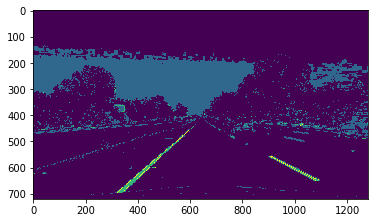

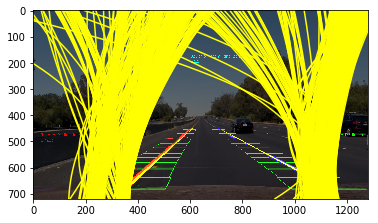

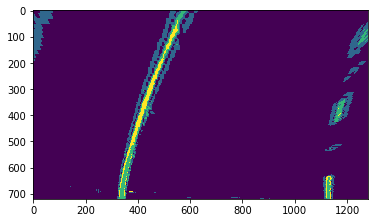

In [45]:
white_output = 'video_out/project_video_out_final2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("project_video.mp4")
## Creating left and right lanes objects
right_lane = Line()
right_lane.detected = False
left_lane = Line()
right_lane.detected = False
left_lane.best_fit= np.array((np.float64(2.3131e-04), np.float64(-4.0355e-01),np.float64(4.58920e+02)))
right_lane.best_fit= np.array((np.float64(3.1342e-04), np.float64(-3.698e-01),np.float64(1.19844e+03)))
left_lane.smooth_radius_of_curvature=15000.0
right_lane.smooth_radius_of_curvature=15000.0
right_lane.poly_counter=0
white_clip = clip1.fl_image(process_image)#.subclip(0,3) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)
print('Polycounter: ',right_lane.poly_counter)

In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))